In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from efficient_apriori import apriori
from matplotlib import pyplot as plt

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC3_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

# @param Definition des table et colonnes --> Dépendent de la DB
DB            = "Archive2018_2019_prod"
TABLE_ENTETE  = "Recette_entete_ticket"
TEMPS_ENTETE  = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE = TABLE_ENTETE             + ".Numero_ticket"
CONSOMMATEUR  = "Consommateur"
TABLE_DETAIL  = "Recette_detail_ticket"
TEMPS_DETAIL  = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL = TABLE_DETAIL             + ".Numero_ticket"
RECETTE_DETAIL = TABLE_DETAIL            + ".Total_net_ttc_ligne"
TABLE_ARTICLE = "Article_meti_HIST"
TABLE_UNIVERS = "Univers"
TABLE_MAGASIN = "Magasin"

Univers_Depth  = 4         # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_ticket_max = 5000000   # MAX = 26.671.566 --- ~ 4 data / ticket

# @param Permet de faire varier l'analyse
min_sup     = 0.0005       # support minimum analysé  
max_sup     = 0.004        # support maximum analysé
sup_iter    = 4            # Nombre d'itération - 1 fait sur la variantion de support
min_conf    = 0.2          # confiance minimum analysée
max_conf    = 0.7          # confiance maximum analysée
conf_iter   = 5            # Nombre d'itération - 1 fait sur la variantion de confiance
do_analysis = False        # Est-ce qu'on fait l'analyse ou non ? 

# @param du modèle prédictif
min_support    = 0         # Seuil de support minimal souhaité   -> 1/#univers ~= 1/500  --> 0 => auto 
min_confidence = 1/3       # Seuil de confiance minimal souhaité -> 1/3        ~= 33% 

take_only_fid        = False
do_shop              = True
tabac_key            = 272
accessoire_tabac_key = 271

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_ARTICLE+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_ARTICLE+"]", conn)
print(df)

conn.close()

   Article_meti_HIST.KEY
0                     -1
1                      1
2                      2
3                      3
4                      4
5                      5
6                      6
7                      7
8                      8
9                      9


# GROUPEMENT D'ARTICLE

In [4]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE   + '''.KEY], 
['''     + RECETTE_DETAIL + ''']''' + (''',
['''+ TABLE_ENTETE   +'''.'''+TABLE_MAGASIN+'''.KEY]''')*int(do_shop) + '''
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ENTETE  + '''.KEY] < ''' + str(11000000+nbr_ticket_max) + '''
AND ['''      + TABLE_ENTETE  + '''.KEY] > ''' + str(11000000) + '''
AND ['''      + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388 '''+ ('''
AND ['''      + TABLE_ENTETE  + '''.''' + CONSOMMATEUR  + '''.KEY] != -1 ''')*int(take_only_fid) + '''
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)
conn.close()

# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

SELECT [Article_meti_HIST.Univers.KEY],
[Recette_entete_ticket.KEY], 
[Recette_detail_ticket.Total_net_ttc_ligne],
[Recette_entete_ticket.Magasin.KEY]
FROM [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Article_meti_HIST.KEY] = [Recette_detail_ticket.Article_meti_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 16000000
AND [Recette_entete_ticket.KEY] > 11000000
AND [Article_meti_HIST.Univers.KEY] != 388 
ORDER BY [Recette_entete_ticket.KEY]
Time Taken to load DB: ~240secondes
          Article_meti_HIST.Univers.KEY  Recette_entete_ticket.KEY  \
0

In [5]:
def get_univers_correspondance(Univers_Depth):
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
        [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''

    conn = engine.connect()
    df_univers = pd.read_sql(sql_command, conn)
    conn.close()

    univers_correspondance = {}
    deleted = set()
    for item in df_univers.values:
        if item[0] in deleted:
            continue
        for cor in df_univers.values: 
            if item[0] != cor[0]:
                if (
                    item[1] == cor[1] and
                    (item[2] == cor[2] or Univers_Depth < 2) and
                    (item[3] == cor[3] or Univers_Depth < 3) and
                    (item[4] == cor[4] or Univers_Depth < 4)
                ):
                    univers_correspondance[cor[0]] = item[0]
                    deleted.add(cor[0])
    return univers_correspondance, deleted

univers_correspondance, deleted = get_univers_correspondance(Univers_Depth)

In [6]:
def load_transactions(dataframe, univ_cor, deleted):
    start = time()

    transactions      = []
    actual_key_ticket = -1
    for item in dataframe.values:
        key_univ = item[0]
        key_tic  = item[1]

        if actual_key_ticket != key_tic:
            if actual_key_ticket != -1:
                transactions.append(tuple(l))
            actual_key_ticket = key_tic
            l = []

        if key_univ in deleted:
            key_univ = univ_cor[key_univ]
        l.append(int(key_univ))
    transactions.append(tuple(l))
    print(transactions[:20])

    # environ 10s * #tickets / 2.000.000.
    print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 
    return transactions

def load_recurence(transactions, nbr_to_plt = 20):
    start = time()
    rec_article = {}
    N = len(transactions)

    for t in transactions:
        for art in set(t):
            if not str(art) in rec_article.keys():
                rec_article[str(art)] = 0
            rec_article[str(art)]+=1

    for k in rec_article.keys():
        rec_article[k]/= N
    print(N)

    #environ 1min
    print("Time Taken to load recurence: ~" + str(int(time() - start)) + "secondes") 

    rec_article = {k: v for k, v in sorted(rec_article.items(), key=lambda item: item[1], reverse = True)}
    nbr_univ = len(rec_article.keys())

    nbr_to_plt = 20
    
    fig = plt.figure(figsize=(15, 5))
    plt.bar(list(rec_article.keys())[:min(nbr_to_plt, nbr_univ)]
                ,list(rec_article.values())[:min(nbr_to_plt, nbr_univ)],1)

    plt.title("Nombre d'article vendu par univers relatif au nombre de transactions")

    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Proportion-Article.jpg")
    plt.show()

    return rec_article, nbr_univ

In [7]:
def Analysis(transactions, min_sup, max_sup, sup_iter, min_conf, max_conf, conf_iter):
    data_rules = {}
    data_time  = {}
    for i_support in range(sup_iter+1):
        min_support = max_sup - i_support*(max_sup-min_sup)/sup_iter

        if min_support <= 0:
            break

        print(min_support, end = ': ')

        data_rules[min_support] = {}
        data_time[min_support]  = {}
        for i_confidence in range(conf_iter+1):
            min_confidence = max_conf - i_confidence*(max_conf-min_conf)/conf_iter

            print(min_confidence, end = '... ')

            start = time()
            _, rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence)

            data_rules[min_support][min_confidence] = len(rules)
            data_time[min_support][min_confidence]  = int(time() - start)

        print(sum(data_time[min_support].values()), "secondes")


    df_rules = pd.DataFrame(data_rules)
    print(df_rules)
    df_time = pd.DataFrame(data_time)
    print(df_time)

In [8]:
def get_rules(transactions, min_support, min_confidence, nbr_univ = 490):
    start = time()

    min_supp = 1/nbr_univ if min_support == 0 else min_support
    print(min_supp)

    _, rules = apriori(transactions, min_support=min_supp, min_confidence=min_confidence)

    # eniviron 30s*0.002/min_sup * #transactions / 2.500.000     
    print("Time Taken to run Apriori Algorithm : ~" + str(int(time() - start)) + "secondes") 
    
    return rules

In [9]:
def print_rules(rules, Univers_Depth, conn, removed_key = -1):
    conn = engine.connect()

    for rule in sorted(rules, key=lambda rule: rule.lift):
        if rule.lift <= 1 or removed_key in rule.lhs or removed_key in rule.rhs:
            continue

        print("\n\nRule : ", rule)

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.lhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))
        print('->')

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in rule.rhs:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]

        df_libele = pd.read_sql(sql_command, conn)

        print(df_libele.to_string(index=False))

    conn.close()

[(360, 402), (403, 403, 298, 403), (220, 392, 220), (219, 288, 171), (151, 151, 151, 353, 174, 435, 431), (470, 392, 457, 393), (360, 360, 397, 400), (458, 211), (110, 357, 393, 232), (272,), (272, 297), (409, 452, 409, 313), (117, 242), (458, 406, 408, 402), (27, 298), (272,), (121, 163, 409, 469), (211,), (129, 456, 396), (363, 391)]
Time Taken to load transaction: ~11secondes
3795699
Time Taken to load recurence: ~9secondes


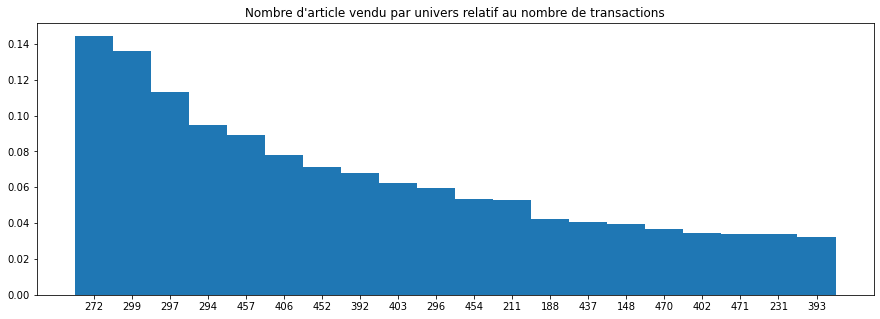

0.001
Time Taken to run Apriori Algorithm : ~67secondes


Rule :  {246} -> {272} (conf: 0.153, supp: 0.002, lift: 1.061, conv: 1.010)
 Univ_KEY   Univ_1 Univ_2 Univ_3   Univ_4
      246 BOISSONS   VINS FRANCE BORDEAUX
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {472} -> {272} (conf: 0.154, supp: 0.002, lift: 1.065, conv: 1.011)
 Univ_KEY   Univ_1      Univ_2      Univ_3                 Univ_4
      472 BOISSONS SOFT DRINKS THES FROIDS THES FROIDS PETILLANTS
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {406, 457} -> {272} (conf: 0.154, supp: 0.001, lift: 1.069, conv: 1.012)
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
      457      BO

 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES
      457       BOISSONS  SOFT DRINKS          SODA         COLAS
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {211, 457} -> {299} (conf: 0.164, supp: 0.001, lift: 1.206, conv: 1.033)
 Univ_KEY   Univ_1      Univ_2      Univ_3      Univ_4
      211 BOISSONS        EAUX EAUX PLATES EAUX PLATES
      457 BOISSONS SOFT DRINKS        SODA       COLAS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {211, 457} -> {272} (conf: 0.175, supp: 0.001, lift: 1.211, conv: 1.037)
 Univ_KEY   Univ_1      Univ_2      Univ_3      Univ_4
      211 BOISSONS        EAUX EAUX PLATES EAUX PLATES
      457 BOISSONS SOFT DRINKS        SODA       COLAS
->

 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {208} -> {272} (conf: 0.201, supp: 0.001, lift: 1.390, conv: 1.071)
 Univ_KEY   Univ_1 Univ_2            Univ_3            Univ_4
      208 BOISSONS BIERES BIERES MIX ALCOOL BIERES MIX ALCOOL
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {452, 454} -> {297} (conf: 0.158, supp: 0.001, lift: 1.396, conv: 1.053)
 Univ_KEY                     Univ_1                       Univ_2                       Univ_3                       Univ_4
      452                   ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
      454 A

 Univ_KEY          Univ_1                       Univ_2    Univ_3    Univ_4
       74 PRET A CUISINER                       SPREAD    SPREAD    SPREAD
      294  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {231} -> {272} (conf: 0.235, supp: 0.008, lift: 1.631, conv: 1.119)
 Univ_KEY   Univ_1      Univ_2                Univ_3                Univ_4
      231 BOISSONS SOFT DRINKS BOISSONS ENERGISANTES BOISSONS ENERGISANTES
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {13} -> {297} (conf: 0.185, supp: 0.004, lift: 1.638, conv: 1.088)
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES
->
 Univ_KEY         Univ_1                       

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {296} -> {294} (conf: 0.168, supp: 0.010, lift: 1.779, conv: 1.088)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {129} -> {457} (conf: 0.158, supp: 0.004, lift: 1.782, conv: 1.083)
 Univ_KEY  Univ_1                Univ_2     Univ_3      Univ_4
      129 DESSERT CONFISERIE CHOCOLATEE CANDY BARS INDIVIDUELS
->
 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {392} -> {457} (conf: 0.159, supp: 0.011, lift: 1.783, conv: 1.083)
 Univ_KEY        Univ_1     Univ_2            Univ_3               Univ_4
      392 PRET A MANGER SANDWICHES

 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {299, 392} -> {457} (conf: 0.171, supp: 0.002, lift: 1.919, conv: 1.098)
 Univ_KEY         Univ_1       Univ_2            Univ_3               Univ_4
      299 PETIT DEJEUNER VIENNOISERIE     VIENNOISERIES        VIENNOISERIES
      392  PRET A MANGER   SANDWICHES SANDWICHES FROIDS SANDWICHES CLASSIQUE
->
 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {272, 296} -> {297} (conf: 0.222, supp: 0.001, lift: 1.962, conv: 1.140)
 Univ_KEY          Univ_1                       Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE           TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES
      296  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS         MINI PAINS         MINI PAINS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS




 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {473} -> {452} (conf: 0.156, supp: 0.002, lift: 2.196, conv: 1.101)
 Univ_KEY                     Univ_1                    Univ_2 Univ_3     Univ_4
      473 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS INDIVIDUEL
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {142} -> {406} (conf: 0.172, supp: 0.002, lift: 2.209, conv: 1.114)
 Univ_KEY  Univ_1        Univ_2              Univ_3              Univ_4
      142 DESSERT DESSERT FRAIS DESSERTS CHOCOLATES DESSERTS CHOCOLATES
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {296, 452} -> {294} (conf: 0.209, supp: 0.001, lift: 2.213, conv: 1.145)
 Univ_KEY    

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {393} -> {392} (conf: 0.161, supp: 0.005, lift: 2.370, conv: 1.111)
 Univ_KEY        Univ_1     Univ_2            Univ_3              Univ_4
      393 PRET A MANGER SANDWICHES SANDWICHES FROIDS SANDWICHES SPECIAUX
->
 Univ_KEY        Univ_1     Univ_2            Univ_3               Univ_4
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS SANDWICHES CLASSIQUE


Rule :  {117} -> {452} (conf: 0.169, supp: 0.001, lift: 2.380, conv: 1.118)
 Univ_KEY  Univ_1             Univ_2  Univ_3  Univ_4
      117 DESSERT BISCUITERIE SUCREE GAUFRES GAUFRES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {196

 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD CHINESE FOOD
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {296, 452} -> {297} (conf: 0.290, supp: 0.002, lift: 2.565, conv: 1.249)
 Univ_KEY         Univ_1                       Univ_2                       Univ_3                       Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS                   MINI PAINS                   MINI PAINS
      452       ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {402, 406} -> {452} (conf: 0.183, supp: 0.001, lift: 2.573, conv: 1.137)
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      402 PRET A MANGER P

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {321} -> {452} (conf: 0.192, supp: 0.002, lift: 2.700, conv: 1.149)
 Univ_KEY                     Univ_1                    Univ_2             Univ_3             Univ_4
      321 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS CACAHUETES  AUTRES CACAHUETES  AUTRES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {435} -> {452} (conf: 0.192, supp: 0.003, lift: 2.701, conv: 1.149)
 Univ_KEY        Univ_1     Univ_2     Univ_3           Univ_4
      435 PRET A MANGER ROTISSOIRE ROTISSOIRE A BASE DE POULET
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3          

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {296, 475} -> {297} (conf: 0.323, supp: 0.001, lift: 2.858, conv: 1.310)
 Univ_KEY          Univ_1                       Univ_2     Univ_3     Univ_4
      296  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
      475 PRET A CUISINER                      FROMAGE  PATE DURE   TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {68} -> {452} (conf: 0.203, supp: 0.002, lift: 2.860, conv: 1.166)
 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {475} -> {297} (conf: 0.334, supp: 0.006, lift: 2.960, conv: 1.333)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {294, 406} -> {452} (conf: 0.210, supp: 0.001, lift: 2.960, conv: 1.176)
 Univ_KEY         Univ_1                       Univ_2       Univ_3         Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    BAGUETTES      BAGUETTES
      406  PRET A MANGER               PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES

 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {439, 452} -> {299} (conf: 0.420, supp: 0.001, lift: 3.090, conv: 1.489)
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      439 BOISSONS                    JUS ZUMEX                 JUS ZUMEX 1P                 JUS ZUMEX 1P
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {403, 457} -> {452} (conf: 0.222, supp: 0.001, lift: 3.124, conv: 1.194)
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION
      457      BOISSONS    SOFT DRINKS           SODA           COLAS
->
 Univ_KEY   Univ

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {287} -> {452} (conf: 0.236, supp: 0.002, lift: 3.315, conv: 1.215)
 Univ_KEY         Univ_1                  Univ_2   Univ_3   Univ_4
      287 PETIT DEJEUNER TARTINABLES ET CEREALES CEREALES CEREALES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {297, 454} -> {452} (conf: 0.237, supp: 0.001, lift: 3.339, conv: 1.218)
 Univ_KEY                     Univ_1                       Univ_2 Univ_3   Univ_4
      297             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS    PAINS
      454 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4

 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION
      457      BOISSONS    SOFT DRINKS           SODA           COLAS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {83, 297} -> {452} (conf: 0.262, supp: 0.001, lift: 3.694, conv: 1.259)
 Univ_KEY          Univ_1                       Univ_2 Univ_3 Univ_4
       83 PRET A CUISINER                        OEUFS  OEUFS  OEUFS
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {461} -> {454} (conf: 0.197, supp: 0.003, lift: 3.698, conv: 1.179)
 Univ_KEY                     Univ_1 Univ_2                  Univ_3    

 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      402 PRET A MANGER PLATS PREPARES CHINESE FOOD   CHINESE FOOD
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
->
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION


Rule :  {328} -> {454} (conf: 0.254, supp: 0.002, lift: 4.761, conv: 1.269)
 Univ_KEY                     Univ_1 Univ_2   Univ_3   Univ_4
      328 APERITIF   ENTREES   TAPAS  TAPAS FROMAGES FROMAGES
->
 Univ_KEY                     Univ_1                    Univ_2 Univ_3   Univ_4
      454 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS > 1 PERS


Rule :  {409} -> {402} (conf: 0.169, supp: 0.002, lift: 4.865, conv: 1.162)
 Univ_KEY        Univ_1         Univ_2        Univ_3       Univ_4
      409 PRET A MANGER PLATS PREPARES JAPANESE FOOD SUSHIS ET CO
->
 Univ_KEY        Univ_1         Univ_2       Univ_3       Univ_4
      402 PRET 

 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES


Rule :  {183} -> {13} (conf: 0.201, supp: 0.005, lift: 9.492, conv: 1.225)
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
->
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES


Rule :  {13} -> {183} (conf: 0.234, supp: 0.005, lift: 9.492, conv: 1.274)
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS


Rule :  {186} -> {183} (conf: 0.236, supp: 0.001, lift: 9.545, conv: 1.276)
 Univ_KEY           Univ_1  Univ_2         Univ_3  Univ_4
      186 FRUITS   LEGUMES LEGUMES 

 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       56 PRET A CUISINER FROMAGE MOZZARELLA MOZZARELLA
->
 Univ_KEY           Univ_1  Univ_2         Univ_3 Univ_4
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS


Rule :  {62, 294} -> {475} (conf: 0.269, supp: 0.001, lift: 14.200, conv: 1.341)
 Univ_KEY          Univ_1                       Univ_2    Univ_3        Univ_4
       62 PRET A CUISINER                  CHARCUTERIE   JAMBONS JAMBONS CUITS
      294  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES     BAGUETTES
->
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES


Rule :  {297, 475} -> {62} (conf: 0.265, supp: 0.002, lift: 14.448, conv: 1.336)
 Univ_KEY          Univ_1                       Univ_2    Univ_3   Univ_4
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     PAINS    PAINS
      475 PRET A CUISINER                      FROMAGE PATE DURE TRANCHES
->
 Univ_KEY          Univ_1      Uni

In [42]:
transactions = load_transactions(df_art_ticket, univers_correspondance, deleted)

if do_analysis:
    Analysis(transactions, min_sup, max_sup, sup_iter, min_conf, max_conf, conf_iter)

rec_article, nbr_univ = load_recurence(transactions)
rules = get_rules(transactions, 0.001, 0.15, nbr_univ)
print_rules(rules, Univers_Depth, conn)

In [11]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~291secondes


## Panier d'Articles par magasin

In [12]:
sql_command = '''  
SELECT ['''+TABLE_MAGASIN+'''.KEY]
      ,['''+TABLE_MAGASIN+'''.Libelle_magasin]
FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_MAGASIN+''']
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()


print(df_magasin)

  
SELECT [Magasin.KEY]
      ,[Magasin.Libelle_magasin]
FROM [Archive2018_2019_prod].[DWH].[Dim_Magasin]

    Magasin.KEY Magasin.Libelle_magasin
0            -1                       ?
1             1                    None
2             2                  GENVAL
3             3            OHAIN F 2020
4             4                 JURBISE
..          ...                     ...
84           84    Franchise Uccle 2020
85           85           EXPANSION 535
86           86           EXPANSION 536
87           87           EXPANSION 537
88           88  DLTLU Match Laudelange

[89 rows x 2 columns]


In [14]:
if do_shop:
    all_mag_key = set(df_art_ticket[TABLE_ENTETE+"."+TABLE_MAGASIN + ".KEY"])

    all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
    all_mag_tra = {mag_key:[] for mag_key in all_mag_key}

    start = time()

    actual_key_ticket = -1
    for item in df_art_ticket.values:
        key_univ = item[0]
        key_tic  = item[1]
        key_mag  = item[3]

        if actual_key_ticket != key_tic:
            if actual_key_ticket != -1:
                all_mag_tra[key_mag].append(tuple(l))
            actual_key_ticket = key_tic
            l = []

        if key_univ in deleted:
            key_univ = univers_correspondance[key_univ]
        l.append(key_univ)
    all_mag_tra[key_mag].append(tuple(l))

    # environ 10s
    print("Time Taken to run load transaction : ~" + str(int(time() - start)) + "secondes") 

Time Taken to run load transaction : ~11secondes


-------------------GENVAL--------------------------
63571
Time Taken to load recurence: ~0secondes


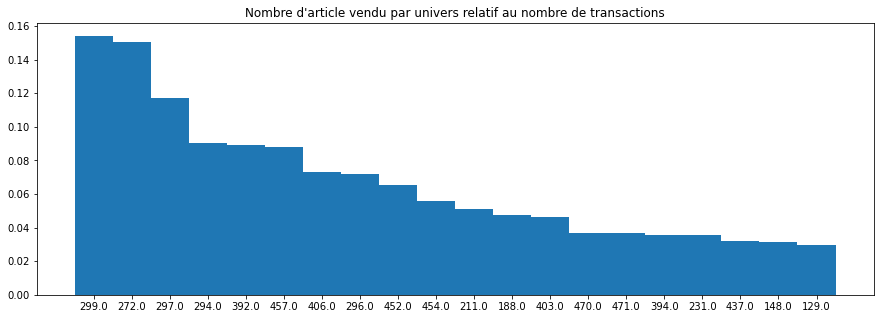

0.002570694087403599
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {299.0} (conf: 0.347, supp: 0.008, lift: 2.251, conv: 1.295)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.426, supp: 0.014, lift: 2.762, conv: 1.473)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {438.0} -> {299.0} (conf: 0.432, supp: 0.003, lift: 2.805, conv: 1.490)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2      

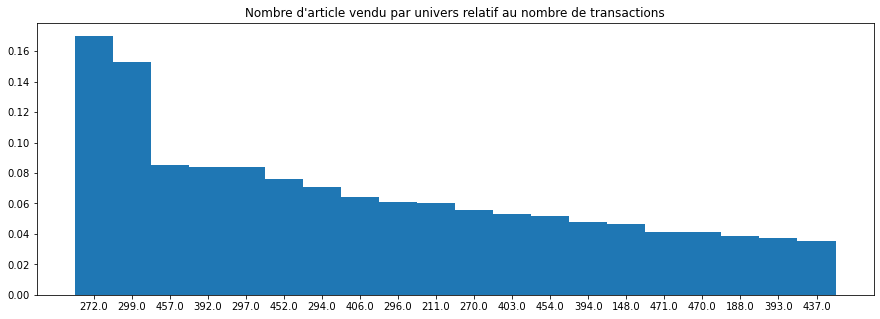

0.0025
Time Taken to run Apriori Algorithm : ~1secondes


Rule :  {296.0, 297.0} -> {299.0} (conf: 0.343, supp: 0.004, lift: 2.238, conv: 1.289)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      PAINS      PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {198.0} -> {299.0} (conf: 0.390, supp: 0.006, lift: 2.545, conv: 1.388)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301.0} -> {299.0} (conf: 0.434, supp: 0.003, lift: 2.832, conv: 1.495)
 Univ_KEY         Univ_1            Univ_2           Univ_3        

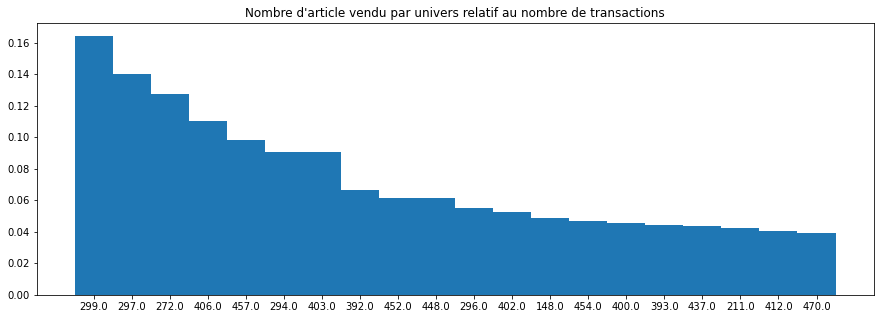

0.002531645569620253
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {437.0} -> {299.0} (conf: 0.381, supp: 0.017, lift: 2.322, conv: 1.351)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {198.0} -> {299.0} (conf: 0.402, supp: 0.006, lift: 2.446, conv: 1.397)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {27.0} -> {297.0} (conf: 0.362, supp: 0.003, lift: 2.587, conv: 1.348)
 Univ_KEY          Univ_1    Univ_2      Univ_3            Univ_4
       27 PRET A CUISINER BOUCHERIE SPECIALITES AMERICAIN PREPARE
->
 Univ_KEY         Univ_1  

 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {62.0, 448.0} -> {297.0} (conf: 0.961, supp: 0.003, lift: 6.862, conv: 21.823)
 Univ_KEY          Univ_1         Univ_2                 Univ_3                 Univ_4
       62 PRET A CUISINER    CHARCUTERIE                JAMBONS          JAMBONS CUITS
      448        ECONOMAT ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {448.0} -> {297.0} (conf: 0.961, supp: 0.059, lift: 6.862, conv: 21.834)
 Univ_KEY   Univ_1         Univ_2                 Univ_3                 Univ_4
      448 ECONOMAT ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS 

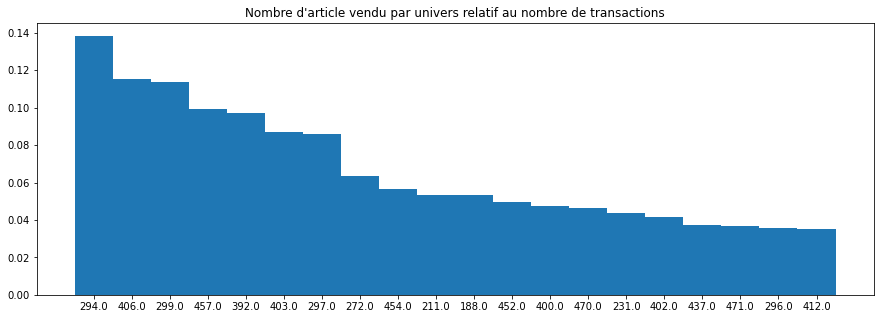

0.002531645569620253
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {475.0} -> {294.0} (conf: 0.348, supp: 0.007, lift: 2.516, conv: 1.322)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {22.0} -> {294.0} (conf: 0.369, supp: 0.004, lift: 2.668, conv: 1.366)
 Univ_KEY          Univ_1    Univ_2 Univ_3 Univ_4
       22 PRET A CUISINER BOUCHERIE  BOEUF  BOEUF
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {294.0, 403.0} -> {406.0} (conf: 0.346, supp: 0.003, lift: 2.995, conv: 1.352)
 Univ_KEY         Univ_1                       Univ_2         Univ_3          Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      BAGUETTES       BAGUETTES


26402
Time Taken to load recurence: ~0secondes


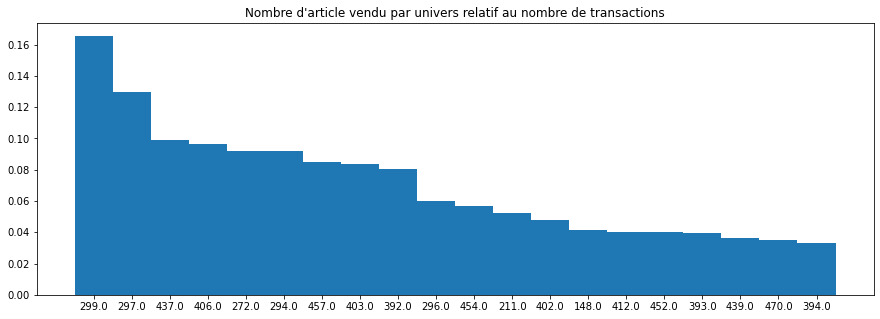

0.002617801047120419
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {294.0, 296.0} -> {299.0} (conf: 0.335, supp: 0.004, lift: 2.026, conv: 1.256)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  BAGUETTES  BAGUETTES
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {272.0, 437.0} -> {299.0} (conf: 0.370, supp: 0.003, lift: 2.236, conv: 1.325)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES
      437  PETIT DEJEUNER       CAFE SERVICE       CAFE SERVICE       CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rul

35844
Time Taken to load recurence: ~0secondes


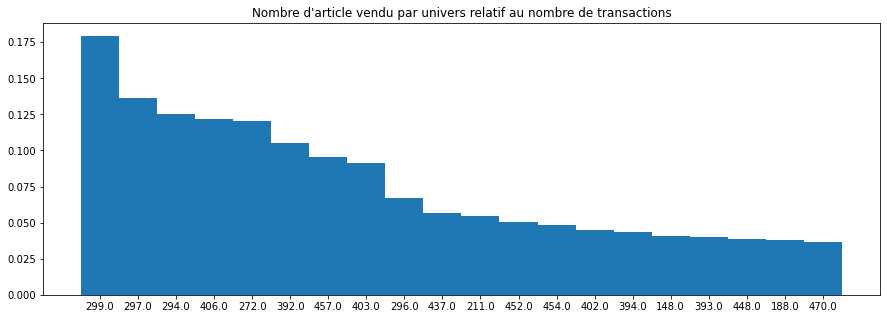

0.0026666666666666666
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {220.0} -> {299.0} (conf: 0.367, supp: 0.004, lift: 2.045, conv: 1.296)
 Univ_KEY   Univ_1   Univ_2               Univ_3               Univ_4
      220 BOISSONS JUS SECS JUS DE FRUITS SEC 1P JUS DE FRUITS SEC 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {198.0} -> {299.0} (conf: 0.380, supp: 0.005, lift: 2.118, conv: 1.323)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {438.0} -> {299.0} (conf: 0.396, supp: 0.003, lift: 2.208, conv: 1.359)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1      

 Univ_KEY          Univ_1             Univ_2                 Univ_3                 Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES     TABAC   CIGARETTES     TABAC   CIGARETTES
      448        ECONOMAT     ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {294.0, 448.0} -> {297.0} (conf: 0.987, supp: 0.006, lift: 7.244, conv: 66.796)
 Univ_KEY         Univ_1                       Univ_2                 Univ_3                 Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS              BAGUETTES              BAGUETTES
      448       ECONOMAT               ECONOMAT AUTRE FOURNITURE ET MATERIEL FOURNITURE ET MATERIEL
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {448.0, 457.0} -> {297.0} (conf: 0.991, supp: 0.0

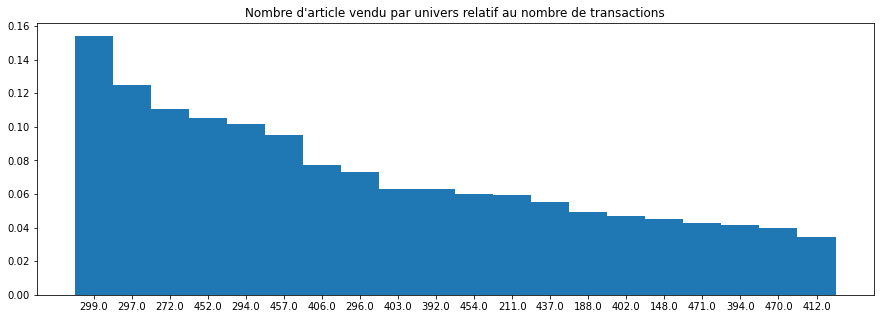

0.0025575447570332483
Time Taken to run Apriori Algorithm : ~1secondes


Rule :  {437.0} -> {299.0} (conf: 0.399, supp: 0.022, lift: 2.589, conv: 1.407)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {68.0} -> {297.0} (conf: 0.349, supp: 0.003, lift: 2.788, conv: 1.344)
 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {475.0} -> {297.0} (conf: 0.359, supp: 0.008, lift: 2.869, conv: 1.365)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ

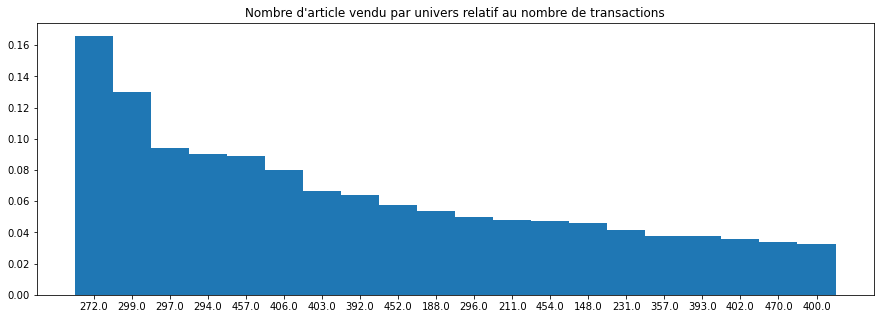

0.0025974025974025974
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {299.0} (conf: 0.341, supp: 0.006, lift: 2.626, conv: 1.321)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.343, supp: 0.009, lift: 2.637, conv: 1.324)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {271.0} -> {272.0} (conf: 0.540, supp: 0.006, lift: 3.251, conv: 1.811)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCE

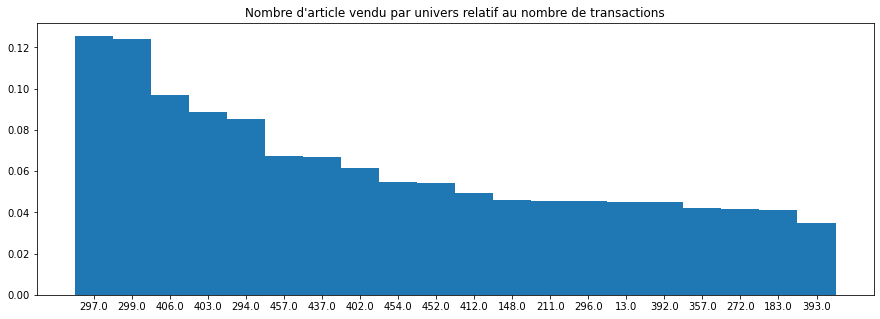

0.002857142857142857
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {18.0} -> {297.0} (conf: 0.356, supp: 0.004, lift: 2.837, conv: 1.358)
 Univ_KEY          Univ_1                     Univ_2  Univ_3  Univ_4
       18 PRET A CUISINER BEURRES   MATIERES GRASSES BEURRES BEURRES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {68.0} -> {297.0} (conf: 0.372, supp: 0.003, lift: 2.961, conv: 1.392)
 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {475.0} -> {297.0} (conf: 0.396, supp: 0.008, lift: 3.154, conv: 1.448)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2

110929
Time Taken to load recurence: ~0secondes


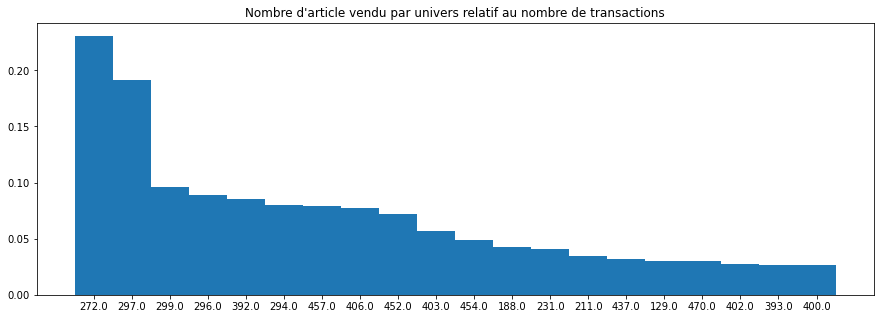

0.0025380710659898475
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {272.0} (conf: 0.358, supp: 0.006, lift: 1.553, conv: 1.199)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {231.0} -> {272.0} (conf: 0.362, supp: 0.015, lift: 1.570, conv: 1.206)
 Univ_KEY   Univ_1      Univ_2                Univ_3                Univ_4
      231 BOISSONS SOFT DRINKS BOISSONS ENERGISANTES BOISSONS ENERGISANTES
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {176.0} -> {297.0} (conf: 0.341, supp: 0.003, lift: 1.782, conv: 1.227)
 Univ_KEY           Univ_1 Univ_2 Univ_3 Univ_4
      176 FRUITS   LE

97950
Time Taken to load recurence: ~0secondes


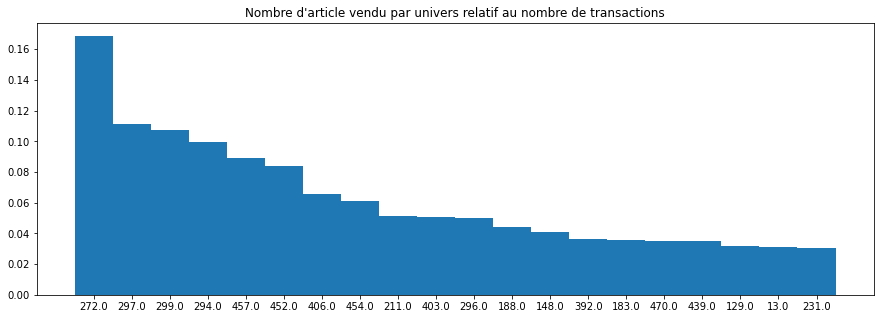

0.002506265664160401
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {271.0} -> {272.0} (conf: 0.460, supp: 0.005, lift: 2.726, conv: 1.539)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {74.0} -> {294.0} (conf: 0.334, supp: 0.006, lift: 3.352, conv: 1.351)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {437.0} -> {299.0} (conf: 0.395, supp: 0.006, lift: 3.684, conv: 1.476)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAF

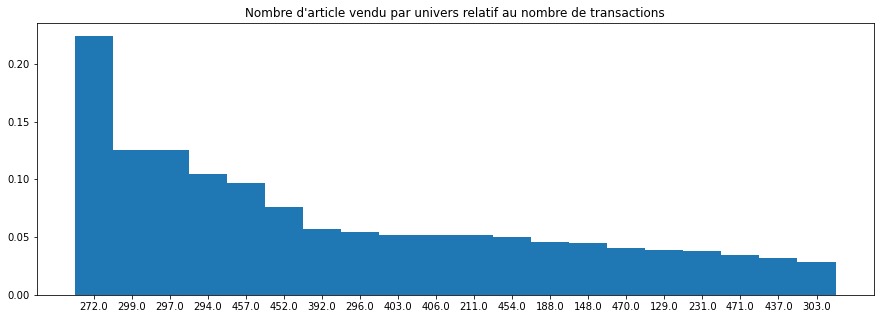

0.0025188916876574307
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {271.0} -> {272.0} (conf: 0.508, supp: 0.009, lift: 2.269, conv: 1.579)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {68.0} -> {297.0} (conf: 0.334, supp: 0.003, lift: 2.662, conv: 1.313)
 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {437.0} -> {299.0} (conf: 0.420, supp: 0.013, lift: 3.335, conv: 1.506)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE 

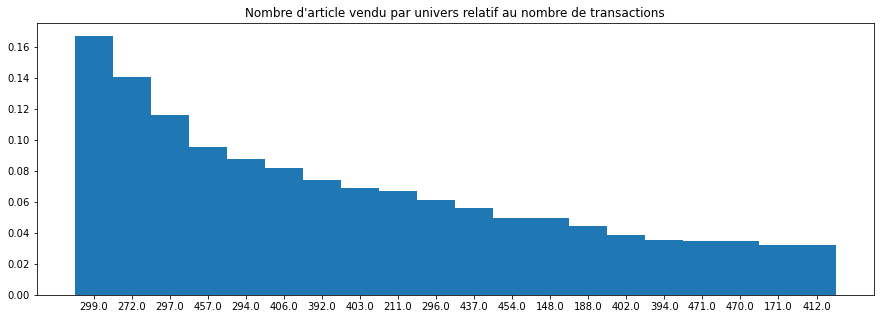

0.002617801047120419
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {296.0, 297.0} -> {299.0} (conf: 0.339, supp: 0.004, lift: 2.031, conv: 1.260)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      PAINS      PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.432, supp: 0.024, lift: 2.587, conv: 1.466)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {61.0} -> {297.0} (conf: 0.352, supp: 0.003, lift: 3.040, conv: 1.364)
 Univ_KEY          Univ_1      Univ_2  Univ_3       

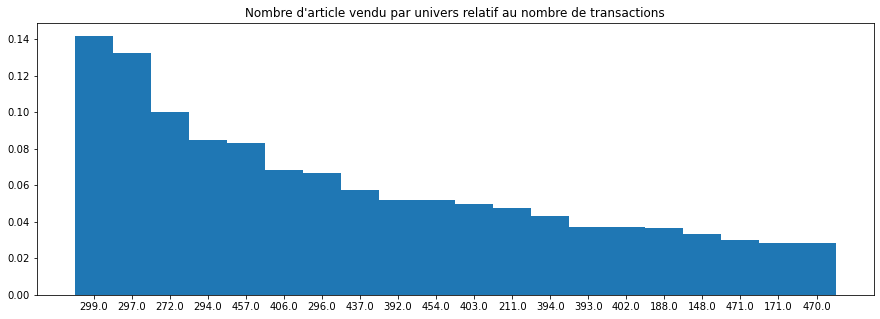

0.0026109660574412533
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {437.0} -> {299.0} (conf: 0.382, supp: 0.022, lift: 2.694, conv: 1.388)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {62.0} -> {297.0} (conf: 0.370, supp: 0.007, lift: 2.792, conv: 1.377)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {475.0} -> {297.0} (conf: 0.403, supp: 0.008, lift: 3.041, conv: 1.453)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2

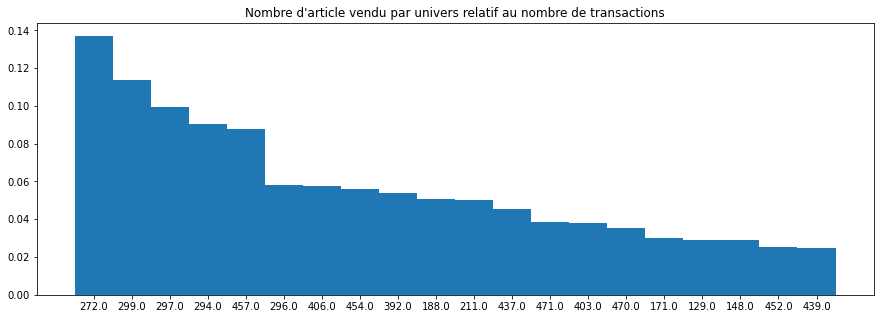

0.002570694087403599
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {439.0} -> {299.0} (conf: 0.343, supp: 0.009, lift: 3.018, conv: 1.349)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {271.0} -> {272.0} (conf: 0.425, supp: 0.005, lift: 3.101, conv: 1.501)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {74.0} -> {294.0} (conf: 0.357, supp: 0.007, lift: 3.960, conv: 1.415)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER SPREAD SPREAD SPREAD
->
 Univ_KE

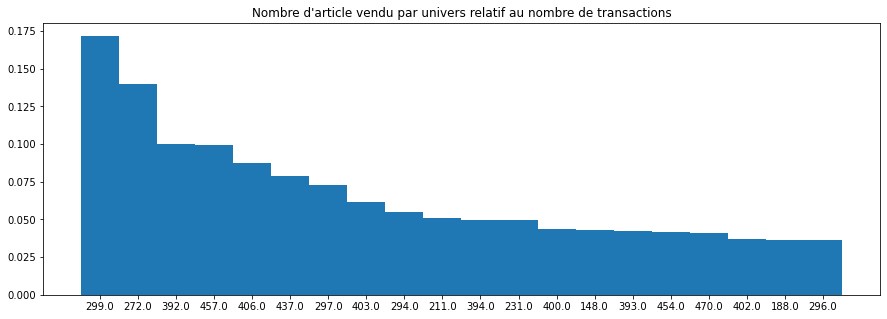

0.002570694087403599
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {299.0} (conf: 0.371, supp: 0.009, lift: 2.156, conv: 1.316)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.393, supp: 0.031, lift: 2.285, conv: 1.364)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {438.0} -> {299.0} (conf: 0.484, supp: 0.003, lift: 2.814, conv: 1.603)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2      

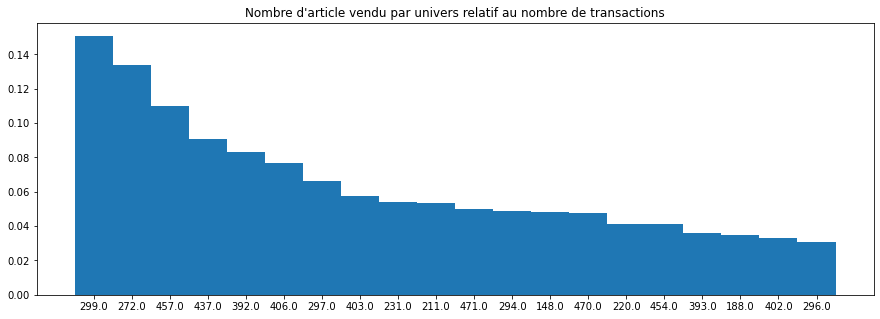

0.0025906735751295338
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {272.0, 437.0} -> {299.0} (conf: 0.345, supp: 0.003, lift: 2.287, conv: 1.296)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES
      437  PETIT DEJEUNER       CAFE SERVICE       CAFE SERVICE       CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {439.0} -> {299.0} (conf: 0.418, supp: 0.012, lift: 2.772, conv: 1.459)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301.0} -> {299.0} (conf: 0.421, supp: 0.006, lift: 2.795, conv: 1.468)
 Univ_KEY         Univ_1            Univ_2     

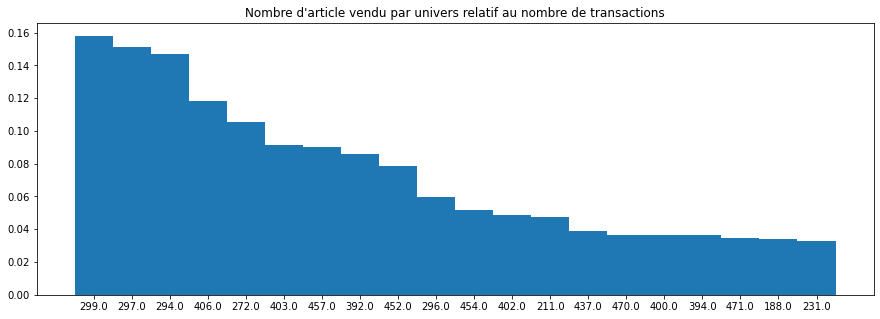

0.0025
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {62.0} -> {297.0} (conf: 0.354, supp: 0.009, lift: 2.341, conv: 1.315)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {68.0} -> {297.0} (conf: 0.361, supp: 0.003, lift: 2.385, conv: 1.328)
 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {61.0} -> {294.0} (conf: 0.351, supp: 0.003, lift: 2.390, conv: 1.314)
 Univ_KEY          Univ_1      Univ_2  Univ_3       Univ_4
       61 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CRUS
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4


-------------------BRAINE L ALLEUD 1 F 2020--------------------------
70950
Time Taken to load recurence: ~0secondes


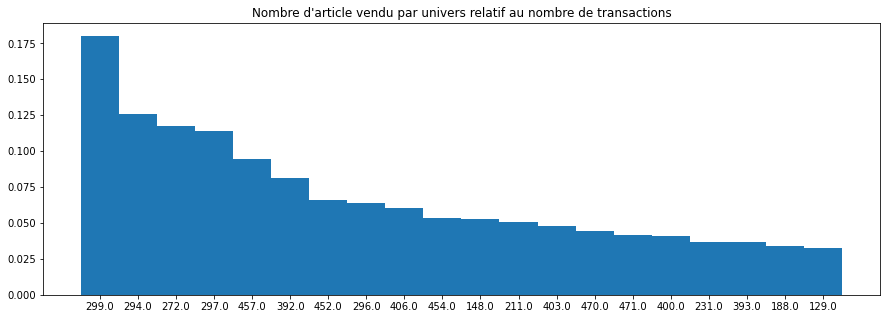

0.002564102564102564
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {299.0} (conf: 0.396, supp: 0.007, lift: 2.196, conv: 1.356)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.423, supp: 0.008, lift: 2.349, conv: 1.422)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301.0} -> {299.0} (conf: 0.481, supp: 0.003, lift: 2.667, conv: 1.578)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Un

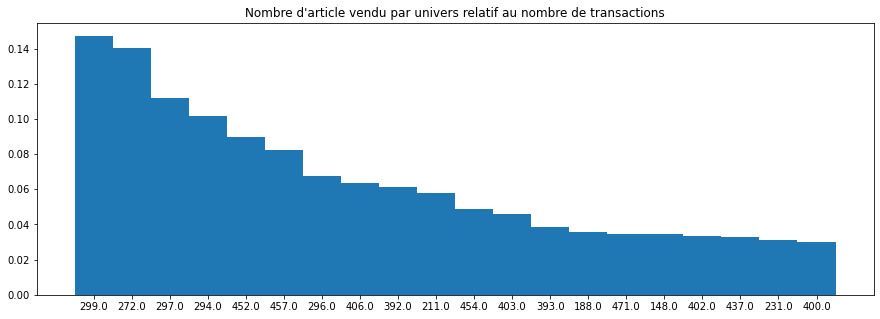

0.0025188916876574307
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {294.0, 296.0} -> {299.0} (conf: 0.335, supp: 0.004, lift: 2.274, conv: 1.282)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  BAGUETTES  BAGUETTES
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {296.0, 297.0} -> {299.0} (conf: 0.362, supp: 0.005, lift: 2.463, conv: 1.338)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      PAINS      PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299

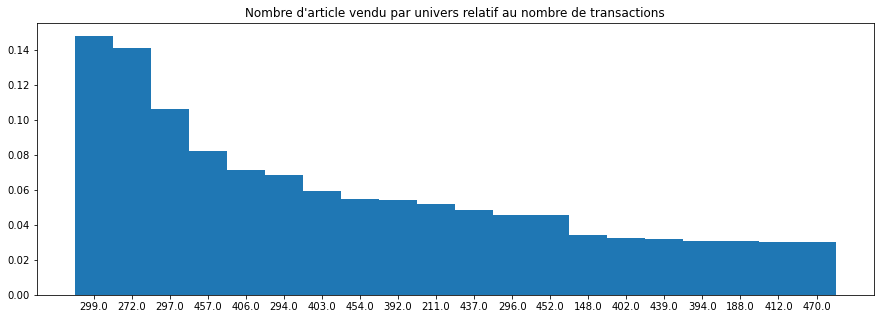

0.0027247956403269754
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {296.0, 297.0} -> {299.0} (conf: 0.354, supp: 0.003, lift: 2.394, conv: 1.319)
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      PAINS      PAINS
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.365, supp: 0.018, lift: 2.471, conv: 1.342)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {439.0} -> {299.0} (conf: 0.446, supp: 0.014, lift: 3.019, conv: 1.539)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Un

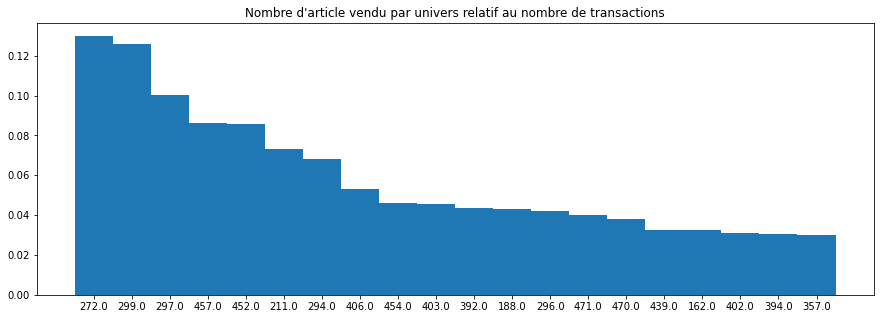

0.002702702702702703
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {437.0} -> {299.0} (conf: 0.390, supp: 0.012, lift: 3.098, conv: 1.432)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {439.0} -> {299.0} (conf: 0.432, supp: 0.014, lift: 3.438, conv: 1.540)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {271.0} -> {272.0} (conf: 0.510, supp: 0.004, lift: 3.927, conv: 1.777)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_K

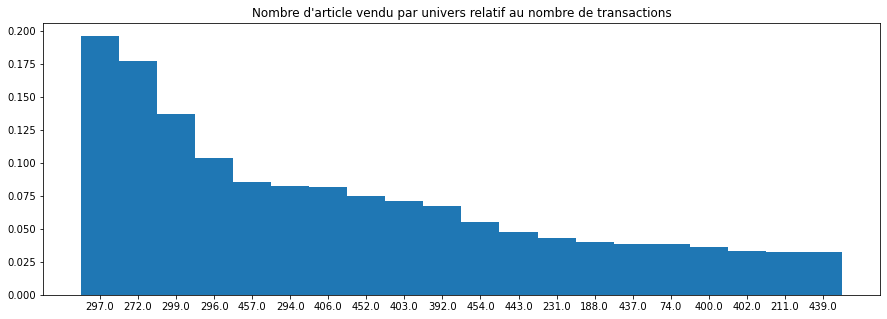

0.0025188916876574307
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {294.0, 299.0} -> {297.0} (conf: 0.337, supp: 0.004, lift: 1.717, conv: 1.212)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     BAGUETTES     BAGUETTES
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES VIENNOISERIES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {83.0} -> {297.0} (conf: 0.344, supp: 0.005, lift: 1.753, conv: 1.225)
 Univ_KEY          Univ_1 Univ_2 Univ_3 Univ_4
       83 PRET A CUISINER  OEUFS  OEUFS  OEUFS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {299.0, 452.0} -> {297.0} (conf: 0.368, supp: 0.005, lift: 1.872, conv: 1.271)
 Univ_KEY         Univ_1                       Univ_

 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MINI PAINS MINI PAINS


Rule :  {271.0} -> {272.0} (conf: 0.596, supp: 0.006, lift: 3.366, conv: 2.036)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {74.0, 297.0} -> {296.0} (conf: 0.352, supp: 0.006, lift: 3.387, conv: 1.382)
 Univ_KEY          Univ_1                       Univ_2 Univ_3 Univ_4
       74 PRET A CUISINER                       SPREAD SPREAD SPREAD
      297  PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS
->
 Univ_KEY         Univ_1                       Univ_2     Univ_3     Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS MIN

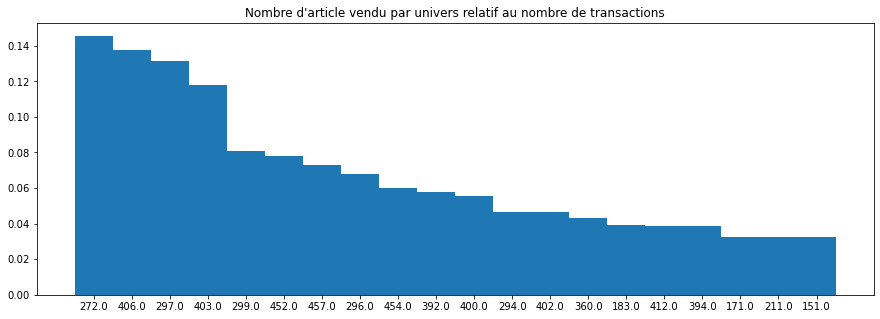

0.002512562814070352
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {462.0} -> {297.0} (conf: 0.340, supp: 0.004, lift: 2.582, conv: 1.315)
 Univ_KEY          Univ_1  Univ_2    Univ_3 Univ_4
      462 PRET A CUISINER FROMAGE PATE DURE   BLOC
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {403.0, 452.0} -> {406.0} (conf: 0.357, supp: 0.005, lift: 2.597, conv: 1.341)
 Univ_KEY        Univ_1                       Univ_2                       Univ_3                       Univ_4
      403 PRET A MANGER               PLATS PREPARES               TRADITION FOOD              PLATS TRADITION
      452      ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {52.0} -> {297.0} (conf: 0.345, supp: 

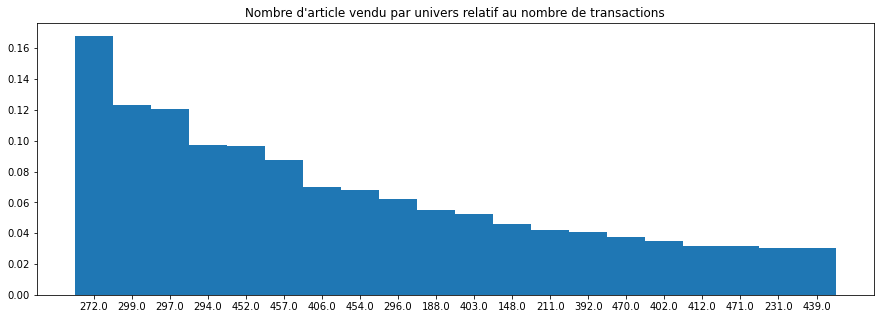

0.0025188916876574307
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {475.0} -> {297.0} (conf: 0.335, supp: 0.009, lift: 2.782, conv: 1.322)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {68.0} -> {297.0} (conf: 0.361, supp: 0.004, lift: 3.004, conv: 1.377)
 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {452.0, 475.0} -> {297.0} (conf: 0.380, supp: 0.003, lift: 3.162, conv: 1.419)
 Univ_KEY          Univ_1                       Univ_2                       Univ_3                       Univ_4
      452        ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES

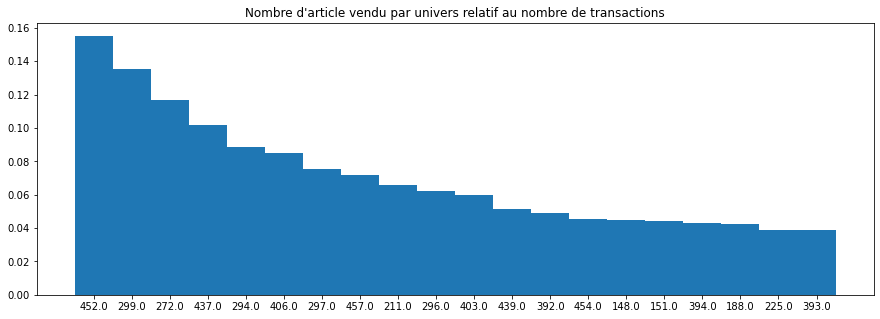

0.002512562814070352
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {154.0} -> {452.0} (conf: 0.334, supp: 0.003, lift: 2.155, conv: 1.269)
 Univ_KEY   Univ_1                Univ_2 Univ_3 Univ_4
      154 SURGELES PLATS ACCOMPAGNEMENTS  PIZZA  PIZZA
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {134.0} -> {452.0} (conf: 0.336, supp: 0.005, lift: 2.165, conv: 1.272)
 Univ_KEY  Univ_1        Univ_2        Univ_3        Univ_4
      134 DESSERT DESSERT FRAIS YAOURT FRUITE YAOURT FRUITE
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {133.0} -> {452.0} (conf: 0.340, supp: 0.003, lift: 2.189, conv: 1.279)
 Univ_KEY  Univ_1       

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {13.0} -> {452.0} (conf: 0.414, supp: 0.007, lift: 2.668, conv: 1.441)
 Univ_KEY          Univ_1        Univ_2  Univ_3  Univ_4
       13 PRET A CUISINER 4 ET 5  GAMME SALADES SALADES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {319.0} -> {452.0} (conf: 0.415, supp: 0.004, lift: 2.674, conv: 1.444)
 Univ_KEY                     Univ_1                    Univ_2         Univ_3         Univ_4
      319 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS BISCUITS SALES BISCUITS SALES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
   

 Univ_KEY        Univ_1     Univ_2            Univ_3              Univ_4
      393 PRET A MANGER SANDWICHES SANDWICHES FROIDS SANDWICHES SPECIAUX
-------------------IXELLES PAGE--------------------------
216733
Time Taken to load recurence: ~0secondes


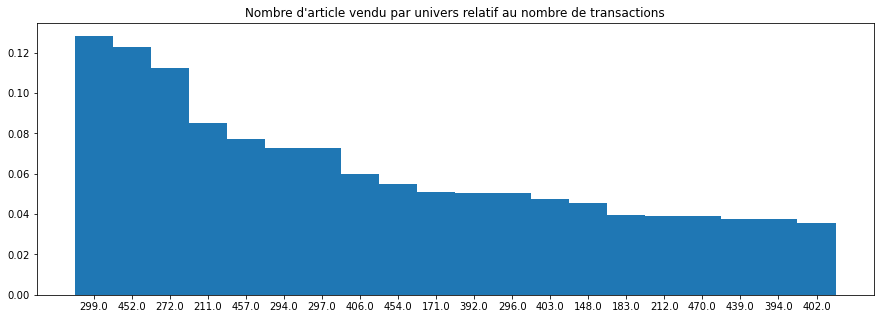

0.0024937655860349127
Time Taken to run Apriori Algorithm : ~1secondes


Rule :  {13.0, 183.0} -> {452.0} (conf: 0.348, supp: 0.003, lift: 2.829, conv: 1.345)
 Univ_KEY           Univ_1        Univ_2         Univ_3  Univ_4
       13  PRET A CUISINER 4 ET 5  GAMME        SALADES SALADES
      183 FRUITS   LEGUMES       LEGUMES AUTRES LEGUMES  FRUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {171.0, 183.0} -> {452.0} (conf: 0.351, supp: 0.003, lift: 2.854, conv: 1.352)
 Univ_KEY           Univ_1  Univ_2         Univ_3   Univ_4
      171 FRUITS   LEGUMES  FRUITS       EXOTIQUE EXOTIQUE
      183 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES   FRUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DE

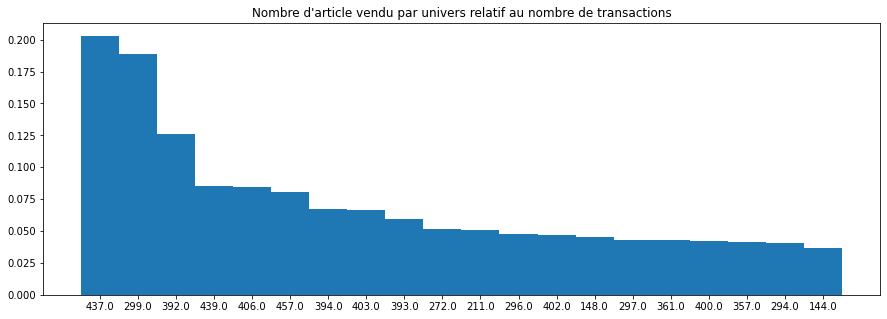

0.002777777777777778
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {277.0} -> {299.0} (conf: 0.358, supp: 0.003, lift: 1.894, conv: 1.263)
 Univ_KEY Univ_1 Univ_2 Univ_3 Univ_4
      277 DIVERS  BAZAR  BAZAR  BAZAR
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.368, supp: 0.075, lift: 1.949, conv: 1.284)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {299.0} -> {437.0} (conf: 0.395, supp: 0.075, lift: 1.949, conv: 1.318)
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES
->
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 P

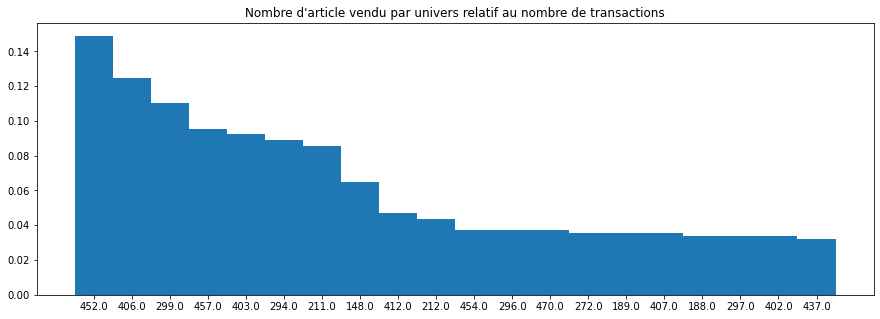

0.0044444444444444444
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {137.0} -> {452.0} (conf: 0.333, supp: 0.005, lift: 2.239, conv: 1.277)
 Univ_KEY  Univ_1        Univ_2        Univ_3 Univ_4
      137 DESSERT DESSERT FRAIS FROMAGE FRAIS FRUITS
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {287.0} -> {452.0} (conf: 0.333, supp: 0.005, lift: 2.239, conv: 1.277)
 Univ_KEY         Univ_1                  Univ_2   Univ_3   Univ_4
      287 PETIT DEJEUNER TARTINABLES ET CEREALES CEREALES CEREALES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {441.0} -> {452.0} (conf: 0.333, supp: 0.008, lift: 2.239, conv: 1.277)
 Univ_KEY    

 Univ_KEY   Univ_1 Univ_2 Univ_3 Univ_4
      258 BOISSONS   VINS ITALIE ITALIE
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {288.0} -> {452.0} (conf: 0.500, supp: 0.006, lift: 3.359, conv: 1.702)
 Univ_KEY         Univ_1                  Univ_2     Univ_3     Univ_4
      288 PETIT DEJEUNER TARTINABLES ET CEREALES CONFITURES CONFITURES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {225.0} -> {299.0} (conf: 0.375, supp: 0.005, lift: 3.408, conv: 1.424)
 Univ_KEY   Univ_1    Univ_2 Univ_3       Univ_4
      225 BOISSONS SMOOTHIES FRUITS JUS FRAIS 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT D

 Univ_KEY        Univ_1         Univ_2              Univ_3             Univ_4
      417 PRET A MANGER PLATS PREPARES COMPOSANTS DE REPAS FECULENTS  LEGUMES
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {61.0, 452.0} -> {406.0} (conf: 0.600, supp: 0.005, lift: 4.816, conv: 2.189)
 Univ_KEY          Univ_1                       Univ_2                       Univ_3                       Univ_4
       61 PRET A CUISINER                  CHARCUTERIE                      JAMBONS                 JAMBONS CRUS
      452        ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {299.0, 452.0, 457.0} -> {406.0} (conf: 0.600, supp: 0.005, lift: 4.816, conv: 2.189)
 Univ_KEY         Univ_1                       

 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {183.0, 331.0} -> {452.0} (conf: 1.000, supp: 0.005, lift: 6.717, conv: 851132686.084)
 Univ_KEY                     Univ_1  Univ_2         Univ_3 Univ_4
      183           FRUITS   LEGUMES LEGUMES AUTRES LEGUMES FRUITS
      331 APERITIF   ENTREES   TAPAS   TAPAS         OLIVES OLIVES
->
 Univ_KEY   Univ_1                       Univ_2                       Univ_3                       Univ_4
      452 ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE


Rule :  {220.0, 406.0} -> {452.0} (conf: 1.000, supp: 0.005, lift: 6.717, conv: 851132686.084)
 Univ_KEY        Univ_1         Univ_2               Univ_3               Univ_4
      220      BOISSONS       JUS SECS JUS DE FRUITS SEC 1P JUS DE FRUITS SEC 1P
      406 PRET A

 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {61.0, 406.0, 407.0} -> {457.0} (conf: 1.000, supp: 0.005, lift: 10.475, conv: 904530744.337)
 Univ_KEY          Univ_1         Univ_2       Univ_3         Univ_4
       61 PRET A CUISINER    CHARCUTERIE      JAMBONS   JAMBONS CRUS
      406   PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
      407   PRET A MANGER PLATS PREPARES  INDIAN FOOD    INDIAN FOOD
->
 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSONS SOFT DRINKS   SODA  COLAS


Rule :  {263.0, 406.0, 407.0} -> {457.0} (conf: 1.000, supp: 0.005, lift: 10.475, conv: 904530744.337)
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      263      BOISSONS           VINS          USA            USA
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
      407 PRET A MANGER PLATS PREPARES  INDIAN FOOD    INDIAN FOOD
->
 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      457 BOISSO

 Univ_KEY        Univ_1         Univ_2      Univ_3      Univ_4
      407 PRET A MANGER PLATS PREPARES INDIAN FOOD INDIAN FOOD


Rule :  {61.0, 263.0, 406.0, 457.0} -> {407.0} (conf: 1.000, supp: 0.005, lift: 28.091, conv: 964401294.498)
 Univ_KEY          Univ_1         Univ_2       Univ_3         Univ_4
       61 PRET A CUISINER    CHARCUTERIE      JAMBONS   JAMBONS CRUS
      263        BOISSONS           VINS          USA            USA
      406   PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
      457        BOISSONS    SOFT DRINKS         SODA          COLAS
->
 Univ_KEY        Univ_1         Univ_2      Univ_3      Univ_4
      407 PRET A MANGER PLATS PREPARES INDIAN FOOD INDIAN FOOD


Rule :  {215.0} -> {341.0} (conf: 0.500, supp: 0.005, lift: 30.900, conv: 1.968)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      215 BOISSONS JUS FRAIS JUS DE FRUITS JUS FRAIS >1P
->
 Univ_KEY                     Univ_1      Univ_2         Univ_3         Univ_4
      341 

 Univ_KEY   Univ_1      Univ_2 Univ_3 Univ_4
      263 BOISSONS        VINS    USA    USA
      457 BOISSONS SOFT DRINKS   SODA  COLAS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
      407 PRET A MANGER PLATS PREPARES  INDIAN FOOD    INDIAN FOOD


Rule :  {61.0, 263.0, 457.0} -> {406.0, 407.0} (conf: 1.000, supp: 0.005, lift: 88.286, conv: 988673139.159)
 Univ_KEY          Univ_1      Univ_2  Univ_3       Univ_4
       61 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CRUS
      263        BOISSONS        VINS     USA          USA
      457        BOISSONS SOFT DRINKS    SODA        COLAS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
      407 PRET A MANGER PLATS PREPARES  INDIAN FOOD    INDIAN FOOD


Rule :  {406.0, 407.0} -> {61.0, 263.0, 457.0} (conf: 0.429, supp: 0.005, lift: 88.286, conv: 1.742)
 Univ_K

 Univ_KEY          Univ_1      Univ_2  Univ_3       Univ_4
       61 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CRUS
      263        BOISSONS        VINS     USA          USA
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS
      407 PRET A MANGER PLATS PREPARES  INDIAN FOOD    INDIAN FOOD
      457      BOISSONS    SOFT DRINKS         SODA          COLAS


Rule :  {61.0, 407.0} -> {263.0} (conf: 1.000, supp: 0.005, lift: 206.000, conv: 995145631.068)
 Univ_KEY          Univ_1         Univ_2      Univ_3       Univ_4
       61 PRET A CUISINER    CHARCUTERIE     JAMBONS JAMBONS CRUS
      407   PRET A MANGER PLATS PREPARES INDIAN FOOD  INDIAN FOOD
->
 Univ_KEY   Univ_1 Univ_2 Univ_3 Univ_4
      263 BOISSONS   VINS    USA    USA


Rule :  {263.0} -> {61.0, 407.0} (conf: 1.000, supp: 0.005, lift: 206.000, conv: 995145631.068)
 Univ_KEY   Univ_1 Univ_2 Univ_3 Univ_4
      263 BOISSONS   VINS    USA   

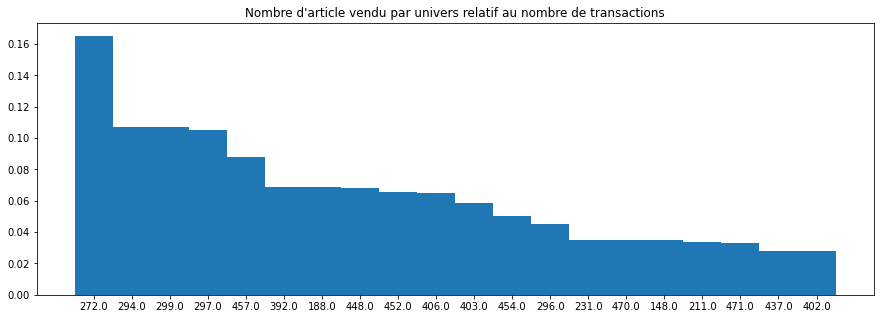

0.002777777777777778
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {271.0} -> {272.0} (conf: 0.407, supp: 0.006, lift: 2.462, conv: 1.407)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {52.0} -> {294.0} (conf: 0.361, supp: 0.004, lift: 3.370, conv: 1.397)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {439.0} -> {299.0} (conf: 0.396, supp: 0.009, lift: 3.707, conv: 1.479)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS

79474
Time Taken to load recurence: ~0secondes


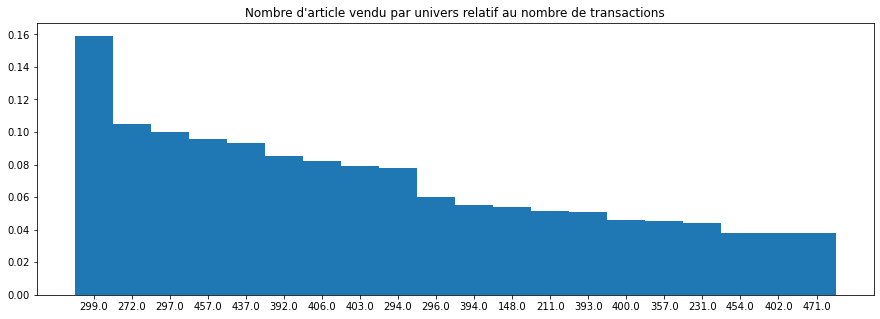

0.002551020408163265
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {299.0} (conf: 0.359, supp: 0.007, lift: 2.260, conv: 1.313)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.360, supp: 0.034, lift: 2.264, conv: 1.314)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {439.0} -> {299.0} (conf: 0.513, supp: 0.019, lift: 3.228, conv: 1.728)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         Univ_1       Univ_2        Un

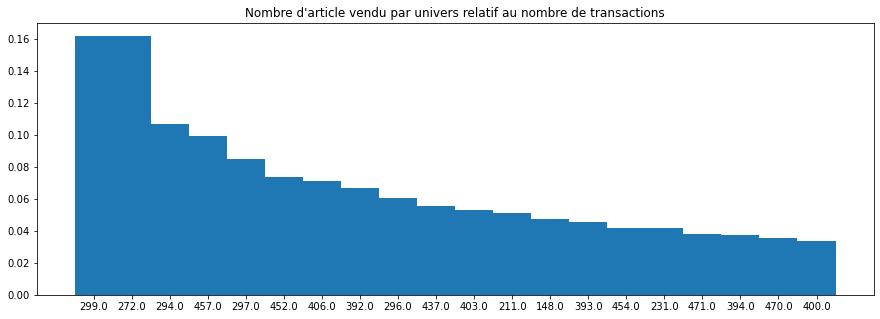

0.002544529262086514
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {299.0} (conf: 0.379, supp: 0.006, lift: 2.341, conv: 1.350)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.399, supp: 0.022, lift: 2.463, conv: 1.395)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {438.0} -> {299.0} (conf: 0.442, supp: 0.003, lift: 2.727, conv: 1.501)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2      

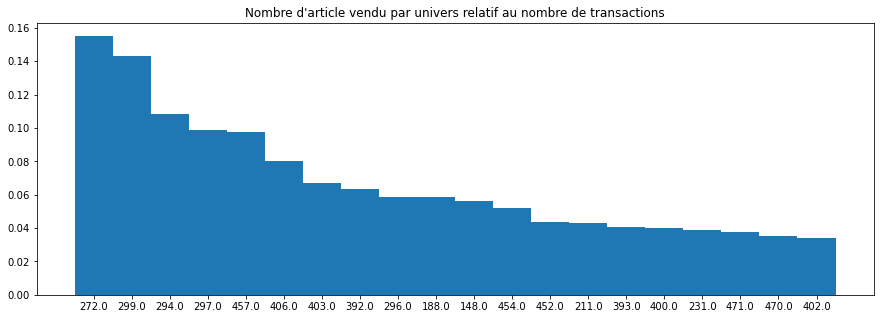

0.002551020408163265
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {437.0} -> {299.0} (conf: 0.401, supp: 0.013, lift: 2.805, conv: 1.430)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {271.0} -> {272.0} (conf: 0.468, supp: 0.003, lift: 3.017, conv: 1.588)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {198.0} -> {299.0} (conf: 0.445, supp: 0.009, lift: 3.112, conv: 1.543)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNE

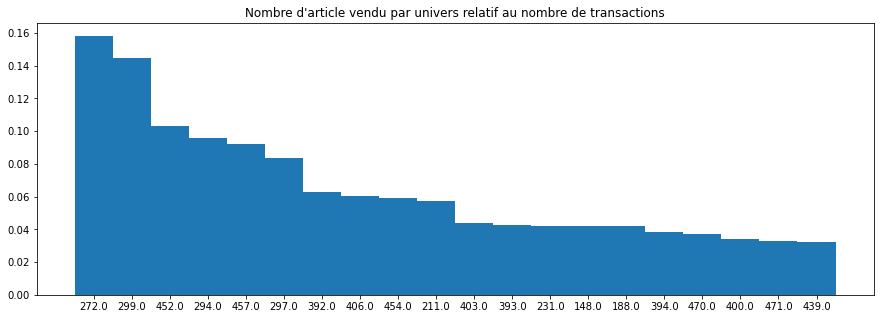

0.0025252525252525255
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {301.0} -> {299.0} (conf: 0.415, supp: 0.003, lift: 2.865, conv: 1.461)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.423, supp: 0.010, lift: 2.921, conv: 1.481)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {439.0} -> {299.0} (conf: 0.433, supp: 0.014, lift: 2.991, conv: 1.508)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         

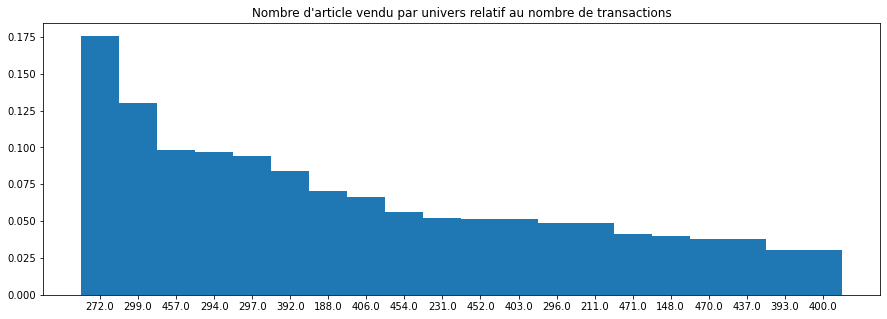

0.0026041666666666665
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {271.0} -> {272.0} (conf: 0.490, supp: 0.006, lift: 2.790, conv: 1.617)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {437.0} -> {299.0} (conf: 0.390, supp: 0.015, lift: 3.000, conv: 1.426)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301.0} -> {299.0} (conf: 0.427, supp: 0.003, lift: 3.281, conv: 1.517)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      30

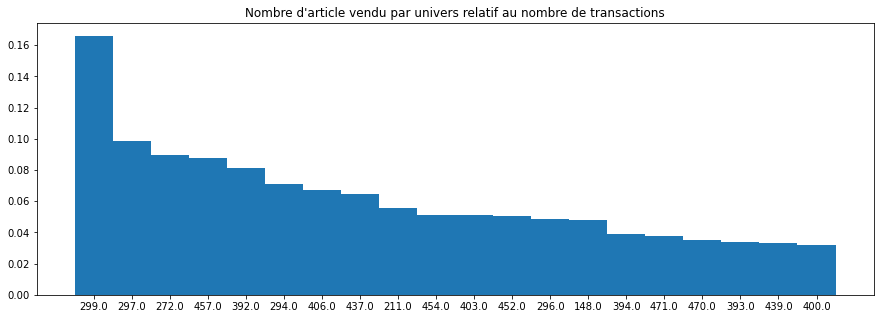

0.002531645569620253
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {299.0} (conf: 0.360, supp: 0.005, lift: 2.170, conv: 1.303)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.370, supp: 0.024, lift: 2.233, conv: 1.325)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {438.0} -> {299.0} (conf: 0.389, supp: 0.003, lift: 2.347, conv: 1.366)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2      

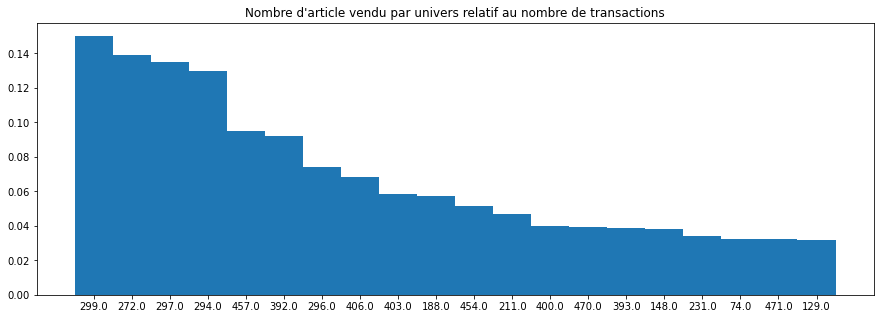

0.0026595744680851063
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {220.0} -> {299.0} (conf: 0.374, supp: 0.004, lift: 2.489, conv: 1.357)
 Univ_KEY   Univ_1   Univ_2               Univ_3               Univ_4
      220 BOISSONS JUS SECS JUS DE FRUITS SEC 1P JUS DE FRUITS SEC 1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {198.0} -> {299.0} (conf: 0.377, supp: 0.004, lift: 2.509, conv: 1.363)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {475.0} -> {297.0} (conf: 0.366, supp: 0.007, lift: 2.714, conv: 1.365)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1              

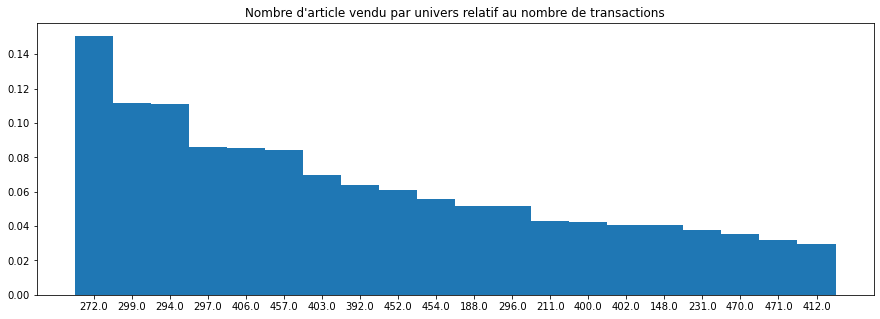

0.002570694087403599
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {271.0} -> {272.0} (conf: 0.475, supp: 0.003, lift: 3.153, conv: 1.618)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {52.0} -> {294.0} (conf: 0.390, supp: 0.004, lift: 3.520, conv: 1.458)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMAGE PATE MOLLE PATE MOLLE
->
 Univ_KEY         Univ_1                       Univ_2    Univ_3    Univ_4
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES BAGUETTES


Rule :  {437.0} -> {299.0} (conf: 0.393, supp: 0.005, lift: 3.526, conv: 1.463)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNE

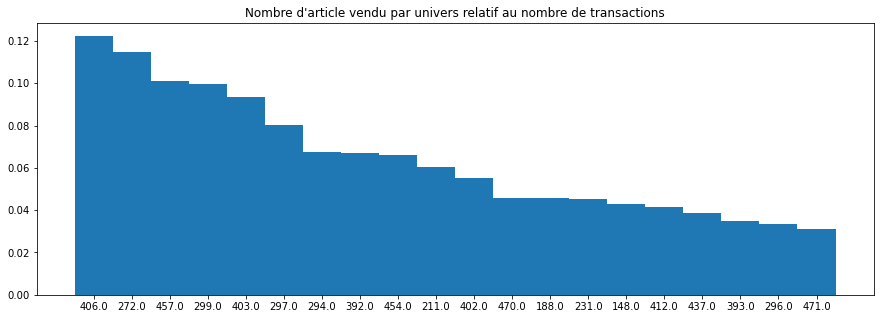

0.0026595744680851063
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {403.0, 457.0} -> {406.0} (conf: 0.374, supp: 0.003, lift: 3.054, conv: 1.401)
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION
      457      BOISSONS    SOFT DRINKS           SODA           COLAS
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {402.0, 403.0} -> {406.0} (conf: 0.411, supp: 0.004, lift: 3.359, conv: 1.490)
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      402 PRET A MANGER PLATS PREPARES   CHINESE FOOD    CHINESE FOOD
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {297.0, 403.0} -> {406.0} (conf: 0.412, supp: 0

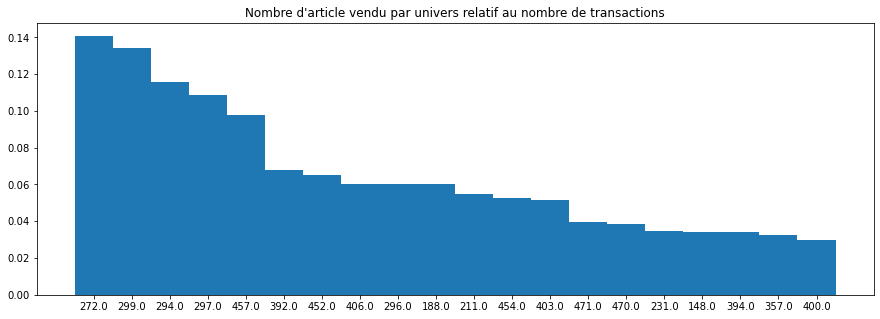

0.002551020408163265
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {271.0} -> {272.0} (conf: 0.422, supp: 0.005, lift: 2.996, conv: 1.486)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {437.0} -> {299.0} (conf: 0.413, supp: 0.009, lift: 3.079, conv: 1.475)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {52.0} -> {294.0} (conf: 0.422, supp: 0.005, lift: 3.646, conv: 1.531)
 Univ_KEY          Univ_1  Univ_2     Univ_3     Univ_4
       52 PRET A CUISINER FROMA

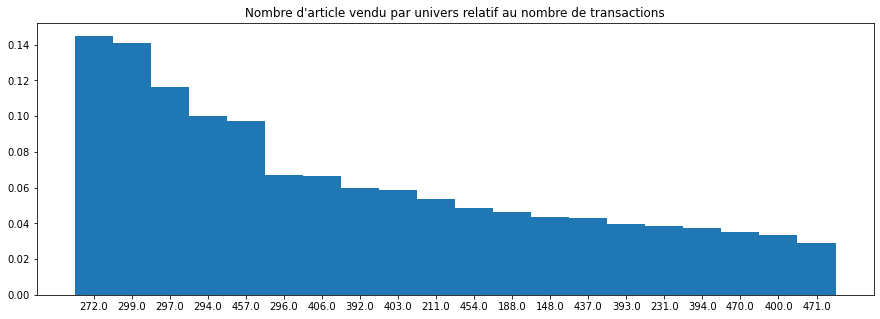

0.00267379679144385
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {437.0} -> {299.0} (conf: 0.425, supp: 0.018, lift: 3.017, conv: 1.495)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {271.0} -> {272.0} (conf: 0.447, supp: 0.005, lift: 3.082, conv: 1.545)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {438.0} -> {299.0} (conf: 0.520, supp: 0.003, lift: 3.688, conv: 1.789)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX J

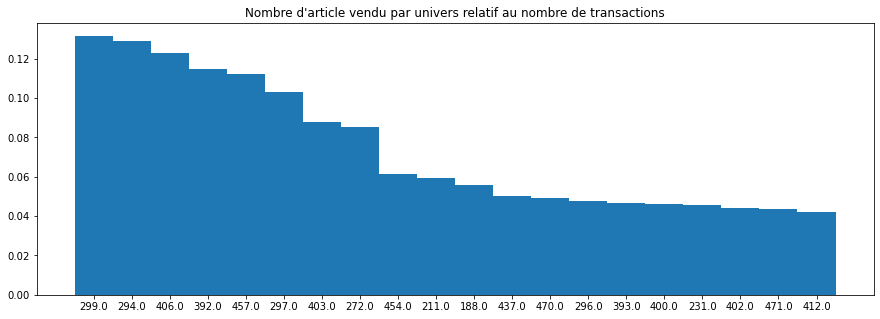

0.002631578947368421
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {299.0} (conf: 0.337, supp: 0.005, lift: 2.561, conv: 1.310)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {297.0, 403.0} -> {406.0} (conf: 0.333, supp: 0.003, lift: 2.715, conv: 1.316)
 Univ_KEY         Univ_1                       Univ_2         Univ_3          Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          PAINS           PAINS
      403  PRET A MANGER               PLATS PREPARES TRADITION FOOD PLATS TRADITION
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {294.0, 403.0} -> {406.0} (conf: 0.343, supp: 0.003, lift: 2.797, conv: 1.336)
 Univ_KEY        

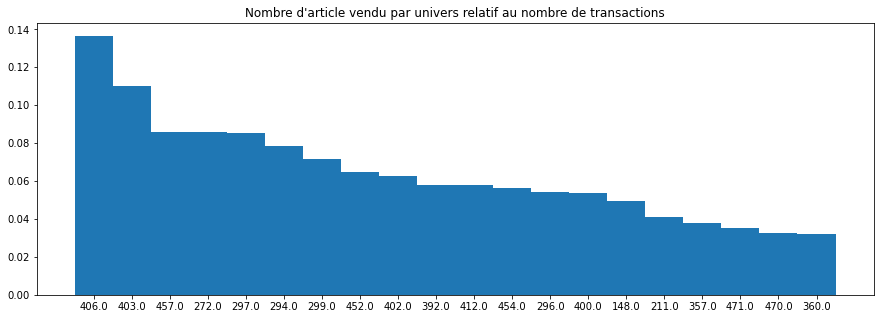

0.0027548209366391185
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {412.0, 452.0} -> {406.0} (conf: 0.359, supp: 0.003, lift: 2.630, conv: 1.347)
 Univ_KEY        Univ_1                       Univ_2                       Univ_3                       Univ_4
      412 PRET A MANGER               PLATS PREPARES                    THAI FOOD                    THAI FOOD
      452      ECONOMAT ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE ARTICLES DESTINES A LA VENTE
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
      406 PRET A MANGER PLATS PREPARES ITALIAN FOOD PLATS ITALIENS


Rule :  {402.0, 403.0} -> {406.0} (conf: 0.371, supp: 0.004, lift: 2.720, conv: 1.374)
 Univ_KEY        Univ_1         Univ_2         Univ_3          Univ_4
      402 PRET A MANGER PLATS PREPARES   CHINESE FOOD    CHINESE FOOD
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD PLATS TRADITION
->
 Univ_KEY        Univ_1         Univ_2       Univ_3         Univ_4
 

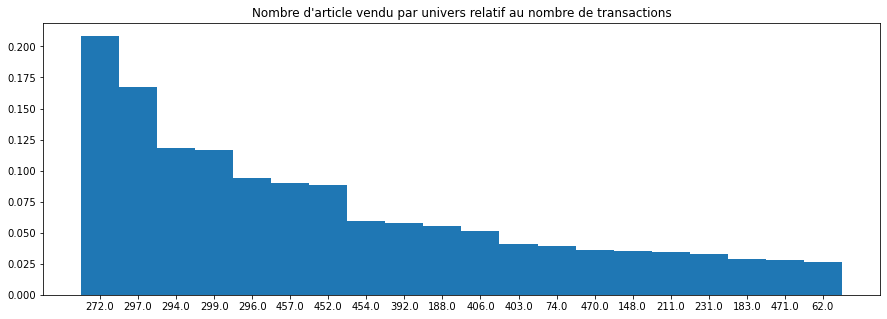

0.002506265664160401
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {62.0} -> {297.0} (conf: 0.336, supp: 0.009, lift: 2.007, conv: 1.254)
 Univ_KEY          Univ_1      Univ_2  Univ_3        Univ_4
       62 PRET A CUISINER CHARCUTERIE JAMBONS JAMBONS CUITS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {462.0} -> {297.0} (conf: 0.339, supp: 0.003, lift: 2.022, conv: 1.259)
 Univ_KEY          Univ_1  Univ_2    Univ_3 Univ_4
      462 PRET A CUISINER FROMAGE PATE DURE   BLOC
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {296.0, 299.0} -> {297.0} (conf: 0.340, supp: 0.006, lift: 2.030, conv: 1.262)
 Univ_KEY         Univ_1                       Univ_2        Univ_3        Univ_4
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    MINI PAINS    MINI PAINS
      299 PETI

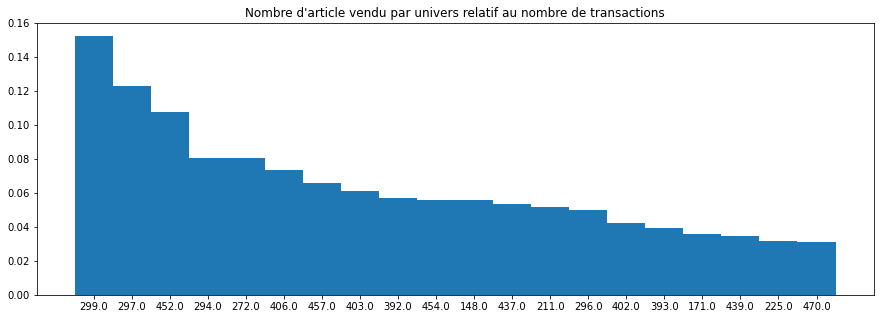

0.0026666666666666666
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {437.0} -> {299.0} (conf: 0.378, supp: 0.020, lift: 2.478, conv: 1.362)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {198.0} -> {299.0} (conf: 0.396, supp: 0.005, lift: 2.597, conv: 1.403)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {475.0} -> {297.0} (conf: 0.362, supp: 0.006, lift: 2.938, conv: 1.374)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1                       Uni

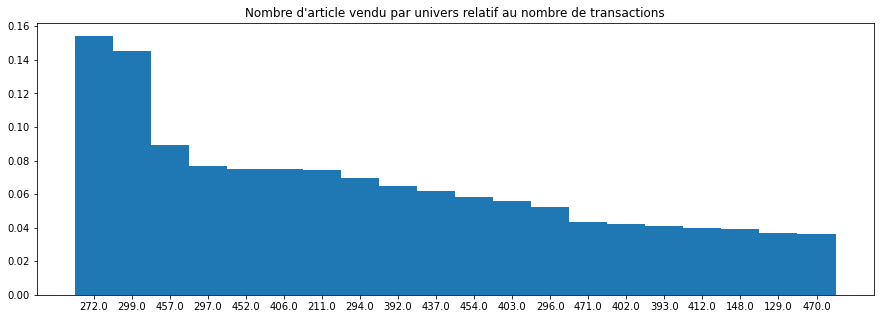

0.002564102564102564
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {438.0} -> {299.0} (conf: 0.350, supp: 0.003, lift: 2.410, conv: 1.315)
 Univ_KEY   Univ_1    Univ_2        Univ_3        Univ_4
      438 BOISSONS JUS ZUMEX JUS ZUMEX >1P JUS ZUMEX >1P
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {437.0} -> {299.0} (conf: 0.351, supp: 0.022, lift: 2.419, conv: 1.318)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {198.0} -> {299.0} (conf: 0.366, supp: 0.005, lift: 2.518, conv: 1.348)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2      

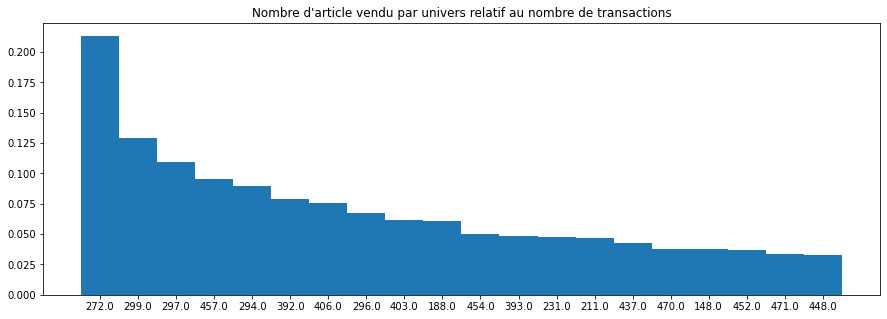

0.002577319587628866
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {198.0} -> {299.0} (conf: 0.336, supp: 0.004, lift: 2.596, conv: 1.311)
 Univ_KEY         Univ_1          Univ_2     Univ_3     Univ_4
      198 PETIT DEJEUNER CAFE THE SUCRES CAFE FROID CAFE FROID
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {271.0} -> {272.0} (conf: 0.569, supp: 0.010, lift: 2.668, conv: 1.825)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {301.0} -> {299.0} (conf: 0.500, supp: 0.003, lift: 3.868, conv: 1.741)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 P

59587
Time Taken to load recurence: ~0secondes


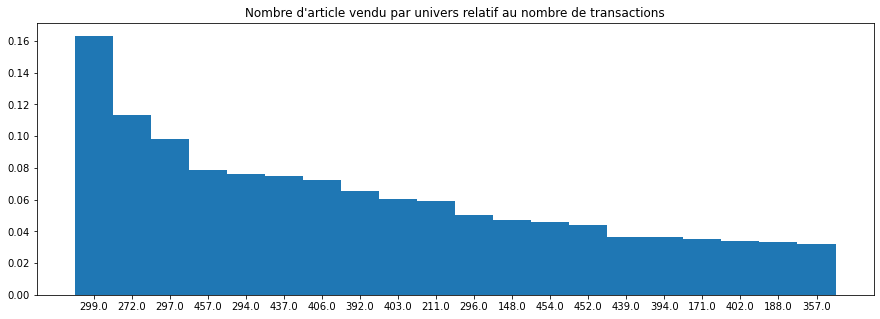

0.0026041666666666665
Time Taken to run Apriori Algorithm : ~0secondes


Rule :  {437.0} -> {299.0} (conf: 0.403, supp: 0.030, lift: 2.470, conv: 1.402)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301.0} -> {299.0} (conf: 0.454, supp: 0.003, lift: 2.783, conv: 1.533)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {439.0} -> {299.0} (conf: 0.525, supp: 0.019, lift: 3.217, conv: 1.761)
 Univ_KEY   Univ_1    Univ_2       Univ_3       Univ_4
      439 BOISSONS JUS ZUMEX JUS ZUMEX 1P JUS ZUMEX 1P
->
 Univ_KEY         

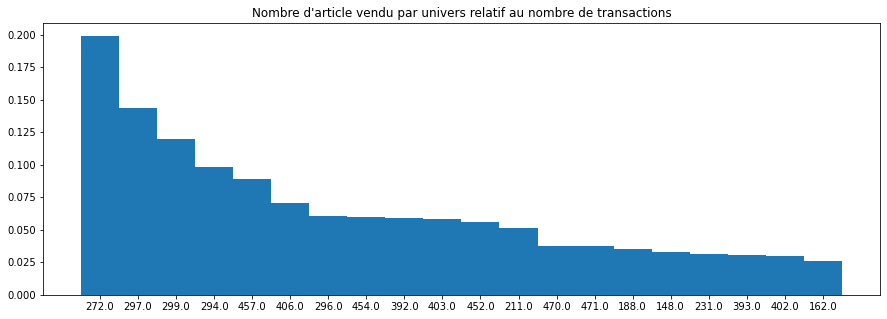

0.0025188916876574307
Time Taken to run Apriori Algorithm : ~1secondes


Rule :  {68.0} -> {297.0} (conf: 0.346, supp: 0.003, lift: 2.410, conv: 1.309)
 Univ_KEY          Univ_1      Univ_2  Univ_3  Univ_4
       68 PRET A CUISINER CHARCUTERIE SALAMIS SALAMIS
->
 Univ_KEY         Univ_1                       Univ_2 Univ_3 Univ_4
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS  PAINS


Rule :  {271.0} -> {272.0} (conf: 0.516, supp: 0.007, lift: 2.595, conv: 1.656)
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      271 TABACS   PRESSE TABAC   ACCESSOIRE TABAC   ACCESSOIRE TABAC   ACCESSOIRE
->
 Univ_KEY          Univ_1             Univ_2             Univ_3             Univ_4
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES TABAC   CIGARETTES


Rule :  {475.0} -> {297.0} (conf: 0.382, supp: 0.008, lift: 2.665, conv: 1.386)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANC

In [15]:
if do_shop:
    for mag_key in all_mag_key:
        start    = time()
        print("-------------------" + all_mag_lib[mag_key] + "--------------------------")
        mag_tran = all_mag_tra[mag_key]

        _, mag_nbr_univ = load_recurence(mag_tran)
        mag_rules = get_rules(mag_tran, min_support, min_confidence, mag_nbr_univ)
        print_rules(mag_rules, Univers_Depth, conn)

In [16]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~718secondes


## Isolation du tabacs dans les transactions

In [17]:
start = time()

tabac_key = 272
accessoire_tabac_key = 271

all_univ = set()
tabac_transactions  = []
actual_key_ticket = -1

CA_tabac = 0
CA = 0

for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    rec_lig  = item[2]
    if actual_key_ticket != key_tic:
        if actual_key_ticket!= -1 and tabac_key in l:
            tabac_transactions.append(tuple(l))
            CA += rec_ticket
        actual_key_ticket = key_tic
        l = []
        rec_ticket = 0
        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
    l.append(int(key_univ))
    if key_univ != tabac_key and key_univ != accessoire_tabac_key:
        rec_ticket += rec_lig
    else:
        CA_tabac += rec_lig
    
    all_univ.add(int(key_univ))

if tabac_key in l:
    tabac_transactions.append(tuple(l))
    CA += rec_ticket   
    
print(tabac_transactions[:20])
print(len(tabac_transactions))
# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes") 

[(272,), (272, 297), (272,), (188, 272), (319, 272, 272, 471), (272, 232, 212, 236), (272, 272, 272, 272), (272, 272), (272,), (272, 154, 457), (62, 457, 272, 297, 297, 297, 392, 116, 129, 452), (272, 114), (475, 157, 272), (272,), (272, 457), (28, 272, 98, 416), (192, 473, 52, 272, 473, 111, 462), (272, 275), (472, 272), (272, 247)]
548028
Time Taken to load transaction: ~22secondes


548028
Time Taken to load recurence: ~1secondes


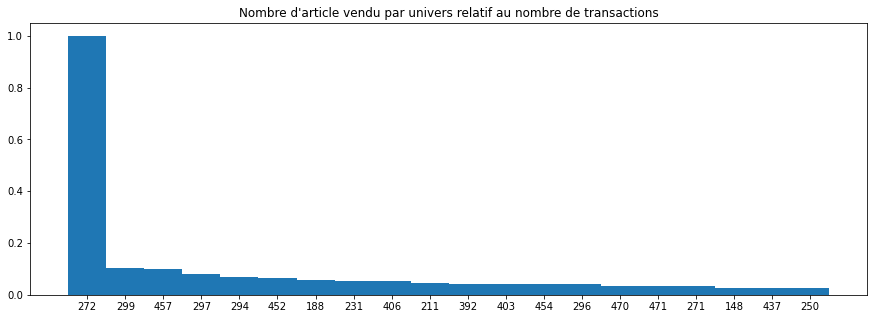

0.0024509803921568627
Time Taken to run Apriori Algorithm : ~4secondes


Rule :  {437} -> {299} (conf: 0.354, supp: 0.010, lift: 3.370, conv: 1.385)
 Univ_KEY         Univ_1       Univ_2       Univ_3       Univ_4
      437 PETIT DEJEUNER CAFE SERVICE CAFE SERVICE CAFE SERVICE
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {301} -> {299} (conf: 0.441, supp: 0.002, lift: 4.200, conv: 1.601)
 Univ_KEY         Univ_1            Univ_2           Univ_3           Univ_4
      301 PETIT DEJEUNER PRODUITS LAITIERS LAITS CHOCOLATES LAITS CHOCOLATES
->
 Univ_KEY         Univ_1       Univ_2        Univ_3        Univ_4
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES VIENNOISERIES


Rule :  {475} -> {297} (conf: 0.344, supp: 0.005, lift: 4.338, conv: 1.404)
 Univ_KEY          Univ_1  Univ_2    Univ_3   Univ_4
      475 PRET A CUISINER FROMAGE PATE DURE TRANCHES
->
 Univ_KEY         Univ_1          

In [18]:
_, tabac_nbr_univ = load_recurence(tabac_transactions)
tabac_rules = get_rules(tabac_transactions, min_support, min_confidence, tabac_nbr_univ)
print_rules(tabac_rules, Univers_Depth, conn, removed_key = tabac_key)

In [19]:
def get_nbr_sans_univ(transactions, univ_keys):
    nbr_article_sans_univ = [0 for _ in range(len(transactions))]
    nbr_article_univ      = [0 for _ in range(len(transactions))]
    
    for i in range(len(transactions)):
        for item in transactions[i]:
            if not item in univ_keys:
                nbr_article_sans_univ[i] += 1
            else:
                nbr_article_univ[i] += 1
    return nbr_article_sans_univ, nbr_article_univ
                
nbr_article_sans_tabac, _ = get_nbr_sans_univ(tabac_transactions, [tabac_key])
nbr_article_sans_tabac_et_derive, _ = get_nbr_sans_univ(tabac_transactions, [tabac_key,accessoire_tabac_key])

In [20]:
print("Proportion d'achat de tabacs :", end = ' ')
print(round(len(tabac_transactions)*100/len(transactions),2), '%')
print("Nombre moyen d'achat en plus du tabacs:", end = ' ')
print(round(sum(nbr_article_sans_tabac)/len(tabac_transactions), 2))
print("Proportion d'achat de tabacs seul:", end = ' ')
print(round(sum([1 if t == 0 else 0 for t in nbr_article_sans_tabac])*100/len(tabac_transactions), 2), '%')
print("Nombre moyen d'achat en plus du tabacs & dérivés:", end = ' ')
print(round(sum(nbr_article_sans_tabac_et_derive)/len(tabac_transactions), 2))
print("Proportion d'achat de tabacs & dérivé seul:", end = ' ')
print(round(sum([1 if t == 0 else 0 for t in nbr_article_sans_tabac_et_derive])*100/len(tabac_transactions), 2), '%')

Proportion d'achat de tabacs : 14.44 %
Nombre moyen d'achat en plus du tabacs: 2.99
Proportion d'achat de tabacs seul: 26.44 %
Nombre moyen d'achat en plus du tabacs & dérivés: 2.95
Proportion d'achat de tabacs & dérivé seul: 27.43 %


In [21]:
print(round(CA,2))
print(round(CA/len(tabac_transactions),2))
print(round(CA/sum(nbr_article_sans_tabac),2))
print(round(CA_tabac,2))
print(round(CA_tabac/(len(tabac_transactions)),2))

5459598.59
9.96
3.33
5043418.05
9.2


In [22]:
start = time()

univ_transactions = {i:[] for i in all_univ}
univ_CA           = {i:0  for i in all_univ}
univ_CA_sans_univ = {i:0  for i in all_univ}

actual_key_ticket = -1        
art_trans  = []
CA_trans   = {}
for item in df_art_ticket.values:
    key_univ = item[0]
    key_tic  = item[1]
    rec_lig  = item[2]

    if actual_key_ticket != key_tic:  
        for k in CA_trans.keys():
            univ_transactions[k].append(tuple(art_trans))
            univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]
            
        actual_key_ticket = key_tic
        art_trans  = []
        CA_trans   = {}

        
    if key_univ in deleted:
        key_univ = univers_correspondance[key_univ]
        
    art_trans.append(int(key_univ))
    if not key_univ in CA_trans.keys():
        CA_trans[key_univ] = 0
    CA_trans[key_univ] += rec_lig
    univ_CA[key_univ] += rec_lig

    
for k in CA_trans.keys():
    univ_transactions[k].append(tuple(art_trans))
    univ_CA_sans_univ[k] += sum(CA_trans.values()) - CA_trans[k]

# environ 10s * #tickets / 2.000.000.
print("Time Taken to load transaction: ~" + str(int(time() - start)) + "secondes")    

Time Taken to load transaction: ~49secondes


==============1===================
344
Time Taken to load recurence: ~0secondes


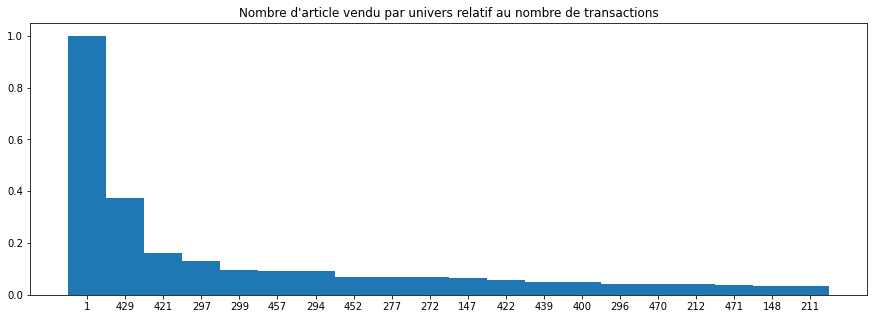

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 7.56)
("Nombre moyen d'univ", 1.49)
('CA univ', 15219.4)
('CA moyen univ', 44.24)
('Nombre moyen article en plus', 4.72)
('CA en plus', 19930.19)
('CA moyen en plus', 57.94)
==============2===================
490
Time Taken to load recurence: ~0secondes


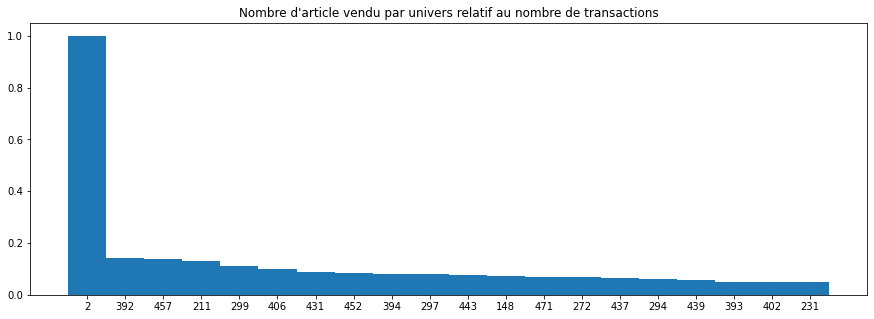

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 6.73)
("Nombre moyen d'univ", 1.18)
('CA univ', 2086.22)
('CA moyen univ', 4.26)
('Nombre moyen article en plus', 3.87)
('CA en plus', 5820.49)
('CA moyen en plus', 11.88)
==============4===================
1371
Time Taken to load recurence: ~0secondes


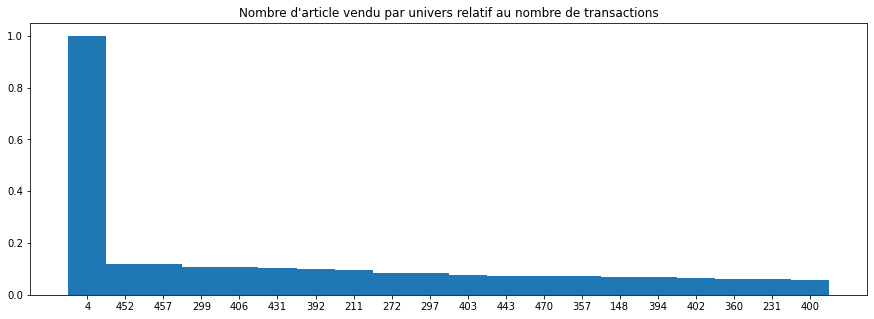

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 8.1)
("Nombre moyen d'univ", 1.13)
('CA univ', 6063.38)
('CA moyen univ', 4.42)
('Nombre moyen article en plus', 5.44)
('CA en plus', 21312.72)
('CA moyen en plus', 15.55)
==============5===================
557
Time Taken to load recurence: ~0secondes


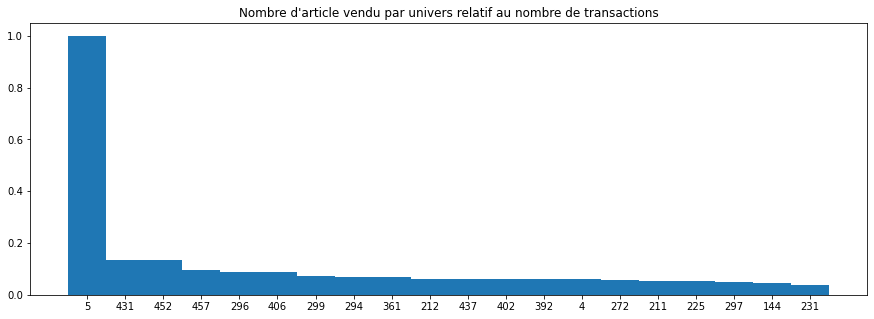

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 11.85)
("Nombre moyen d'univ", 1.74)
('CA univ', 3340.29)
('CA moyen univ', 6.0)
('Nombre moyen article en plus', 3.3)
('CA en plus', 6052.82)
('CA moyen en plus', 10.87)
==============7===================
NOT ENOUGH DATA 
==============9===================
15523
Time Taken to load recurence: ~0secondes


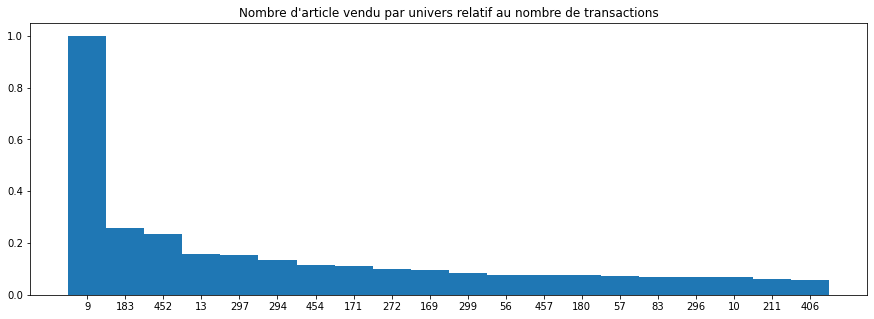

("Proportion d'achat (%)", 0.41)
('Proportion achat seul (%)', 5.34)
("Nombre moyen d'univ", 1.16)
('CA univ', 35999.54)
('CA moyen univ', 2.32)
('Nombre moyen article en plus', 8.15)
('CA en plus', 443768.09)
('CA moyen en plus', 28.59)
==============10===================
16988
Time Taken to load recurence: ~0secondes


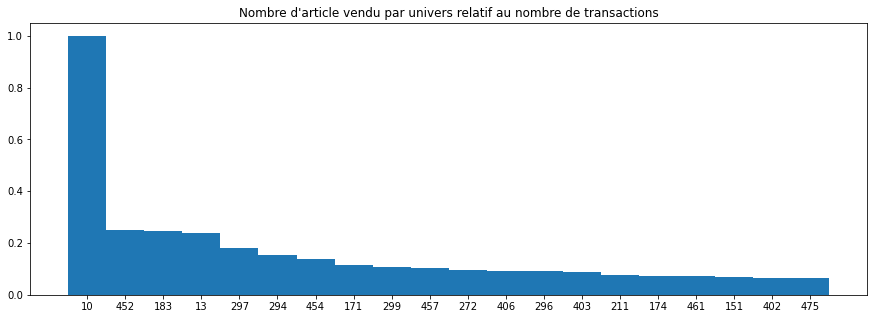

("Proportion d'achat (%)", 0.45)
('Proportion achat seul (%)', 1.46)
("Nombre moyen d'univ", 1.18)
('CA univ', 41855.02)
('CA moyen univ', 2.46)
('Nombre moyen article en plus', 8.95)
('CA en plus', 536611.47)
('CA moyen en plus', 31.59)
==============12===================
897
Time Taken to load recurence: ~0secondes


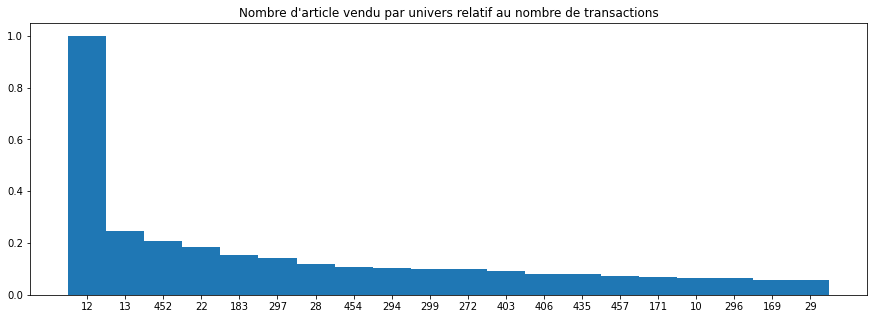

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 5.57)
("Nombre moyen d'univ", 1.18)
('CA univ', 3711.8)
('CA moyen univ', 4.14)
('Nombre moyen article en plus', 7.63)
('CA en plus', 26218.0)
('CA moyen en plus', 29.23)
==============13===================
80390
Time Taken to load recurence: ~0secondes


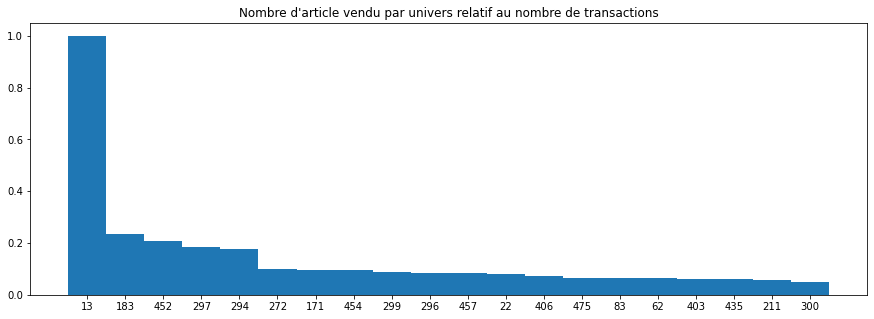

("Proportion d'achat (%)", 2.12)
('Proportion achat seul (%)', 4.58)
("Nombre moyen d'univ", 1.17)
('CA univ', 259225.98)
('CA moyen univ', 3.22)
('Nombre moyen article en plus', 7.17)
('CA en plus', 2068087.37)
('CA moyen en plus', 25.73)
==============14===================
NOT ENOUGH DATA 
==============16===================
3700
Time Taken to load recurence: ~0secondes


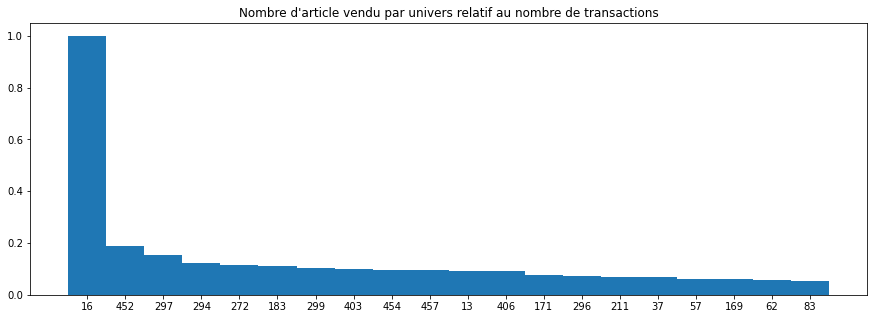

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 5.97)
("Nombre moyen d'univ", 1.18)
('CA univ', 10225.39)
('CA moyen univ', 2.76)
('Nombre moyen article en plus', 7.23)
('CA en plus', 97401.8)
('CA moyen en plus', 26.32)
==============17===================
4556
Time Taken to load recurence: ~0secondes


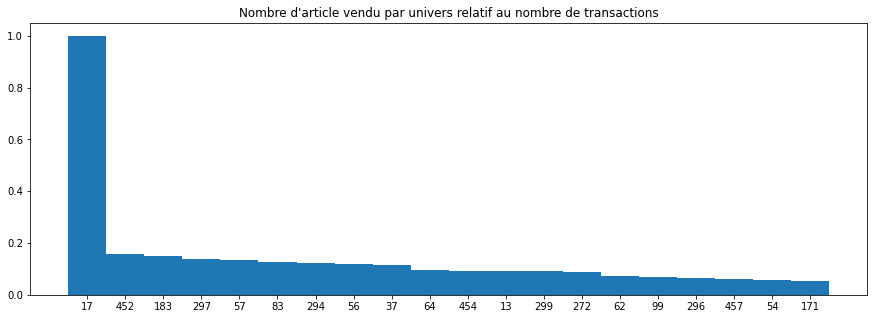

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 11.59)
("Nombre moyen d'univ", 1.27)
('CA univ', 14217.36)
('CA moyen univ', 3.12)
('Nombre moyen article en plus', 6.25)
('CA en plus', 125931.11)
('CA moyen en plus', 27.64)
==============18===================
42629
Time Taken to load recurence: ~0secondes


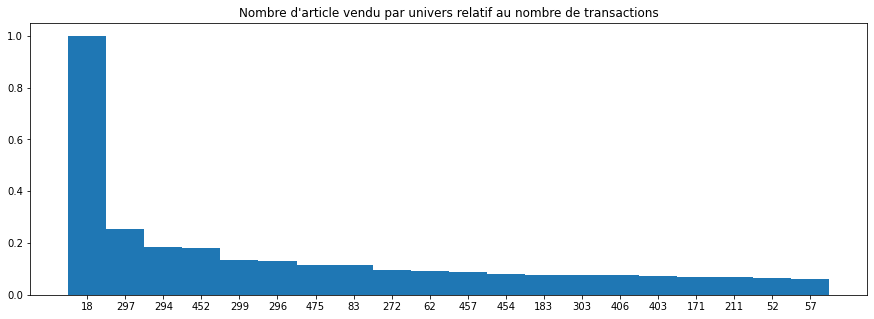

("Proportion d'achat (%)", 1.12)
('Proportion achat seul (%)', 6.14)
("Nombre moyen d'univ", 1.11)
('CA univ', 153982.42)
('CA moyen univ', 3.61)
('Nombre moyen article en plus', 7.42)
('CA en plus', 1075123.38)
('CA moyen en plus', 25.22)
==============19===================
11794
Time Taken to load recurence: ~0secondes


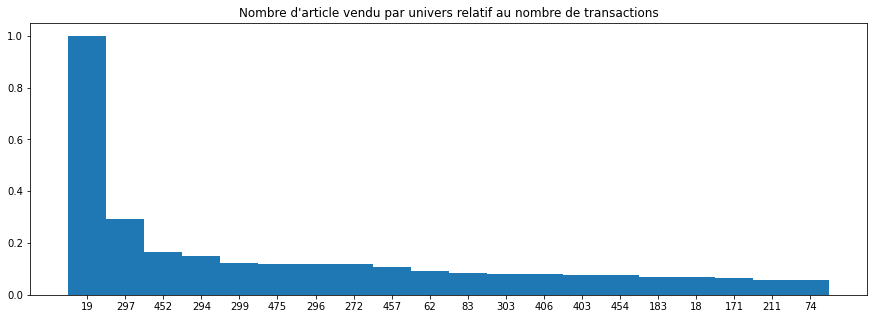

("Proportion d'achat (%)", 0.31)
('Proportion achat seul (%)', 6.89)
("Nombre moyen d'univ", 1.07)
('CA univ', 29176.92)
('CA moyen univ', 2.47)
('Nombre moyen article en plus', 6.92)
('CA en plus', 278490.87)
('CA moyen en plus', 23.61)
==============20===================
1174
Time Taken to load recurence: ~0secondes


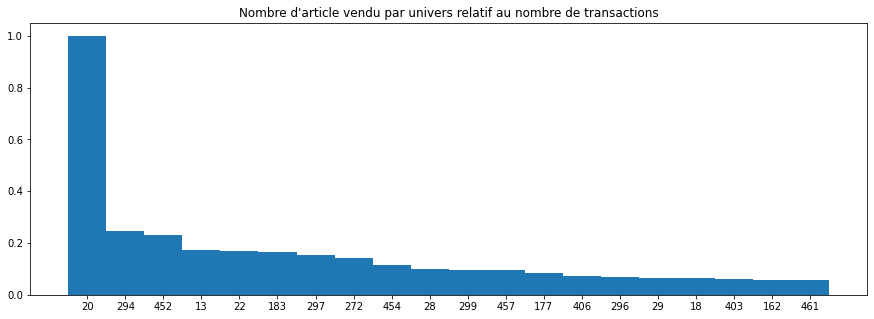

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 6.22)
("Nombre moyen d'univ", 1.11)
('CA univ', 3912.58)
('CA moyen univ', 3.33)
('Nombre moyen article en plus', 8.16)
('CA en plus', 37756.32)
('CA moyen en plus', 32.16)
==============21===================
733
Time Taken to load recurence: ~0secondes


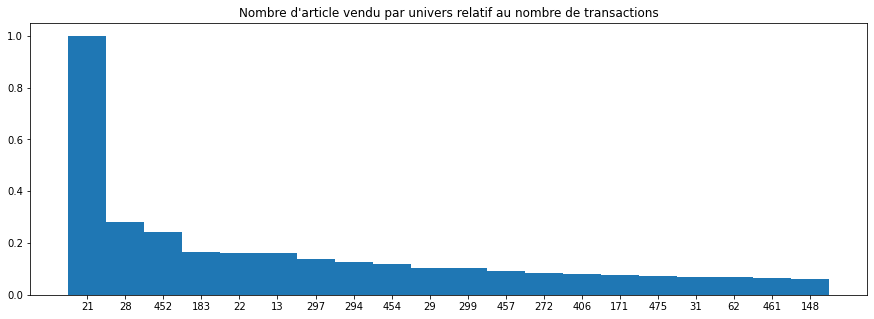

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 3.55)
("Nombre moyen d'univ", 1.36)
('CA univ', 6402.68)
('CA moyen univ', 8.73)
('Nombre moyen article en plus', 8.65)
('CA en plus', 24139.3)
('CA moyen en plus', 32.93)
==============22===================
51979
Time Taken to load recurence: ~0secondes


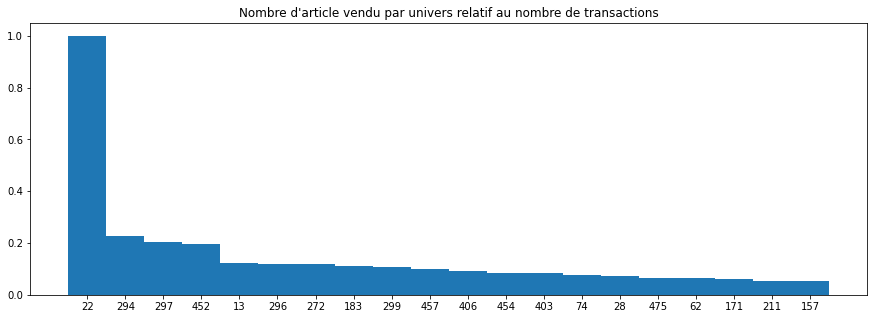

("Proportion d'achat (%)", 1.37)
('Proportion achat seul (%)', 3.84)
("Nombre moyen d'univ", 1.22)
('CA univ', 385591.89)
('CA moyen univ', 7.42)
('Nombre moyen article en plus', 7.22)
('CA en plus', 1323591.51)
('CA moyen en plus', 25.46)
==============23===================
1741
Time Taken to load recurence: ~0secondes


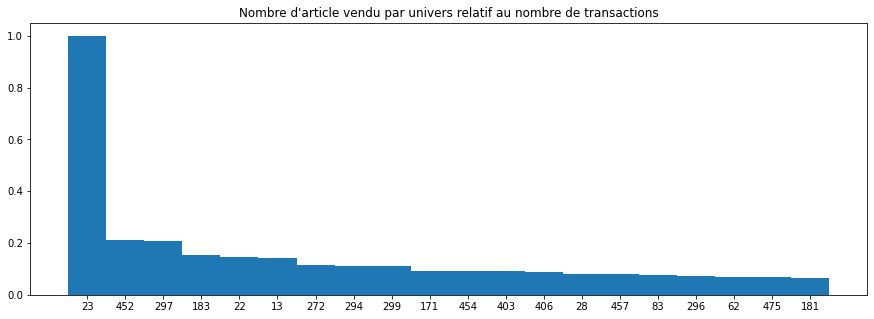

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 3.45)
("Nombre moyen d'univ", 1.11)
('CA univ', 16769.3)
('CA moyen univ', 9.63)
('Nombre moyen article en plus', 8.63)
('CA en plus', 55751.25)
('CA moyen en plus', 32.02)
==============24===================
4945
Time Taken to load recurence: ~0secondes


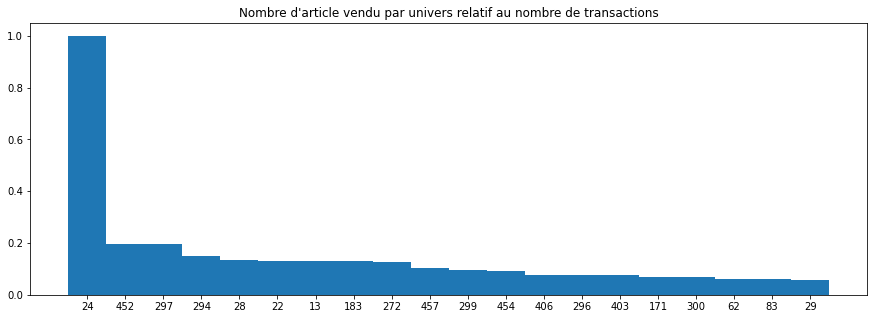

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 3.92)
("Nombre moyen d'univ", 1.14)
('CA univ', 26565.32)
('CA moyen univ', 5.37)
('Nombre moyen article en plus', 7.6)
('CA en plus', 134832.27)
('CA moyen en plus', 27.27)
==============25===================
9755
Time Taken to load recurence: ~0secondes


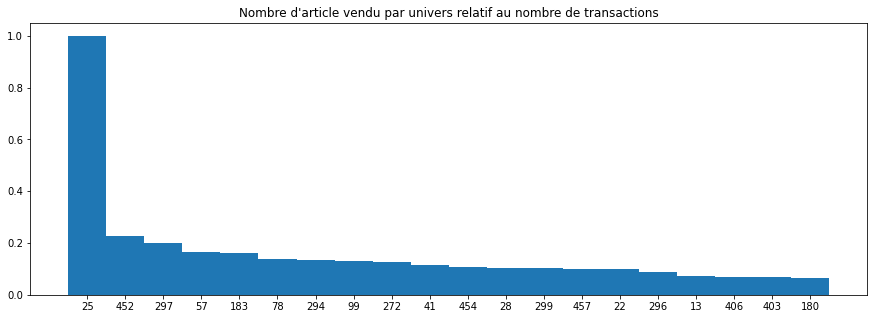

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 4.41)
("Nombre moyen d'univ", 1.22)
('CA univ', 64550.59)
('CA moyen univ', 6.62)
('Nombre moyen article en plus', 7.66)
('CA en plus', 260595.77)
('CA moyen en plus', 26.71)
==============27===================
29356
Time Taken to load recurence: ~0secondes


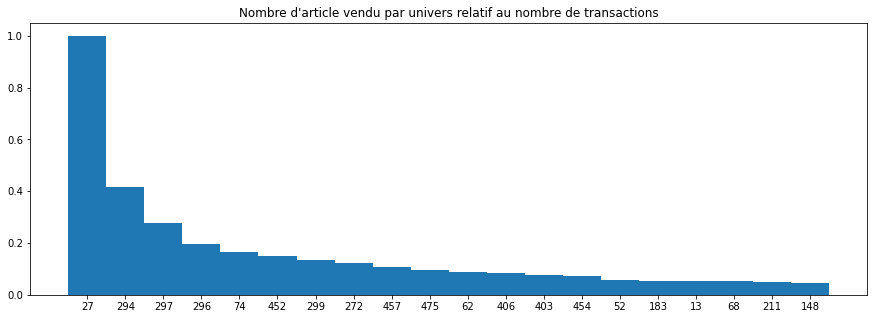

("Proportion d'achat (%)", 0.77)
('Proportion achat seul (%)', 2.1)
("Nombre moyen d'univ", 1.07)
('CA univ', 92854.38)
('CA moyen univ', 3.16)
('Nombre moyen article en plus', 6.6)
('CA en plus', 629992.19)
('CA moyen en plus', 21.46)
==============28===================
34124
Time Taken to load recurence: ~0secondes


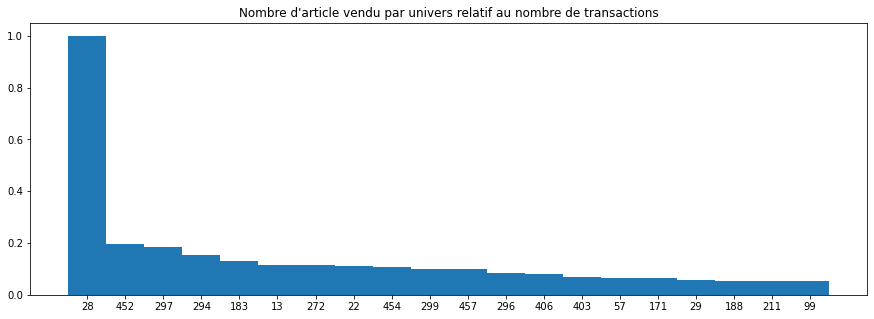

("Proportion d'achat (%)", 0.9)
('Proportion achat seul (%)', 4.78)
("Nombre moyen d'univ", 1.32)
('CA univ', 207071.0)
('CA moyen univ', 6.07)
('Nombre moyen article en plus', 7.06)
('CA en plus', 863133.17)
('CA moyen en plus', 25.29)
==============29===================
16706
Time Taken to load recurence: ~0secondes


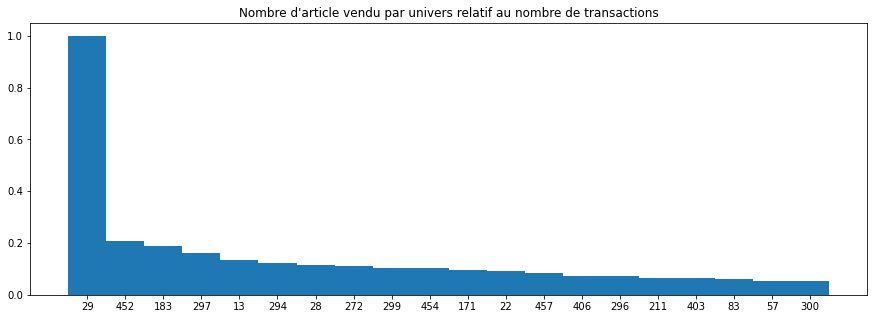

("Proportion d'achat (%)", 0.44)
('Proportion achat seul (%)', 4.79)
("Nombre moyen d'univ", 1.46)
('CA univ', 107460.25)
('CA moyen univ', 6.43)
('Nombre moyen article en plus', 7.45)
('CA en plus', 443716.35)
('CA moyen en plus', 26.56)
==============30===================
NOT ENOUGH DATA 
==============31===================
3202
Time Taken to load recurence: ~0secondes


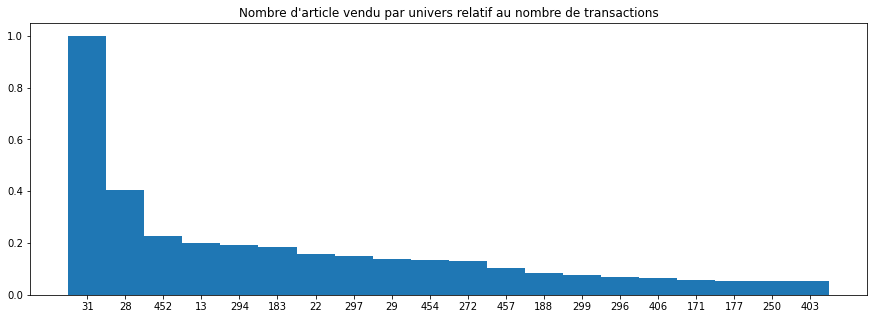

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 2.44)
("Nombre moyen d'univ", 1.24)
('CA univ', 27857.31)
('CA moyen univ', 8.7)
('Nombre moyen article en plus', 8.04)
('CA en plus', 100926.43)
('CA moyen en plus', 31.52)
==============34===================
543
Time Taken to load recurence: ~0secondes


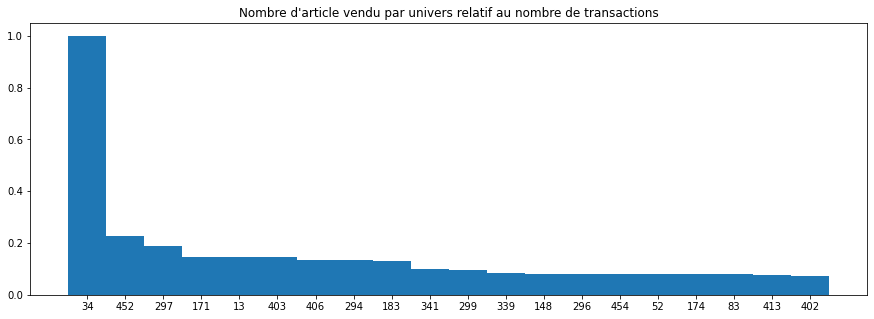

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 2.21)
("Nombre moyen d'univ", 1.12)
('CA univ', 4139.21)
('CA moyen univ', 7.62)
('Nombre moyen article en plus', 9.02)
('CA en plus', 20921.64)
('CA moyen en plus', 38.53)
==============35===================
2816
Time Taken to load recurence: ~0secondes


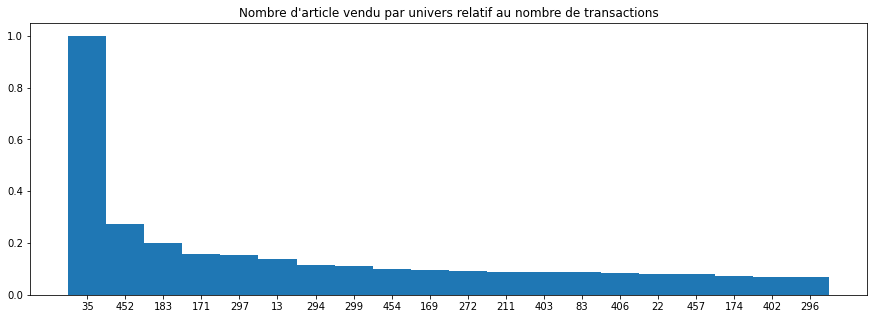

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 3.76)
("Nombre moyen d'univ", 1.31)
('CA univ', 35091.68)
('CA moyen univ', 12.46)
('Nombre moyen article en plus', 9.03)
('CA en plus', 94240.48)
('CA moyen en plus', 33.47)
==============36===================
NOT ENOUGH DATA 
==============37===================
31141
Time Taken to load recurence: ~0secondes


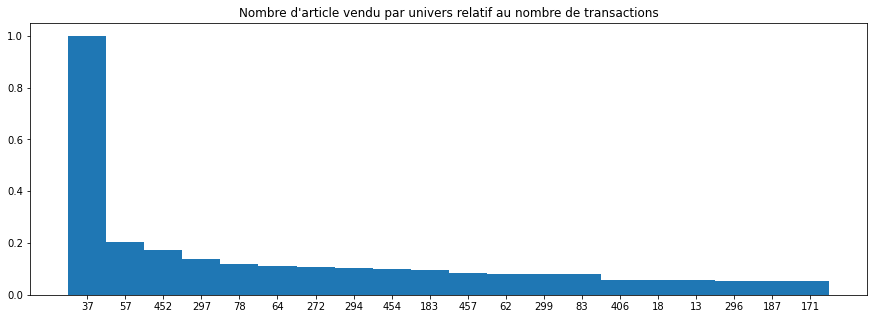

("Proportion d'achat (%)", 0.82)
('Proportion achat seul (%)', 8.56)
("Nombre moyen d'univ", 1.28)
('CA univ', 94727.87)
('CA moyen univ', 3.04)
('Nombre moyen article en plus', 6.31)
('CA en plus', 692173.17)
('CA moyen en plus', 22.23)
==============38===================
2377
Time Taken to load recurence: ~0secondes


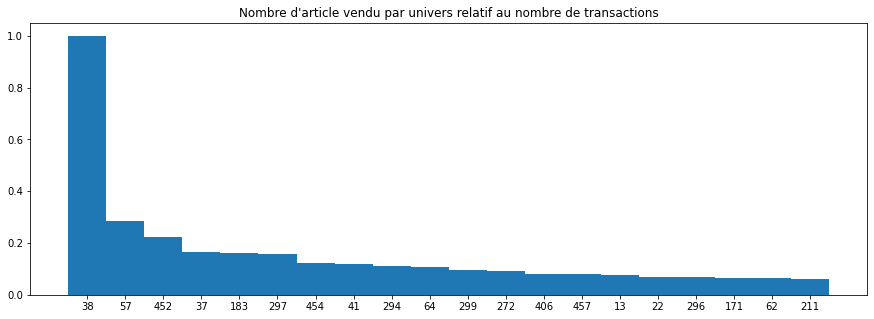

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 3.66)
("Nombre moyen d'univ", 1.43)
('CA univ', 7327.69)
('CA moyen univ', 3.08)
('Nombre moyen article en plus', 7.61)
('CA en plus', 64939.97)
('CA moyen en plus', 27.32)
==============39===================
10396
Time Taken to load recurence: ~0secondes


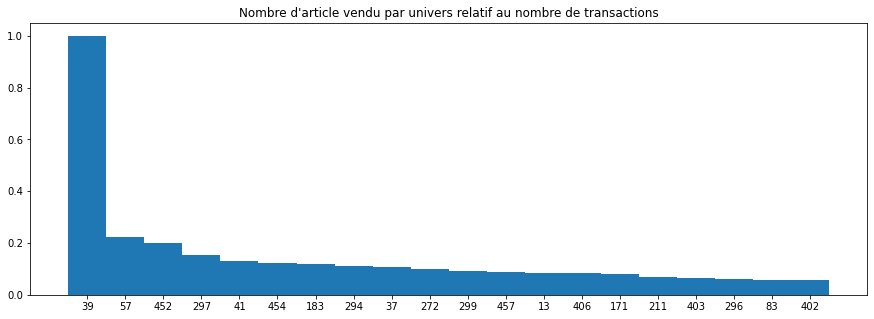

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 4.49)
("Nombre moyen d'univ", 1.41)
('CA univ', 53629.5)
('CA moyen univ', 5.16)
('Nombre moyen article en plus', 7.3)
('CA en plus', 271042.48)
('CA moyen en plus', 26.07)
==============41===================
22296
Time Taken to load recurence: ~0secondes


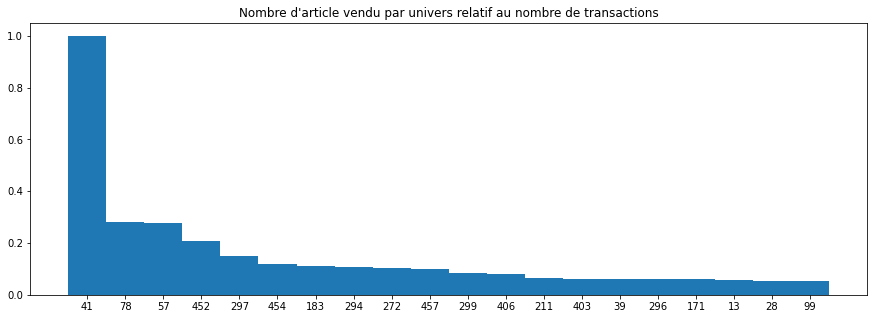

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 4.71)
("Nombre moyen d'univ", 1.22)
('CA univ', 101801.96)
('CA moyen univ', 4.57)
('Nombre moyen article en plus', 7.14)
('CA en plus', 550277.08)
('CA moyen en plus', 24.68)
==============42===================
369
Time Taken to load recurence: ~0secondes


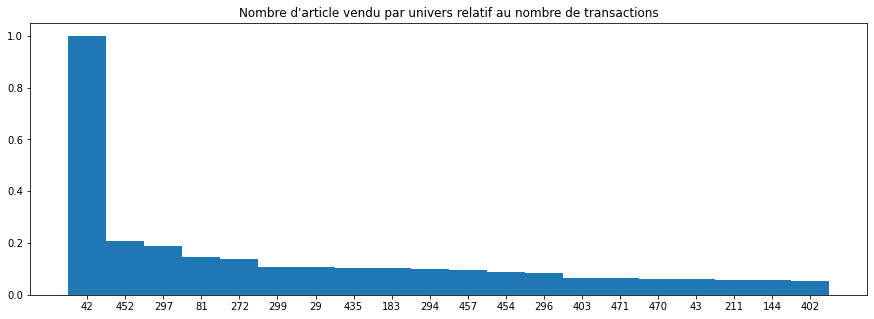

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 8.13)
("Nombre moyen d'univ", 1.11)
('CA univ', 1573.12)
('CA moyen univ', 4.26)
('Nombre moyen article en plus', 6.46)
('CA en plus', 8821.25)
('CA moyen en plus', 23.91)
==============43===================
5041
Time Taken to load recurence: ~0secondes


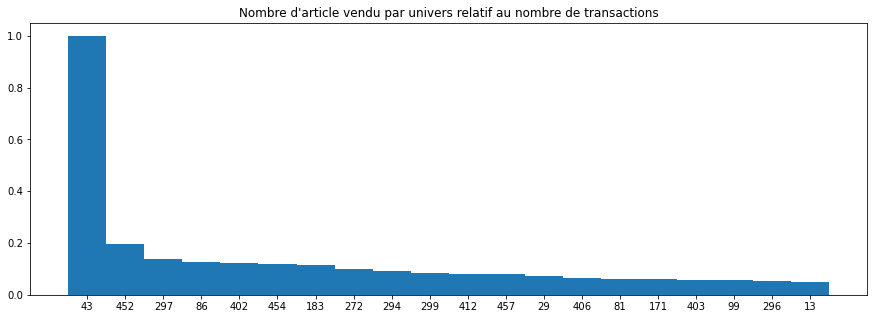

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 8.35)
("Nombre moyen d'univ", 1.22)
('CA univ', 18773.07)
('CA moyen univ', 3.72)
('Nombre moyen article en plus', 6.77)
('CA en plus', 129175.73)
('CA moyen en plus', 25.63)
==============44===================
1633
Time Taken to load recurence: ~0secondes


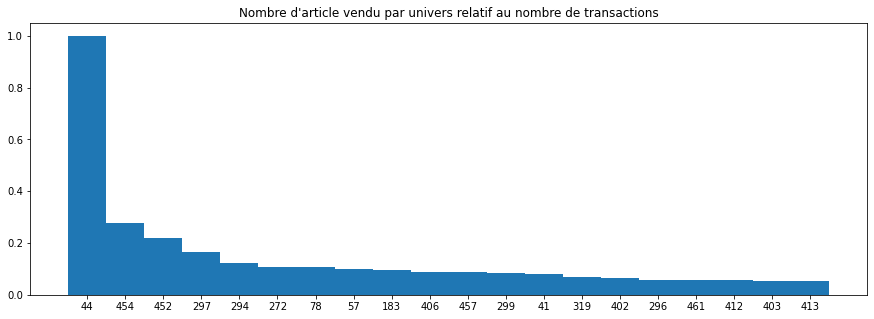

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 3.12)
("Nombre moyen d'univ", 1.12)
('CA univ', 9298.86)
('CA moyen univ', 5.69)
('Nombre moyen article en plus', 7.54)
('CA en plus', 44699.3)
('CA moyen en plus', 27.37)
==============45===================
5384
Time Taken to load recurence: ~0secondes


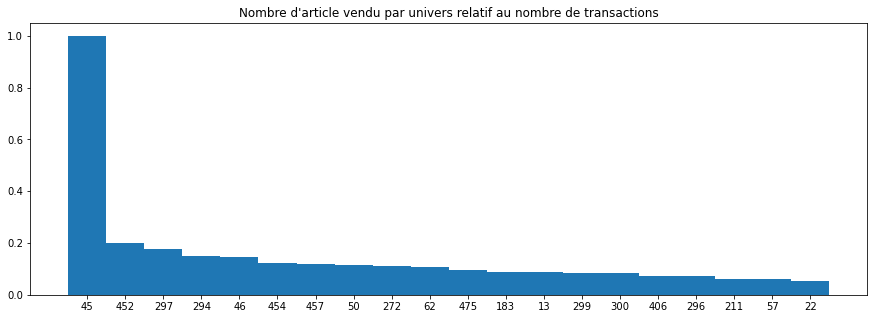

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 7.26)
("Nombre moyen d'univ", 1.03)
('CA univ', 16503.68)
('CA moyen univ', 3.07)
('Nombre moyen article en plus', 7.1)
('CA en plus', 135333.41)
('CA moyen en plus', 25.14)
==============46===================
12098
Time Taken to load recurence: ~0secondes


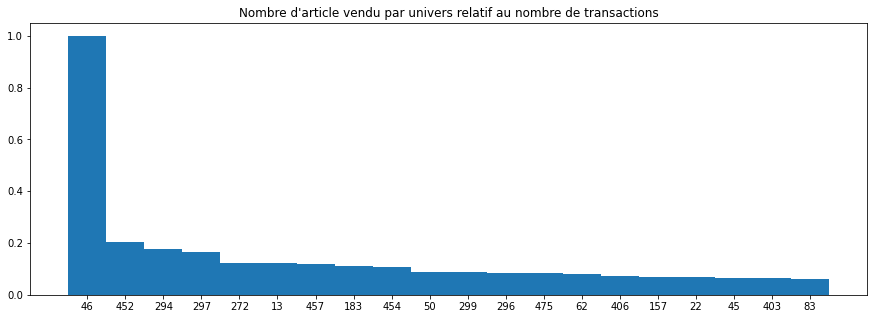

("Proportion d'achat (%)", 0.32)
('Proportion achat seul (%)', 6.38)
("Nombre moyen d'univ", 1.04)
('CA univ', 43005.19)
('CA moyen univ', 3.55)
('Nombre moyen article en plus', 7.24)
('CA en plus', 308530.22)
('CA moyen en plus', 25.5)
==============47===================
4356
Time Taken to load recurence: ~0secondes


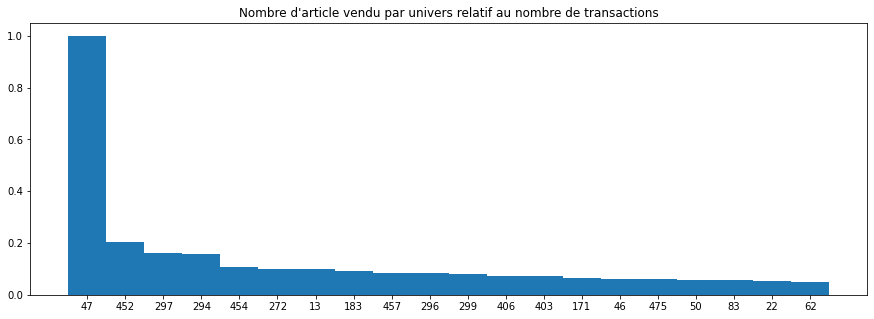

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 7.3)
("Nombre moyen d'univ", 1.09)
('CA univ', 14293.86)
('CA moyen univ', 3.28)
('Nombre moyen article en plus', 7.5)
('CA en plus', 121525.54)
('CA moyen en plus', 27.9)
==============48===================
2040
Time Taken to load recurence: ~0secondes


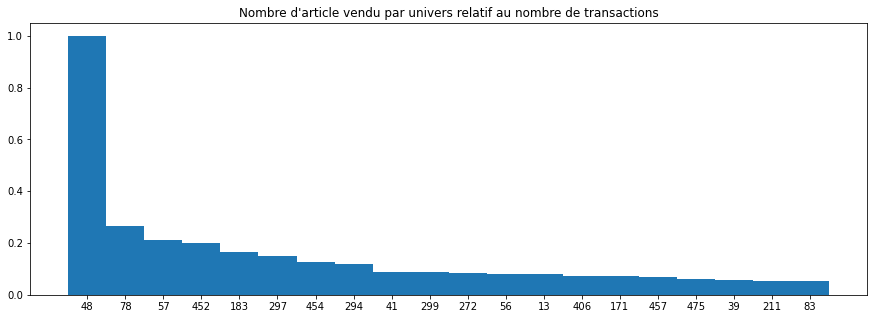

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 5.78)
("Nombre moyen d'univ", 1.07)
('CA univ', 8281.79)
('CA moyen univ', 4.06)
('Nombre moyen article en plus', 6.79)
('CA en plus', 46382.25)
('CA moyen en plus', 22.74)
==============49===================
2852
Time Taken to load recurence: ~0secondes


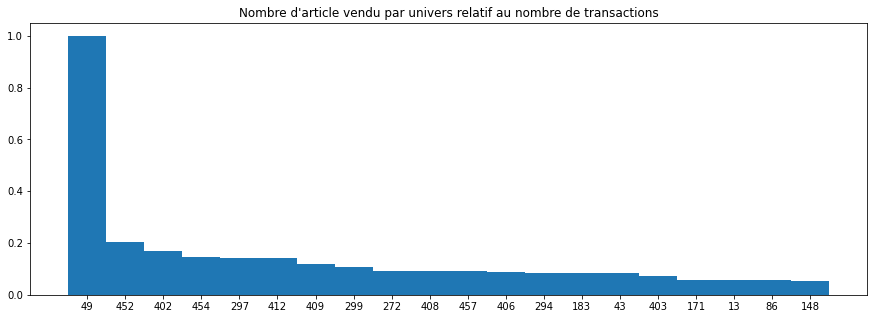

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 8.27)
("Nombre moyen d'univ", 1.11)
('CA univ', 12038.52)
('CA moyen univ', 4.22)
('Nombre moyen article en plus', 7.3)
('CA en plus', 85925.6)
('CA moyen en plus', 30.13)
==============50===================
13218
Time Taken to load recurence: ~0secondes


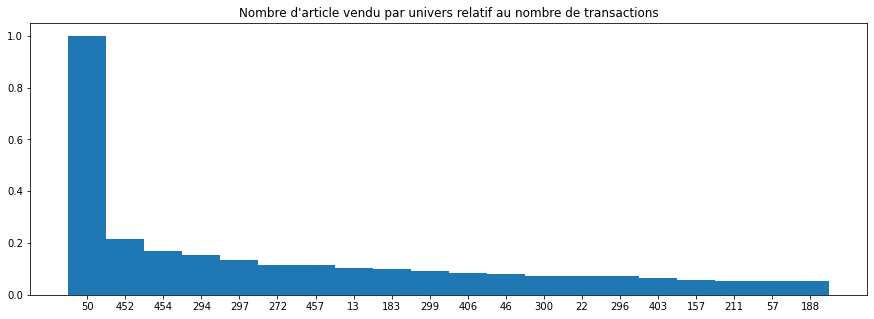

("Proportion d'achat (%)", 0.35)
('Proportion achat seul (%)', 5.45)
("Nombre moyen d'univ", 1.15)
('CA univ', 48508.98)
('CA moyen univ', 3.67)
('Nombre moyen article en plus', 7.23)
('CA en plus', 346773.07)
('CA moyen en plus', 26.23)
==============51===================
4162
Time Taken to load recurence: ~0secondes


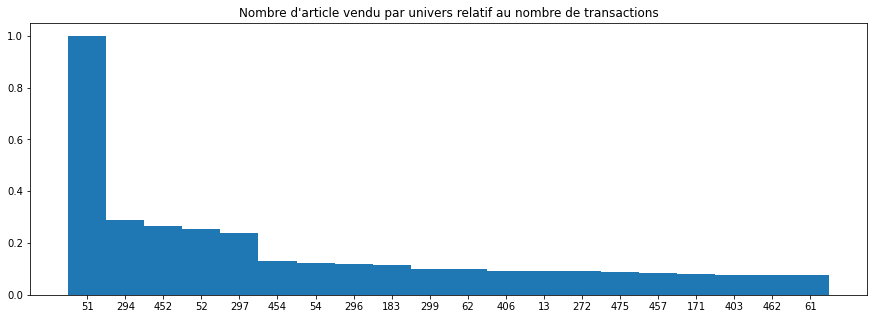

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 0.94)
("Nombre moyen d'univ", 1.06)
('CA univ', 19573.8)
('CA moyen univ', 4.7)
('Nombre moyen article en plus', 8.91)
('CA en plus', 133207.12)
('CA moyen en plus', 32.01)
==============52===================
44087
Time Taken to load recurence: ~0secondes


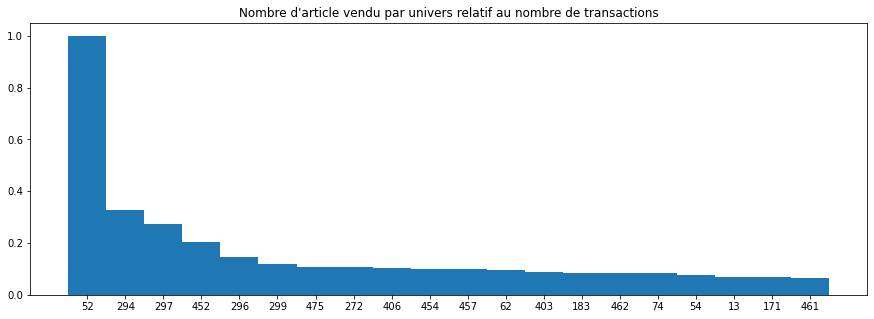

("Proportion d'achat (%)", 1.16)
('Proportion achat seul (%)', 1.4)
("Nombre moyen d'univ", 1.15)
('CA univ', 212069.12)
('CA moyen univ', 4.81)
('Nombre moyen article en plus', 7.97)
('CA en plus', 1242192.92)
('CA moyen en plus', 28.18)
==============53===================
5179
Time Taken to load recurence: ~0secondes


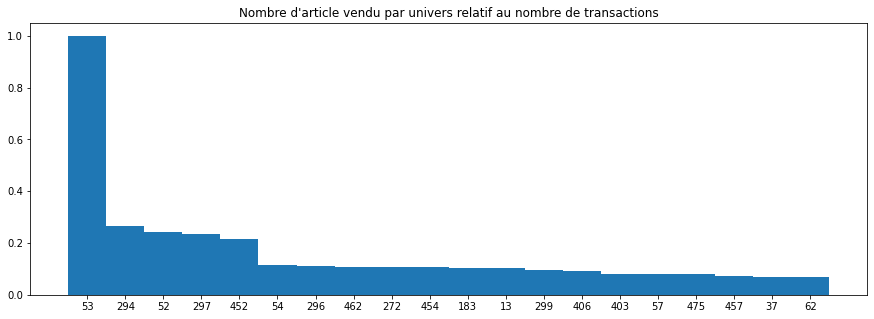

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 1.85)
("Nombre moyen d'univ", 1.04)
('CA univ', 21916.51)
('CA moyen univ', 4.23)
('Nombre moyen article en plus', 8.46)
('CA en plus', 162415.11)
('CA moyen en plus', 31.36)
==============54===================
28550
Time Taken to load recurence: ~0secondes


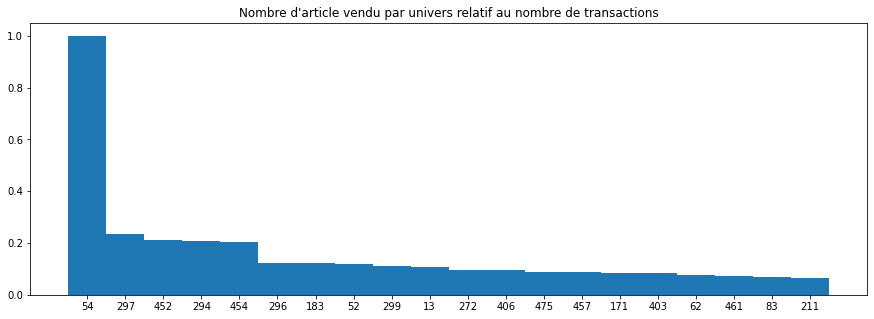

("Proportion d'achat (%)", 0.75)
('Proportion achat seul (%)', 1.44)
("Nombre moyen d'univ", 1.12)
('CA univ', 115047.96)
('CA moyen univ', 4.03)
('Nombre moyen article en plus', 8.35)
('CA en plus', 842208.01)
('CA moyen en plus', 29.5)
==============55===================
10026
Time Taken to load recurence: ~0secondes


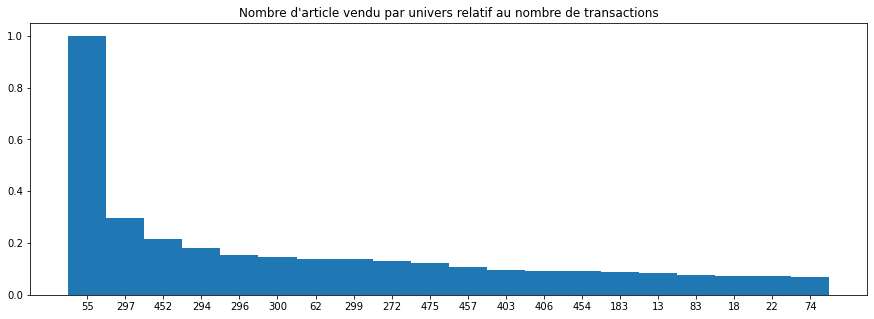

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 2.38)
("Nombre moyen d'univ", 1.1)
('CA univ', 39626.02)
('CA moyen univ', 3.95)
('Nombre moyen article en plus', 8.47)
('CA en plus', 293895.92)
('CA moyen en plus', 29.31)
==============56===================
22782
Time Taken to load recurence: ~0secondes


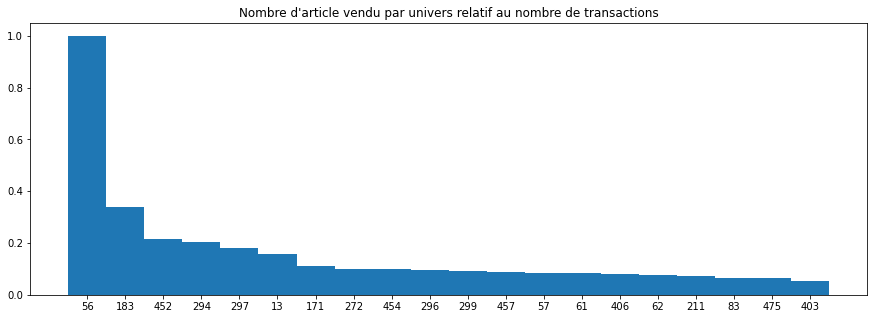

("Proportion d'achat (%)", 0.6)
('Proportion achat seul (%)', 3.24)
("Nombre moyen d'univ", 1.34)
('CA univ', 79108.12)
('CA moyen univ', 3.47)
('Nombre moyen article en plus', 7.83)
('CA en plus', 606054.09)
('CA moyen en plus', 26.6)
==============57===================
67128
Time Taken to load recurence: ~0secondes


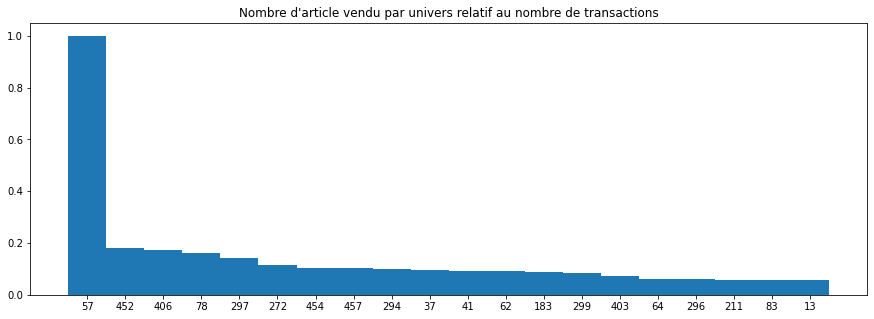

("Proportion d'achat (%)", 1.77)
('Proportion achat seul (%)', 6.61)
("Nombre moyen d'univ", 1.18)
('CA univ', 308715.1)
('CA moyen univ', 4.6)
('Nombre moyen article en plus', 6.56)
('CA en plus', 1589225.64)
('CA moyen en plus', 23.67)
==============58===================
3691
Time Taken to load recurence: ~0secondes


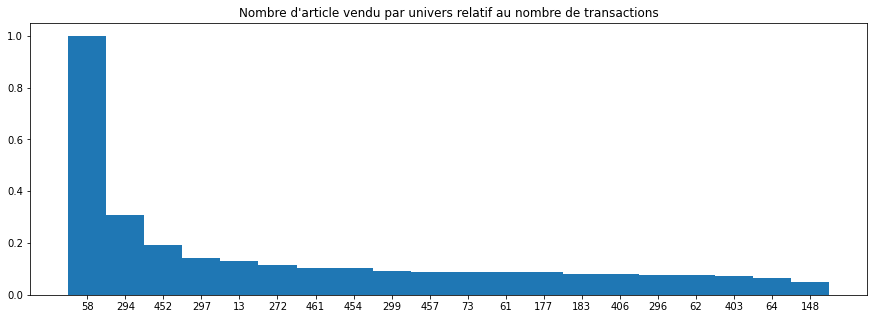

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 7.83)
("Nombre moyen d'univ", 1.39)
('CA univ', 35771.95)
('CA moyen univ', 9.69)
('Nombre moyen article en plus', 6.91)
('CA en plus', 92887.24)
('CA moyen en plus', 25.17)
==============59===================
13255
Time Taken to load recurence: ~0secondes


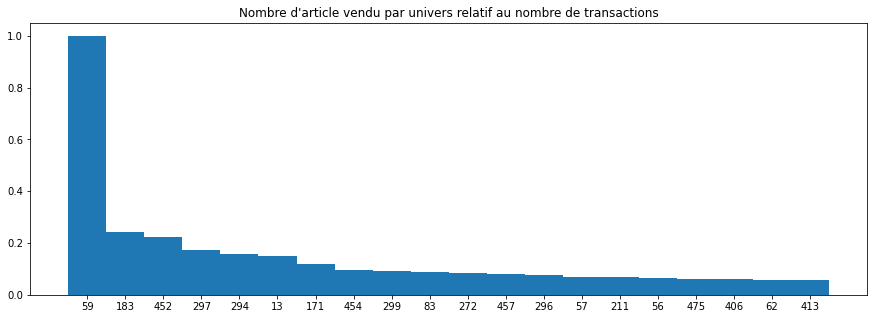

("Proportion d'achat (%)", 0.35)
('Proportion achat seul (%)', 4.46)
("Nombre moyen d'univ", 1.15)
('CA univ', 57470.19)
('CA moyen univ', 4.34)
('Nombre moyen article en plus', 7.77)
('CA en plus', 350877.88)
('CA moyen en plus', 26.47)
==============60===================
16367
Time Taken to load recurence: ~0secondes


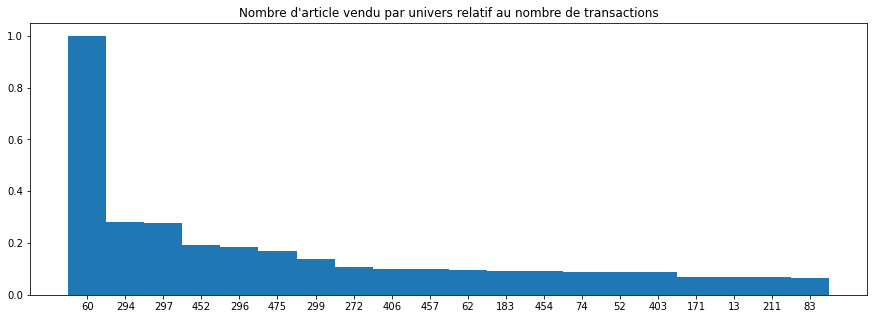

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 1.36)
("Nombre moyen d'univ", 1.1)
('CA univ', 56791.9)
('CA moyen univ', 3.47)
('Nombre moyen article en plus', 7.88)
('CA en plus', 437552.24)
('CA moyen en plus', 26.73)
==============61===================
28790
Time Taken to load recurence: ~0secondes


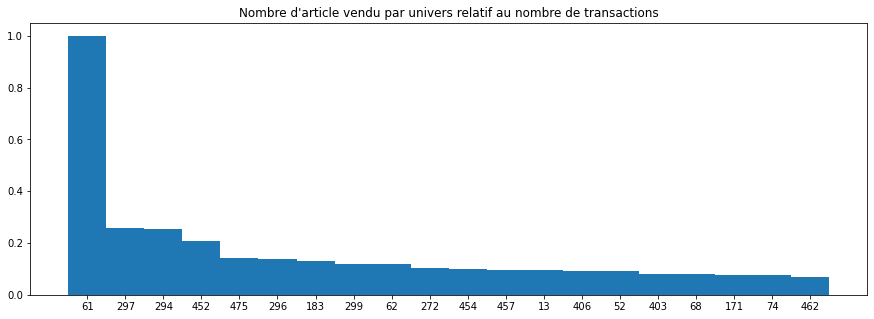

("Proportion d'achat (%)", 0.76)
('Proportion achat seul (%)', 1.6)
("Nombre moyen d'univ", 1.11)
('CA univ', 124066.31)
('CA moyen univ', 4.31)
('Nombre moyen article en plus', 8.24)
('CA en plus', 826247.46)
('CA moyen en plus', 28.7)
==============62===================
69624
Time Taken to load recurence: ~0secondes


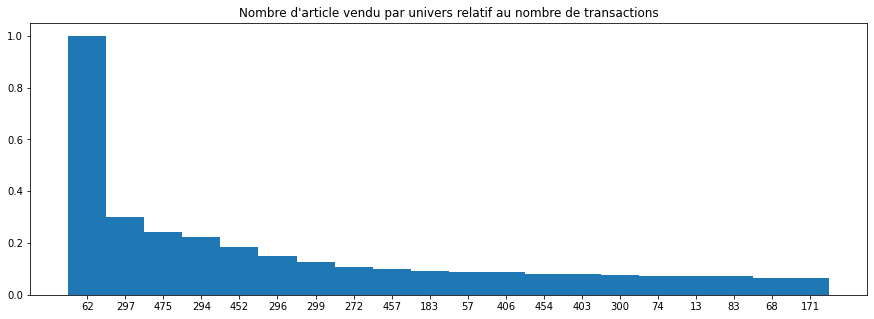

("Proportion d'achat (%)", 1.83)
('Proportion achat seul (%)', 2.57)
("Nombre moyen d'univ", 1.13)
('CA univ', 273205.33)
('CA moyen univ', 3.92)
('Nombre moyen article en plus', 7.44)
('CA en plus', 1755538.89)
('CA moyen en plus', 25.21)
==============63===================
8975
Time Taken to load recurence: ~0secondes


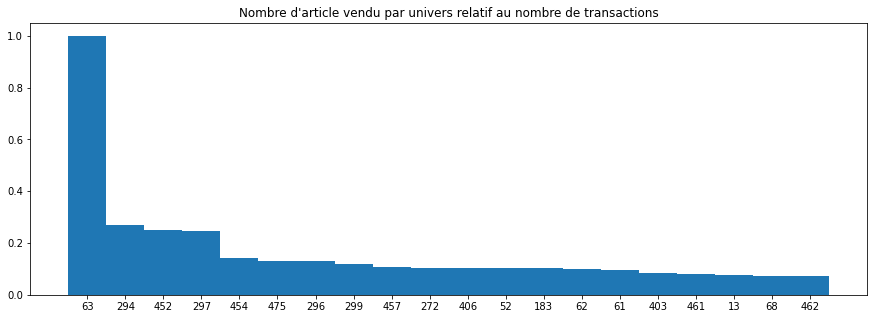

("Proportion d'achat (%)", 0.24)
('Proportion achat seul (%)', 1.13)
("Nombre moyen d'univ", 1.1)
('CA univ', 56952.29)
('CA moyen univ', 6.35)
('Nombre moyen article en plus', 8.81)
('CA en plus', 298439.2)
('CA moyen en plus', 33.25)
==============64===================
26632
Time Taken to load recurence: ~0secondes


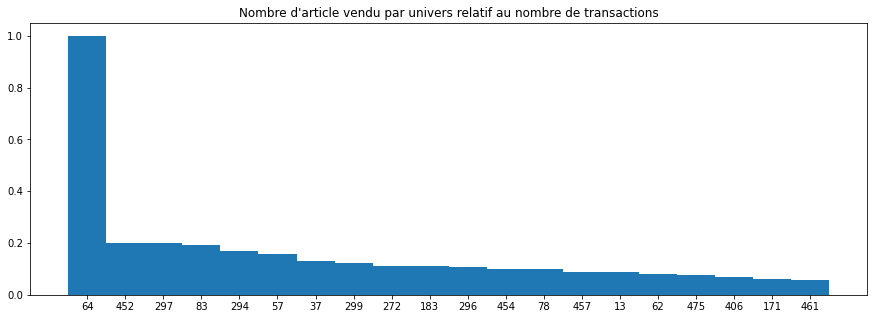

("Proportion d'achat (%)", 0.7)
('Proportion achat seul (%)', 3.91)
("Nombre moyen d'univ", 1.19)
('CA univ', 113216.08)
('CA moyen univ', 4.25)
('Nombre moyen article en plus', 7.38)
('CA en plus', 697825.94)
('CA moyen en plus', 26.2)
==============65===================
305
Time Taken to load recurence: ~0secondes


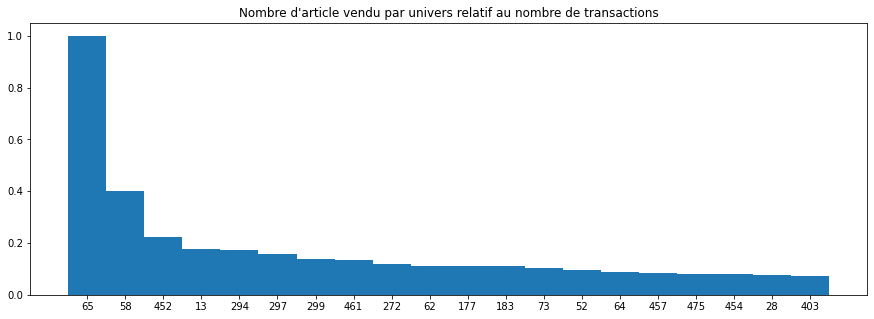

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 1.31)
("Nombre moyen d'univ", 1.13)
('CA univ', 1986.18)
('CA moyen univ', 6.51)
('Nombre moyen article en plus', 8.53)
('CA en plus', 10766.0)
('CA moyen en plus', 35.3)
==============66===================
11341
Time Taken to load recurence: ~0secondes


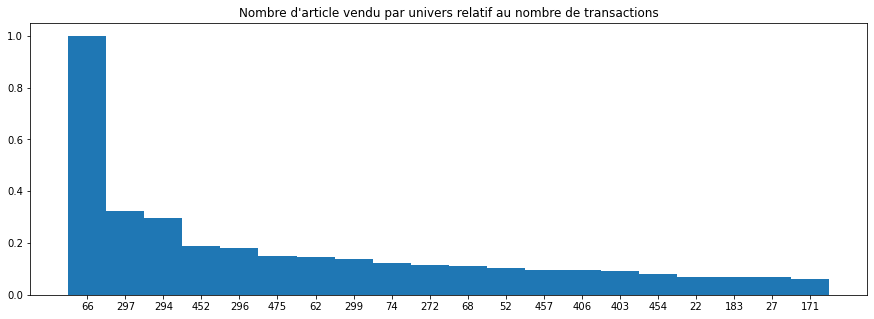

("Proportion d'achat (%)", 0.3)
('Proportion achat seul (%)', 1.17)
("Nombre moyen d'univ", 1.04)
('CA univ', 30348.95)
('CA moyen univ', 2.68)
('Nombre moyen article en plus', 7.82)
('CA en plus', 299289.95)
('CA moyen en plus', 26.39)
==============67===================
6225
Time Taken to load recurence: ~0secondes


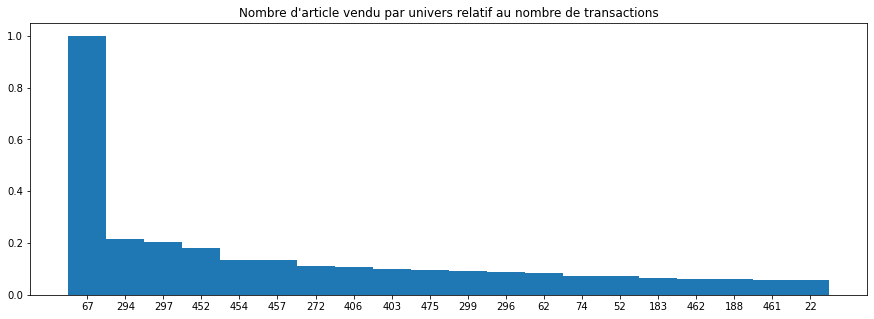

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 2.28)
("Nombre moyen d'univ", 1.05)
('CA univ', 25012.53)
('CA moyen univ', 4.02)
('Nombre moyen article en plus', 7.07)
('CA en plus', 159865.28)
('CA moyen en plus', 25.68)
==============68===================
30926
Time Taken to load recurence: ~0secondes


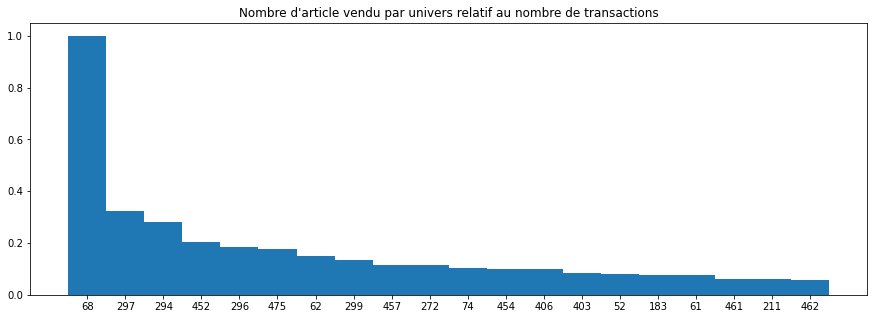

("Proportion d'achat (%)", 0.81)
('Proportion achat seul (%)', 1.14)
("Nombre moyen d'univ", 1.06)
('CA univ', 102986.36)
('CA moyen univ', 3.33)
('Nombre moyen article en plus', 7.86)
('CA en plus', 814802.22)
('CA moyen en plus', 26.35)
==============69===================
24775
Time Taken to load recurence: ~0secondes


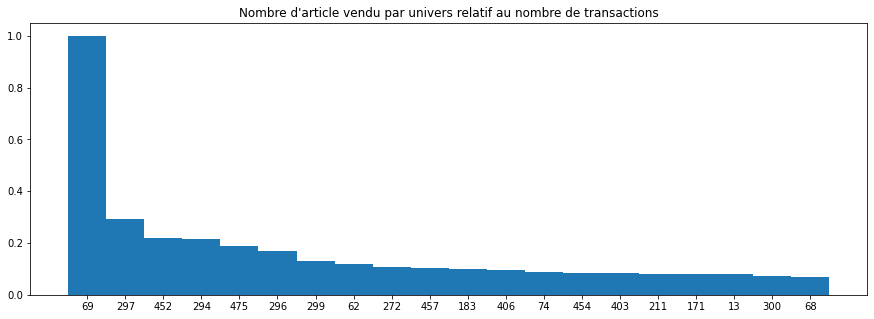

("Proportion d'achat (%)", 0.65)
('Proportion achat seul (%)', 1.71)
("Nombre moyen d'univ", 1.12)
('CA univ', 89725.7)
('CA moyen univ', 3.62)
('Nombre moyen article en plus', 7.79)
('CA en plus', 635723.69)
('CA moyen en plus', 25.66)
==============70===================
4096
Time Taken to load recurence: ~0secondes


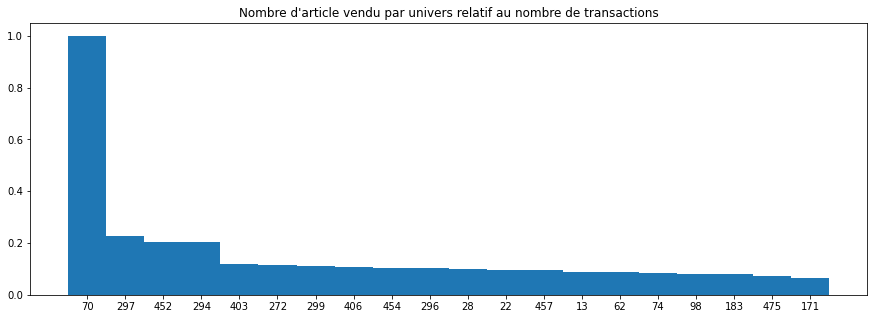

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 2.91)
("Nombre moyen d'univ", 1.16)
('CA univ', 21281.78)
('CA moyen univ', 5.2)
('Nombre moyen article en plus', 8.16)
('CA en plus', 124576.36)
('CA moyen en plus', 30.41)
==============72===================
13124
Time Taken to load recurence: ~0secondes


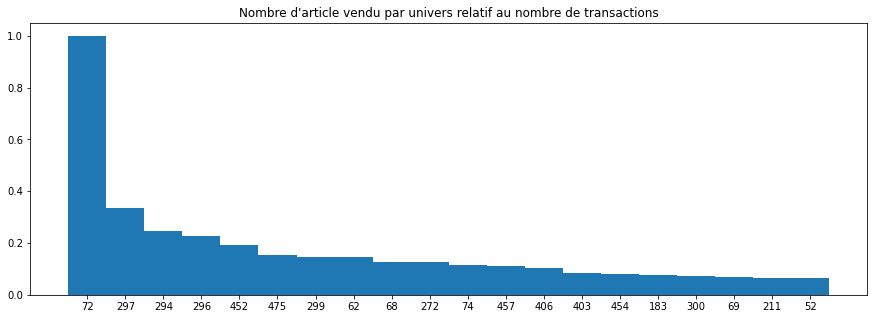

("Proportion d'achat (%)", 0.35)
('Proportion achat seul (%)', 1.43)
("Nombre moyen d'univ", 1.07)
('CA univ', 28029.97)
('CA moyen univ', 2.14)
('Nombre moyen article en plus', 7.74)
('CA en plus', 334740.56)
('CA moyen en plus', 25.51)
==============73===================
15586
Time Taken to load recurence: ~0secondes


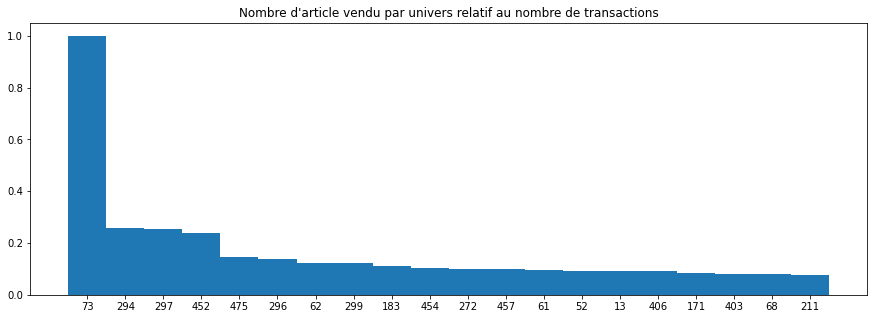

("Proportion d'achat (%)", 0.41)
('Proportion achat seul (%)', 1.08)
("Nombre moyen d'univ", 1.12)
('CA univ', 70819.65)
('CA moyen univ', 4.54)
('Nombre moyen article en plus', 8.59)
('CA en plus', 470384.8)
('CA moyen en plus', 30.18)
==============74===================
64418
Time Taken to load recurence: ~0secondes


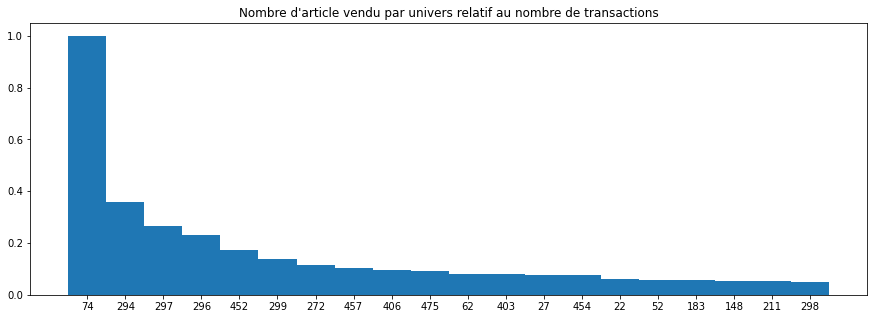

("Proportion d'achat (%)", 1.7)
('Proportion achat seul (%)', 1.93)
("Nombre moyen d'univ", 1.29)
('CA univ', 276820.81)
('CA moyen univ', 4.3)
('Nombre moyen article en plus', 6.66)
('CA en plus', 1394313.79)
('CA moyen en plus', 21.64)
==============75===================
420
Time Taken to load recurence: ~0secondes


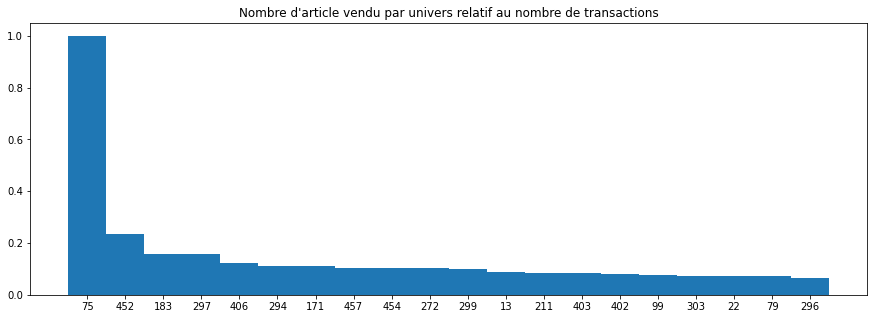

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 2.86)
("Nombre moyen d'univ", 1.17)
('CA univ', 1469.35)
('CA moyen univ', 3.5)
('Nombre moyen article en plus', 8.95)
('CA en plus', 13026.33)
('CA moyen en plus', 31.02)
==============76===================
1399
Time Taken to load recurence: ~0secondes


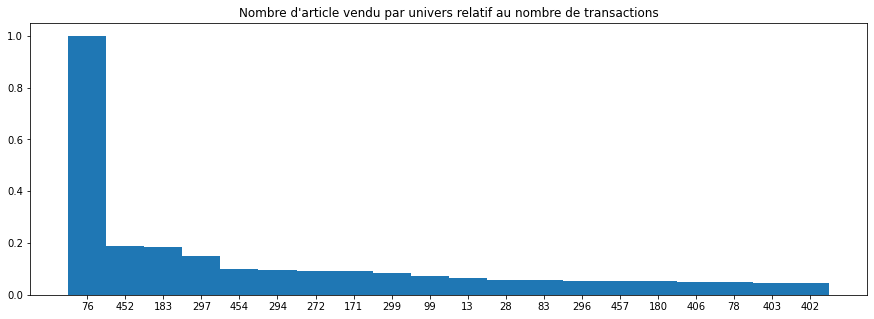

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 12.87)
("Nombre moyen d'univ", 1.07)
('CA univ', 7051.56)
('CA moyen univ', 5.04)
('Nombre moyen article en plus', 6.91)
('CA en plus', 34596.81)
('CA moyen en plus', 24.73)
==============77===================
805
Time Taken to load recurence: ~0secondes


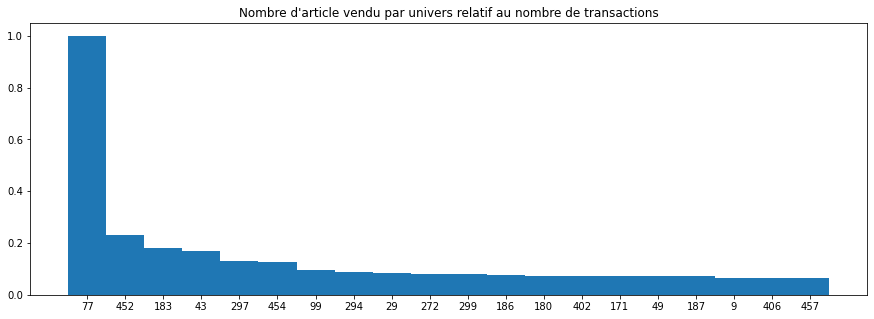

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 5.96)
("Nombre moyen d'univ", 1.18)
('CA univ', 3197.92)
('CA moyen univ', 3.97)
('Nombre moyen article en plus', 7.21)
('CA en plus', 20380.81)
('CA moyen en plus', 25.32)
==============78===================
33123
Time Taken to load recurence: ~0secondes


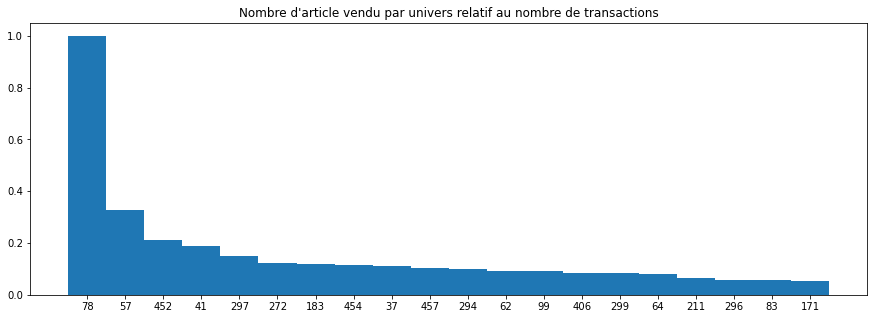

("Proportion d'achat (%)", 0.87)
('Proportion achat seul (%)', 5.45)
("Nombre moyen d'univ", 1.22)
('CA univ', 100630.83)
('CA moyen univ', 3.04)
('Nombre moyen article en plus', 7.06)
('CA en plus', 822969.16)
('CA moyen en plus', 24.85)
==============79===================
3482
Time Taken to load recurence: ~0secondes


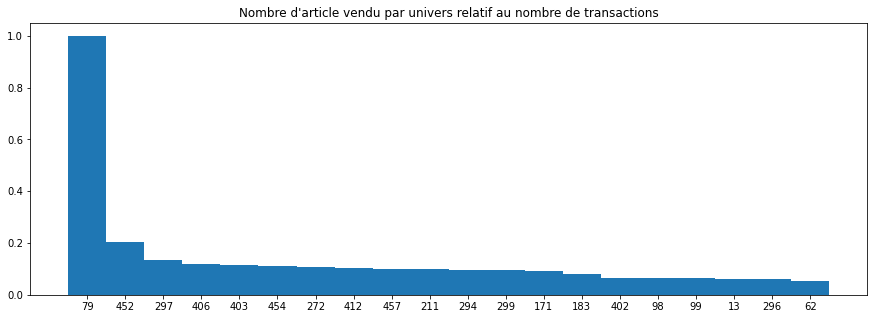

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 3.85)
("Nombre moyen d'univ", 1.26)
('CA univ', 13532.52)
('CA moyen univ', 3.89)
('Nombre moyen article en plus', 7.32)
('CA en plus', 94090.52)
('CA moyen en plus', 27.02)
==============80===================
910
Time Taken to load recurence: ~0secondes


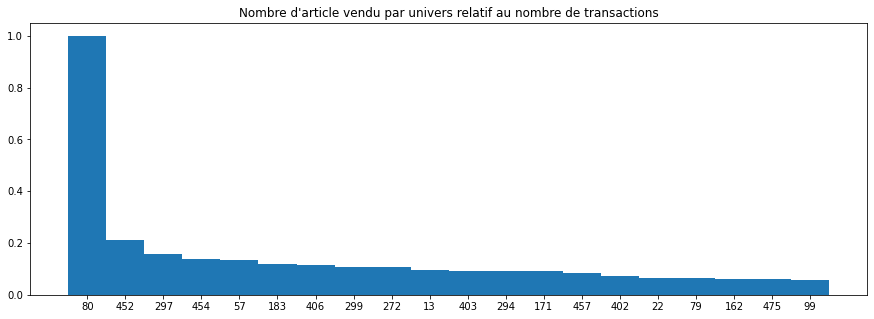

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 3.19)
("Nombre moyen d'univ", 1.19)
('CA univ', 4680.01)
('CA moyen univ', 5.14)
('Nombre moyen article en plus', 8.65)
('CA en plus', 29352.38)
('CA moyen en plus', 32.26)
==============81===================
5840
Time Taken to load recurence: ~0secondes


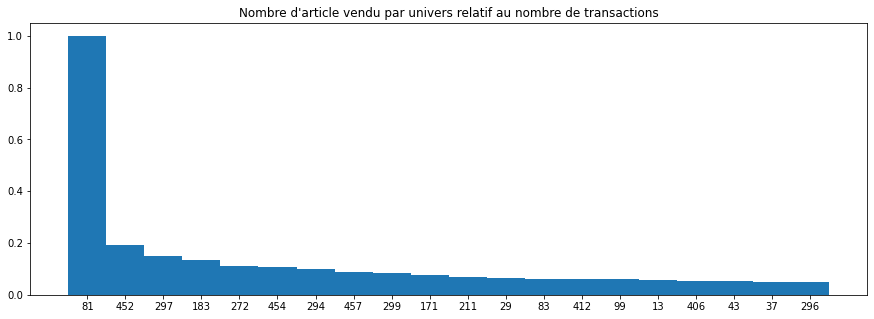

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 9.11)
("Nombre moyen d'univ", 1.09)
('CA univ', 22764.63)
('CA moyen univ', 3.9)
('Nombre moyen article en plus', 6.92)
('CA en plus', 146013.79)
('CA moyen en plus', 25.0)
==============82===================
NOT ENOUGH DATA 
==============83===================
66603
Time Taken to load recurence: ~0secondes


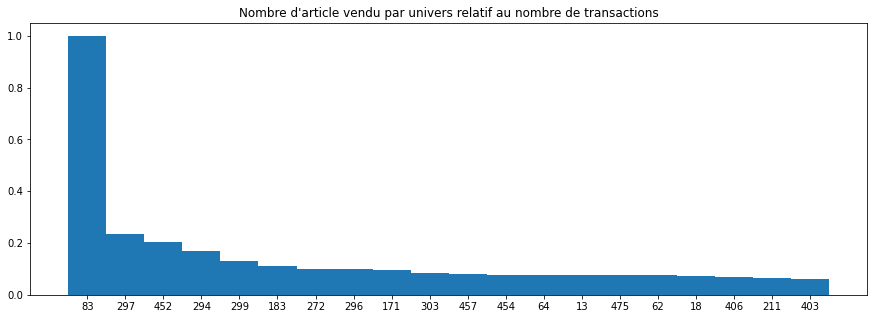

("Proportion d'achat (%)", 1.75)
('Proportion achat seul (%)', 7.21)
("Nombre moyen d'univ", 1.15)
('CA univ', 233372.68)
('CA moyen univ', 3.5)
('Nombre moyen article en plus', 6.99)
('CA en plus', 1571148.01)
('CA moyen en plus', 23.59)
==============84===================
2511
Time Taken to load recurence: ~0secondes


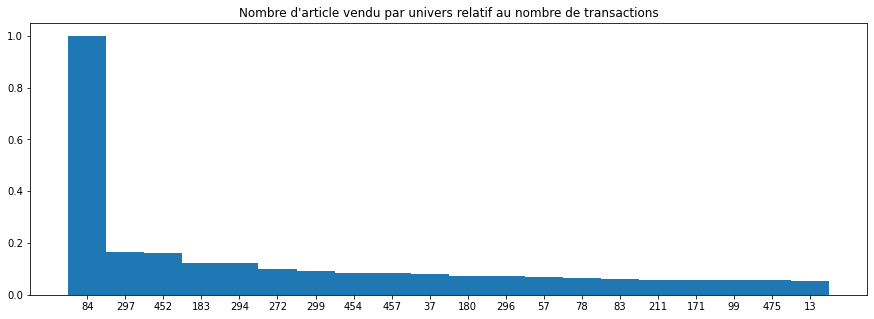

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 9.6)
("Nombre moyen d'univ", 1.16)
('CA univ', 8911.74)
('CA moyen univ', 3.55)
('Nombre moyen article en plus', 6.69)
('CA en plus', 56486.92)
('CA moyen en plus', 22.5)
==============85===================
3601
Time Taken to load recurence: ~0secondes


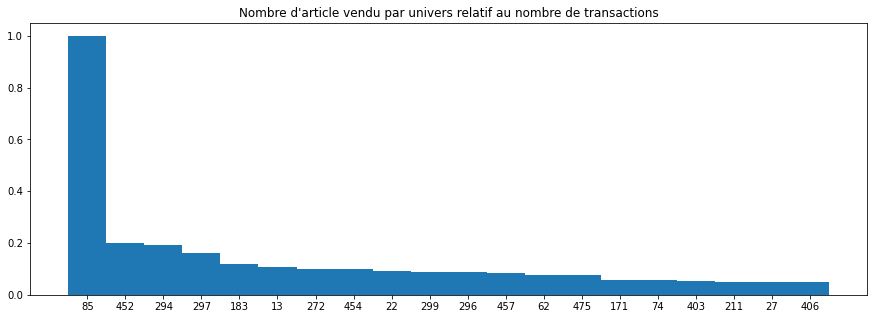

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 6.47)
("Nombre moyen d'univ", 1.17)
('CA univ', 13672.01)
('CA moyen univ', 3.8)
('Nombre moyen article en plus', 7.18)
('CA en plus', 91653.05)
('CA moyen en plus', 25.45)
==============86===================
11714
Time Taken to load recurence: ~0secondes


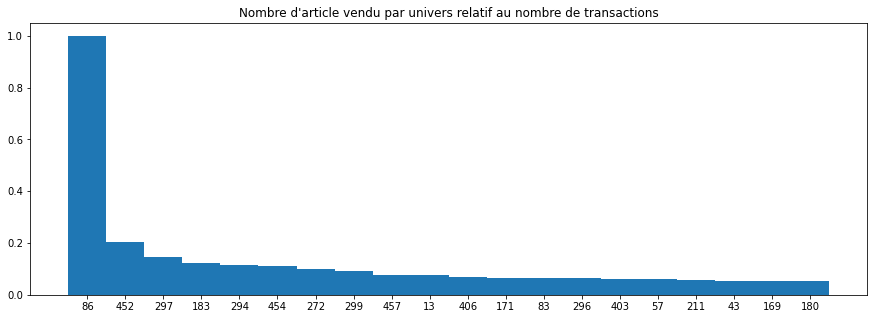

("Proportion d'achat (%)", 0.31)
('Proportion achat seul (%)', 8.53)
("Nombre moyen d'univ", 1.27)
('CA univ', 71116.51)
('CA moyen univ', 6.07)
('Nombre moyen article en plus', 7.37)
('CA en plus', 316944.43)
('CA moyen en plus', 27.06)
==============88===================
4916
Time Taken to load recurence: ~0secondes


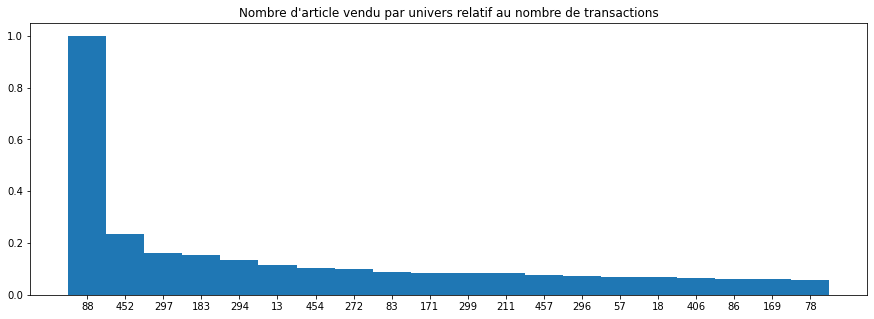

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 7.95)
("Nombre moyen d'univ", 1.05)
('CA univ', 40874.15)
('CA moyen univ', 8.31)
('Nombre moyen article en plus', 8.01)
('CA en plus', 144843.72)
('CA moyen en plus', 29.46)
==============89===================
1272
Time Taken to load recurence: ~0secondes


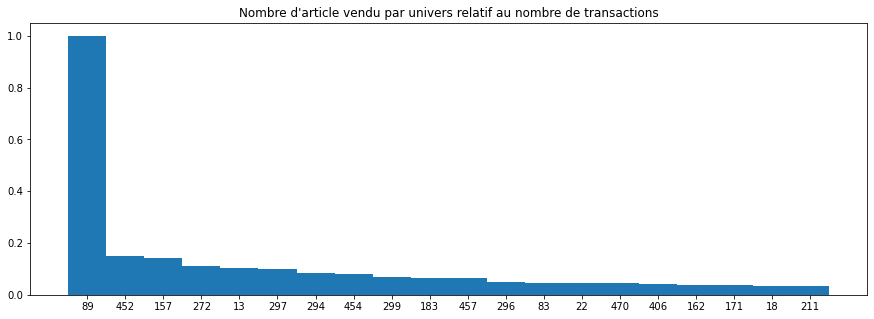

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 21.23)
("Nombre moyen d'univ", 1.26)
('CA univ', 12502.56)
('CA moyen univ', 9.83)
('Nombre moyen article en plus', 4.8)
('CA en plus', 22810.72)
('CA moyen en plus', 17.93)
==============90===================
1876
Time Taken to load recurence: ~0secondes


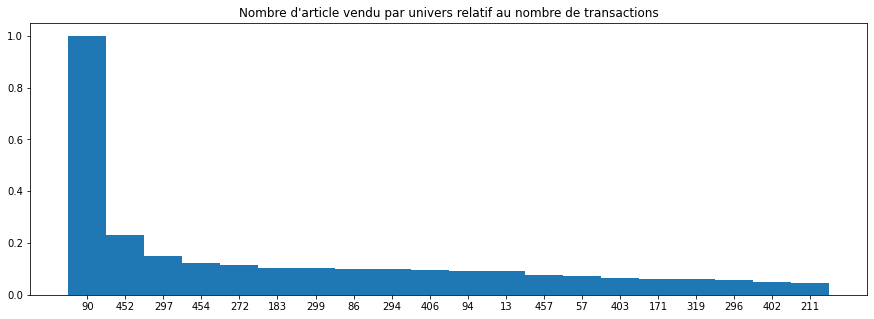

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 6.45)
("Nombre moyen d'univ", 1.28)
('CA univ', 22170.18)
('CA moyen univ', 11.82)
('Nombre moyen article en plus', 7.63)
('CA en plus', 58654.59)
('CA moyen en plus', 31.27)
==============91===================
2179
Time Taken to load recurence: ~0secondes


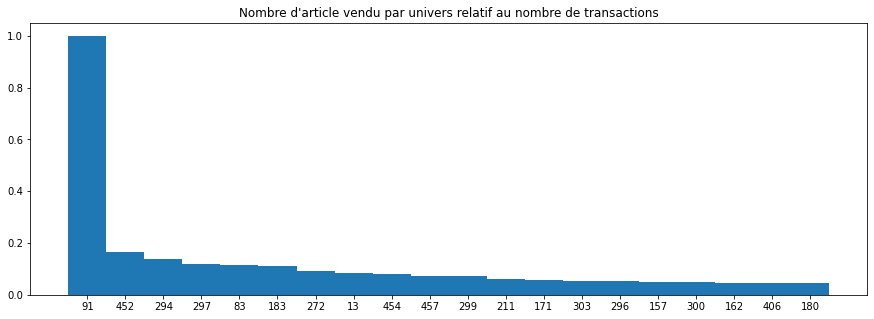

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 13.63)
("Nombre moyen d'univ", 1.08)
('CA univ', 11670.01)
('CA moyen univ', 5.36)
('Nombre moyen article en plus', 5.84)
('CA en plus', 44989.15)
('CA moyen en plus', 20.65)
==============92===================
5588
Time Taken to load recurence: ~0secondes


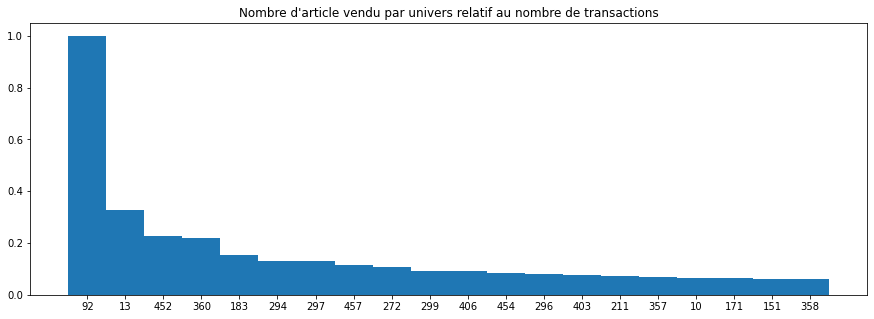

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 2.25)
("Nombre moyen d'univ", 1.17)
('CA univ', 11576.2)
('CA moyen univ', 2.07)
('Nombre moyen article en plus', 7.72)
('CA en plus', 156245.41)
('CA moyen en plus', 27.96)
==============93===================
2133
Time Taken to load recurence: ~0secondes


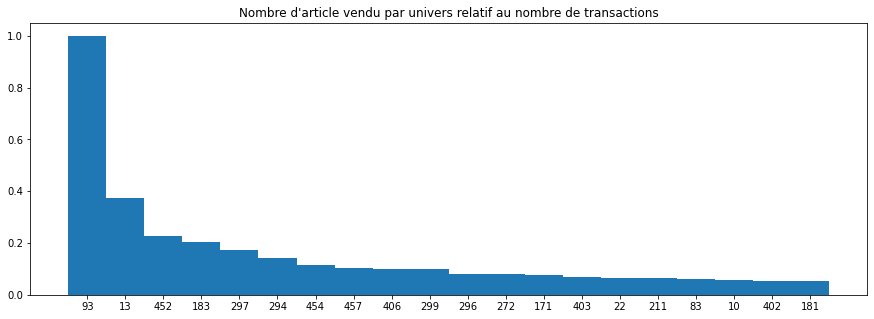

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 2.91)
("Nombre moyen d'univ", 1.08)
('CA univ', 12402.54)
('CA moyen univ', 5.81)
('Nombre moyen article en plus', 8.85)
('CA en plus', 69104.98)
('CA moyen en plus', 32.4)
==============94===================
2997
Time Taken to load recurence: ~0secondes


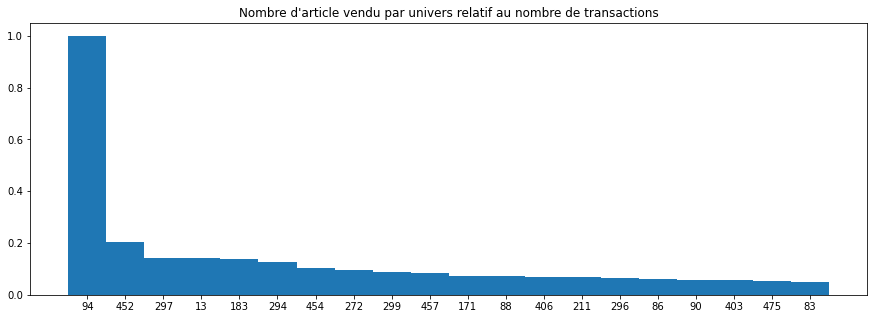

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 8.27)
("Nombre moyen d'univ", 1.1)
('CA univ', 12892.68)
('CA moyen univ', 4.3)
('Nombre moyen article en plus', 7.56)
('CA en plus', 83721.54)
('CA moyen en plus', 27.94)
==============95===================
4390
Time Taken to load recurence: ~0secondes


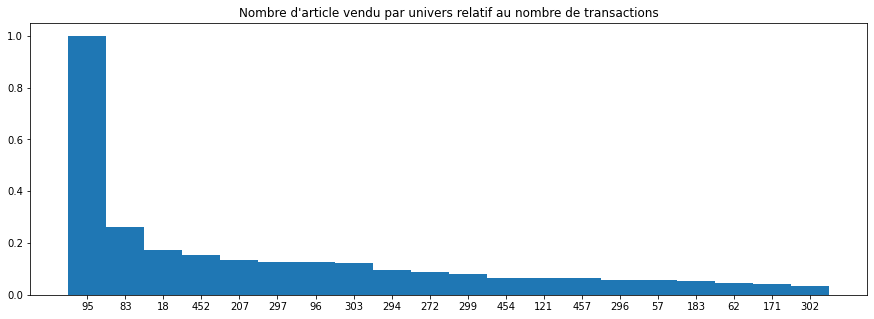

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 13.67)
("Nombre moyen d'univ", 1.09)
('CA univ', 8977.55)
('CA moyen univ', 2.04)
('Nombre moyen article en plus', 5.49)
('CA en plus', 78610.9)
('CA moyen en plus', 17.91)
==============96===================
5975
Time Taken to load recurence: ~0secondes


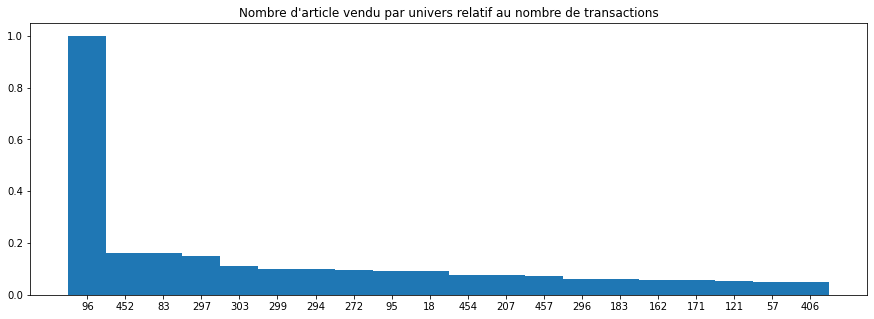

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 11.15)
("Nombre moyen d'univ", 1.16)
('CA univ', 16610.39)
('CA moyen univ', 2.78)
('Nombre moyen article en plus', 6.23)
('CA en plus', 126590.69)
('CA moyen en plus', 21.19)
==============98===================
19168
Time Taken to load recurence: ~0secondes


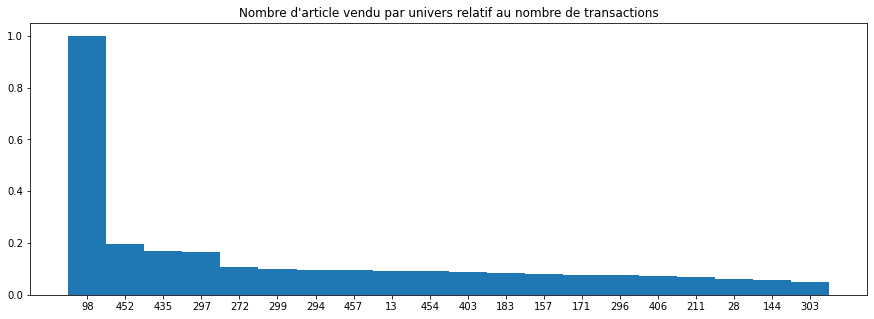

("Proportion d'achat (%)", 0.5)
('Proportion achat seul (%)', 5.88)
("Nombre moyen d'univ", 1.27)
('CA univ', 62862.49)
('CA moyen univ', 3.28)
('Nombre moyen article en plus', 7.0)
('CA en plus', 482165.27)
('CA moyen en plus', 25.15)
==============99===================
23334
Time Taken to load recurence: ~0secondes


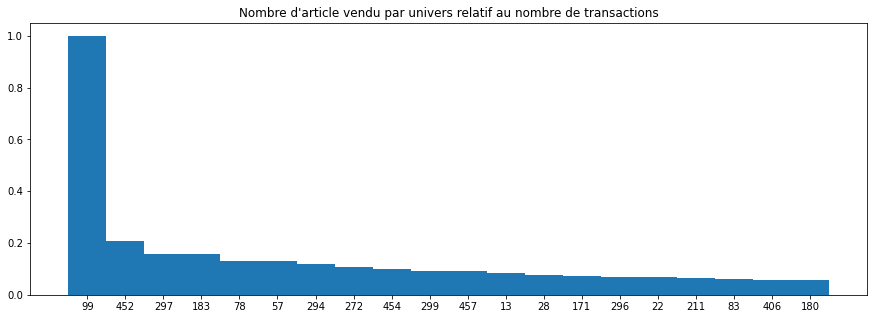

("Proportion d'achat (%)", 0.61)
('Proportion achat seul (%)', 6.61)
("Nombre moyen d'univ", 1.38)
('CA univ', 72154.07)
('CA moyen univ', 3.09)
('Nombre moyen article en plus', 7.13)
('CA en plus', 589972.23)
('CA moyen en plus', 25.28)
==============100===================
9062
Time Taken to load recurence: ~0secondes


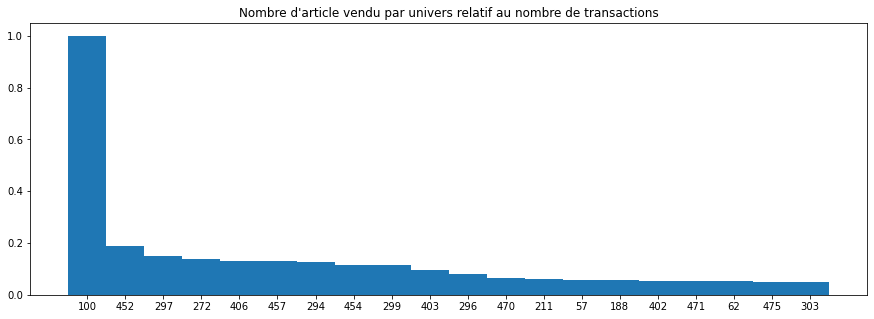

("Proportion d'achat (%)", 0.24)
('Proportion achat seul (%)', 6.41)
("Nombre moyen d'univ", 1.36)
('CA univ', 39215.07)
('CA moyen univ', 4.33)
('Nombre moyen article en plus', 6.37)
('CA en plus', 202703.57)
('CA moyen en plus', 22.37)
==============101===================
10391
Time Taken to load recurence: ~0secondes


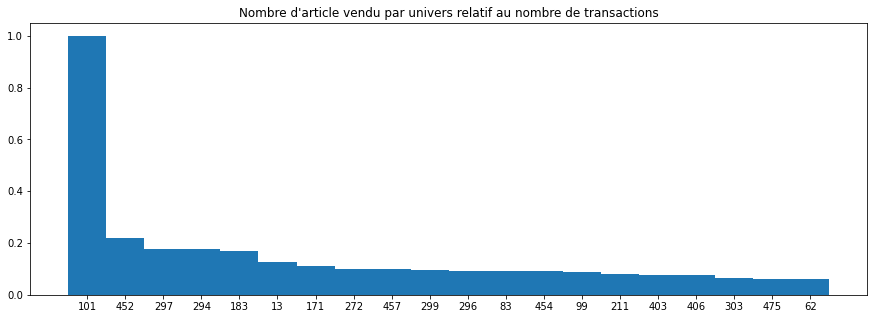

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 3.57)
("Nombre moyen d'univ", 1.35)
('CA univ', 45343.67)
('CA moyen univ', 4.36)
('Nombre moyen article en plus', 7.9)
('CA en plus', 295347.5)
('CA moyen en plus', 28.42)
==============102===================
3232
Time Taken to load recurence: ~0secondes


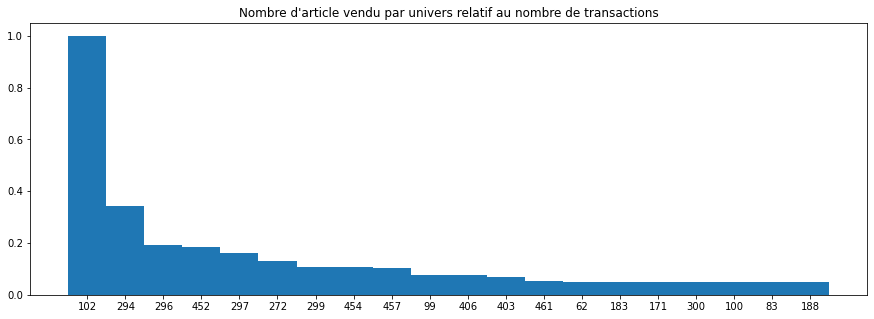

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 4.64)
("Nombre moyen d'univ", 1.22)
('CA univ', 15110.63)
('CA moyen univ', 4.68)
('Nombre moyen article en plus', 6.63)
('CA en plus', 71299.3)
('CA moyen en plus', 22.06)
==============105===================
1891
Time Taken to load recurence: ~0secondes


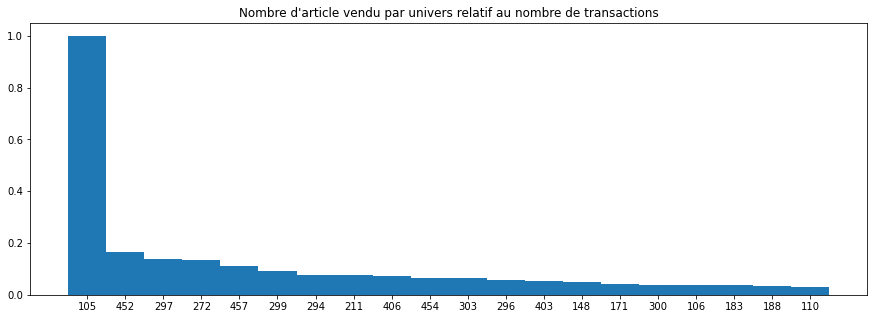

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 16.87)
("Nombre moyen d'univ", 1.23)
('CA univ', 6494.55)
('CA moyen univ', 3.43)
('Nombre moyen article en plus', 4.5)
('CA en plus', 28526.48)
('CA moyen en plus', 15.09)
==============106===================
2180
Time Taken to load recurence: ~0secondes


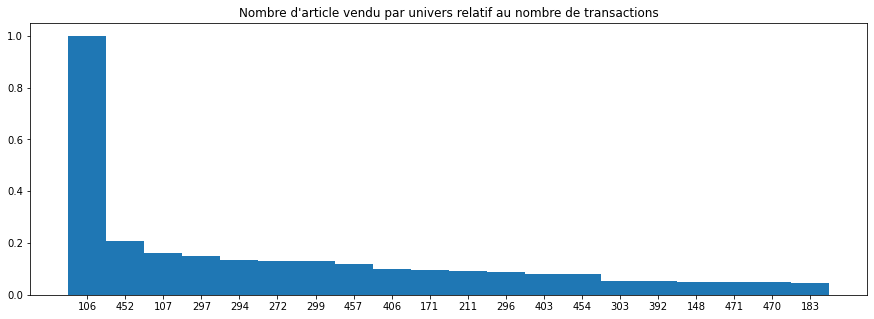

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 8.21)
("Nombre moyen d'univ", 1.35)
('CA univ', 8765.43)
('CA moyen univ', 4.02)
('Nombre moyen article en plus', 6.08)
('CA en plus', 44150.38)
('CA moyen en plus', 20.25)
==============107===================
1946
Time Taken to load recurence: ~0secondes


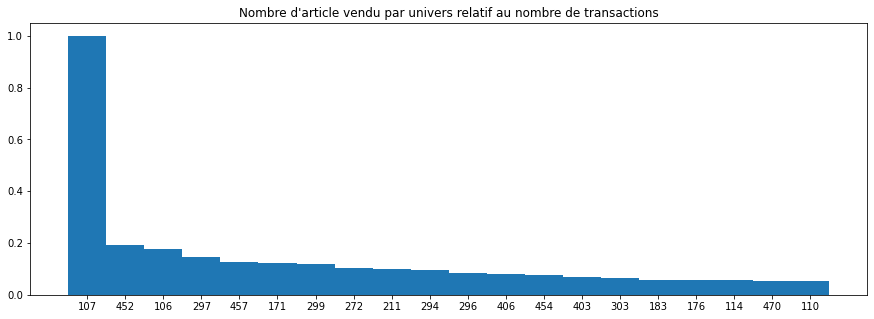

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 6.53)
("Nombre moyen d'univ", 1.15)
('CA univ', 6151.31)
('CA moyen univ', 3.16)
('Nombre moyen article en plus', 6.7)
('CA en plus', 41151.16)
('CA moyen en plus', 21.15)
==============108===================
10429
Time Taken to load recurence: ~0secondes


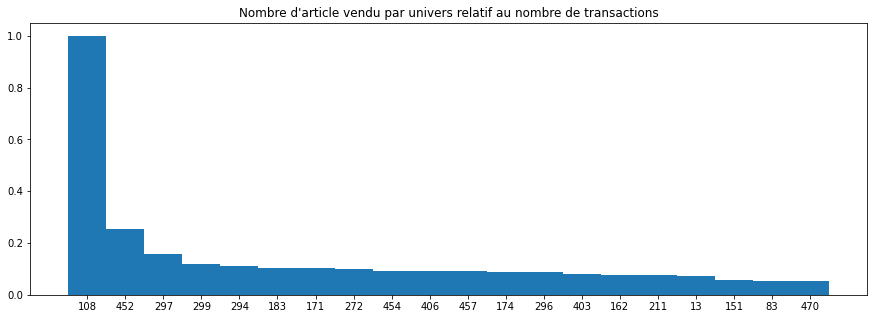

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 5.01)
("Nombre moyen d'univ", 1.18)
('CA univ', 47197.36)
('CA moyen univ', 4.53)
('Nombre moyen article en plus', 7.26)
('CA en plus', 255477.71)
('CA moyen en plus', 24.5)
==============109===================
3934
Time Taken to load recurence: ~0secondes


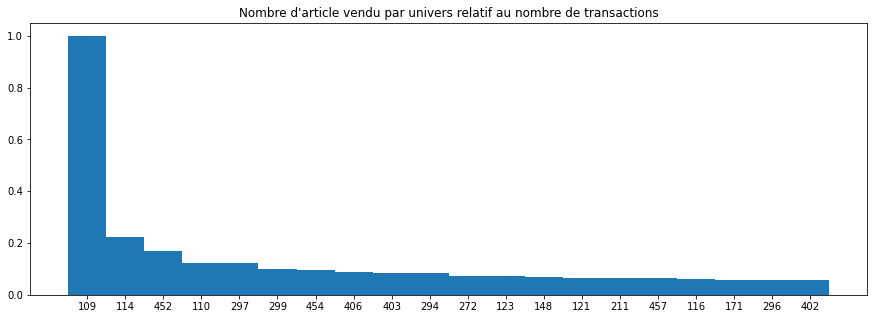

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.6)
("Nombre moyen d'univ", 1.08)
('CA univ', 22751.04)
('CA moyen univ', 5.78)
('Nombre moyen article en plus', 6.7)
('CA en plus', 103013.05)
('CA moyen en plus', 26.19)
==============110===================
56188
Time Taken to load recurence: ~0secondes


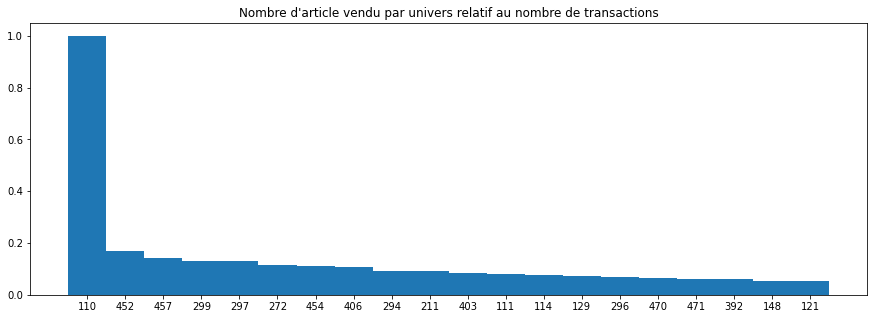

("Proportion d'achat (%)", 1.48)
('Proportion achat seul (%)', 3.72)
("Nombre moyen d'univ", 1.15)
('CA univ', 183045.41)
('CA moyen univ', 3.26)
('Nombre moyen article en plus', 6.21)
('CA en plus', 1193245.82)
('CA moyen en plus', 21.24)
==============111===================
41217
Time Taken to load recurence: ~0secondes


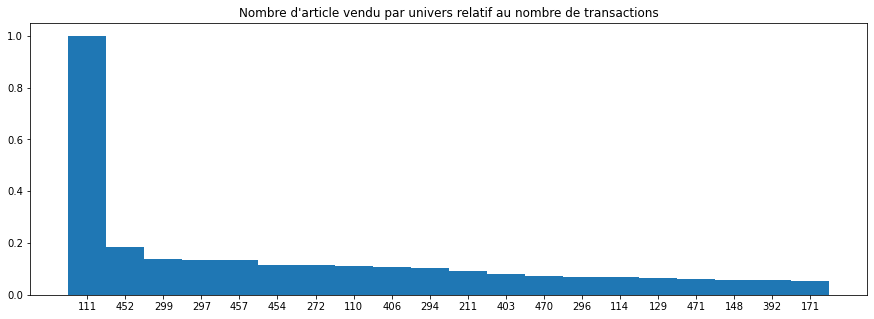

("Proportion d'achat (%)", 1.09)
('Proportion achat seul (%)', 3.89)
("Nombre moyen d'univ", 1.15)
('CA univ', 127830.4)
('CA moyen univ', 3.1)
('Nombre moyen article en plus', 6.52)
('CA en plus', 897948.89)
('CA moyen en plus', 21.79)
==============112===================
3966
Time Taken to load recurence: ~0secondes


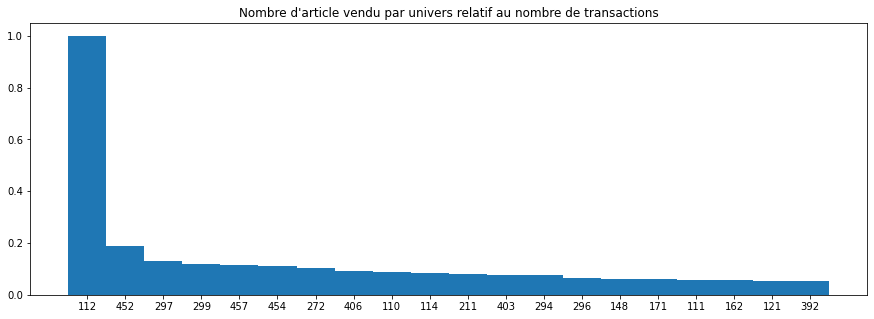

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.49)
("Nombre moyen d'univ", 1.14)
('CA univ', 21802.3)
('CA moyen univ', 5.5)
('Nombre moyen article en plus', 6.81)
('CA en plus', 95826.82)
('CA moyen en plus', 24.16)
==============113===================
25745
Time Taken to load recurence: ~0secondes


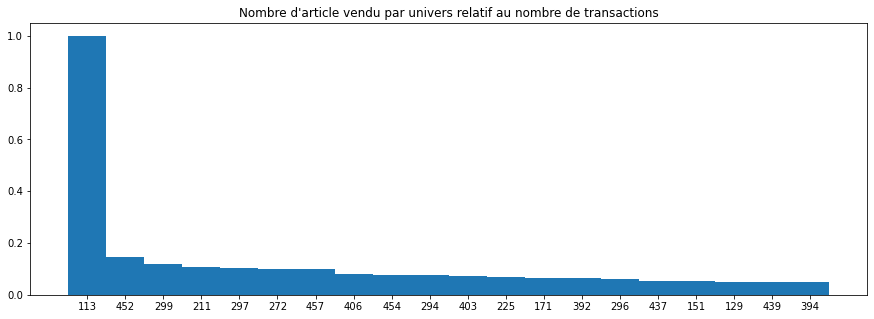

("Proportion d'achat (%)", 0.68)
('Proportion achat seul (%)', 4.45)
("Nombre moyen d'univ", 1.33)
('CA univ', 81390.76)
('CA moyen univ', 3.16)
('Nombre moyen article en plus', 5.61)
('CA en plus', 476761.3)
('CA moyen en plus', 18.52)
==============114===================
44060
Time Taken to load recurence: ~0secondes


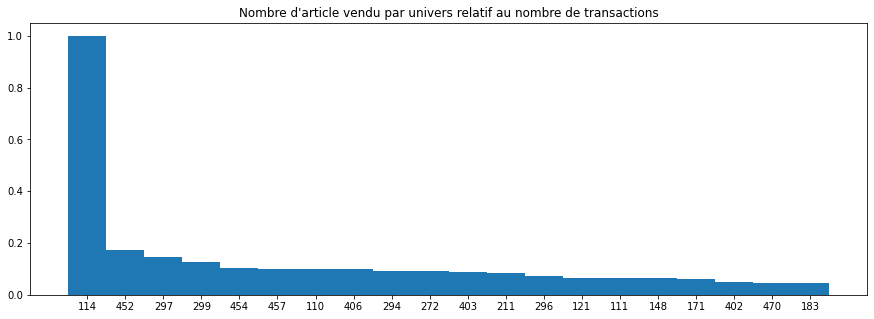

("Proportion d'achat (%)", 1.16)
('Proportion achat seul (%)', 4.42)
("Nombre moyen d'univ", 1.21)
('CA univ', 182164.61)
('CA moyen univ', 4.13)
('Nombre moyen article en plus', 6.67)
('CA en plus', 1038720.56)
('CA moyen en plus', 23.58)
==============115===================
19879
Time Taken to load recurence: ~0secondes


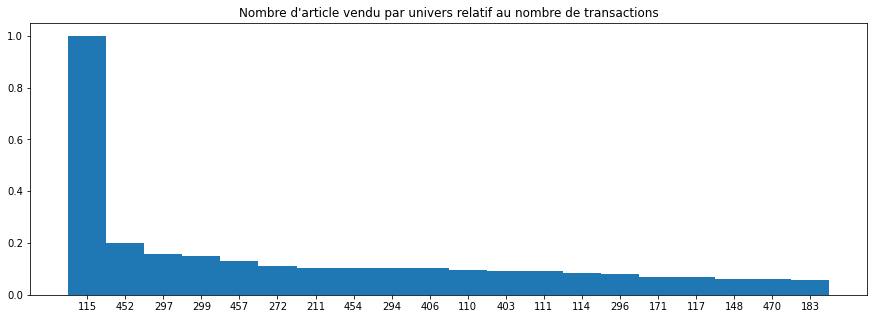

("Proportion d'achat (%)", 0.52)
('Proportion achat seul (%)', 3.44)
("Nombre moyen d'univ", 1.15)
('CA univ', 69384.69)
('CA moyen univ', 3.49)
('Nombre moyen article en plus', 7.04)
('CA en plus', 476096.23)
('CA moyen en plus', 23.95)
==============116===================
19664
Time Taken to load recurence: ~0secondes


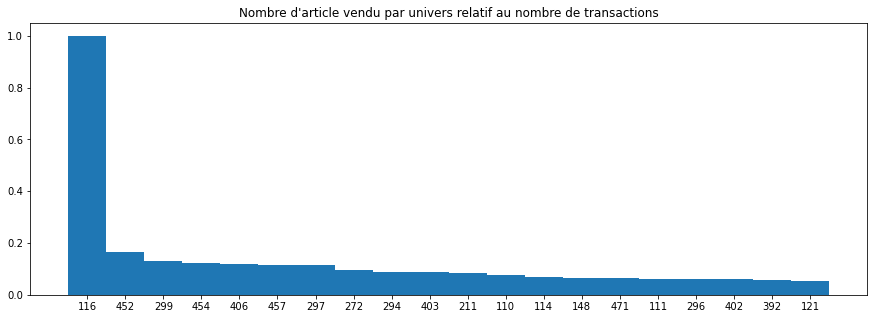

("Proportion d'achat (%)", 0.52)
('Proportion achat seul (%)', 4.15)
("Nombre moyen d'univ", 1.13)
('CA univ', 87969.02)
('CA moyen univ', 4.47)
('Nombre moyen article en plus', 6.35)
('CA en plus', 434909.07)
('CA moyen en plus', 22.12)
==============117===================
26579
Time Taken to load recurence: ~0secondes


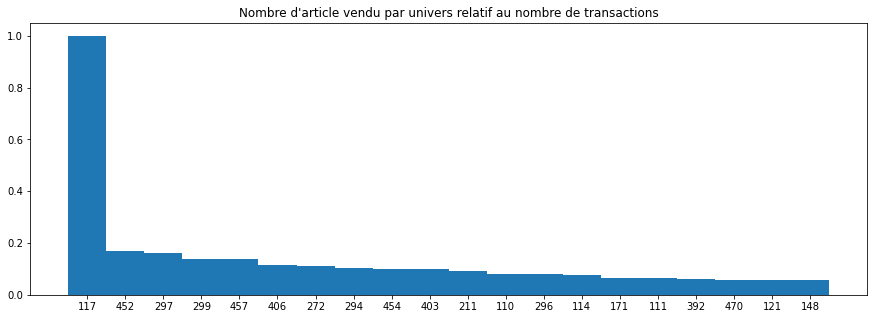

("Proportion d'achat (%)", 0.7)
('Proportion achat seul (%)', 3.67)
("Nombre moyen d'univ", 1.11)
('CA univ', 96700.18)
('CA moyen univ', 3.64)
('Nombre moyen article en plus', 6.74)
('CA en plus', 624512.96)
('CA moyen en plus', 23.5)
==============118===================
1005
Time Taken to load recurence: ~0secondes


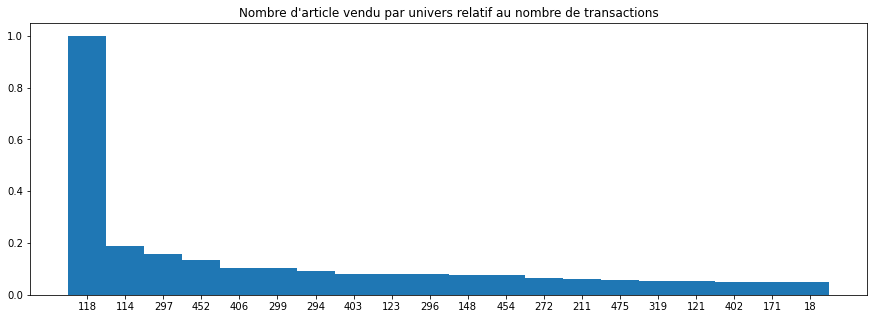

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 6.57)
("Nombre moyen d'univ", 1.07)
('CA univ', 6620.98)
('CA moyen univ', 6.59)
('Nombre moyen article en plus', 6.68)
('CA en plus', 27723.83)
('CA moyen en plus', 27.59)
==============119===================
2757
Time Taken to load recurence: ~0secondes


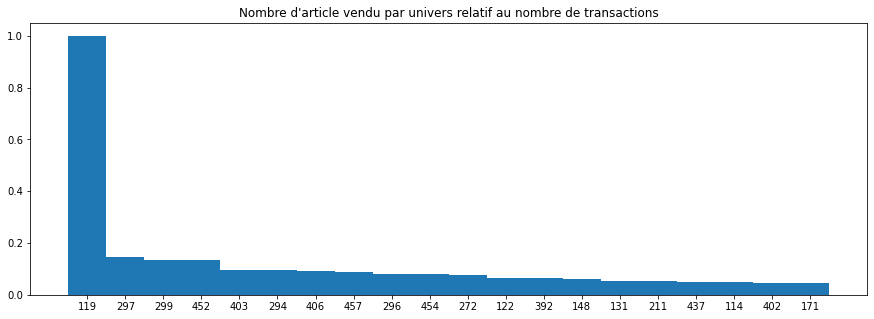

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 6.06)
("Nombre moyen d'univ", 1.33)
('CA univ', 16783.6)
('CA moyen univ', 6.09)
('Nombre moyen article en plus', 5.94)
('CA en plus', 59101.09)
('CA moyen en plus', 21.44)
==============120===================
45712
Time Taken to load recurence: ~0secondes


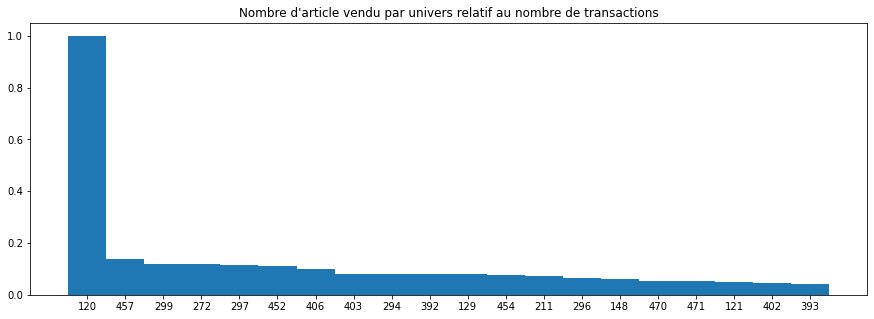

("Proportion d'achat (%)", 1.2)
('Proportion achat seul (%)', 4.62)
("Nombre moyen d'univ", 1.24)
('CA univ', 119818.13)
('CA moyen univ', 2.62)
('Nombre moyen article en plus', 5.2)
('CA en plus', 811120.94)
('CA moyen en plus', 17.74)
==============121===================
57200
Time Taken to load recurence: ~0secondes


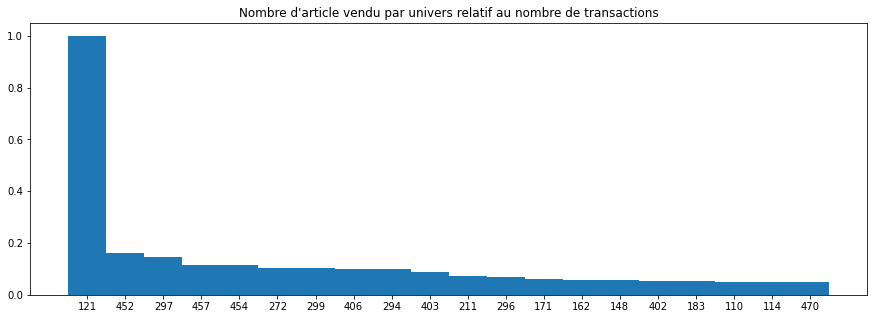

("Proportion d'achat (%)", 1.51)
('Proportion achat seul (%)', 4.74)
("Nombre moyen d'univ", 1.23)
('CA univ', 303943.98)
('CA moyen univ', 5.31)
('Nombre moyen article en plus', 6.37)
('CA en plus', 1313752.47)
('CA moyen en plus', 22.97)
==============122===================
17225
Time Taken to load recurence: ~0secondes


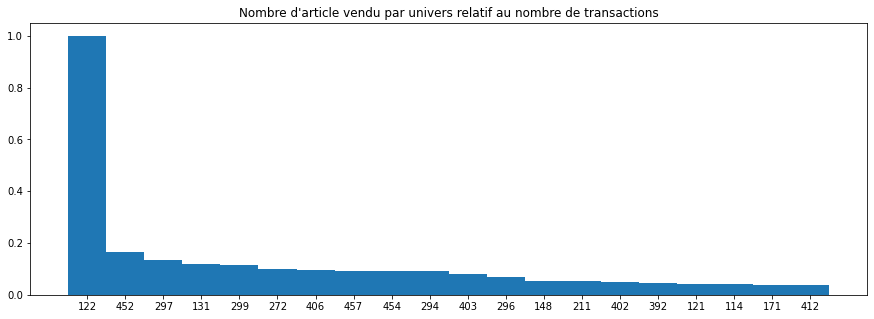

("Proportion d'achat (%)", 0.45)
('Proportion achat seul (%)', 8.03)
("Nombre moyen d'univ", 1.44)
('CA univ', 115189.9)
('CA moyen univ', 6.69)
('Nombre moyen article en plus', 5.8)
('CA en plus', 370198.51)
('CA moyen en plus', 21.49)
==============123===================
18292
Time Taken to load recurence: ~0secondes


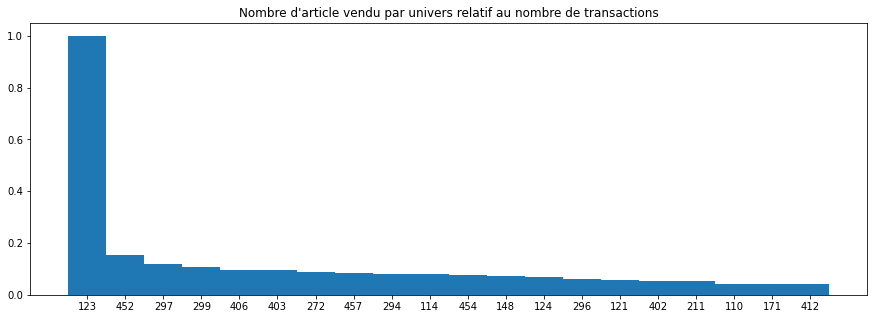

("Proportion d'achat (%)", 0.48)
('Proportion achat seul (%)', 8.77)
("Nombre moyen d'univ", 1.2)
('CA univ', 186594.74)
('CA moyen univ', 10.2)
('Nombre moyen article en plus', 5.82)
('CA en plus', 430560.63)
('CA moyen en plus', 23.54)
==============124===================
16506
Time Taken to load recurence: ~0secondes


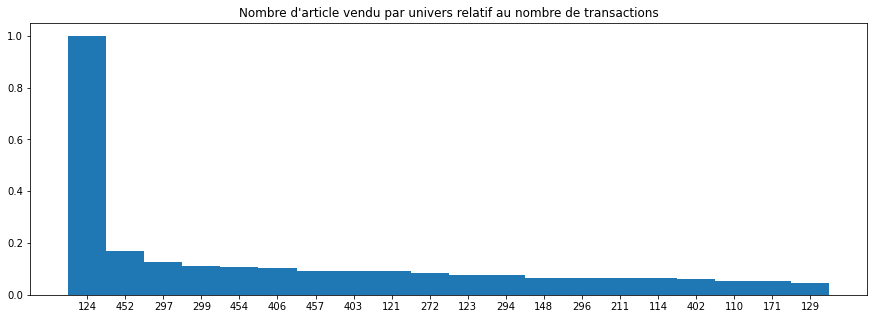

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 4.11)
("Nombre moyen d'univ", 1.19)
('CA univ', 84284.88)
('CA moyen univ', 5.11)
('Nombre moyen article en plus', 6.46)
('CA en plus', 399051.55)
('CA moyen en plus', 24.18)
==============126===================
42011
Time Taken to load recurence: ~0secondes


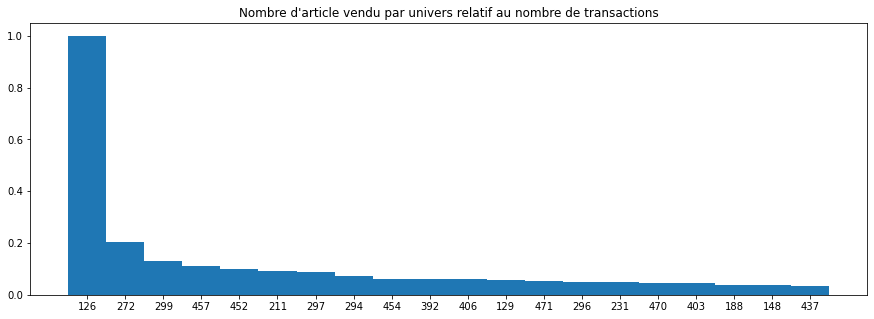

("Proportion d'achat (%)", 1.11)
('Proportion achat seul (%)', 8.97)
("Nombre moyen d'univ", 1.17)
('CA univ', 89154.94)
('CA moyen univ', 2.12)
('Nombre moyen article en plus', 4.3)
('CA en plus', 609799.13)
('CA moyen en plus', 14.52)
==============127===================
5414
Time Taken to load recurence: ~0secondes


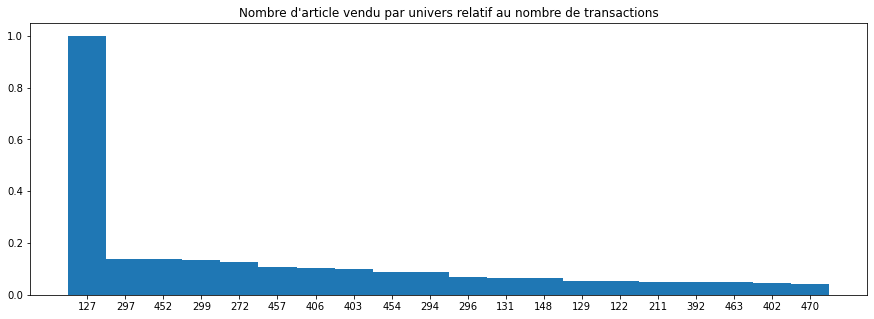

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 4.88)
("Nombre moyen d'univ", 1.36)
('CA univ', 20669.73)
('CA moyen univ', 3.82)
('Nombre moyen article en plus', 5.76)
('CA en plus', 116310.92)
('CA moyen en plus', 21.48)
==============128===================
5018
Time Taken to load recurence: ~0secondes


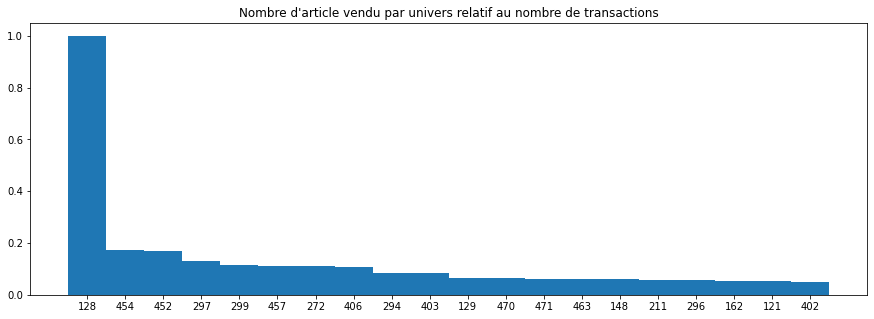

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 4.05)
("Nombre moyen d'univ", 1.14)
('CA univ', 19521.45)
('CA moyen univ', 3.89)
('Nombre moyen article en plus', 6.2)
('CA en plus', 111182.55)
('CA moyen en plus', 22.16)
==============129===================
94946
Time Taken to load recurence: ~0secondes


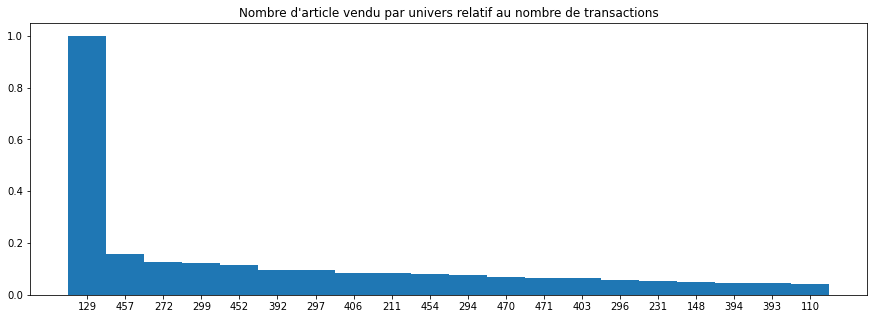

("Proportion d'achat (%)", 2.5)
('Proportion achat seul (%)', 5.16)
("Nombre moyen d'univ", 1.33)
('CA univ', 195395.09)
('CA moyen univ', 2.06)
('Nombre moyen article en plus', 4.75)
('CA en plus', 1451230.8)
('CA moyen en plus', 15.28)
==============130===================
18398
Time Taken to load recurence: ~0secondes


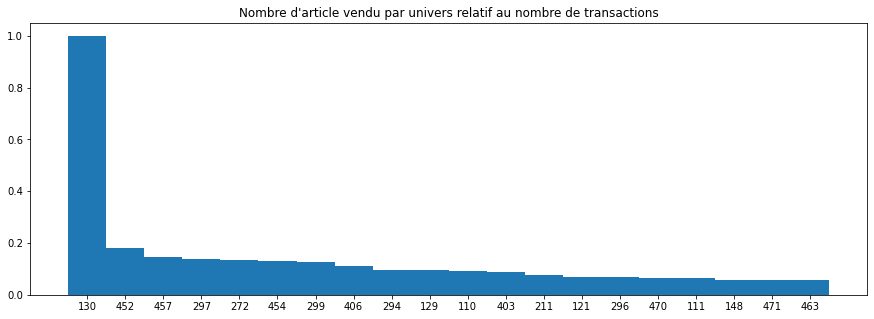

("Proportion d'achat (%)", 0.48)
('Proportion achat seul (%)', 3.9)
("Nombre moyen d'univ", 1.09)
('CA univ', 83595.8)
('CA moyen univ', 4.54)
('Nombre moyen article en plus', 6.56)
('CA en plus', 418999.11)
('CA moyen en plus', 22.77)
==============131===================
21701
Time Taken to load recurence: ~0secondes


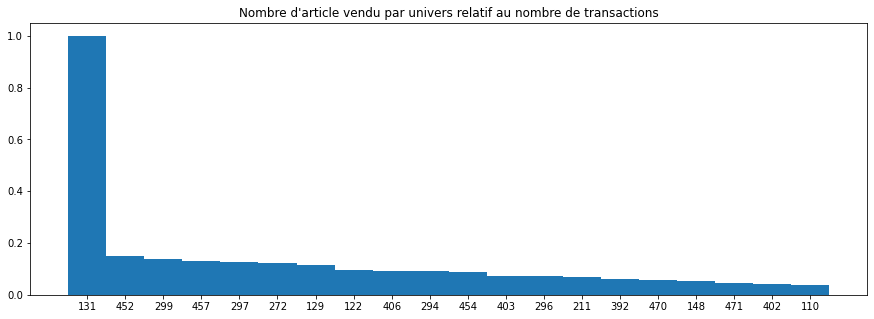

("Proportion d'achat (%)", 0.57)
('Proportion achat seul (%)', 4.79)
("Nombre moyen d'univ", 1.4)
('CA univ', 76624.74)
('CA moyen univ', 3.53)
('Nombre moyen article en plus', 5.74)
('CA en plus', 418102.17)
('CA moyen en plus', 19.27)
==============132===================
19478
Time Taken to load recurence: ~0secondes


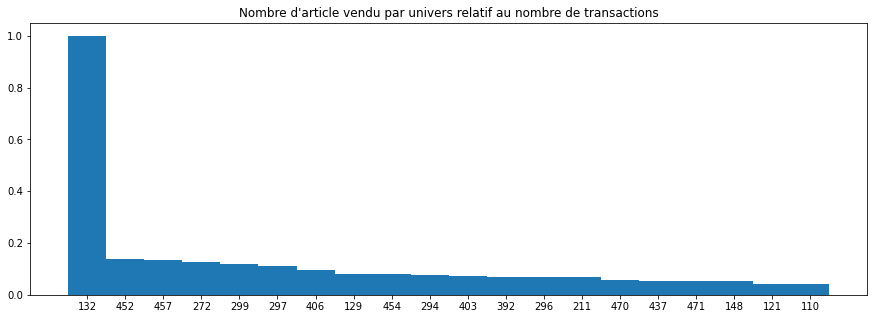

("Proportion d'achat (%)", 0.51)
('Proportion achat seul (%)', 3.94)
("Nombre moyen d'univ", 1.22)
('CA univ', 54446.44)
('CA moyen univ', 2.8)
('Nombre moyen article en plus', 5.35)
('CA en plus', 357902.07)
('CA moyen en plus', 18.37)
==============133===================
23685
Time Taken to load recurence: ~0secondes


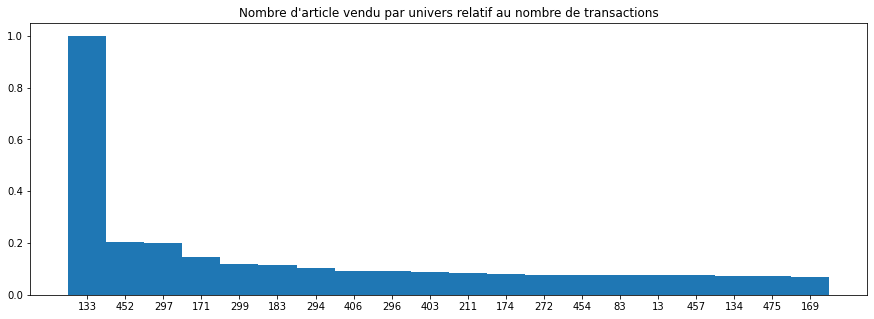

("Proportion d'achat (%)", 0.62)
('Proportion achat seul (%)', 4.5)
("Nombre moyen d'univ", 1.19)
('CA univ', 64218.95)
('CA moyen univ', 2.71)
('Nombre moyen article en plus', 7.46)
('CA en plus', 604671.63)
('CA moyen en plus', 25.53)
==============134===================
35967
Time Taken to load recurence: ~0secondes


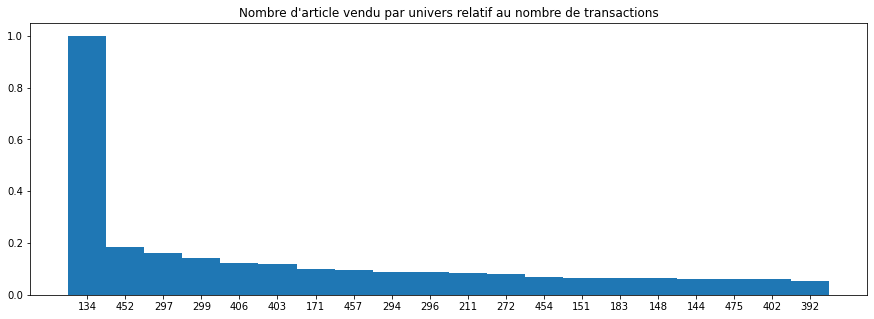

("Proportion d'achat (%)", 0.95)
('Proportion achat seul (%)', 2.58)
("Nombre moyen d'univ", 1.54)
('CA univ', 95612.51)
('CA moyen univ', 2.66)
('Nombre moyen article en plus', 6.82)
('CA en plus', 841325.25)
('CA moyen en plus', 23.39)
==============135===================
12471
Time Taken to load recurence: ~0secondes


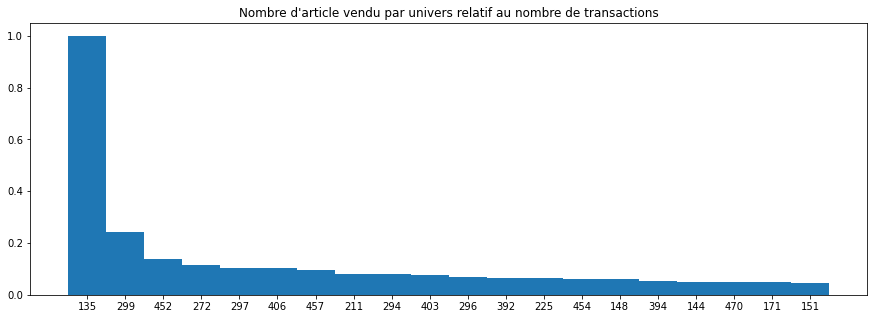

("Proportion d'achat (%)", 0.33)
('Proportion achat seul (%)', 4.8)
("Nombre moyen d'univ", 1.21)
('CA univ', 38094.1)
('CA moyen univ', 3.05)
('Nombre moyen article en plus', 5.66)
('CA en plus', 236225.42)
('CA moyen en plus', 18.94)
==============136===================
10214
Time Taken to load recurence: ~0secondes


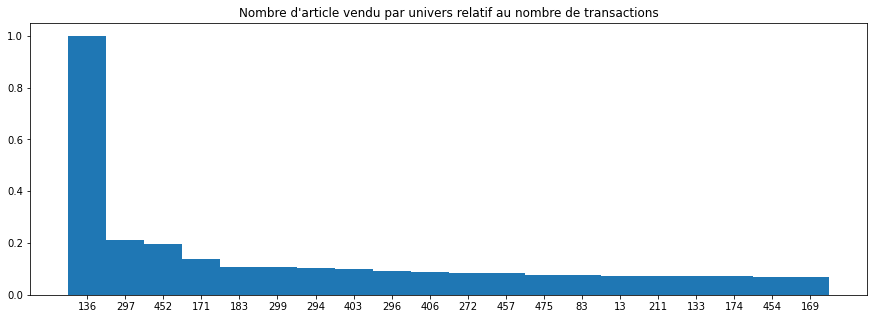

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 5.54)
("Nombre moyen d'univ", 1.18)
('CA univ', 25394.09)
('CA moyen univ', 2.49)
('Nombre moyen article en plus', 7.35)
('CA en plus', 255905.22)
('CA moyen en plus', 25.05)
==============137===================
22366
Time Taken to load recurence: ~0secondes


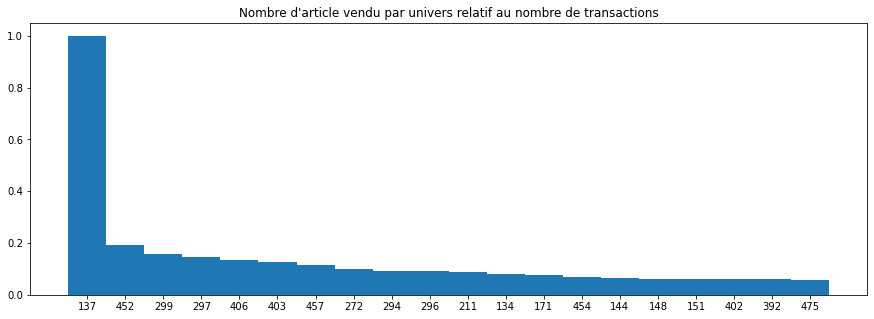

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 2.65)
("Nombre moyen d'univ", 1.52)
('CA univ', 51668.83)
('CA moyen univ', 2.31)
('Nombre moyen article en plus', 6.76)
('CA en plus', 514779.28)
('CA moyen en plus', 23.02)
==============138===================
NOT ENOUGH DATA 
==============139===================
17271
Time Taken to load recurence: ~0secondes


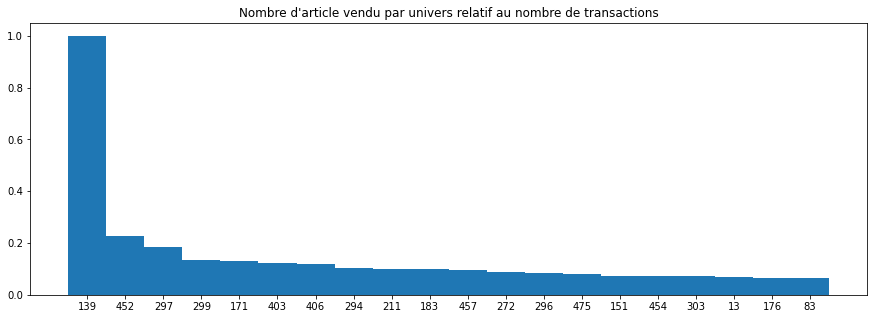

("Proportion d'achat (%)", 0.46)
('Proportion achat seul (%)', 3.09)
("Nombre moyen d'univ", 1.17)
('CA univ', 51177.19)
('CA moyen univ', 2.96)
('Nombre moyen article en plus', 7.86)
('CA en plus', 484114.71)
('CA moyen en plus', 28.03)
==============140===================
3766
Time Taken to load recurence: ~0secondes


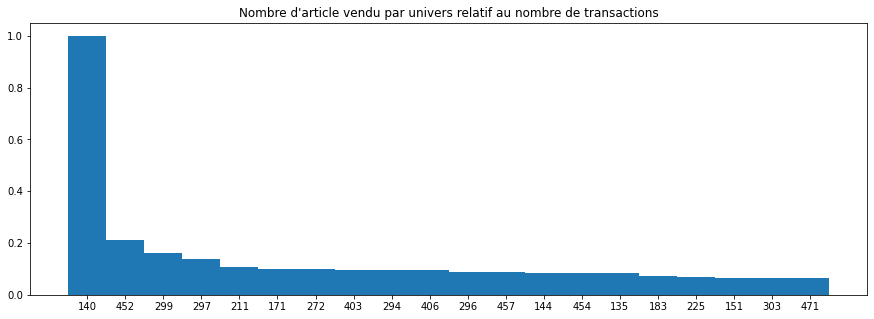

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 3.13)
("Nombre moyen d'univ", 1.18)
('CA univ', 16131.05)
('CA moyen univ', 4.28)
('Nombre moyen article en plus', 8.16)
('CA en plus', 101766.36)
('CA moyen en plus', 27.02)
==============141===================
14538
Time Taken to load recurence: ~0secondes


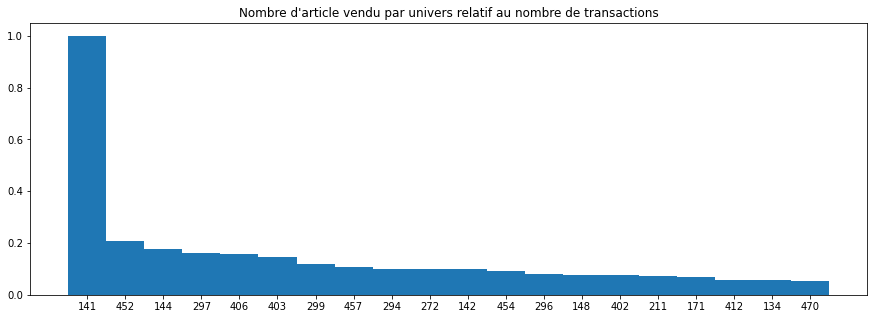

("Proportion d'achat (%)", 0.38)
('Proportion achat seul (%)', 2.51)
("Nombre moyen d'univ", 1.25)
('CA univ', 43027.61)
('CA moyen univ', 2.96)
('Nombre moyen article en plus', 7.38)
('CA en plus', 381434.73)
('CA moyen en plus', 26.24)
==============142===================
34291
Time Taken to load recurence: ~0secondes


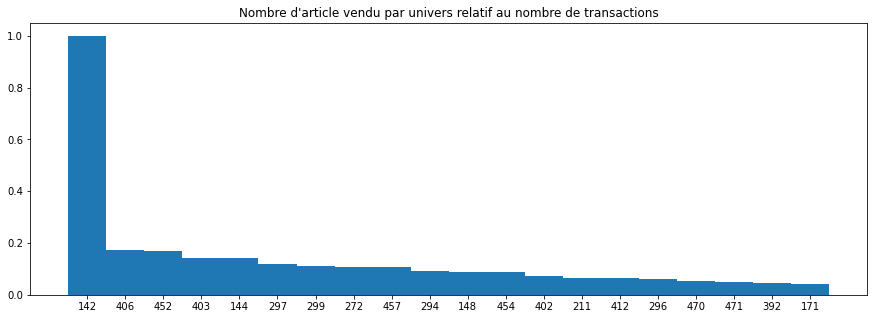

("Proportion d'achat (%)", 0.9)
('Proportion achat seul (%)', 4.16)
("Nombre moyen d'univ", 1.23)
('CA univ', 128059.58)
('CA moyen univ', 3.73)
('Nombre moyen article en plus', 6.07)
('CA en plus', 764930.52)
('CA moyen en plus', 22.31)
==============143===================
2052
Time Taken to load recurence: ~0secondes


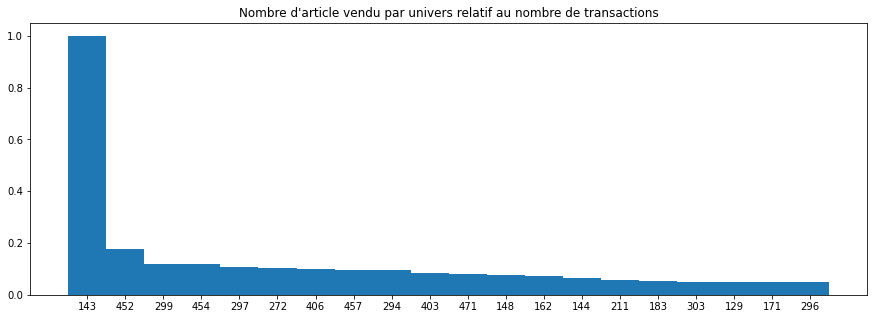

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 8.63)
("Nombre moyen d'univ", 1.1)
('CA univ', 8672.96)
('CA moyen univ', 4.23)
('Nombre moyen article en plus', 6.03)
('CA en plus', 42840.75)
('CA moyen en plus', 20.88)
==============144===================
56525
Time Taken to load recurence: ~0secondes


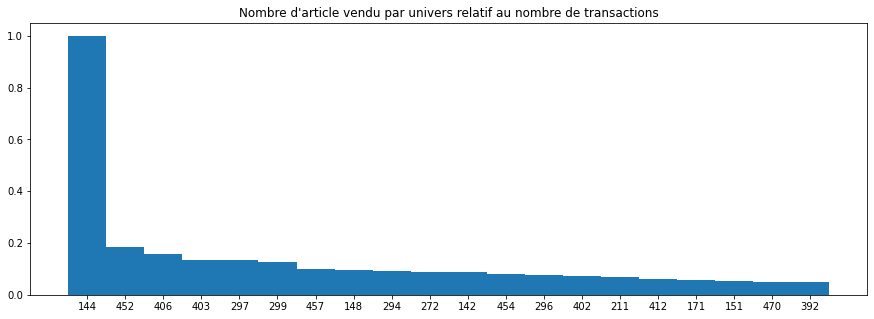

("Proportion d'achat (%)", 1.49)
('Proportion achat seul (%)', 3.5)
("Nombre moyen d'univ", 1.25)
('CA univ', 207777.57)
('CA moyen univ', 3.68)
('Nombre moyen article en plus', 6.43)
('CA en plus', 1301548.57)
('CA moyen en plus', 23.03)
==============145===================
4231
Time Taken to load recurence: ~0secondes


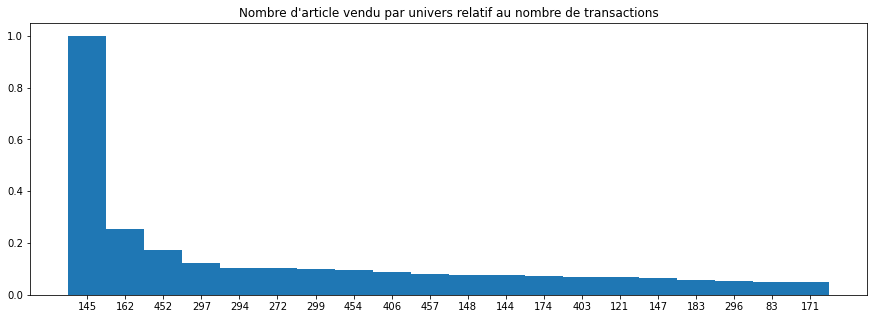

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 7.28)
("Nombre moyen d'univ", 1.06)
('CA univ', 19477.8)
('CA moyen univ', 4.6)
('Nombre moyen article en plus', 6.52)
('CA en plus', 107223.65)
('CA moyen en plus', 25.34)
==============146===================
1294
Time Taken to load recurence: ~0secondes


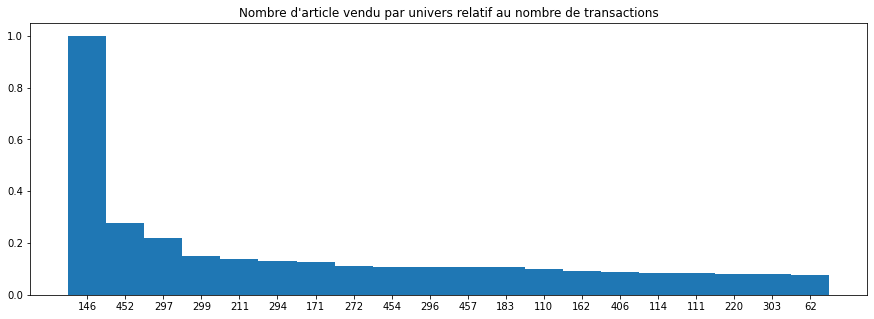

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 2.63)
("Nombre moyen d'univ", 1.11)
('CA univ', 4736.31)
('CA moyen univ', 3.66)
('Nombre moyen article en plus', 9.19)
('CA en plus', 39877.34)
('CA moyen en plus', 30.82)
==============147===================
51921
Time Taken to load recurence: ~0secondes


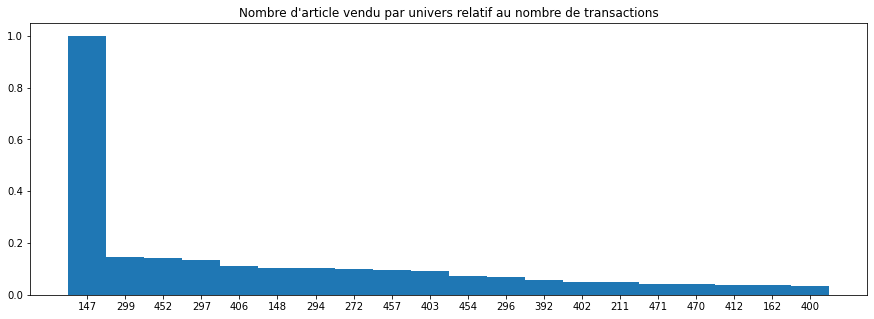

("Proportion d'achat (%)", 1.37)
('Proportion achat seul (%)', 10.0)
("Nombre moyen d'univ", 1.15)
('CA univ', 411847.7)
('CA moyen univ', 7.93)
('Nombre moyen article en plus', 5.06)
('CA en plus', 957696.49)
('CA moyen en plus', 18.45)
==============148===================
149110
Time Taken to load recurence: ~0secondes


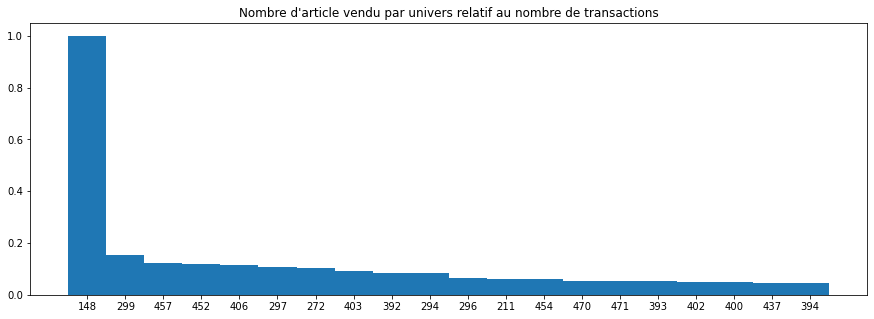

("Proportion d'achat (%)", 3.93)
('Proportion achat seul (%)', 5.98)
("Nombre moyen d'univ", 1.39)
('CA univ', 460151.99)
('CA moyen univ', 3.09)
('Nombre moyen article en plus', 4.77)
('CA en plus', 2463435.88)
('CA moyen en plus', 16.52)
==============149===================
22545
Time Taken to load recurence: ~0secondes


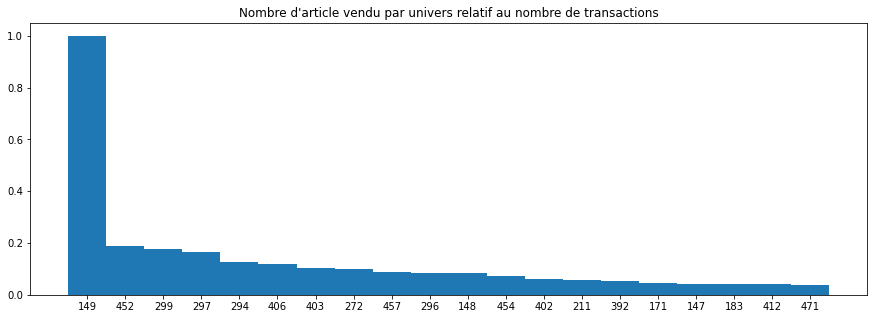

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 6.2)
("Nombre moyen d'univ", 1.12)
('CA univ', 115526.46)
('CA moyen univ', 5.12)
('Nombre moyen article en plus', 6.14)
('CA en plus', 482319.08)
('CA moyen en plus', 21.39)
==============150===================
4951
Time Taken to load recurence: ~0secondes


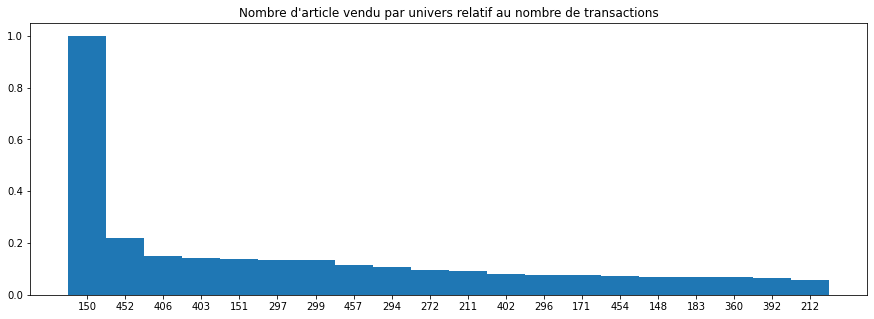

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 3.45)
("Nombre moyen d'univ", 1.05)
('CA univ', 31429.46)
('CA moyen univ', 6.35)
('Nombre moyen article en plus', 7.16)
('CA en plus', 134848.76)
('CA moyen en plus', 27.24)
==============151===================
71009
Time Taken to load recurence: ~0secondes


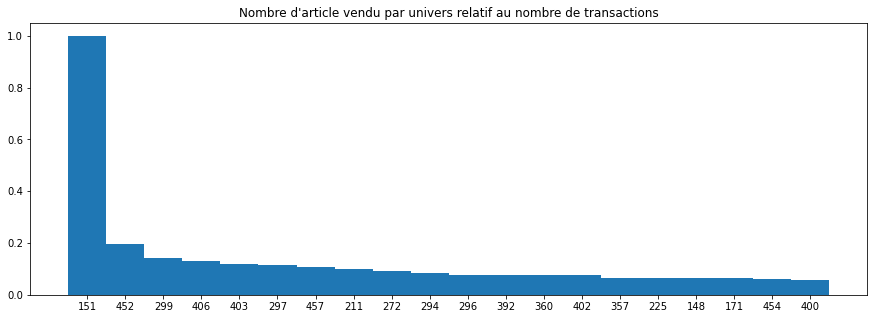

("Proportion d'achat (%)", 1.87)
('Proportion achat seul (%)', 2.47)
("Nombre moyen d'univ", 1.24)
('CA univ', 343172.44)
('CA moyen univ', 4.83)
('Nombre moyen article en plus', 6.3)
('CA en plus', 1572225.2)
('CA moyen en plus', 22.14)
==============152===================
461
Time Taken to load recurence: ~0secondes


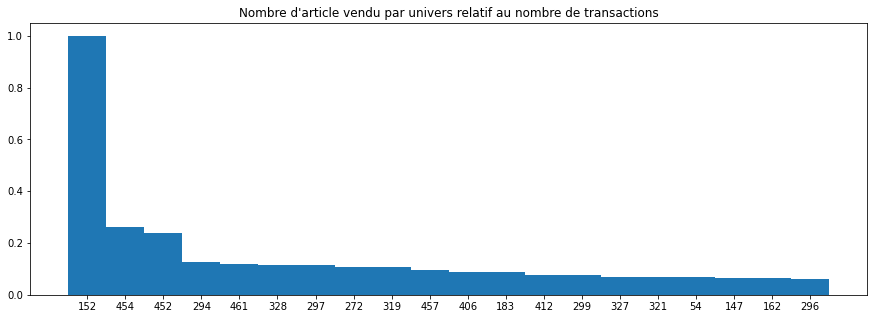

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 2.6)
("Nombre moyen d'univ", 1.13)
('CA univ', 6330.72)
('CA moyen univ', 13.73)
('Nombre moyen article en plus', 7.78)
('CA en plus', 15558.49)
('CA moyen en plus', 33.75)
==============153===================
3769
Time Taken to load recurence: ~0secondes


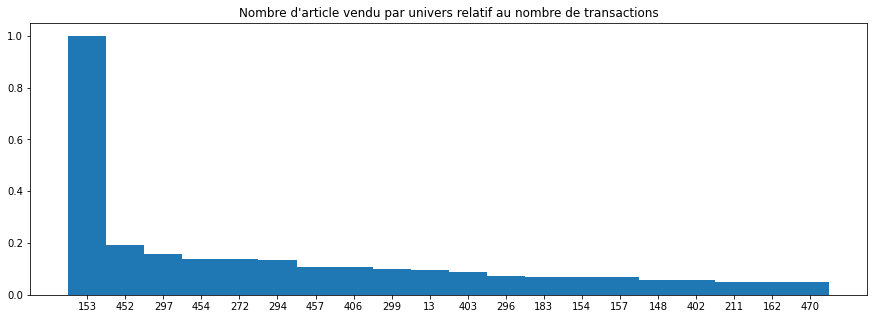

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.38)
("Nombre moyen d'univ", 1.36)
('CA univ', 27008.61)
('CA moyen univ', 7.17)
('Nombre moyen article en plus', 6.49)
('CA en plus', 90505.32)
('CA moyen en plus', 24.01)
==============154===================
41286
Time Taken to load recurence: ~0secondes


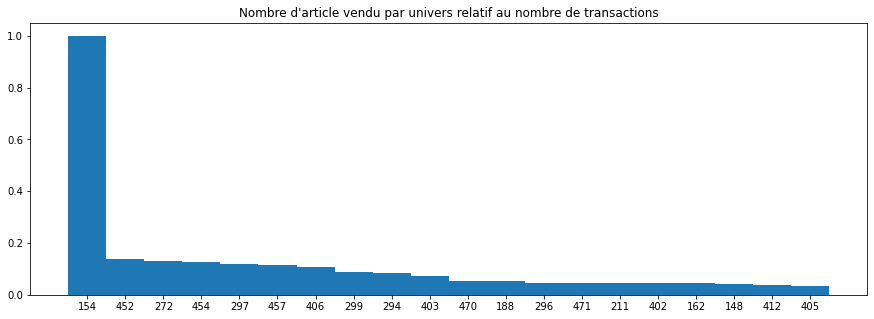

("Proportion d'achat (%)", 1.09)
('Proportion achat seul (%)', 12.45)
("Nombre moyen d'univ", 1.54)
('CA univ', 288826.8)
('CA moyen univ', 7.0)
('Nombre moyen article en plus', 4.61)
('CA en plus', 699309.04)
('CA moyen en plus', 16.94)
==============155===================
3785
Time Taken to load recurence: ~0secondes


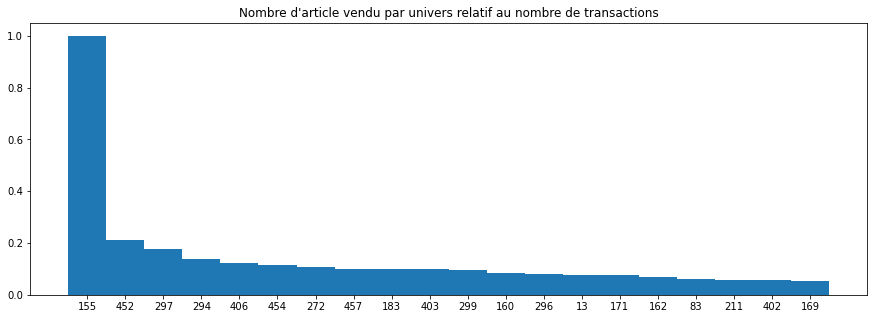

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.25)
("Nombre moyen d'univ", 1.2)
('CA univ', 34687.24)
('CA moyen univ', 9.16)
('Nombre moyen article en plus', 7.4)
('CA en plus', 102749.14)
('CA moyen en plus', 27.15)
==============156===================
5367
Time Taken to load recurence: ~0secondes


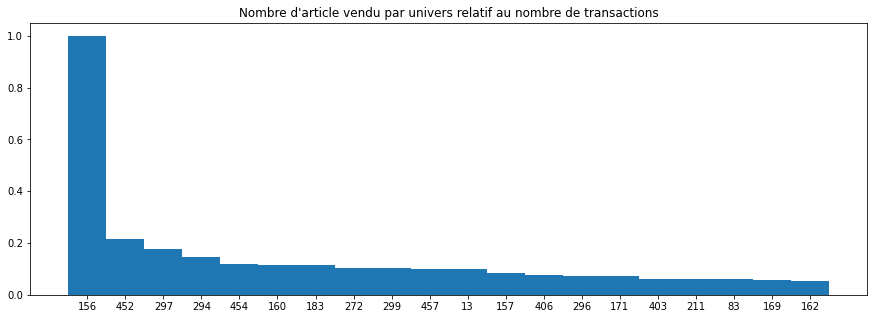

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 5.16)
("Nombre moyen d'univ", 1.21)
('CA univ', 40813.17)
('CA moyen univ', 7.6)
('Nombre moyen article en plus', 7.3)
('CA en plus', 137999.78)
('CA moyen en plus', 25.71)
==============157===================
26666
Time Taken to load recurence: ~0secondes


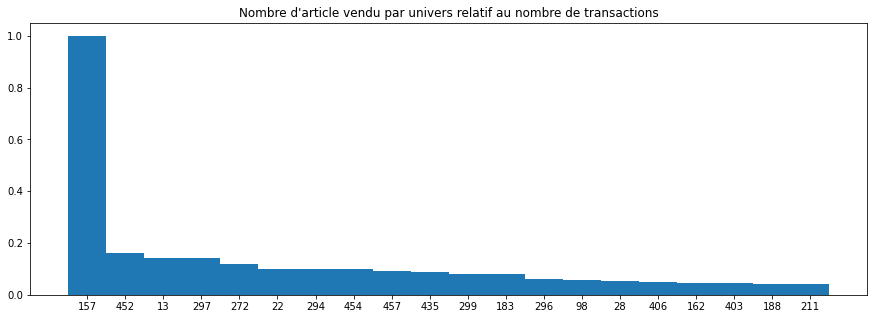

("Proportion d'achat (%)", 0.7)
('Proportion achat seul (%)', 12.07)
("Nombre moyen d'univ", 1.15)
('CA univ', 106751.33)
('CA moyen univ', 4.0)
('Nombre moyen article en plus', 5.39)
('CA en plus', 532678.47)
('CA moyen en plus', 19.98)
==============158===================
508
Time Taken to load recurence: ~0secondes


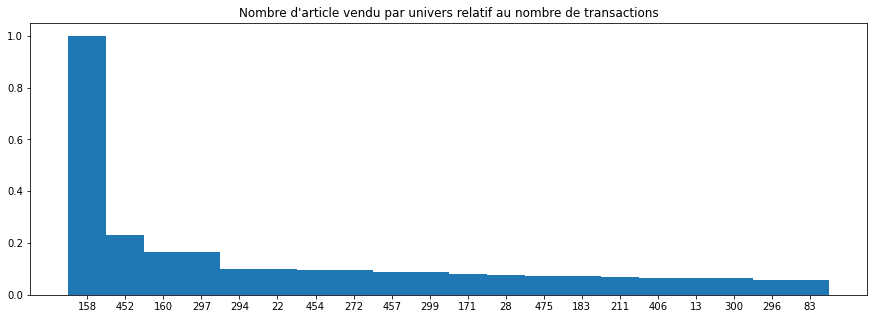

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 4.53)
("Nombre moyen d'univ", 1.14)
('CA univ', 2053.92)
('CA moyen univ', 4.04)
('Nombre moyen article en plus', 7.35)
('CA en plus', 13268.79)
('CA moyen en plus', 26.12)
==============159===================
2060
Time Taken to load recurence: ~0secondes


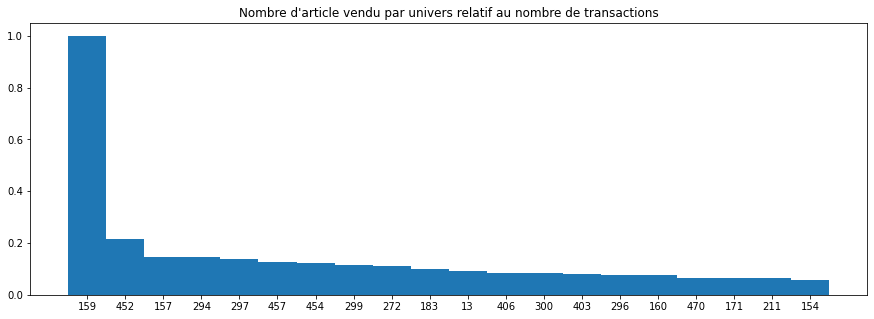

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 3.83)
("Nombre moyen d'univ", 1.25)
('CA univ', 10243.41)
('CA moyen univ', 4.97)
('Nombre moyen article en plus', 7.09)
('CA en plus', 51059.09)
('CA moyen en plus', 24.79)
==============160===================
13448
Time Taken to load recurence: ~0secondes


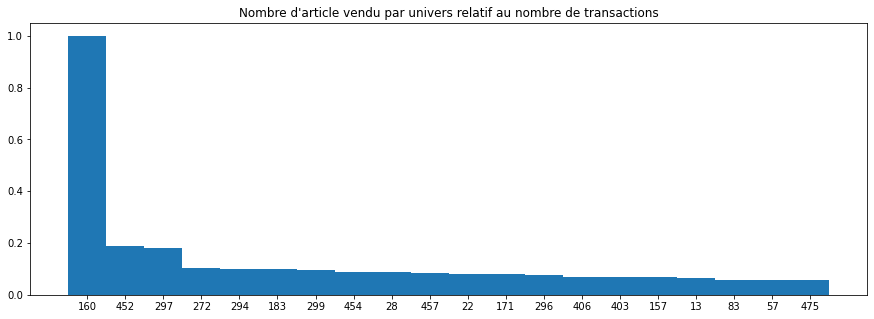

("Proportion d'achat (%)", 0.35)
('Proportion achat seul (%)', 6.19)
("Nombre moyen d'univ", 1.23)
('CA univ', 52844.53)
('CA moyen univ', 3.93)
('Nombre moyen article en plus', 6.9)
('CA en plus', 331964.77)
('CA moyen en plus', 24.69)
==============162===================
78276
Time Taken to load recurence: ~0secondes


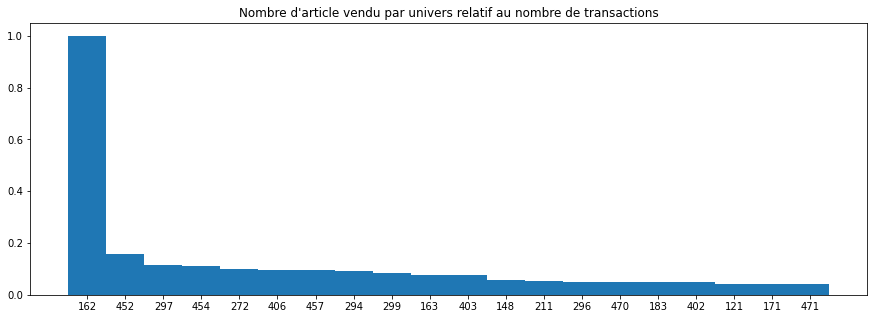

("Proportion d'achat (%)", 2.06)
('Proportion achat seul (%)', 12.38)
("Nombre moyen d'univ", 1.34)
('CA univ', 711492.44)
('CA moyen univ', 9.09)
('Nombre moyen article en plus', 5.25)
('CA en plus', 1488010.41)
('CA moyen en plus', 19.01)
==============163===================
41906
Time Taken to load recurence: ~0secondes


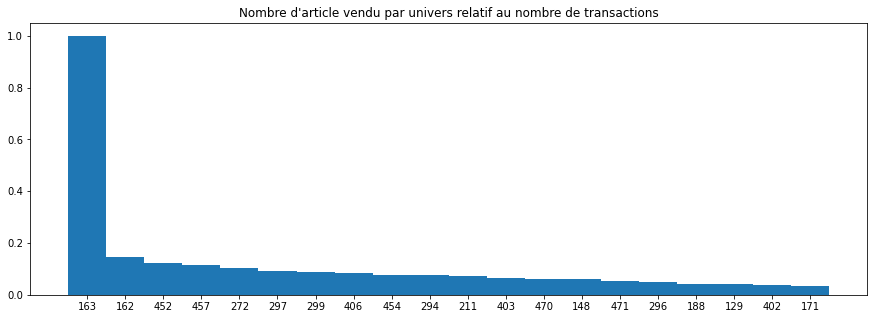

("Proportion d'achat (%)", 1.1)
('Proportion achat seul (%)', 13.03)
("Nombre moyen d'univ", 1.59)
('CA univ', 157729.39)
('CA moyen univ', 3.76)
('Nombre moyen article en plus', 4.57)
('CA en plus', 679611.88)
('CA moyen en plus', 16.22)
==============164===================
163
Time Taken to load recurence: ~0secondes


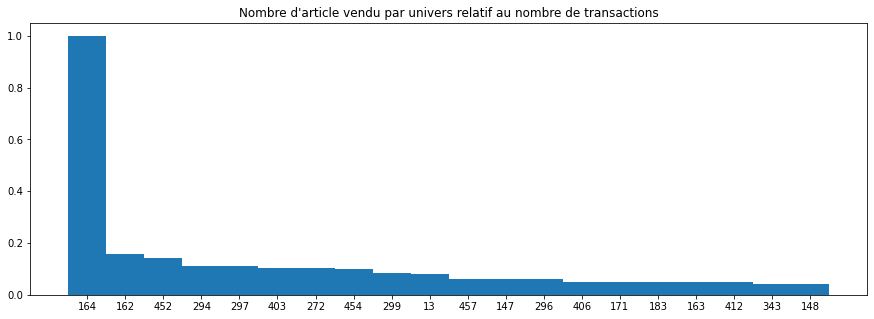

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 11.66)
("Nombre moyen d'univ", 1.38)
('CA univ', 4123.55)
('CA moyen univ', 25.3)
('Nombre moyen article en plus', 5.25)
('CA en plus', 3757.32)
('CA moyen en plus', 23.05)
==============165===================
NOT ENOUGH DATA 
==============168===================
7744
Time Taken to load recurence: ~0secondes


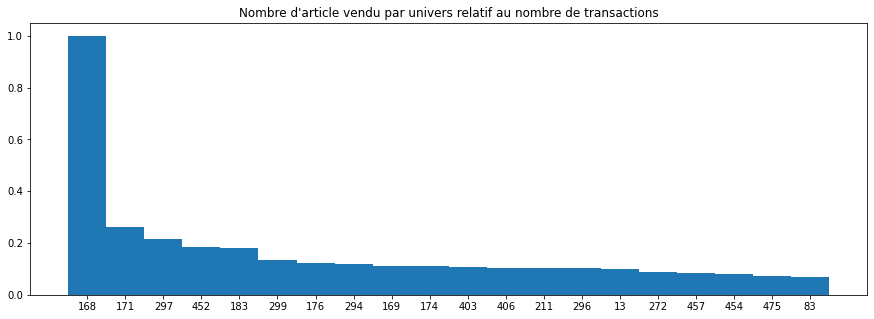

("Proportion d'achat (%)", 0.2)
('Proportion achat seul (%)', 1.85)
("Nombre moyen d'univ", 1.13)
('CA univ', 29454.93)
('CA moyen univ', 3.8)
('Nombre moyen article en plus', 8.79)
('CA en plus', 238776.79)
('CA moyen en plus', 30.83)
==============169===================
43427
Time Taken to load recurence: ~0secondes


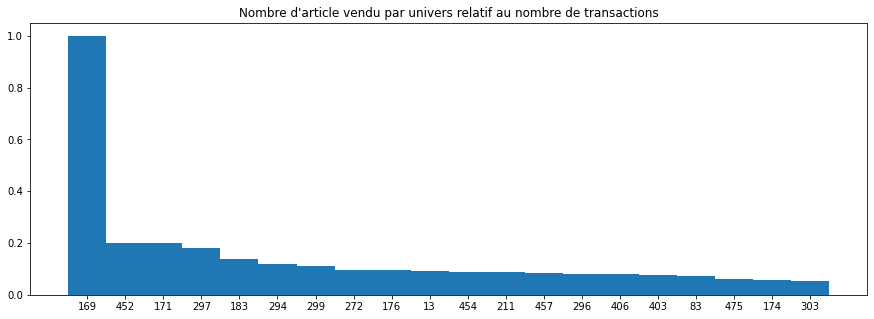

("Proportion d'achat (%)", 1.14)
('Proportion achat seul (%)', 5.59)
("Nombre moyen d'univ", 1.29)
('CA univ', 112001.94)
('CA moyen univ', 2.58)
('Nombre moyen article en plus', 7.41)
('CA en plus', 1131876.98)
('CA moyen en plus', 26.06)
==============170===================
4595
Time Taken to load recurence: ~0secondes


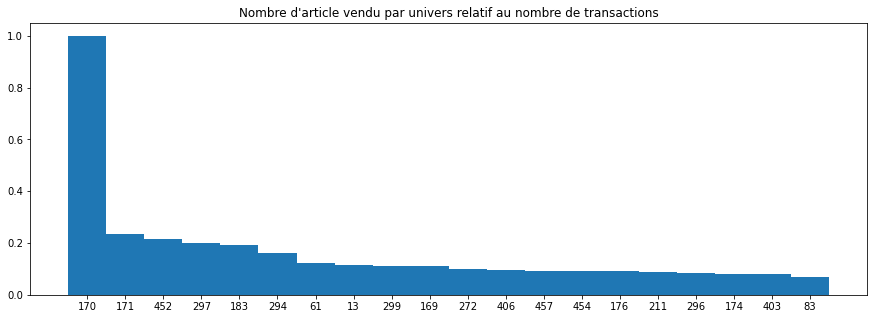

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 2.68)
("Nombre moyen d'univ", 1.18)
('CA univ', 18065.85)
('CA moyen univ', 3.93)
('Nombre moyen article en plus', 8.59)
('CA en plus', 139690.6)
('CA moyen en plus', 30.4)
==============171===================
88280
Time Taken to load recurence: ~0secondes


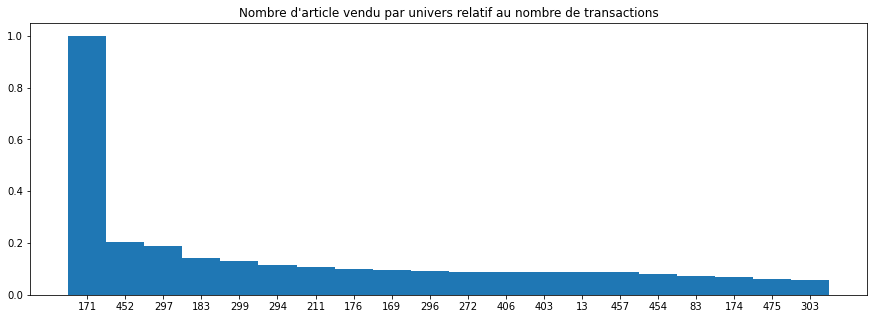

("Proportion d'achat (%)", 2.33)
('Proportion achat seul (%)', 3.59)
("Nombre moyen d'univ", 1.23)
('CA univ', 226764.44)
('CA moyen univ', 2.57)
('Nombre moyen article en plus', 7.24)
('CA en plus', 2186950.89)
('CA moyen en plus', 24.77)
==============172===================
1830
Time Taken to load recurence: ~0secondes


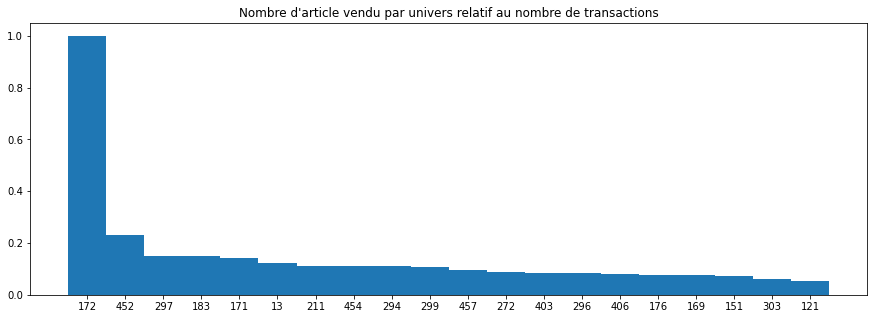

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 3.39)
("Nombre moyen d'univ", 1.08)
('CA univ', 12352.12)
('CA moyen univ', 6.75)
('Nombre moyen article en plus', 8.42)
('CA en plus', 53633.26)
('CA moyen en plus', 29.31)
==============173===================
12854
Time Taken to load recurence: ~0secondes


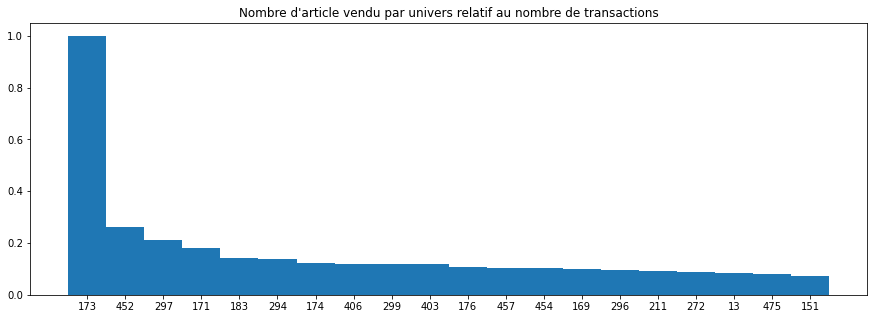

("Proportion d'achat (%)", 0.34)
('Proportion achat seul (%)', 2.13)
("Nombre moyen d'univ", 1.06)
('CA univ', 52868.11)
('CA moyen univ', 4.11)
('Nombre moyen article en plus', 8.95)
('CA en plus', 401786.35)
('CA moyen en plus', 31.26)
==============174===================
31543
Time Taken to load recurence: ~0secondes


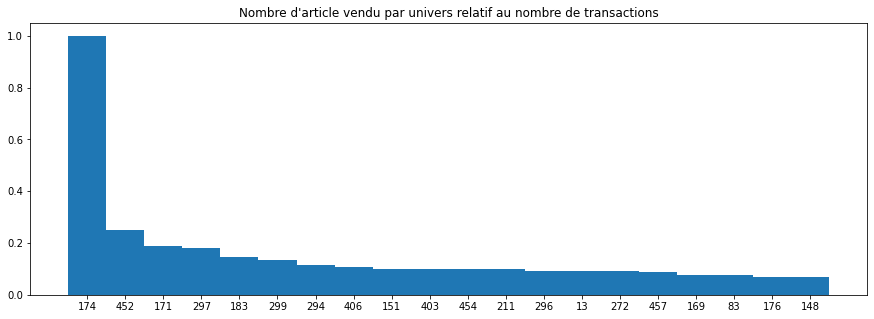

("Proportion d'achat (%)", 0.83)
('Proportion achat seul (%)', 2.05)
("Nombre moyen d'univ", 1.37)
('CA univ', 169786.43)
('CA moyen univ', 5.38)
('Nombre moyen article en plus', 8.61)
('CA en plus', 964725.84)
('CA moyen en plus', 30.58)
==============175===================
2954
Time Taken to load recurence: ~0secondes


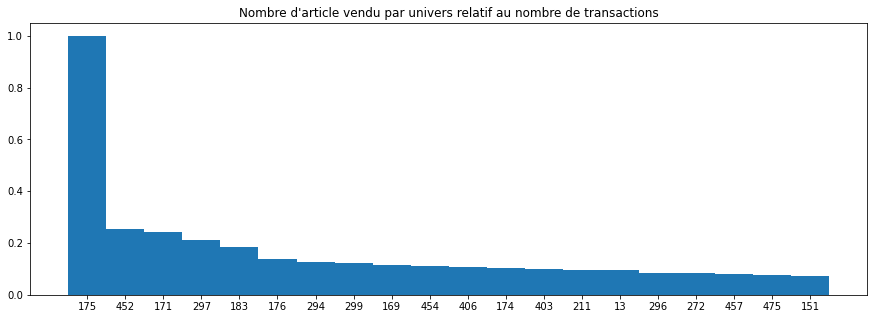

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 1.52)
("Nombre moyen d'univ", 1.07)
('CA univ', 13222.3)
('CA moyen univ', 4.48)
('Nombre moyen article en plus', 9.33)
('CA en plus', 95865.86)
('CA moyen en plus', 32.45)
==============176===================
40900
Time Taken to load recurence: ~0secondes


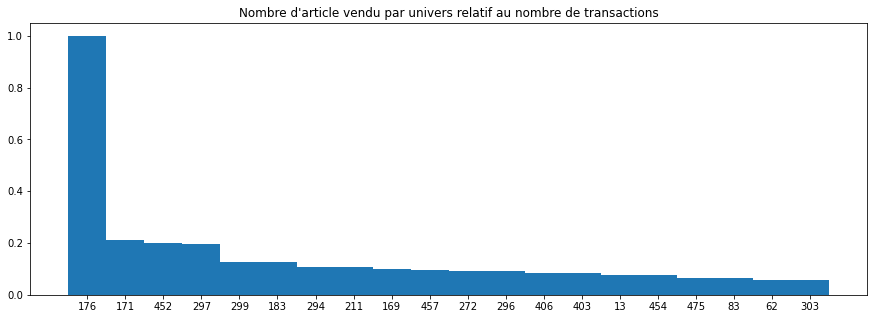

("Proportion d'achat (%)", 1.08)
('Proportion achat seul (%)', 3.49)
("Nombre moyen d'univ", 1.15)
('CA univ', 123824.16)
('CA moyen univ', 3.03)
('Nombre moyen article en plus', 7.42)
('CA en plus', 1016143.71)
('CA moyen en plus', 24.84)
==============177===================
18420
Time Taken to load recurence: ~0secondes


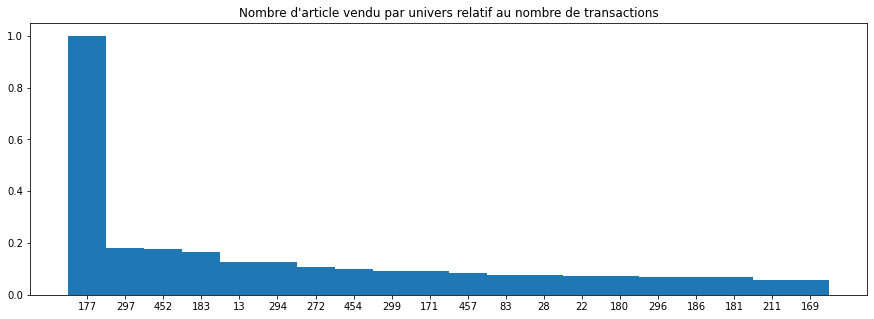

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 8.92)
("Nombre moyen d'univ", 1.07)
('CA univ', 70147.5)
('CA moyen univ', 3.81)
('Nombre moyen article en plus', 6.89)
('CA en plus', 429202.44)
('CA moyen en plus', 23.3)
==============178===================
4917
Time Taken to load recurence: ~0secondes


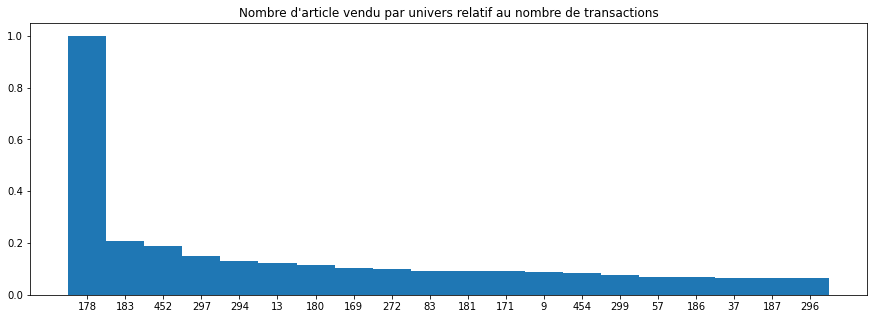

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 6.41)
("Nombre moyen d'univ", 1.04)
('CA univ', 9289.73)
('CA moyen univ', 1.89)
('Nombre moyen article en plus', 7.22)
('CA en plus', 122641.65)
('CA moyen en plus', 24.94)
==============179===================
738
Time Taken to load recurence: ~0secondes


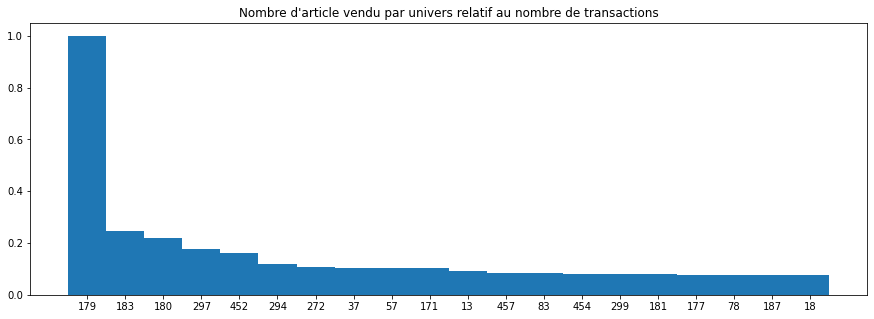

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 4.61)
("Nombre moyen d'univ", 1.02)
('CA univ', 1481.63)
('CA moyen univ', 2.01)
('Nombre moyen article en plus', 7.9)
('CA en plus', 19960.01)
('CA moyen en plus', 27.05)
==============180===================
19600
Time Taken to load recurence: ~0secondes


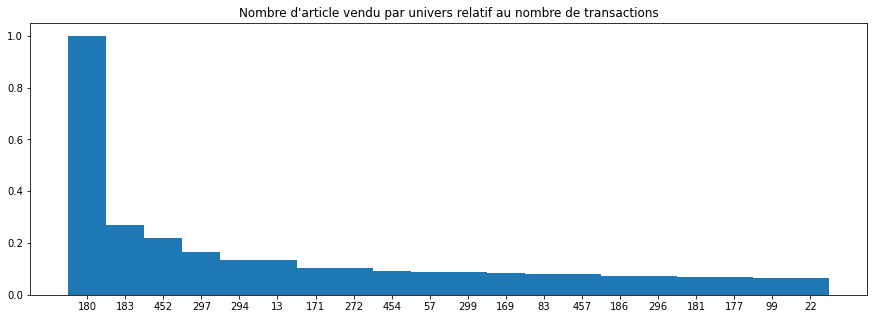

("Proportion d'achat (%)", 0.52)
('Proportion achat seul (%)', 6.34)
("Nombre moyen d'univ", 1.12)
('CA univ', 45673.31)
('CA moyen univ', 2.33)
('Nombre moyen article en plus', 7.79)
('CA en plus', 522738.12)
('CA moyen en plus', 26.67)
==============181===================
22301
Time Taken to load recurence: ~0secondes


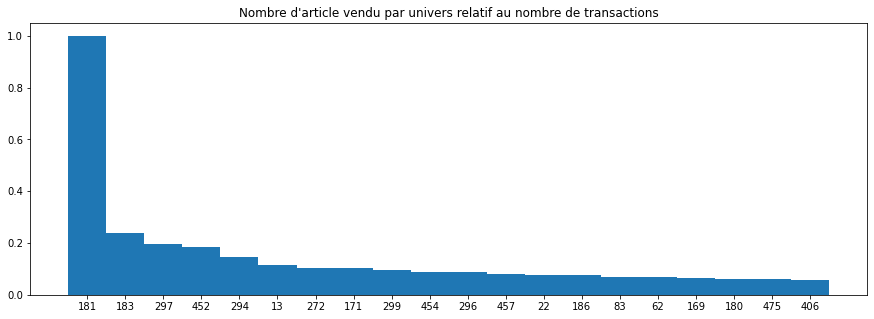

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 5.86)
("Nombre moyen d'univ", 1.13)
('CA univ', 54260.22)
('CA moyen univ', 2.43)
('Nombre moyen article en plus', 7.38)
('CA en plus', 604622.84)
('CA moyen en plus', 27.11)
==============182===================
6543
Time Taken to load recurence: ~0secondes


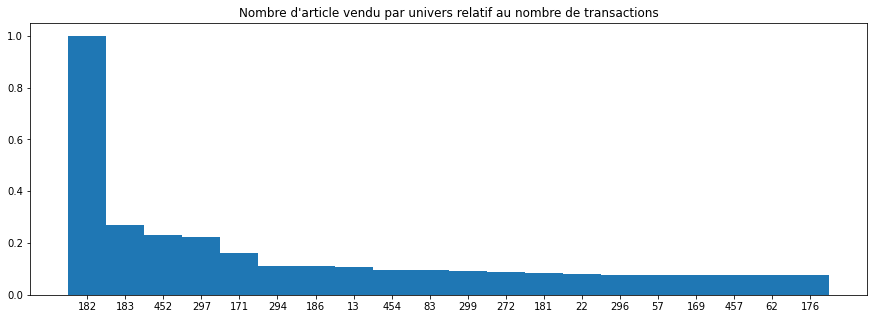

("Proportion d'achat (%)", 0.17)
('Proportion achat seul (%)', 3.59)
("Nombre moyen d'univ", 1.11)
('CA univ', 15708.61)
('CA moyen univ', 2.4)
('Nombre moyen article en plus', 8.4)
('CA en plus', 187080.45)
('CA moyen en plus', 28.59)
==============183===================
93764
Time Taken to load recurence: ~0secondes


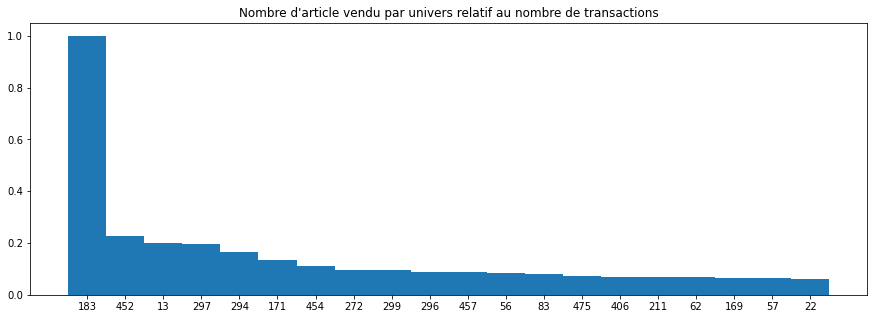

("Proportion d'achat (%)", 2.47)
('Proportion achat seul (%)', 3.04)
("Nombre moyen d'univ", 1.36)
('CA univ', 276801.23)
('CA moyen univ', 2.95)
('Nombre moyen article en plus', 7.82)
('CA en plus', 2577923.18)
('CA moyen en plus', 27.49)
==============184===================
5835
Time Taken to load recurence: ~0secondes


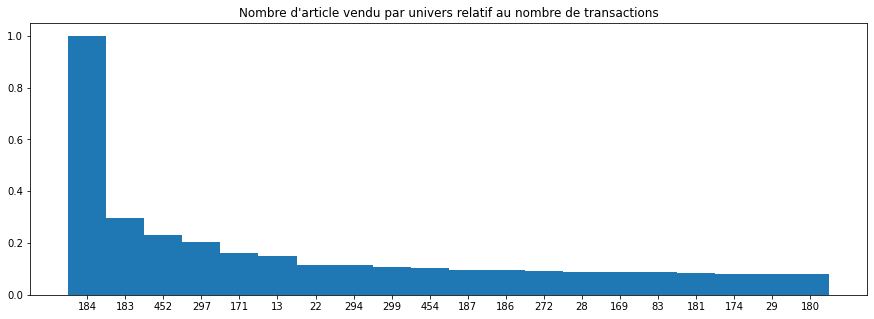

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 2.19)
("Nombre moyen d'univ", 1.18)
('CA univ', 22518.47)
('CA moyen univ', 3.86)
('Nombre moyen article en plus', 9.51)
('CA en plus', 198696.5)
('CA moyen en plus', 34.05)
==============186===================
19263
Time Taken to load recurence: ~0secondes


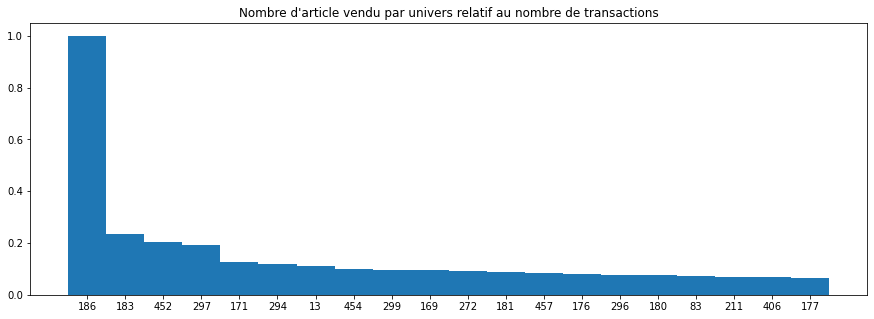

("Proportion d'achat (%)", 0.51)
('Proportion achat seul (%)', 5.39)
("Nombre moyen d'univ", 1.1)
('CA univ', 38916.03)
('CA moyen univ', 2.02)
('Nombre moyen article en plus', 7.67)
('CA en plus', 501982.62)
('CA moyen en plus', 26.06)
==============187===================
15040
Time Taken to load recurence: ~0secondes


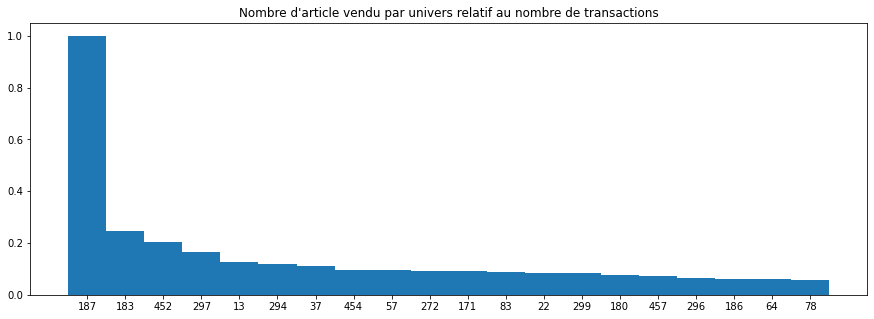

("Proportion d'achat (%)", 0.4)
('Proportion achat seul (%)', 5.07)
("Nombre moyen d'univ", 1.16)
('CA univ', 35226.87)
('CA moyen univ', 2.34)
('Nombre moyen article en plus', 7.31)
('CA en plus', 381075.29)
('CA moyen en plus', 25.34)
==============188===================
161216
Time Taken to load recurence: ~0secondes


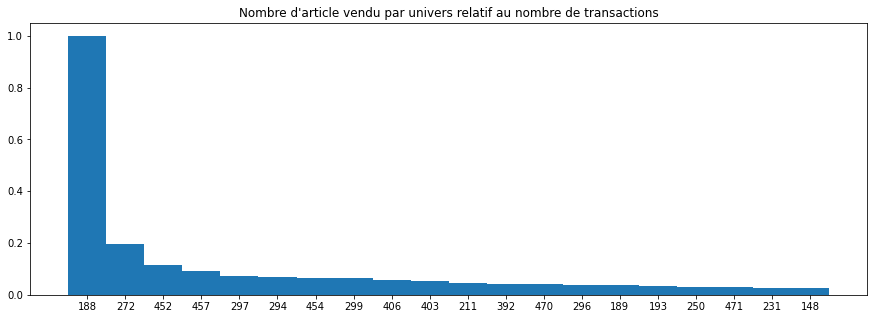

("Proportion d'achat (%)", 4.25)
('Proportion achat seul (%)', 21.08)
("Nombre moyen d'univ", 1.44)
('CA univ', 882769.6)
('CA moyen univ', 5.48)
('Nombre moyen article en plus', 3.36)
('CA en plus', 2010060.12)
('CA moyen en plus', 12.47)
==============189===================
61396
Time Taken to load recurence: ~0secondes


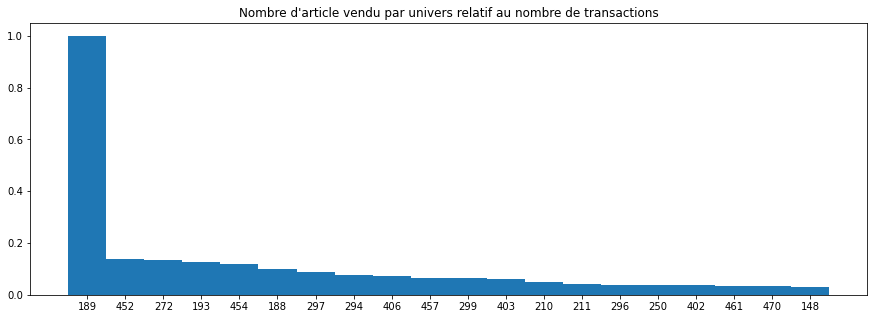

("Proportion d'achat (%)", 1.62)
('Proportion achat seul (%)', 13.48)
("Nombre moyen d'univ", 1.87)
('CA univ', 292970.09)
('CA moyen univ', 4.77)
('Nombre moyen article en plus', 4.25)
('CA en plus', 957253.63)
('CA moyen en plus', 15.59)
==============190===================
5845
Time Taken to load recurence: ~0secondes


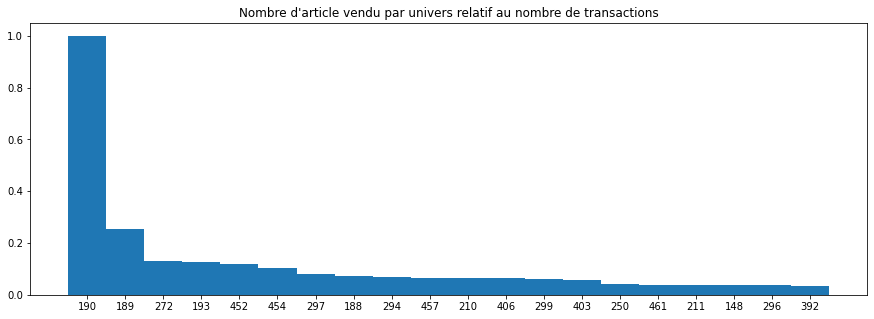

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 13.88)
("Nombre moyen d'univ", 1.4)
('CA univ', 21332.27)
('CA moyen univ', 3.65)
('Nombre moyen article en plus', 4.48)
('CA en plus', 90848.14)
('CA moyen en plus', 15.54)
==============191===================
1491
Time Taken to load recurence: ~0secondes


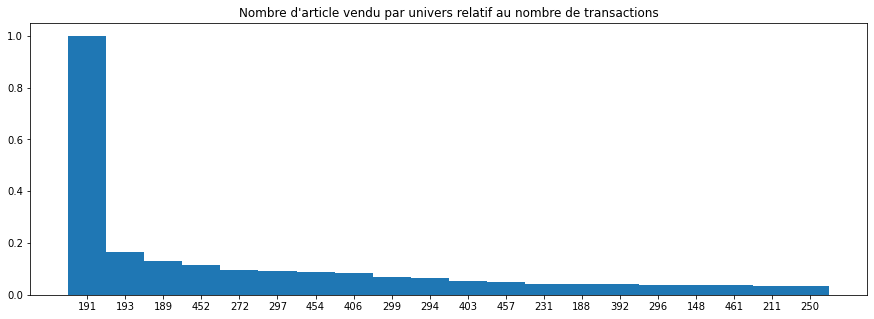

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 19.52)
("Nombre moyen d'univ", 1.31)
('CA univ', 6289.05)
('CA moyen univ', 4.22)
('Nombre moyen article en plus', 3.94)
('CA en plus', 19163.12)
('CA moyen en plus', 12.85)
==============192===================
7281
Time Taken to load recurence: ~0secondes


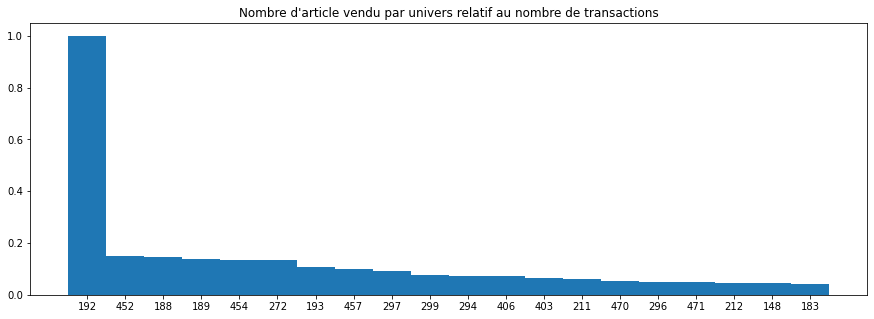

("Proportion d'achat (%)", 0.19)
('Proportion achat seul (%)', 8.17)
("Nombre moyen d'univ", 1.36)
('CA univ', 31789.04)
('CA moyen univ', 4.37)
('Nombre moyen article en plus', 5.43)
('CA en plus', 138271.35)
('CA moyen en plus', 18.99)
==============193===================
53721
Time Taken to load recurence: ~0secondes


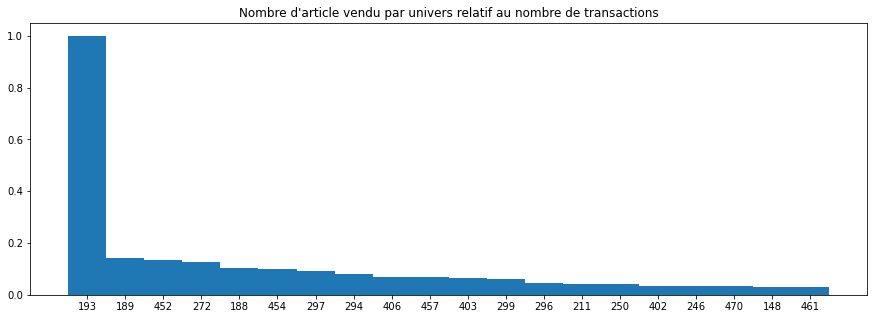

("Proportion d'achat (%)", 1.42)
('Proportion achat seul (%)', 14.07)
("Nombre moyen d'univ", 1.46)
('CA univ', 281319.65)
('CA moyen univ', 5.24)
('Nombre moyen article en plus', 4.28)
('CA en plus', 841678.8)
('CA moyen en plus', 15.67)
==============194===================
4311
Time Taken to load recurence: ~0secondes


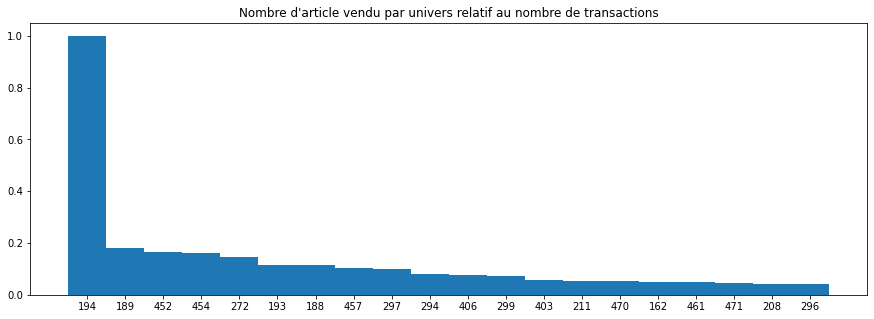

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 6.26)
("Nombre moyen d'univ", 1.37)
('CA univ', 14809.91)
('CA moyen univ', 3.44)
('Nombre moyen article en plus', 5.59)
('CA en plus', 85258.06)
('CA moyen en plus', 19.78)
==============195===================
1067
Time Taken to load recurence: ~0secondes


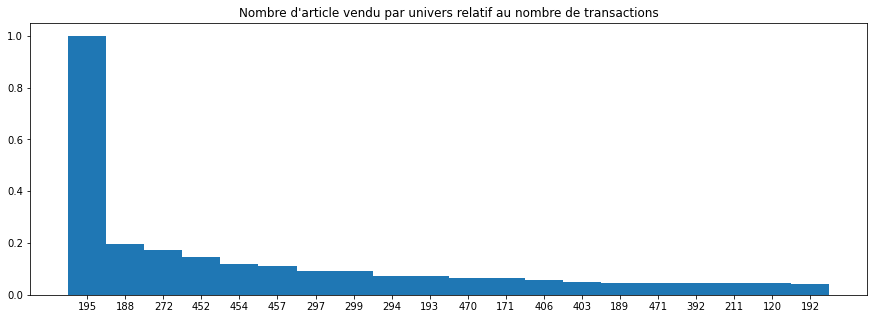

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 9.47)
("Nombre moyen d'univ", 1.25)
('CA univ', 3131.11)
('CA moyen univ', 2.93)
('Nombre moyen article en plus', 4.92)
('CA en plus', 17441.77)
('CA moyen en plus', 16.35)
==============196===================
24424
Time Taken to load recurence: ~0secondes


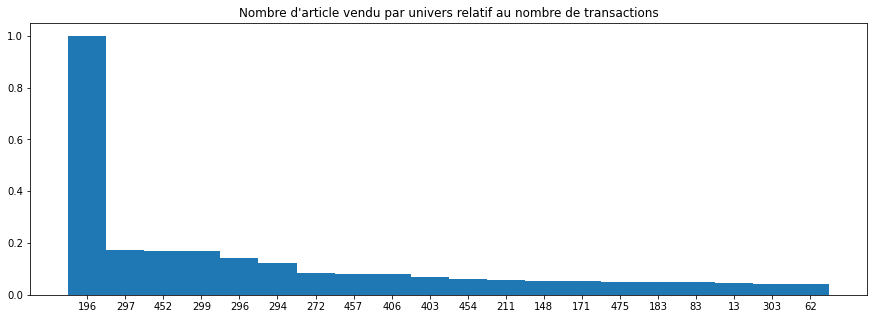

("Proportion d'achat (%)", 0.64)
('Proportion achat seul (%)', 7.62)
("Nombre moyen d'univ", 1.12)
('CA univ', 75046.06)
('CA moyen univ', 3.07)
('Nombre moyen article en plus', 5.72)
('CA en plus', 451966.64)
('CA moyen en plus', 18.51)
==============197===================
557
Time Taken to load recurence: ~0secondes


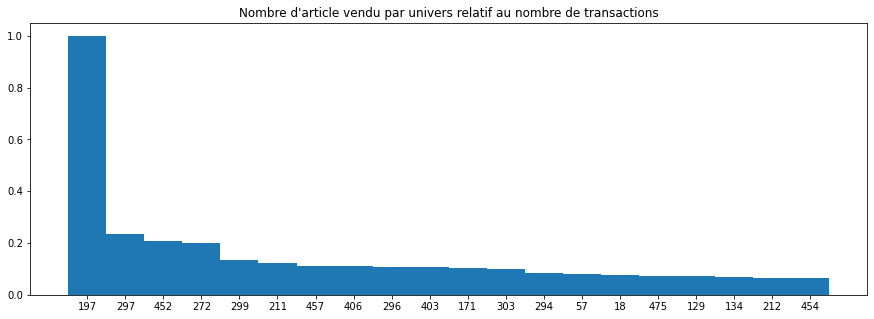

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 7.0)
("Nombre moyen d'univ", 1.08)
('CA univ', 2014.98)
('CA moyen univ', 3.62)
('Nombre moyen article en plus', 7.91)
('CA en plus', 14073.94)
('CA moyen en plus', 25.27)
==============198===================
54610
Time Taken to load recurence: ~0secondes


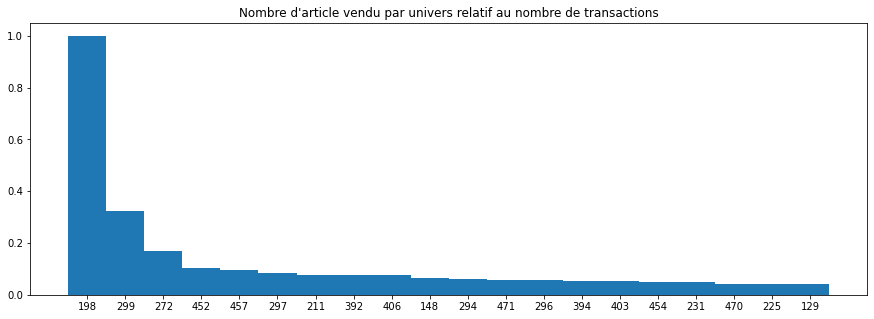

("Proportion d'achat (%)", 1.44)
('Proportion achat seul (%)', 7.03)
("Nombre moyen d'univ", 1.27)
('CA univ', 167544.81)
('CA moyen univ', 3.07)
('Nombre moyen article en plus', 4.61)
('CA en plus', 807911.63)
('CA moyen en plus', 14.79)
==============199===================
1970
Time Taken to load recurence: ~0secondes


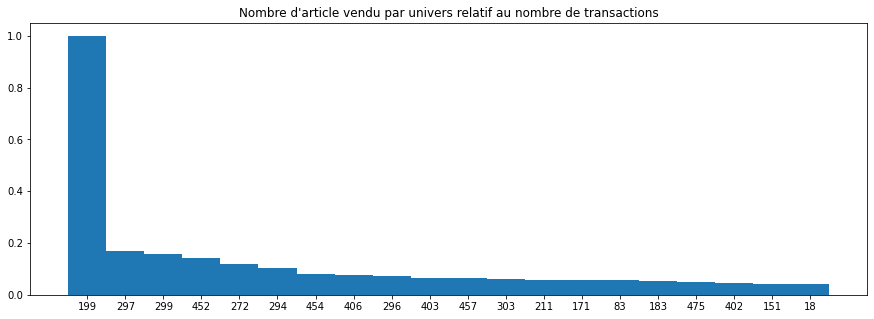

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 14.26)
("Nombre moyen d'univ", 1.18)
('CA univ', 16520.56)
('CA moyen univ', 8.39)
('Nombre moyen article en plus', 5.76)
('CA en plus', 41764.81)
('CA moyen en plus', 21.2)
==============200===================
10575
Time Taken to load recurence: ~0secondes


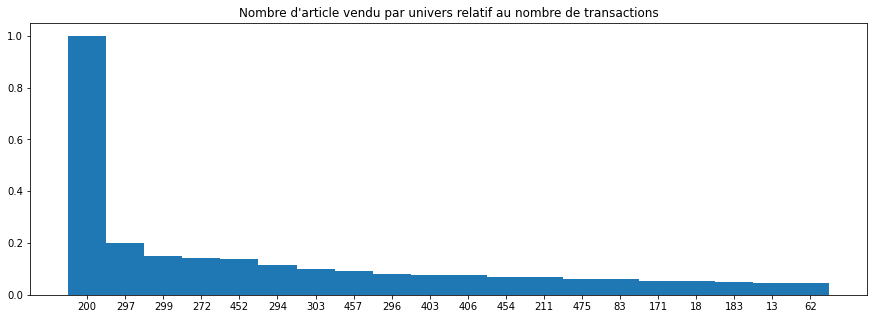

("Proportion d'achat (%)", 0.28)
('Proportion achat seul (%)', 10.04)
("Nombre moyen d'univ", 1.12)
('CA univ', 62036.95)
('CA moyen univ', 5.87)
('Nombre moyen article en plus', 6.33)
('CA en plus', 238434.39)
('CA moyen en plus', 22.55)
==============201===================
22267
Time Taken to load recurence: ~0secondes


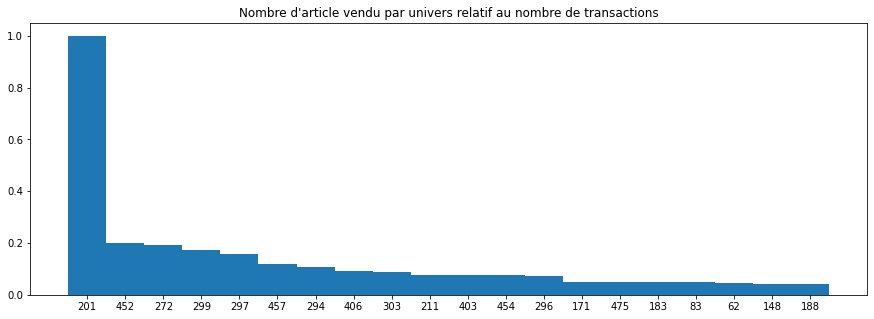

("Proportion d'achat (%)", 0.59)
('Proportion achat seul (%)', 8.98)
("Nombre moyen d'univ", 1.26)
('CA univ', 124677.53)
('CA moyen univ', 5.6)
('Nombre moyen article en plus', 6.13)
('CA en plus', 476542.94)
('CA moyen en plus', 21.4)
==============203===================
3671
Time Taken to load recurence: ~0secondes


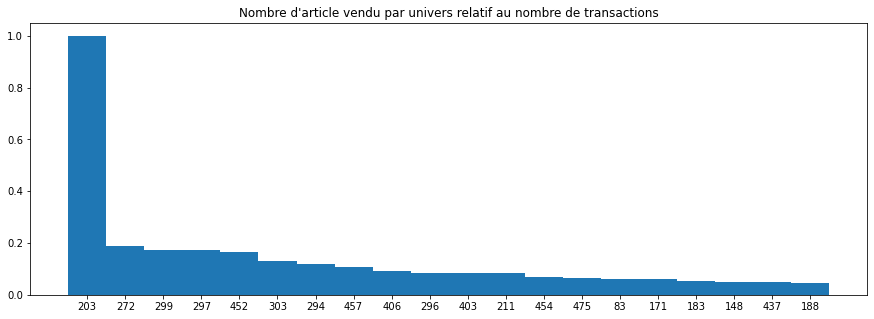

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 7.95)
("Nombre moyen d'univ", 1.06)
('CA univ', 12695.67)
('CA moyen univ', 3.46)
('Nombre moyen article en plus', 6.61)
('CA en plus', 82410.63)
('CA moyen en plus', 22.45)
==============204===================
777
Time Taken to load recurence: ~0secondes


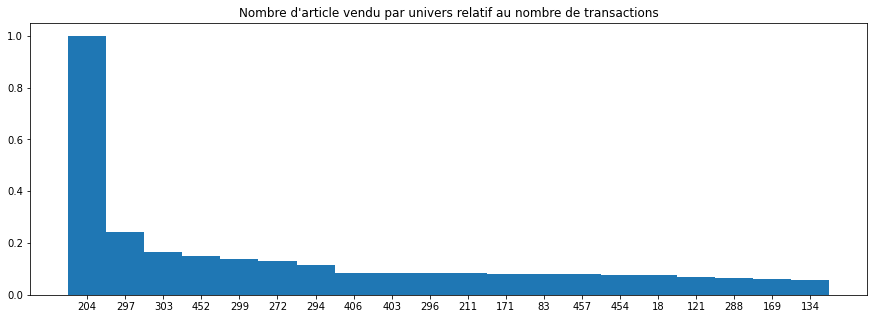

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 6.05)
("Nombre moyen d'univ", 1.05)
('CA univ', 4122.61)
('CA moyen univ', 5.31)
('Nombre moyen article en plus', 8.06)
('CA en plus', 21349.6)
('CA moyen en plus', 27.48)
==============205===================
169
Time Taken to load recurence: ~0secondes


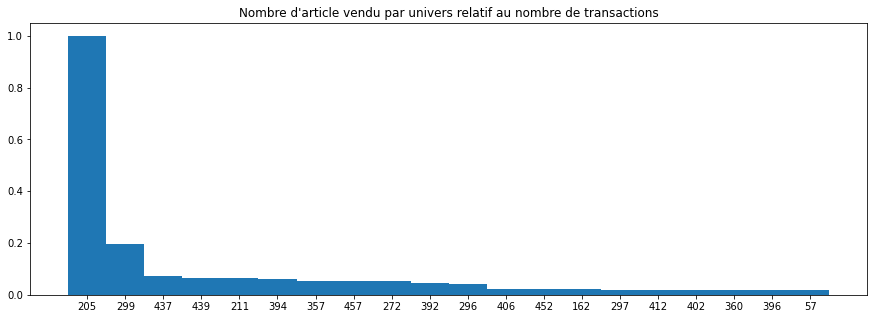

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 37.28)
("Nombre moyen d'univ", 1.11)
('CA univ', 630.58)
('CA moyen univ', 3.73)
('Nombre moyen article en plus', 1.83)
('CA en plus', 736.82)
('CA moyen en plus', 4.36)
==============206===================
1719
Time Taken to load recurence: ~0secondes


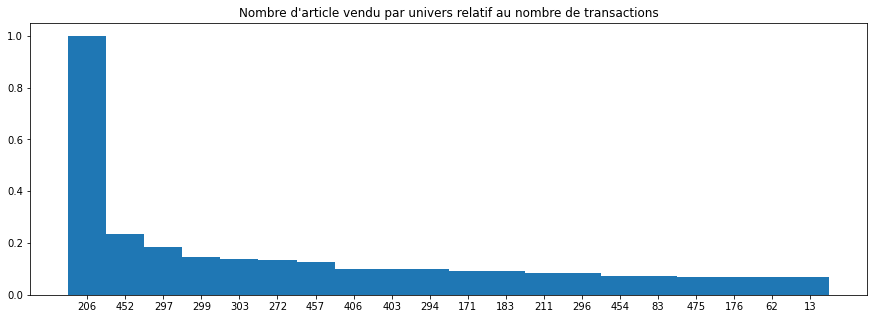

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 4.65)
("Nombre moyen d'univ", 1.12)
('CA univ', 7173.03)
('CA moyen univ', 4.17)
('Nombre moyen article en plus', 8.37)
('CA en plus', 51463.22)
('CA moyen en plus', 29.94)
==============207===================
9624
Time Taken to load recurence: ~0secondes


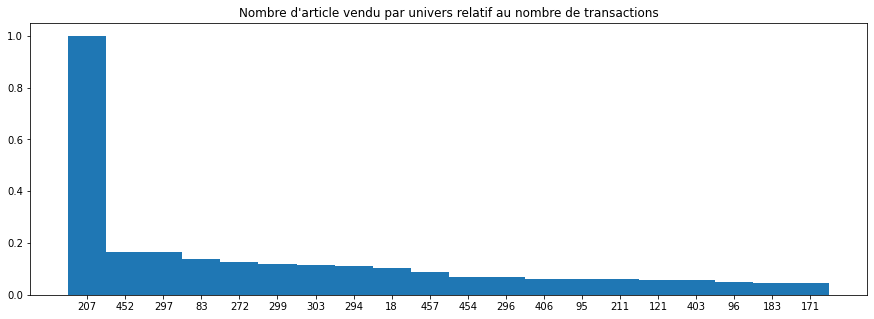

("Proportion d'achat (%)", 0.25)
('Proportion achat seul (%)', 10.43)
("Nombre moyen d'univ", 1.14)
('CA univ', 25523.58)
('CA moyen univ', 2.65)
('Nombre moyen article en plus', 6.02)
('CA en plus', 197503.61)
('CA moyen en plus', 20.52)
==============208===================
20239
Time Taken to load recurence: ~0secondes


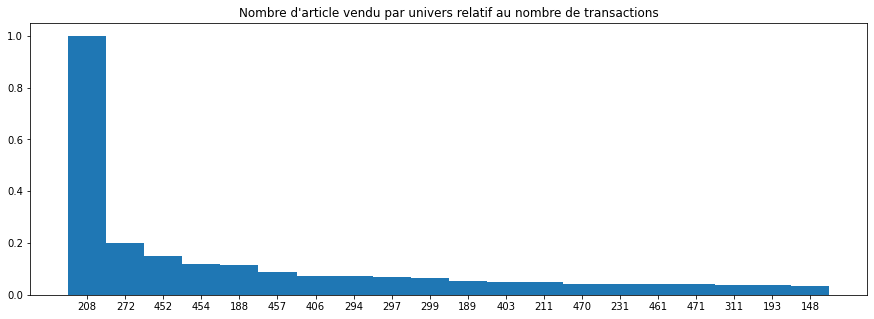

("Proportion d'achat (%)", 0.53)
('Proportion achat seul (%)', 14.06)
("Nombre moyen d'univ", 1.44)
('CA univ', 120343.59)
('CA moyen univ', 5.95)
('Nombre moyen article en plus', 4.22)
('CA en plus', 317179.86)
('CA moyen en plus', 15.67)
==============209===================
4882
Time Taken to load recurence: ~0secondes


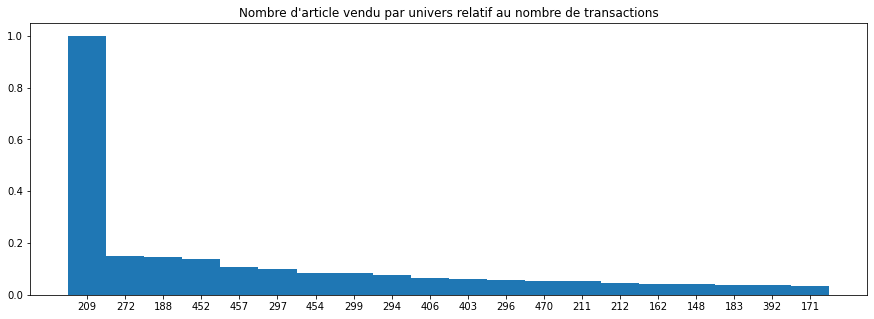

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 10.18)
("Nombre moyen d'univ", 1.39)
('CA univ', 22430.48)
('CA moyen univ', 4.59)
('Nombre moyen article en plus', 4.83)
('CA en plus', 84350.99)
('CA moyen en plus', 17.28)
==============210===================
27379
Time Taken to load recurence: ~0secondes


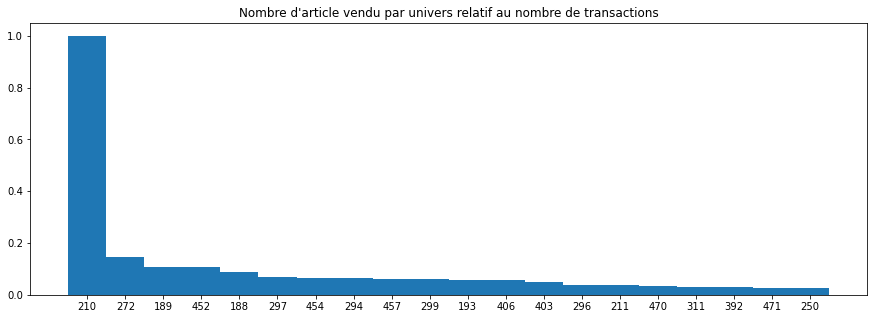

("Proportion d'achat (%)", 0.72)
('Proportion achat seul (%)', 22.55)
("Nombre moyen d'univ", 1.41)
('CA univ', 120021.27)
('CA moyen univ', 4.38)
('Nombre moyen article en plus', 3.43)
('CA en plus', 334453.21)
('CA moyen en plus', 12.22)
==============211===================
200224
Time Taken to load recurence: ~0secondes


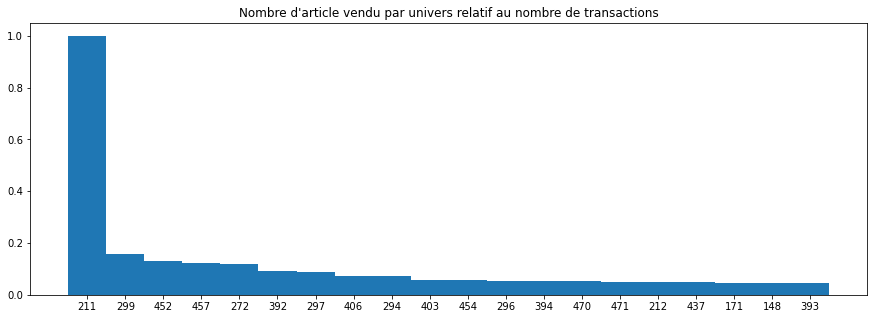

("Proportion d'achat (%)", 5.28)
('Proportion achat seul (%)', 8.7)
("Nombre moyen d'univ", 1.19)
('CA univ', 404284.23)
('CA moyen univ', 2.02)
('Nombre moyen article en plus', 4.67)
('CA en plus', 3079810.68)
('CA moyen en plus', 15.38)
==============212===================
80572
Time Taken to load recurence: ~0secondes


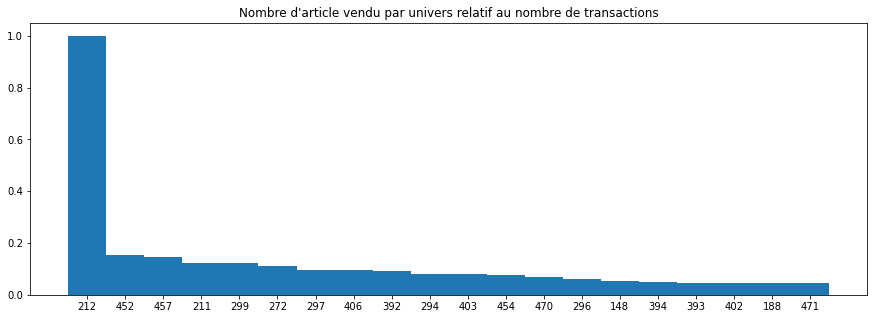

("Proportion d'achat (%)", 2.12)
('Proportion achat seul (%)', 5.47)
("Nombre moyen d'univ", 1.17)
('CA univ', 162250.42)
('CA moyen univ', 2.01)
('Nombre moyen article en plus', 5.41)
('CA en plus', 1532711.44)
('CA moyen en plus', 19.02)
==============214===================
89
Time Taken to load recurence: ~0secondes


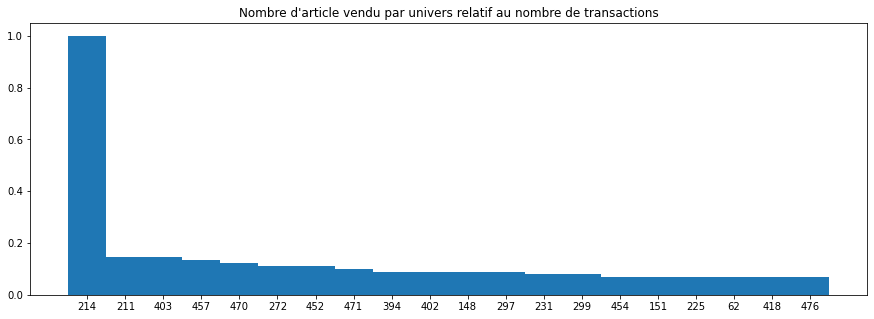

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 1.12)
("Nombre moyen d'univ", 1.04)
('CA univ', 157.4)
('CA moyen univ', 1.77)
('Nombre moyen article en plus', 5.27)
('CA en plus', 1702.84)
('CA moyen en plus', 19.13)
==============215===================
16339
Time Taken to load recurence: ~0secondes


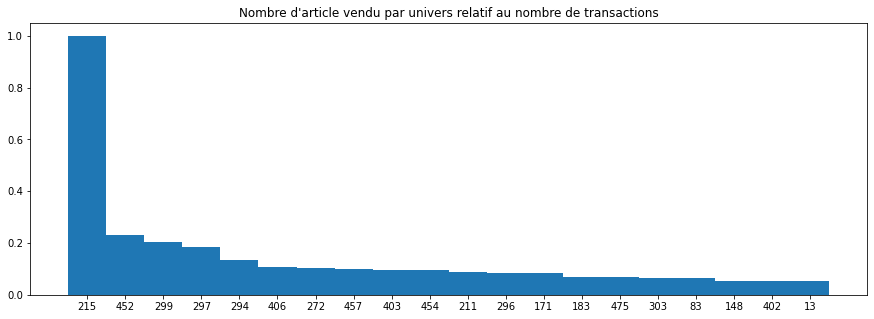

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 4.02)
("Nombre moyen d'univ", 1.17)
('CA univ', 88167.4)
('CA moyen univ', 5.4)
('Nombre moyen article en plus', 7.64)
('CA en plus', 438306.21)
('CA moyen en plus', 26.83)
==============216===================
23270
Time Taken to load recurence: ~0secondes


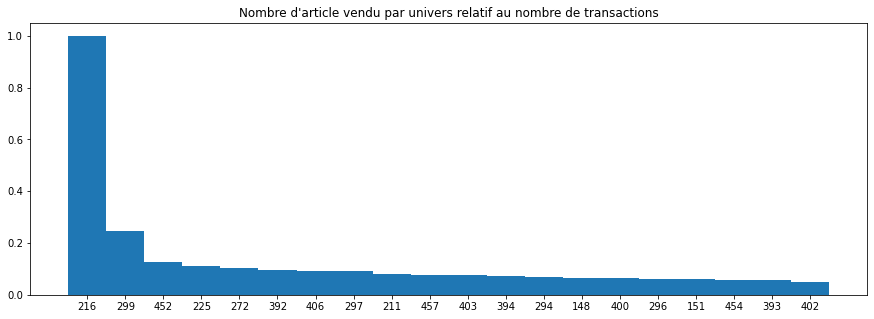

("Proportion d'achat (%)", 0.61)
('Proportion achat seul (%)', 3.34)
("Nombre moyen d'univ", 1.12)
('CA univ', 62685.07)
('CA moyen univ', 2.69)
('Nombre moyen article en plus', 5.29)
('CA en plus', 408228.64)
('CA moyen en plus', 17.54)
==============218===================
4263
Time Taken to load recurence: ~0secondes


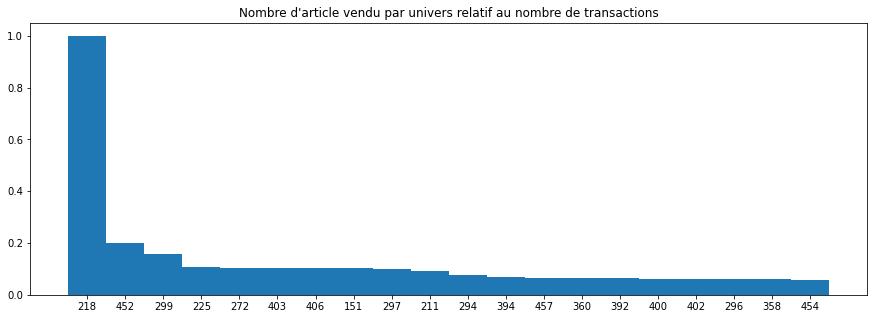

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 3.26)
("Nombre moyen d'univ", 1.25)
('CA univ', 13440.64)
('CA moyen univ', 3.15)
('Nombre moyen article en plus', 6.03)
('CA en plus', 86778.68)
('CA moyen en plus', 20.36)
==============219===================
28754
Time Taken to load recurence: ~0secondes


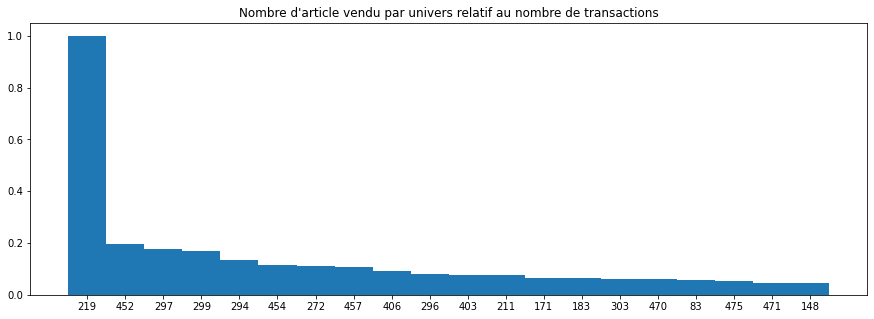

("Proportion d'achat (%)", 0.76)
('Proportion achat seul (%)', 5.42)
("Nombre moyen d'univ", 1.21)
('CA univ', 103770.17)
('CA moyen univ', 3.61)
('Nombre moyen article en plus', 6.85)
('CA en plus', 690435.99)
('CA moyen en plus', 24.01)
==============220===================
36637
Time Taken to load recurence: ~0secondes


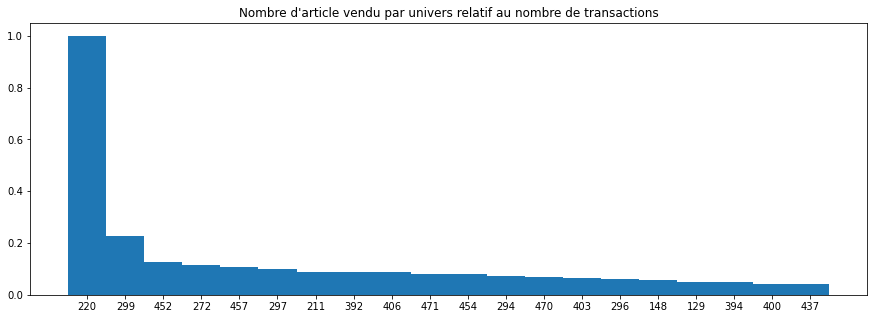

("Proportion d'achat (%)", 0.97)
('Proportion achat seul (%)', 6.48)
("Nombre moyen d'univ", 1.2)
('CA univ', 68591.88)
('CA moyen univ', 1.87)
('Nombre moyen article en plus', 5.25)
('CA en plus', 609459.76)
('CA moyen en plus', 16.64)
==============221===================
NOT ENOUGH DATA 
==============222===================
4638
Time Taken to load recurence: ~0secondes


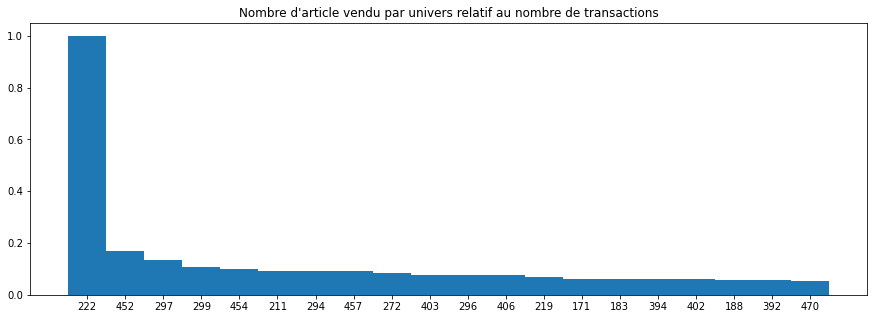

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 4.46)
("Nombre moyen d'univ", 1.19)
('CA univ', 12746.58)
('CA moyen univ', 2.75)
('Nombre moyen article en plus', 6.44)
('CA en plus', 105545.15)
('CA moyen en plus', 22.76)
==============223===================
3580
Time Taken to load recurence: ~0secondes


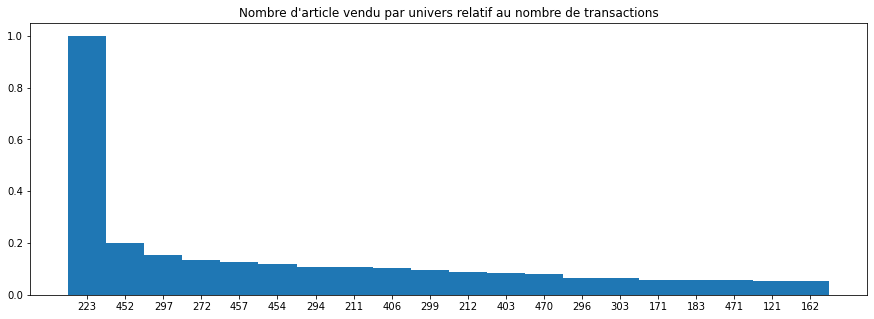

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 6.59)
("Nombre moyen d'univ", 1.07)
('CA univ', 22433.35)
('CA moyen univ', 6.27)
('Nombre moyen article en plus', 6.84)
('CA en plus', 89913.95)
('CA moyen en plus', 25.12)
==============224===================
3681
Time Taken to load recurence: ~0secondes


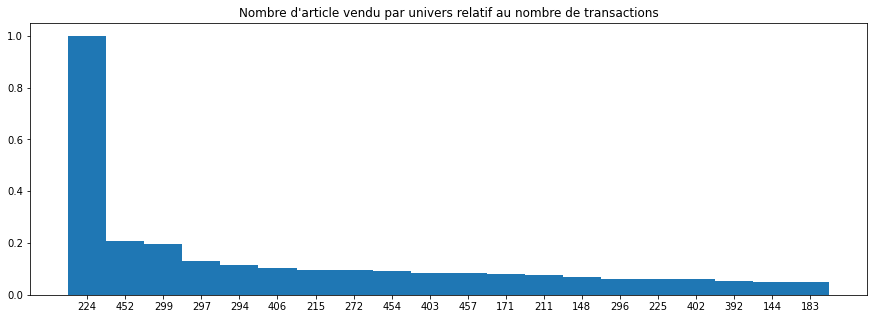

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 4.86)
("Nombre moyen d'univ", 1.1)
('CA univ', 16501.04)
('CA moyen univ', 4.48)
('Nombre moyen article en plus', 6.6)
('CA en plus', 82812.31)
('CA moyen en plus', 22.5)
==============225===================
76768
Time Taken to load recurence: ~0secondes


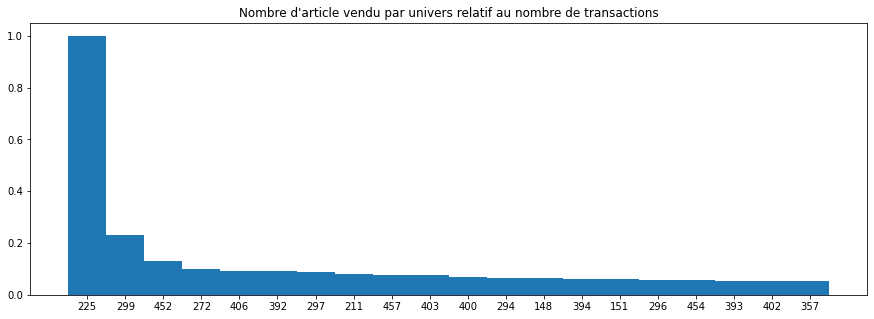

("Proportion d'achat (%)", 2.02)
('Proportion achat seul (%)', 4.16)
("Nombre moyen d'univ", 1.2)
('CA univ', 262493.23)
('CA moyen univ', 3.42)
('Nombre moyen article en plus', 4.99)
('CA en plus', 1273085.81)
('CA moyen en plus', 16.58)
==============231===================
127832
Time Taken to load recurence: ~0secondes


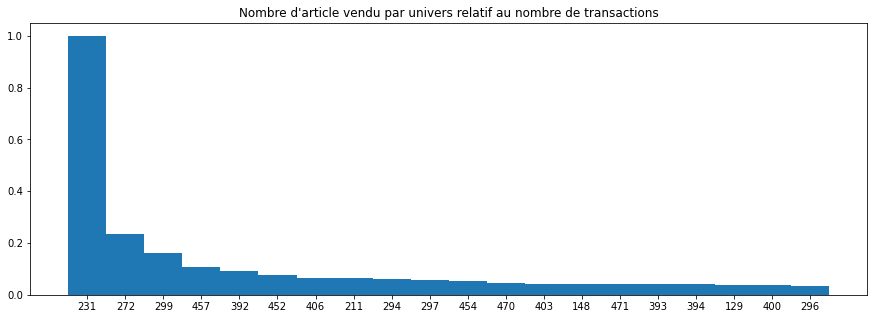

("Proportion d'achat (%)", 3.37)
('Proportion achat seul (%)', 14.05)
("Nombre moyen d'univ", 1.27)
('CA univ', 332991.23)
('CA moyen univ', 2.6)
('Nombre moyen article en plus', 3.46)
('CA en plus', 1520101.52)
('CA moyen en plus', 11.89)
==============232===================
34514
Time Taken to load recurence: ~0secondes


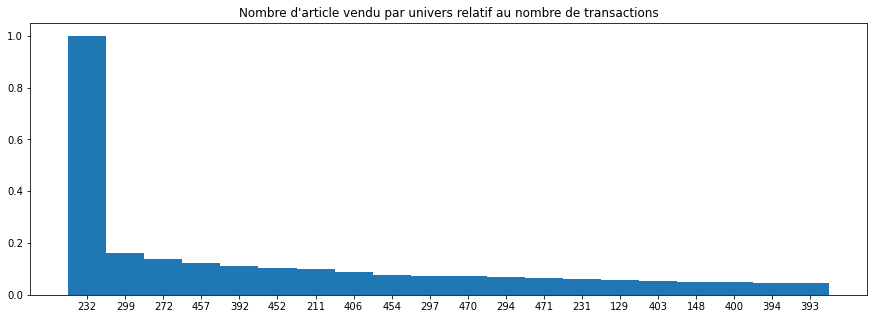

("Proportion d'achat (%)", 0.91)
('Proportion achat seul (%)', 8.41)
("Nombre moyen d'univ", 1.17)
('CA univ', 76128.17)
('CA moyen univ', 2.21)
('Nombre moyen article en plus', 4.4)
('CA en plus', 482769.72)
('CA moyen en plus', 13.99)
==============233===================
17130
Time Taken to load recurence: ~0secondes


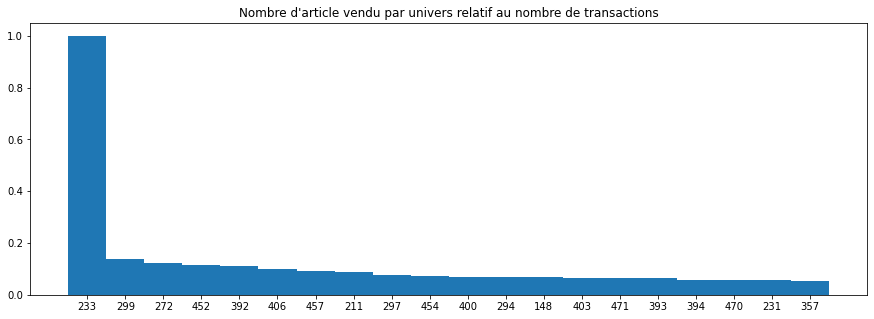

("Proportion d'achat (%)", 0.45)
('Proportion achat seul (%)', 5.32)
("Nombre moyen d'univ", 1.18)
('CA univ', 41750.78)
('CA moyen univ', 2.44)
('Nombre moyen article en plus', 4.72)
('CA en plus', 276798.93)
('CA moyen en plus', 16.16)
==============235===================
9907
Time Taken to load recurence: ~0secondes


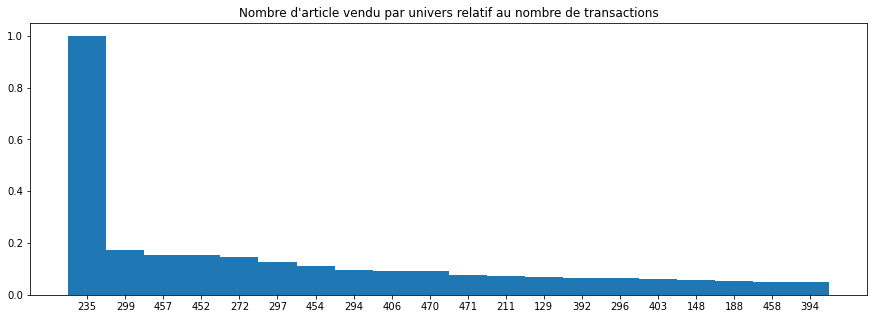

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 5.23)
("Nombre moyen d'univ", 1.41)
('CA univ', 13955.89)
('CA moyen univ', 1.41)
('Nombre moyen article en plus', 5.64)
('CA en plus', 176965.37)
('CA moyen en plus', 17.86)
==============236===================
15257
Time Taken to load recurence: ~0secondes


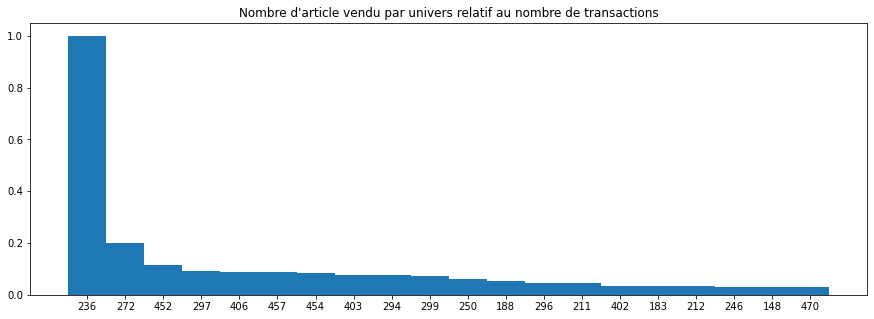

("Proportion d'achat (%)", 0.4)
('Proportion achat seul (%)', 12.97)
("Nombre moyen d'univ", 1.46)
('CA univ', 113162.52)
('CA moyen univ', 7.42)
('Nombre moyen article en plus', 4.2)
('CA en plus', 255195.52)
('CA moyen en plus', 16.73)
==============237===================
82
Time Taken to load recurence: ~0secondes


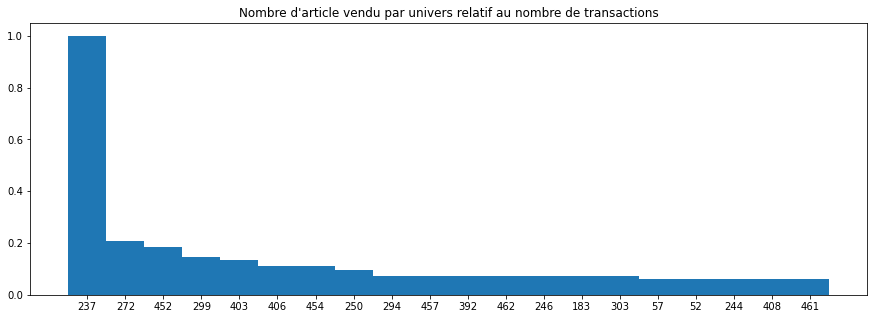

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 7.32)
("Nombre moyen d'univ", 1.21)
('CA univ', 1015.79)
('CA moyen univ', 12.39)
('Nombre moyen article en plus', 6.6)
('CA en plus', 2548.15)
('CA moyen en plus', 31.08)
==============238===================
3338
Time Taken to load recurence: ~0secondes


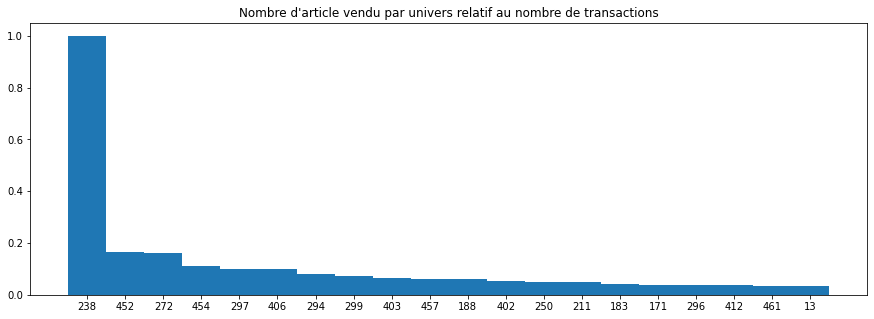

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 12.79)
("Nombre moyen d'univ", 1.22)
('CA univ', 32999.6)
('CA moyen univ', 9.89)
('Nombre moyen article en plus', 4.9)
('CA en plus', 66648.9)
('CA moyen en plus', 19.97)
==============239===================
12476
Time Taken to load recurence: ~0secondes


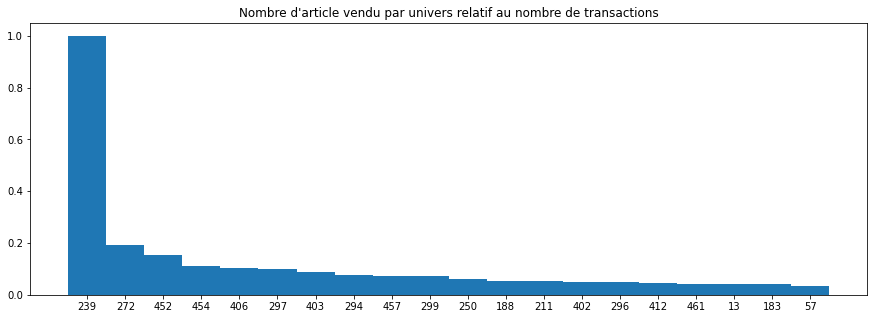

("Proportion d'achat (%)", 0.33)
('Proportion achat seul (%)', 12.43)
("Nombre moyen d'univ", 1.31)
('CA univ', 127464.32)
('CA moyen univ', 10.22)
('Nombre moyen article en plus', 4.92)
('CA en plus', 253928.43)
('CA moyen en plus', 20.35)
==============240===================
337
Time Taken to load recurence: ~0secondes


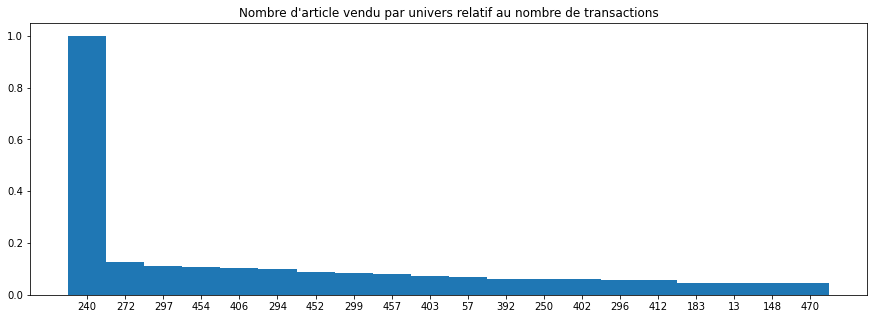

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 10.68)
("Nombre moyen d'univ", 1.31)
('CA univ', 6139.5)
('CA moyen univ', 18.22)
('Nombre moyen article en plus', 5.39)
('CA en plus', 7533.4)
('CA moyen en plus', 22.35)
==============241===================
3570
Time Taken to load recurence: ~0secondes


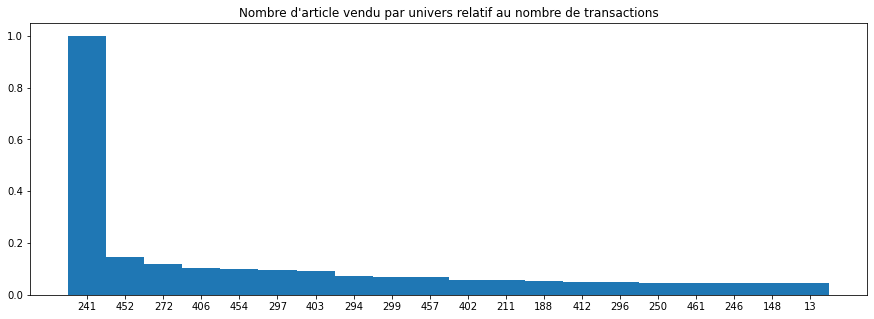

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 10.59)
("Nombre moyen d'univ", 1.28)
('CA univ', 32764.8)
('CA moyen univ', 9.18)
('Nombre moyen article en plus', 5.3)
('CA en plus', 74561.89)
('CA moyen en plus', 20.89)
==============242===================
2496
Time Taken to load recurence: ~0secondes


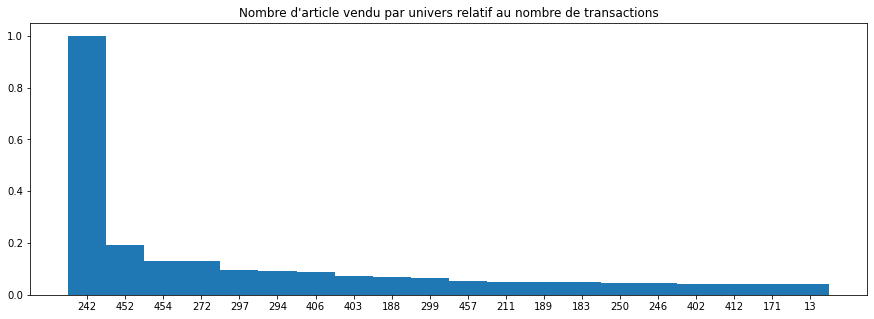

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 10.46)
("Nombre moyen d'univ", 1.17)
('CA univ', 28367.33)
('CA moyen univ', 11.37)
('Nombre moyen article en plus', 5.28)
('CA en plus', 55013.9)
('CA moyen en plus', 22.04)
==============243===================
1676
Time Taken to load recurence: ~0secondes


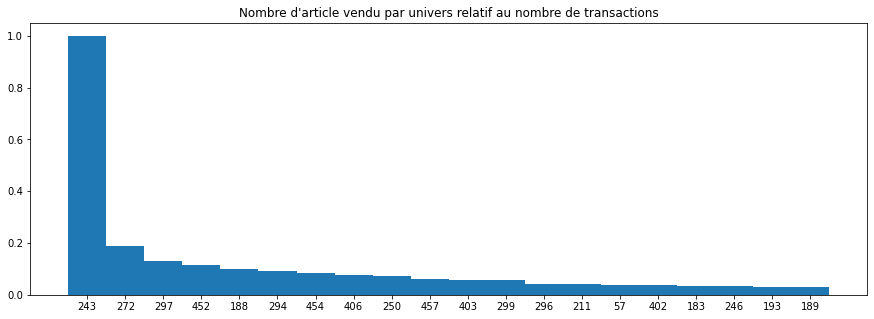

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 14.62)
("Nombre moyen d'univ", 1.2)
('CA univ', 10512.38)
('CA moyen univ', 6.27)
('Nombre moyen article en plus', 3.82)
('CA en plus', 23816.7)
('CA moyen en plus', 14.21)
==============244===================
2793
Time Taken to load recurence: ~0secondes


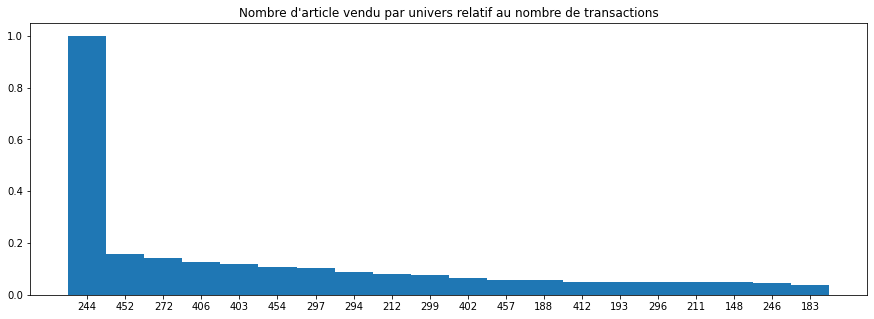

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 9.2)
("Nombre moyen d'univ", 1.26)
('CA univ', 34797.22)
('CA moyen univ', 12.46)
('Nombre moyen article en plus', 5.52)
('CA en plus', 60920.86)
('CA moyen en plus', 21.81)
==============245===================
1688
Time Taken to load recurence: ~0secondes


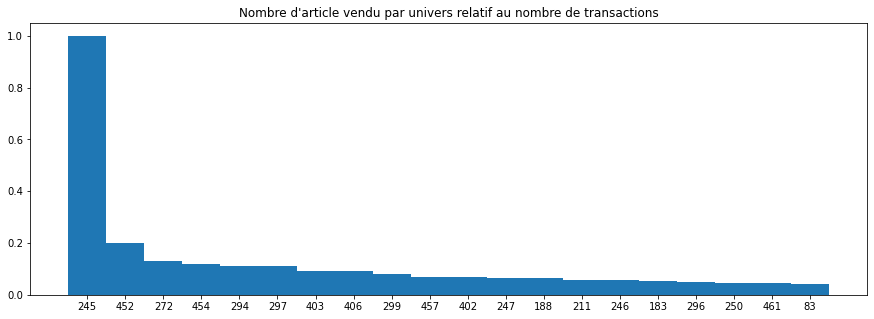

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 9.36)
("Nombre moyen d'univ", 1.35)
('CA univ', 24275.34)
('CA moyen univ', 14.38)
('Nombre moyen article en plus', 5.95)
('CA en plus', 43947.65)
('CA moyen en plus', 26.04)
==============246===================
52159
Time Taken to load recurence: ~0secondes


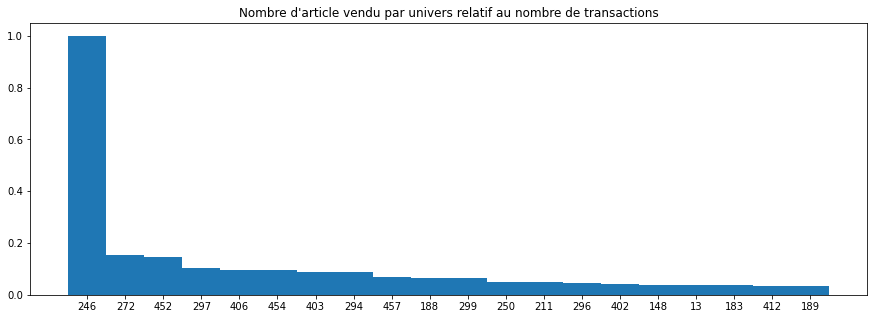

("Proportion d'achat (%)", 1.37)
('Proportion achat seul (%)', 13.03)
("Nombre moyen d'univ", 1.33)
('CA univ', 578871.46)
('CA moyen univ', 11.1)
('Nombre moyen article en plus', 4.64)
('CA en plus', 967402.14)
('CA moyen en plus', 18.55)
==============247===================
8573
Time Taken to load recurence: ~0secondes


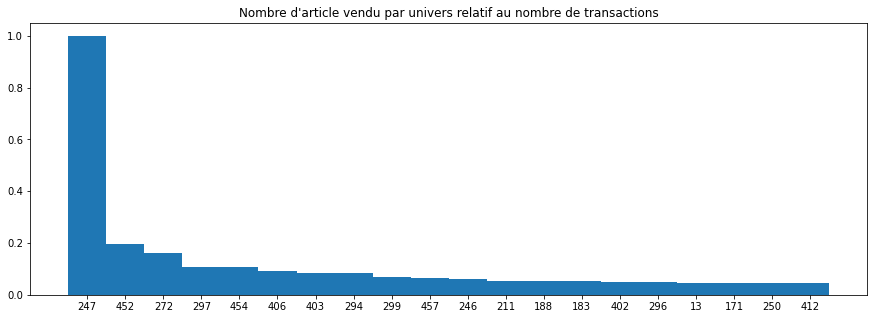

("Proportion d'achat (%)", 0.23)
('Proportion achat seul (%)', 9.27)
("Nombre moyen d'univ", 1.31)
('CA univ', 121636.95)
('CA moyen univ', 14.19)
('Nombre moyen article en plus', 5.77)
('CA en plus', 210337.51)
('CA moyen en plus', 24.53)
==============248===================
5766
Time Taken to load recurence: ~0secondes


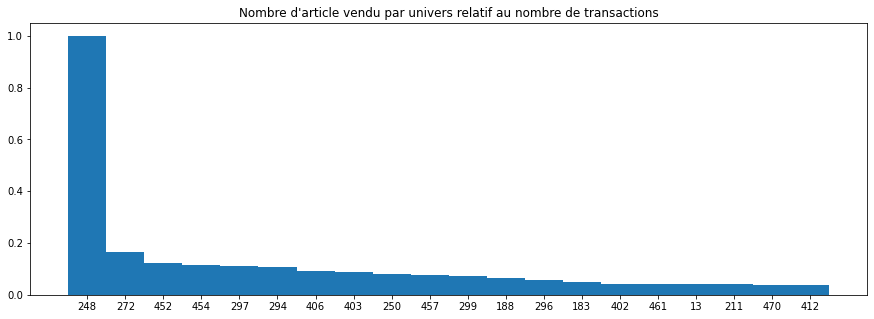

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 11.79)
("Nombre moyen d'univ", 1.31)
('CA univ', 47802.39)
('CA moyen univ', 8.29)
('Nombre moyen article en plus', 5.11)
('CA en plus', 113697.44)
('CA moyen en plus', 19.72)
==============249===================
25644
Time Taken to load recurence: ~0secondes


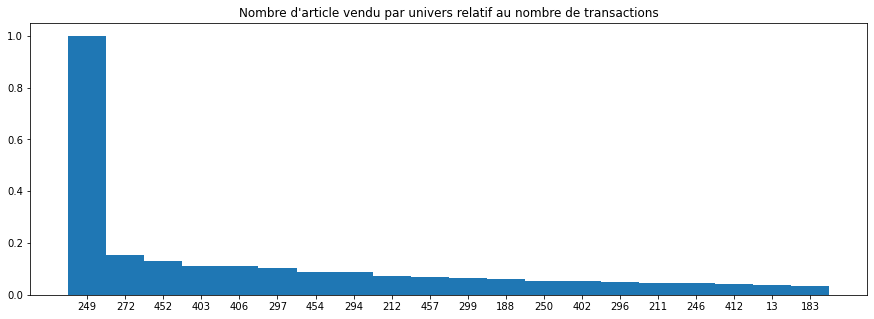

("Proportion d'achat (%)", 0.68)
('Proportion achat seul (%)', 11.92)
("Nombre moyen d'univ", 1.28)
('CA univ', 214625.83)
('CA moyen univ', 8.37)
('Nombre moyen article en plus', 4.76)
('CA en plus', 473389.7)
('CA moyen en plus', 18.46)
==============250===================
76725
Time Taken to load recurence: ~0secondes


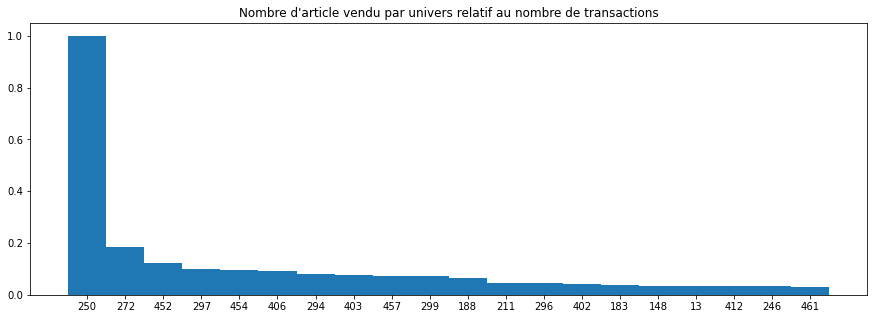

("Proportion d'achat (%)", 2.02)
('Proportion achat seul (%)', 13.56)
("Nombre moyen d'univ", 1.32)
('CA univ', 636739.87)
('CA moyen univ', 8.3)
('Nombre moyen article en plus', 4.37)
('CA en plus', 1304446.42)
('CA moyen en plus', 17.0)
==============251===================
18431
Time Taken to load recurence: ~0secondes


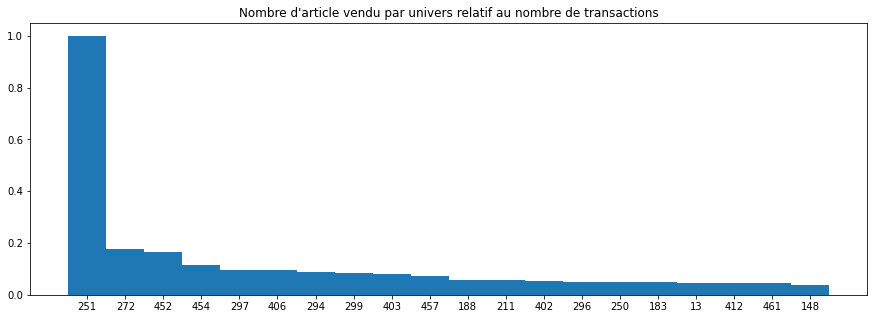

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 11.69)
("Nombre moyen d'univ", 1.42)
('CA univ', 293656.72)
('CA moyen univ', 15.93)
('Nombre moyen article en plus', 5.46)
('CA en plus', 404706.19)
('CA moyen en plus', 21.96)
==============252===================
4778
Time Taken to load recurence: ~0secondes


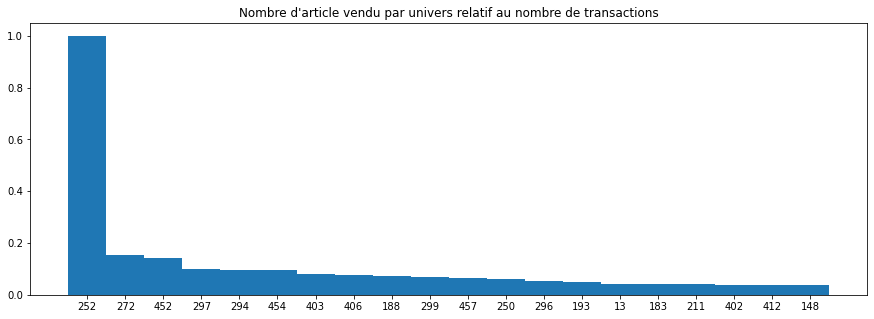

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 12.26)
("Nombre moyen d'univ", 1.24)
('CA univ', 47326.61)
('CA moyen univ', 9.91)
('Nombre moyen article en plus', 4.7)
('CA en plus', 87918.66)
('CA moyen en plus', 18.4)
==============253===================
806
Time Taken to load recurence: ~0secondes


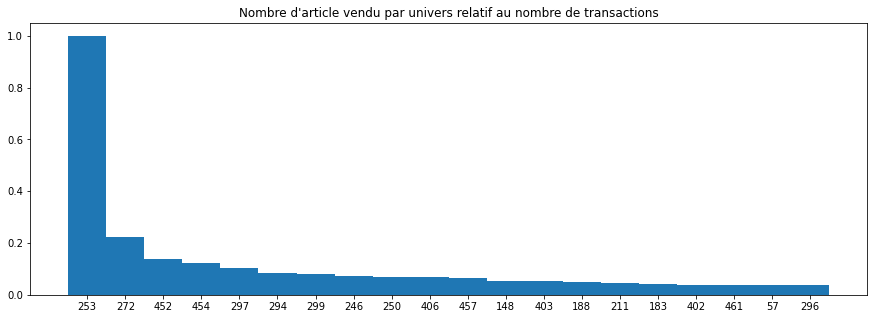

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 12.78)
("Nombre moyen d'univ", 1.15)
('CA univ', 6324.11)
('CA moyen univ', 7.85)
('Nombre moyen article en plus', 4.6)
('CA en plus', 14566.71)
('CA moyen en plus', 18.07)
==============254===================
9924
Time Taken to load recurence: ~0secondes


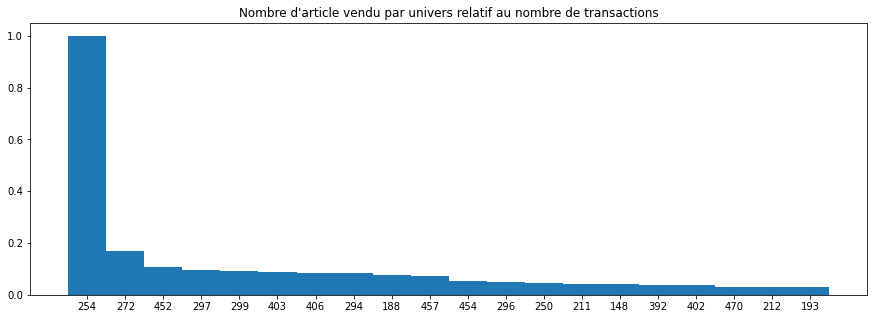

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 15.32)
("Nombre moyen d'univ", 1.17)
('CA univ', 48012.84)
('CA moyen univ', 4.84)
('Nombre moyen article en plus', 3.96)
('CA en plus', 144432.63)
('CA moyen en plus', 14.55)
==============255===================
10260
Time Taken to load recurence: ~0secondes


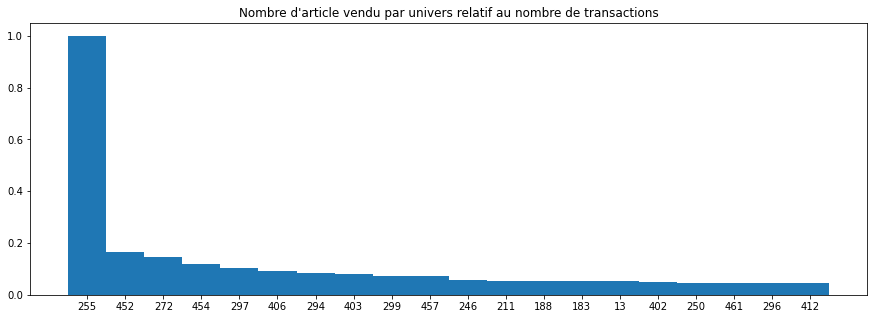

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 10.0)
("Nombre moyen d'univ", 1.24)
('CA univ', 136029.91)
('CA moyen univ', 13.26)
('Nombre moyen article en plus', 5.52)
('CA en plus', 238008.3)
('CA moyen en plus', 23.2)
==============256===================
934
Time Taken to load recurence: ~0secondes


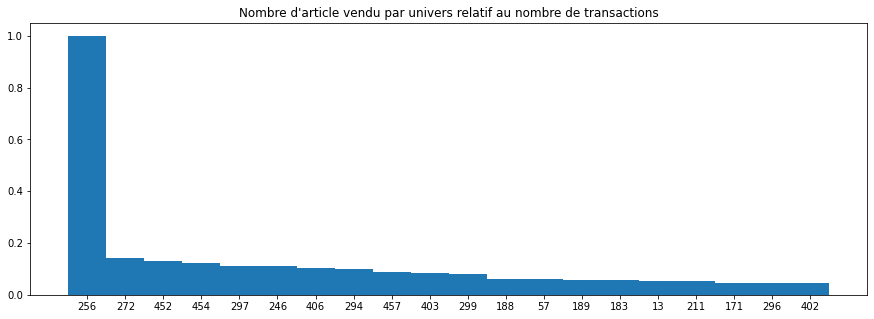

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 8.78)
("Nombre moyen d'univ", 1.1)
('CA univ', 9534.87)
('CA moyen univ', 10.21)
('Nombre moyen article en plus', 5.05)
('CA en plus', 19482.77)
('CA moyen en plus', 20.86)
==============258===================
10035
Time Taken to load recurence: ~0secondes


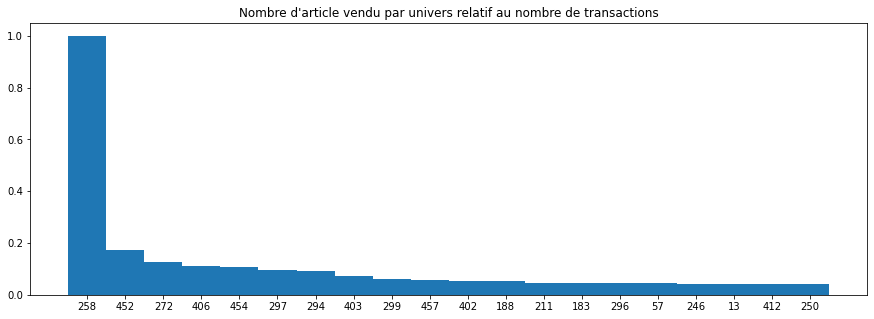

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 12.76)
("Nombre moyen d'univ", 1.27)
('CA univ', 118463.77)
('CA moyen univ', 11.81)
('Nombre moyen article en plus', 5.03)
('CA en plus', 210406.88)
('CA moyen en plus', 20.97)
==============259===================
3365
Time Taken to load recurence: ~0secondes


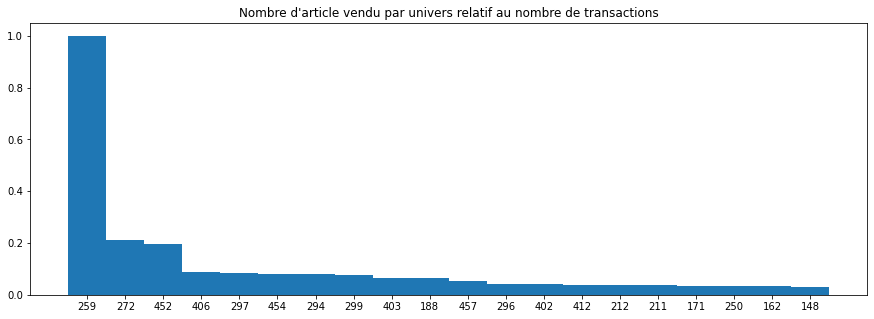

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 14.15)
("Nombre moyen d'univ", 1.61)
('CA univ', 25293.38)
('CA moyen univ', 7.52)
('Nombre moyen article en plus', 4.56)
('CA en plus', 58699.7)
('CA moyen en plus', 17.44)
==============262===================
8202
Time Taken to load recurence: ~0secondes


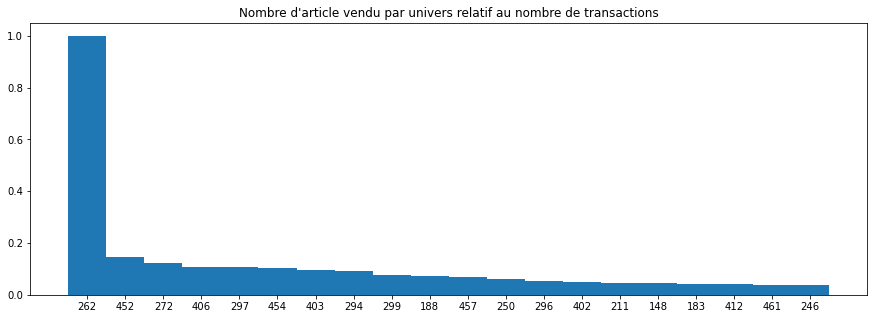

("Proportion d'achat (%)", 0.22)
('Proportion achat seul (%)', 10.73)
("Nombre moyen d'univ", 1.21)
('CA univ', 64881.95)
('CA moyen univ', 7.91)
('Nombre moyen article en plus', 4.98)
('CA en plus', 160539.69)
('CA moyen en plus', 19.57)
==============263===================
2751
Time Taken to load recurence: ~0secondes


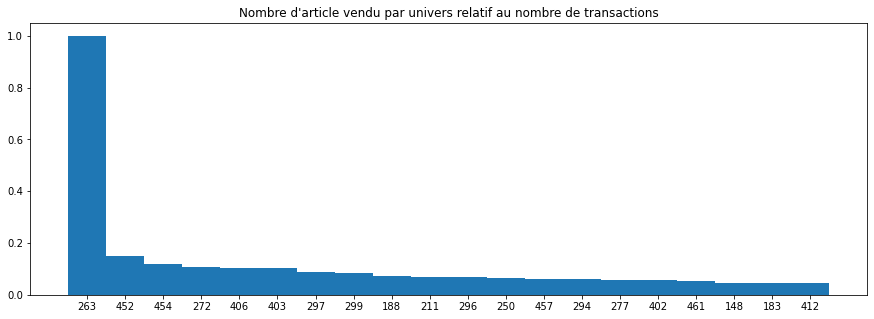

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 10.65)
("Nombre moyen d'univ", 1.35)
('CA univ', 34774.57)
('CA moyen univ', 12.64)
('Nombre moyen article en plus', 5.47)
('CA en plus', 59113.59)
('CA moyen en plus', 21.49)
==============264===================
173
Time Taken to load recurence: ~0secondes


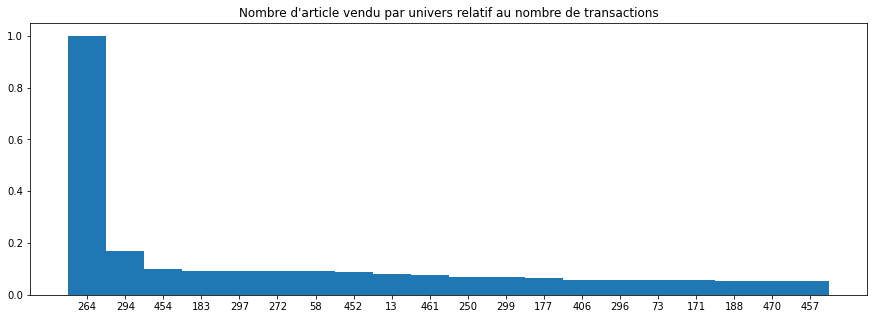

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 9.25)
("Nombre moyen d'univ", 1.55)
('CA univ', 2435.98)
('CA moyen univ', 14.08)
('Nombre moyen article en plus', 4.85)
('CA en plus', 3288.34)
('CA moyen en plus', 19.01)
==============265===================
58
Time Taken to load recurence: ~0secondes


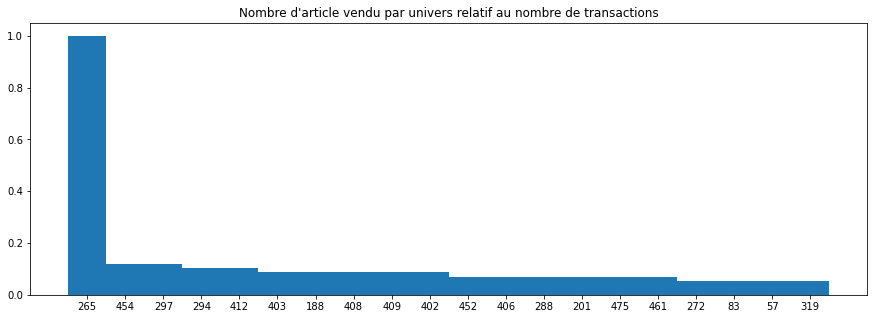

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 17.24)
("Nombre moyen d'univ", 1.29)
('CA univ', 1952.42)
('CA moyen univ', 33.66)
('Nombre moyen article en plus', 6.45)
('CA en plus', 1745.76)
('CA moyen en plus', 30.1)
==============266===================
4618
Time Taken to load recurence: ~0secondes


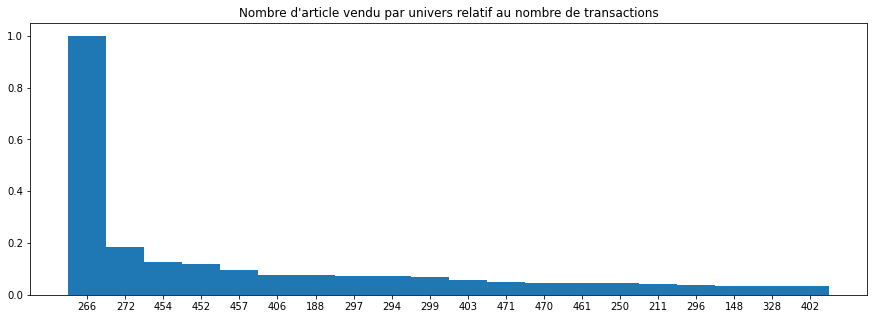

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 18.1)
("Nombre moyen d'univ", 1.52)
('CA univ', 23648.0)
('CA moyen univ', 5.12)
('Nombre moyen article en plus', 4.02)
('CA en plus', 70326.27)
('CA moyen en plus', 15.23)
==============267===================
1687
Time Taken to load recurence: ~0secondes


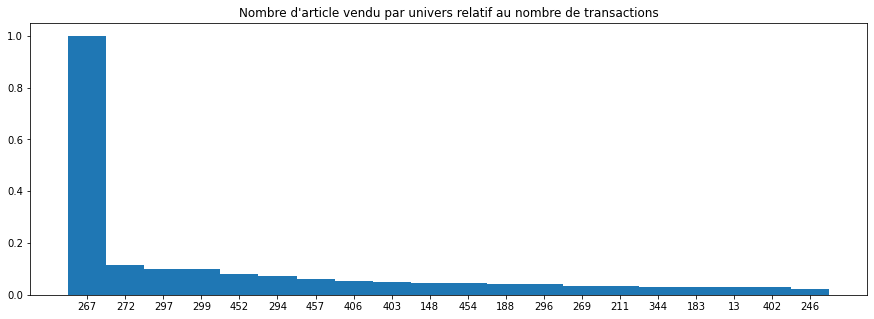

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 24.6)
("Nombre moyen d'univ", 1.12)
('CA univ', -27.46)
('CA moyen univ', -0.02)
('Nombre moyen article en plus', 3.52)
('CA en plus', 23806.69)
('CA moyen en plus', 14.11)
==============268===================
NOT ENOUGH DATA 
==============269===================
18159
Time Taken to load recurence: ~0secondes


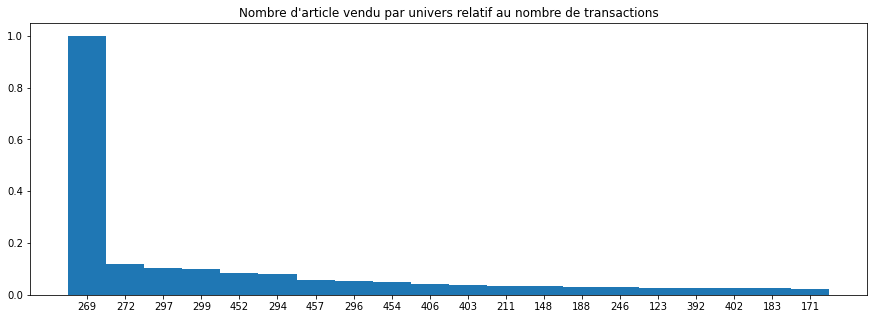

("Proportion d'achat (%)", 0.48)
('Proportion achat seul (%)', 27.6)
("Nombre moyen d'univ", 1.12)
('CA univ', 350125.42)
('CA moyen univ', 19.28)
('Nombre moyen article en plus', 3.62)
('CA en plus', 266610.33)
('CA moyen en plus', 14.68)
==============270===================
24763
Time Taken to load recurence: ~0secondes


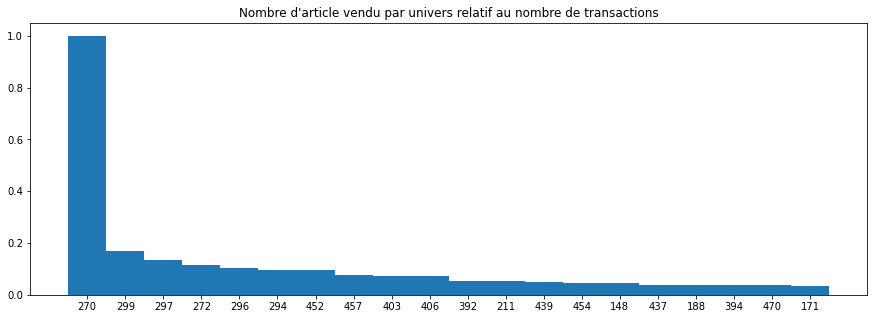

("Proportion d'achat (%)", 0.65)
('Proportion achat seul (%)', 14.92)
("Nombre moyen d'univ", 1.19)
('CA univ', 108850.72)
('CA moyen univ', 4.4)
('Nombre moyen article en plus', 4.68)
('CA en plus', 406130.9)
('CA moyen en plus', 16.4)
==============271===================
35275
Time Taken to load recurence: ~0secondes


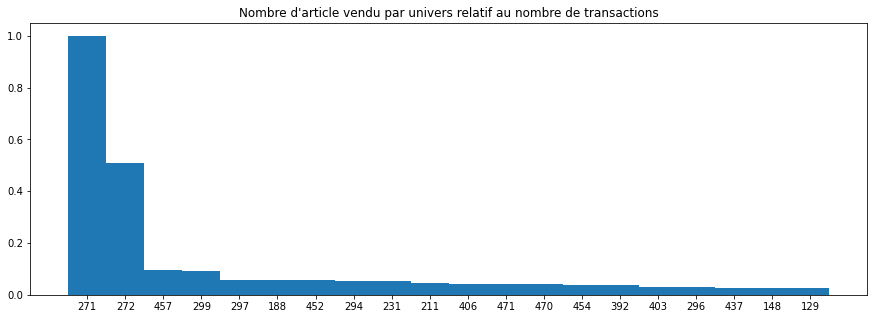

("Proportion d'achat (%)", 0.93)
('Proportion achat seul (%)', 18.0)
("Nombre moyen d'univ", 1.09)
('CA univ', 41165.57)
('CA moyen univ', 1.17)
('Nombre moyen article en plus', 3.11)
('CA en plus', 442328.81)
('CA moyen en plus', 12.54)
==============272===================
548028
Time Taken to load recurence: ~1secondes


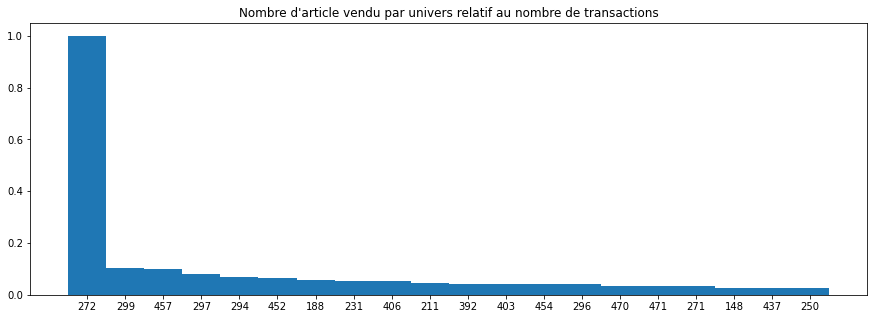

("Proportion d'achat (%)", 14.44)
('Proportion achat seul (%)', 26.44)
("Nombre moyen d'univ", 1.18)
('CA univ', 5002252.48)
('CA moyen univ', 9.13)
('Nombre moyen article en plus', 2.99)
('CA en plus', 5480833.6)
('CA moyen en plus', 10.0)
==============273===================
7231
Time Taken to load recurence: ~0secondes


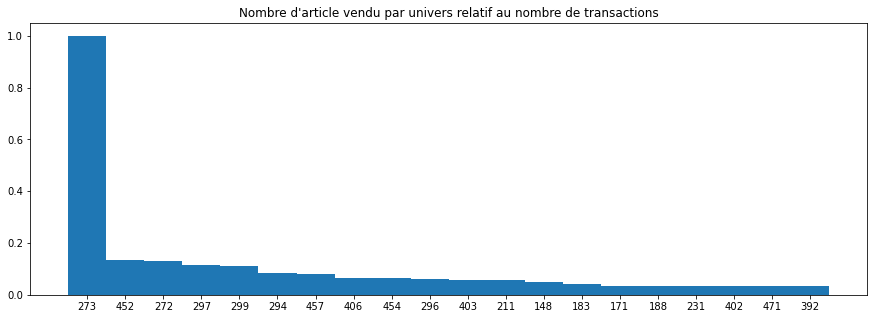

("Proportion d'achat (%)", 0.19)
('Proportion achat seul (%)', 14.42)
("Nombre moyen d'univ", 1.2)
('CA univ', 46304.72)
('CA moyen univ', 6.4)
('Nombre moyen article en plus', 5.24)
('CA en plus', 124446.29)
('CA moyen en plus', 17.21)
==============275===================
17368
Time Taken to load recurence: ~0secondes


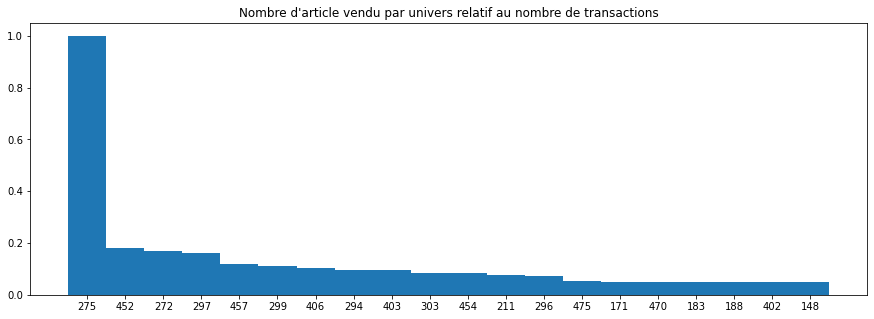

("Proportion d'achat (%)", 0.46)
('Proportion achat seul (%)', 8.9)
("Nombre moyen d'univ", 1.7)
('CA univ', 86478.13)
('CA moyen univ', 4.98)
('Nombre moyen article en plus', 6.38)
('CA en plus', 399685.2)
('CA moyen en plus', 23.01)
==============276===================
9876
Time Taken to load recurence: ~0secondes


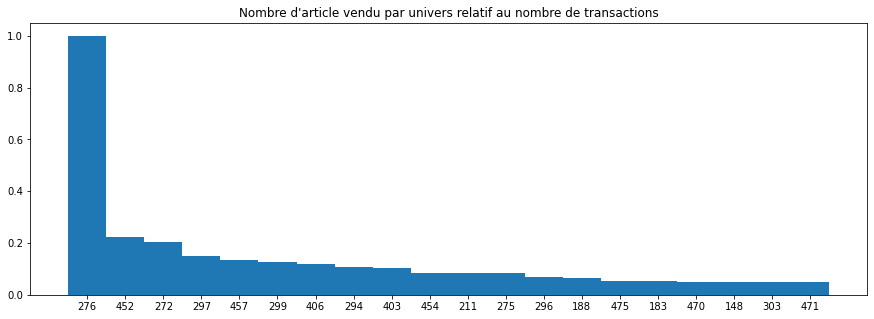

("Proportion d'achat (%)", 0.26)
('Proportion achat seul (%)', 7.65)
("Nombre moyen d'univ", 1.55)
('CA univ', 57344.11)
('CA moyen univ', 5.81)
('Nombre moyen article en plus', 6.91)
('CA en plus', 240575.04)
('CA moyen en plus', 24.36)
==============277===================
38960
Time Taken to load recurence: ~0secondes


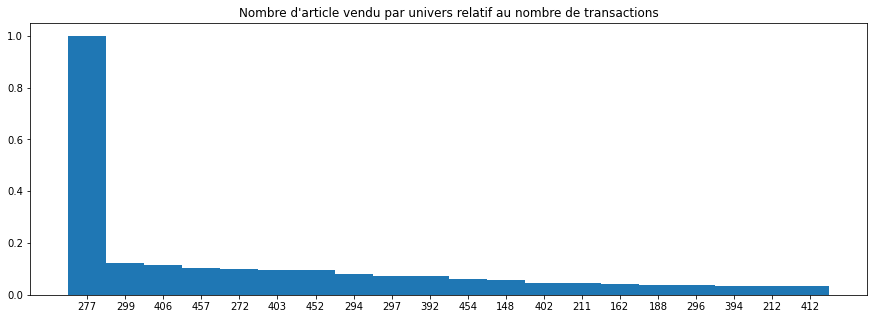

("Proportion d'achat (%)", 1.03)
('Proportion achat seul (%)', 20.07)
("Nombre moyen d'univ", 1.47)
('CA univ', 113430.87)
('CA moyen univ', 2.91)
('Nombre moyen article en plus', 4.3)
('CA en plus', 654789.85)
('CA moyen en plus', 16.81)
==============279===================
NOT ENOUGH DATA 
==============286===================
8118
Time Taken to load recurence: ~0secondes


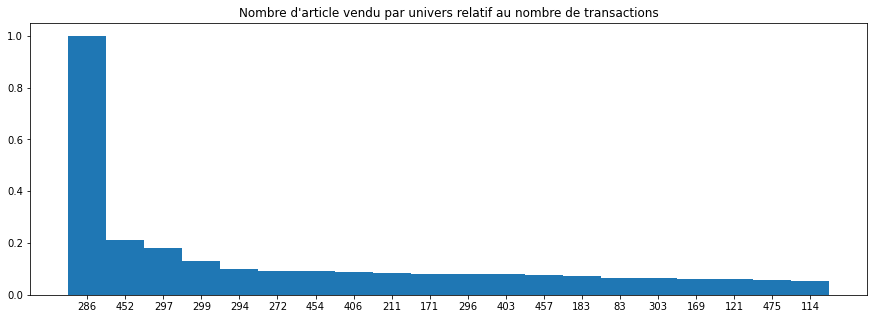

("Proportion d'achat (%)", 0.21)
('Proportion achat seul (%)', 5.96)
("Nombre moyen d'univ", 1.17)
('CA univ', 41266.08)
('CA moyen univ', 5.08)
('Nombre moyen article en plus', 7.16)
('CA en plus', 203246.92)
('CA moyen en plus', 25.04)
==============287===================
27338
Time Taken to load recurence: ~0secondes


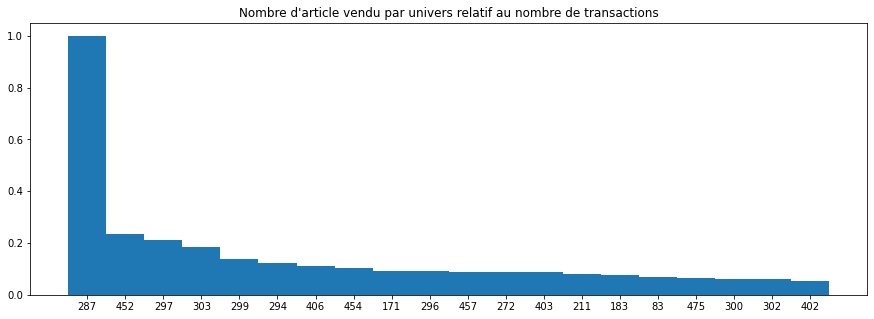

("Proportion d'achat (%)", 0.72)
('Proportion achat seul (%)', 4.01)
("Nombre moyen d'univ", 1.13)
('CA univ', 138069.53)
('CA moyen univ', 5.05)
('Nombre moyen article en plus', 7.51)
('CA en plus', 705188.31)
('CA moyen en plus', 25.8)
==============288===================
16419
Time Taken to load recurence: ~0secondes


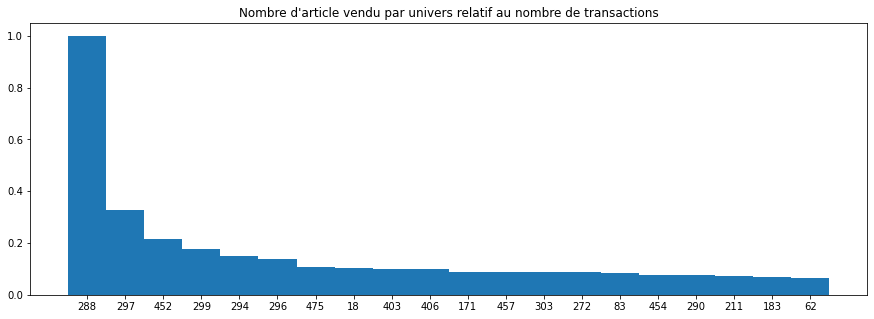

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 2.85)
("Nombre moyen d'univ", 1.15)
('CA univ', 74522.46)
('CA moyen univ', 4.54)
('Nombre moyen article en plus', 8.29)
('CA en plus', 462675.54)
('CA moyen en plus', 28.18)
==============289===================
3775
Time Taken to load recurence: ~0secondes


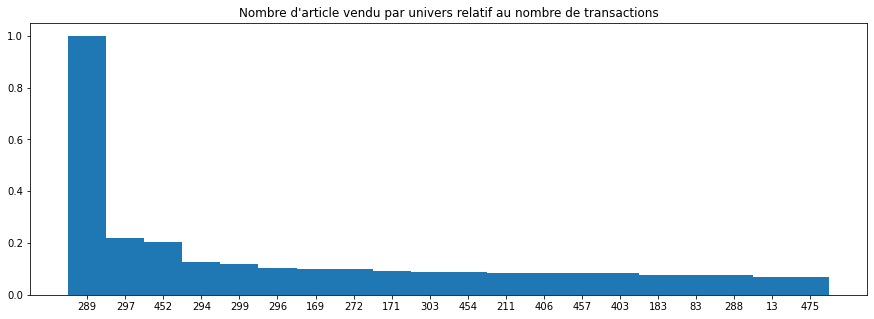

("Proportion d'achat (%)", 0.1)
('Proportion achat seul (%)', 6.33)
("Nombre moyen d'univ", 1.07)
('CA univ', 18853.04)
('CA moyen univ', 4.99)
('Nombre moyen article en plus', 7.73)
('CA en plus', 100668.43)
('CA moyen en plus', 26.67)
==============290===================
18551
Time Taken to load recurence: ~0secondes


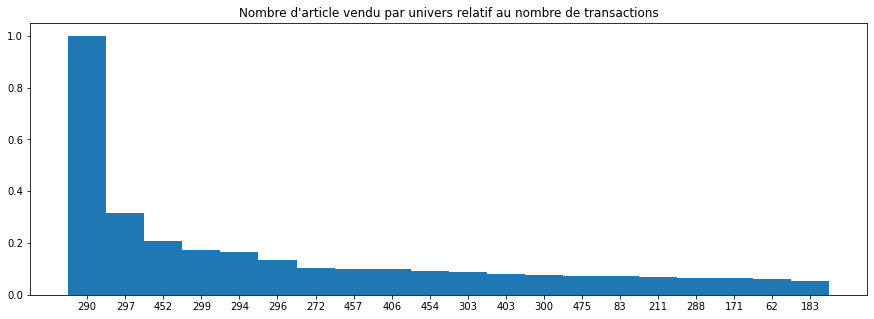

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 4.8)
("Nombre moyen d'univ", 1.06)
('CA univ', 83696.32)
('CA moyen univ', 4.51)
('Nombre moyen article en plus', 7.25)
('CA en plus', 447257.2)
('CA moyen en plus', 24.11)
==============291===================
2460
Time Taken to load recurence: ~0secondes


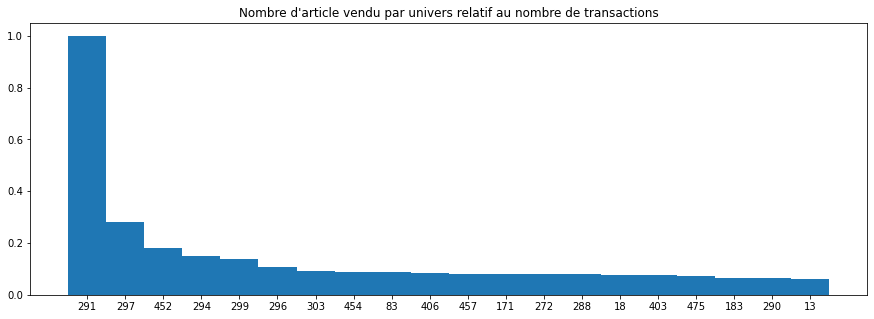

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 4.63)
("Nombre moyen d'univ", 1.06)
('CA univ', 10485.73)
('CA moyen univ', 4.26)
('Nombre moyen article en plus', 7.72)
('CA en plus', 63701.12)
('CA moyen en plus', 25.89)
==============292===================
12143
Time Taken to load recurence: ~0secondes


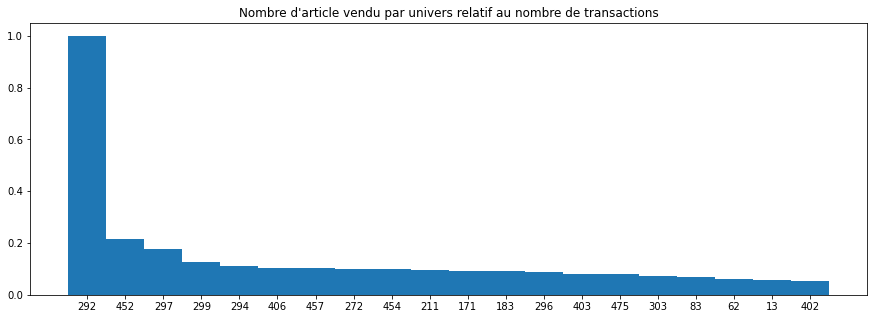

("Proportion d'achat (%)", 0.32)
('Proportion achat seul (%)', 3.54)
("Nombre moyen d'univ", 1.11)
('CA univ', 38137.34)
('CA moyen univ', 3.14)
('Nombre moyen article en plus', 7.44)
('CA en plus', 309062.63)
('CA moyen en plus', 25.45)
==============293===================
5105
Time Taken to load recurence: ~0secondes


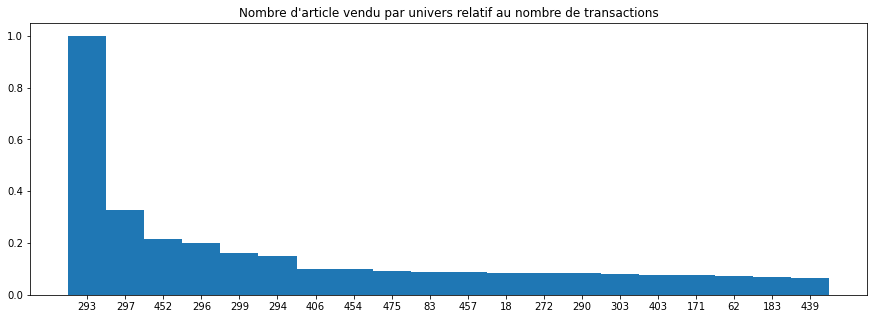

("Proportion d'achat (%)", 0.13)
('Proportion achat seul (%)', 2.53)
("Nombre moyen d'univ", 1.18)
('CA univ', 21613.88)
('CA moyen univ', 4.23)
('Nombre moyen article en plus', 8.41)
('CA en plus', 145255.93)
('CA moyen en plus', 28.45)
==============294===================
358564
Time Taken to load recurence: ~0secondes


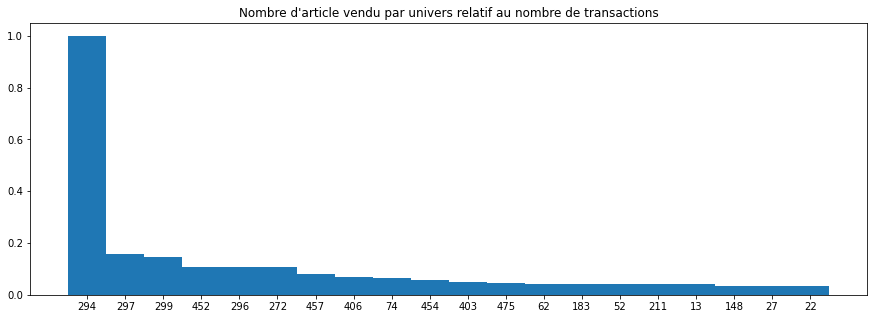

("Proportion d'achat (%)", 9.45)
('Proportion achat seul (%)', 15.28)
("Nombre moyen d'univ", 1.31)
('CA univ', 738429.89)
('CA moyen univ', 2.06)
('Nombre moyen article en plus', 4.33)
('CA en plus', 5303145.45)
('CA moyen en plus', 14.79)
==============295===================
74
Time Taken to load recurence: ~0secondes


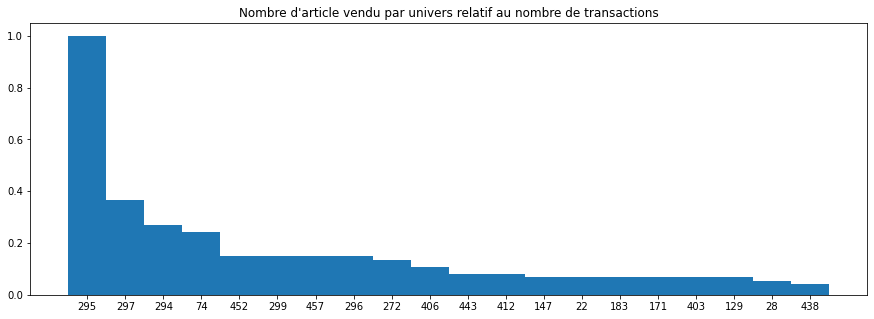

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 6.76)
("Nombre moyen d'univ", 1.15)
('CA univ', 120.3)
('CA moyen univ', 1.63)
('Nombre moyen article en plus', 5.82)
('CA en plus', 1494.48)
('CA moyen en plus', 20.2)
==============296===================
226862
Time Taken to load recurence: ~0secondes


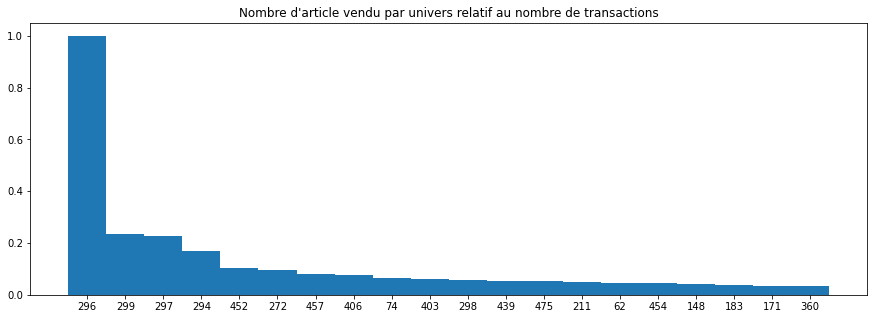

("Proportion d'achat (%)", 5.98)
('Proportion achat seul (%)', 7.68)
("Nombre moyen d'univ", 1.9)
('CA univ', 526858.78)
('CA moyen univ', 2.32)
('Nombre moyen article en plus', 4.81)
('CA en plus', 3471515.93)
('CA moyen en plus', 15.3)
==============297===================
428692
Time Taken to load recurence: ~1secondes


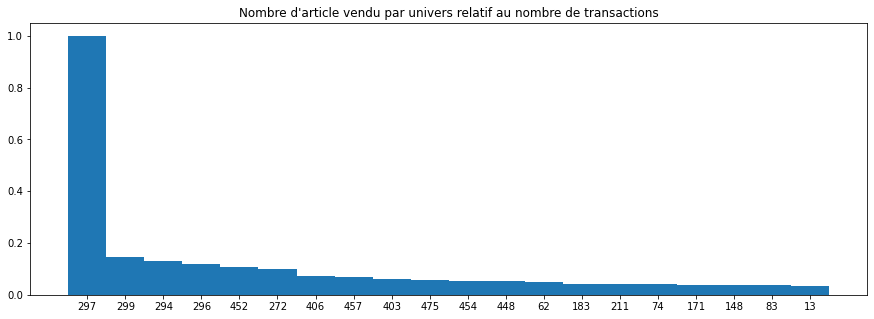

("Proportion d'achat (%)", 11.29)
('Proportion achat seul (%)', 15.26)
("Nombre moyen d'univ", 1.2)
('CA univ', 1170459.48)
('CA moyen univ', 2.73)
('Nombre moyen article en plus', 4.52)
('CA en plus', 6514444.56)
('CA moyen en plus', 15.2)
==============298===================
51441
Time Taken to load recurence: ~0secondes


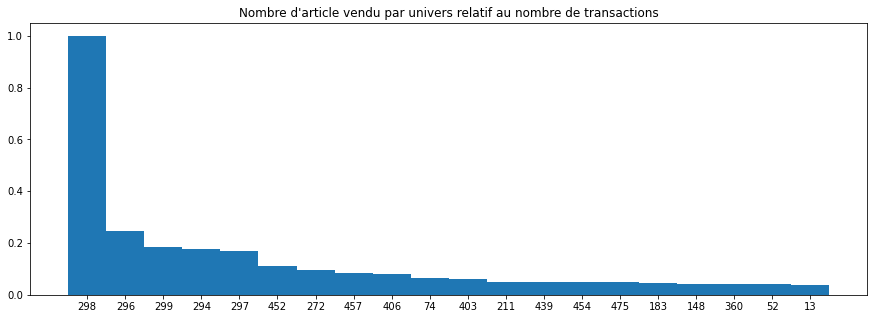

("Proportion d'achat (%)", 1.36)
('Proportion achat seul (%)', 6.63)
("Nombre moyen d'univ", 1.31)
('CA univ', 92167.78)
('CA moyen univ', 1.79)
('Nombre moyen article en plus', 5.17)
('CA en plus', 822435.33)
('CA moyen en plus', 15.99)
==============299===================
515364
Time Taken to load recurence: ~1secondes


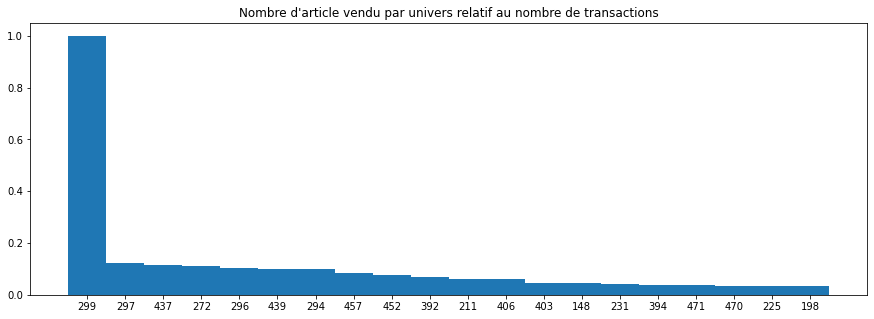

("Proportion d'achat (%)", 13.58)
('Proportion achat seul (%)', 12.16)
("Nombre moyen d'univ", 2.03)
('CA univ', 1432257.68)
('CA moyen univ', 2.78)
('Nombre moyen article en plus', 3.59)
('CA en plus', 6119781.43)
('CA moyen en plus', 11.87)
==============300===================
60630
Time Taken to load recurence: ~0secondes


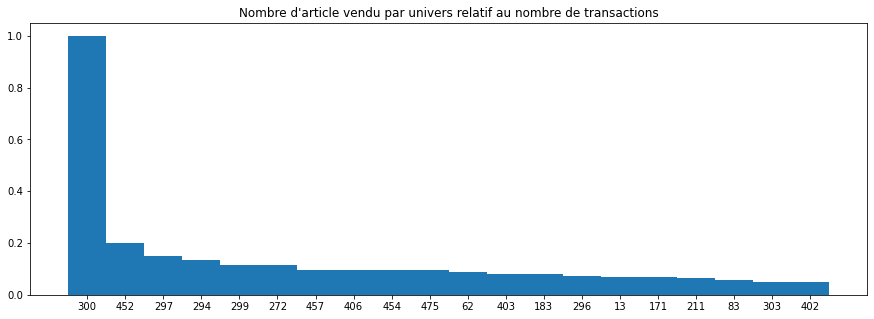

("Proportion d'achat (%)", 1.6)
('Proportion achat seul (%)', 7.02)
("Nombre moyen d'univ", 1.14)
('CA univ', 216724.88)
('CA moyen univ', 3.57)
('Nombre moyen article en plus', 6.55)
('CA en plus', 1400935.18)
('CA moyen en plus', 23.11)
==============301===================
25606
Time Taken to load recurence: ~0secondes


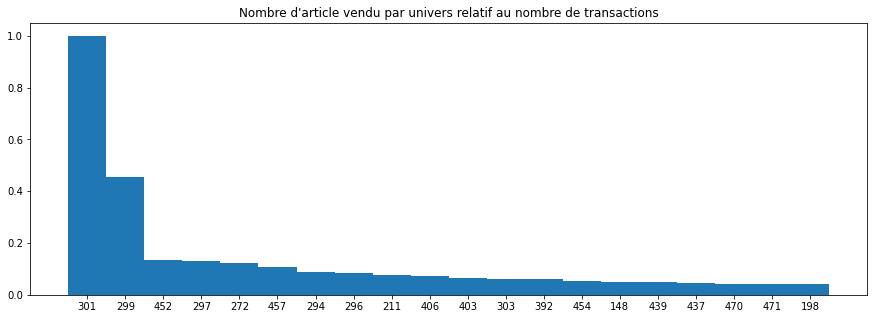

("Proportion d'achat (%)", 0.67)
('Proportion achat seul (%)', 4.38)
("Nombre moyen d'univ", 1.11)
('CA univ', 57359.64)
('CA moyen univ', 2.24)
('Nombre moyen article en plus', 5.68)
('CA en plus', 428058.28)
('CA moyen en plus', 16.72)
==============302===================
18433
Time Taken to load recurence: ~0secondes


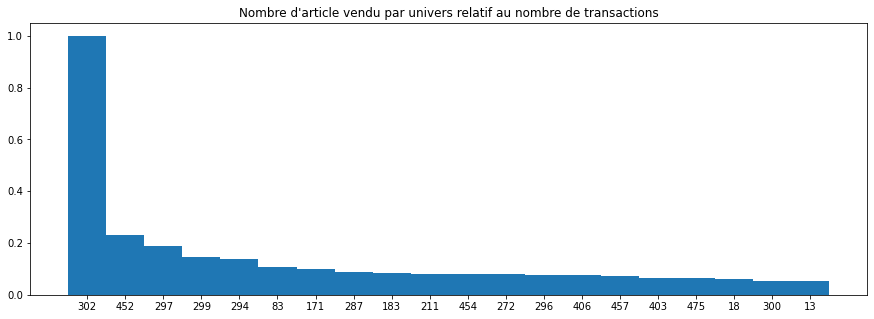

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 7.55)
("Nombre moyen d'univ", 1.25)
('CA univ', 48991.41)
('CA moyen univ', 2.66)
('Nombre moyen article en plus', 6.85)
('CA en plus', 425166.03)
('CA moyen en plus', 23.07)
==============303===================
63660
Time Taken to load recurence: ~0secondes


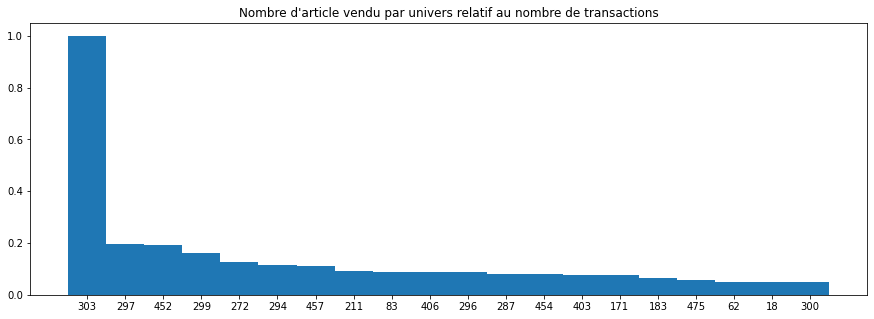

("Proportion d'achat (%)", 1.68)
('Proportion achat seul (%)', 6.86)
("Nombre moyen d'univ", 1.23)
('CA univ', 157946.57)
('CA moyen univ', 2.48)
('Nombre moyen article en plus', 6.67)
('CA en plus', 1441367.21)
('CA moyen en plus', 22.64)
==============305===================
14178
Time Taken to load recurence: ~0secondes


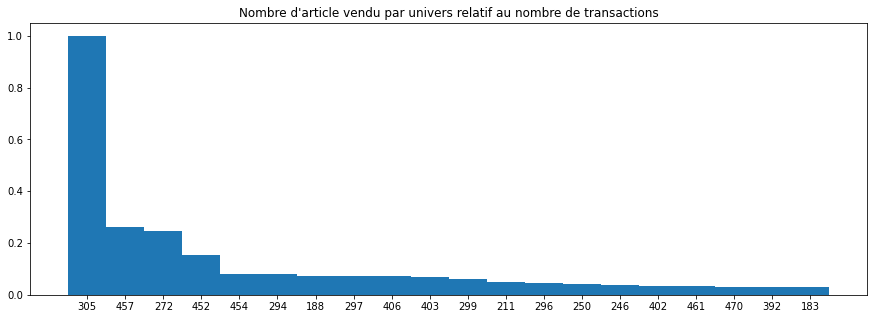

("Proportion d'achat (%)", 0.37)
('Proportion achat seul (%)', 13.64)
("Nombre moyen d'univ", 1.07)
('CA univ', 269468.68)
('CA moyen univ', 19.01)
('Nombre moyen article en plus', 4.59)
('CA en plus', 268610.66)
('CA moyen en plus', 18.95)
==============306===================
9629
Time Taken to load recurence: ~0secondes


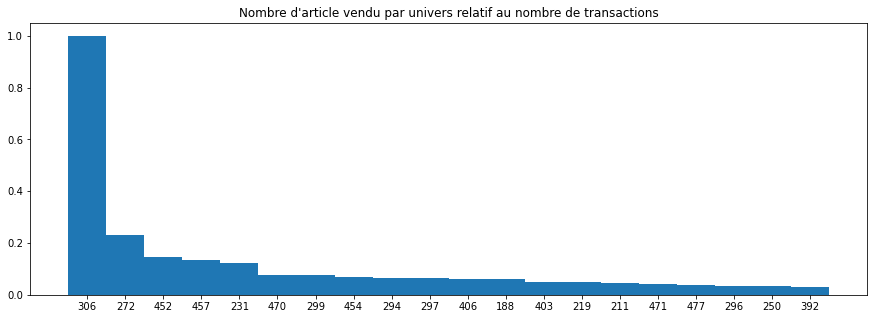

("Proportion d'achat (%)", 0.25)
('Proportion achat seul (%)', 14.64)
("Nombre moyen d'univ", 1.09)
('CA univ', 154589.47)
('CA moyen univ', 16.05)
('Nombre moyen article en plus', 4.19)
('CA en plus', 159852.06)
('CA moyen en plus', 16.6)
==============307===================
5937
Time Taken to load recurence: ~0secondes


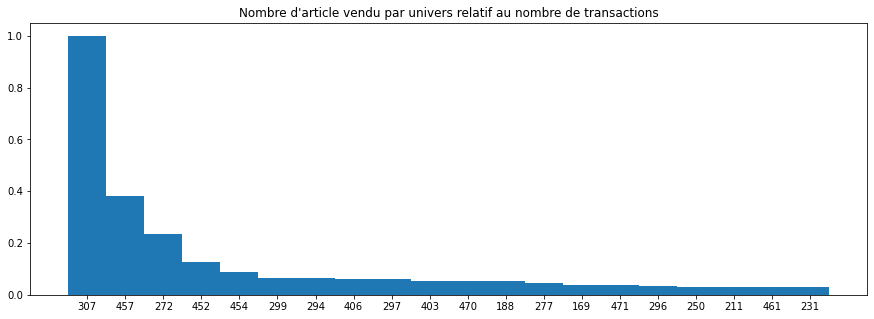

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 12.63)
("Nombre moyen d'univ", 1.07)
('CA univ', 113045.51)
('CA moyen univ', 19.04)
('Nombre moyen article en plus', 4.29)
('CA en plus', 99638.73)
('CA moyen en plus', 16.78)
==============308===================
3440
Time Taken to load recurence: ~0secondes


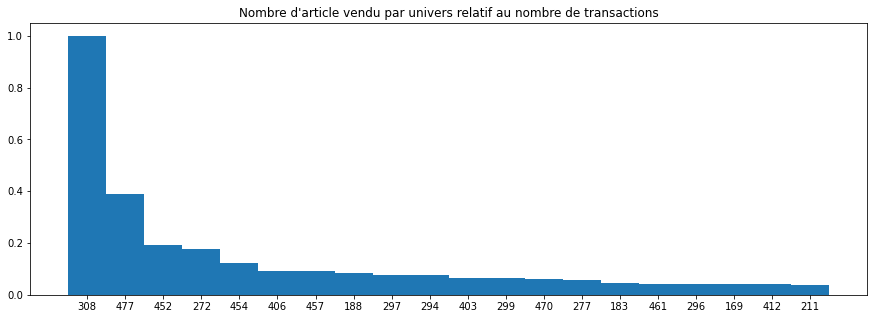

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 9.19)
("Nombre moyen d'univ", 1.06)
('CA univ', 98464.63)
('CA moyen univ', 28.62)
('Nombre moyen article en plus', 5.68)
('CA en plus', 88795.75)
('CA moyen en plus', 25.81)
==============309===================
400
Time Taken to load recurence: ~0secondes


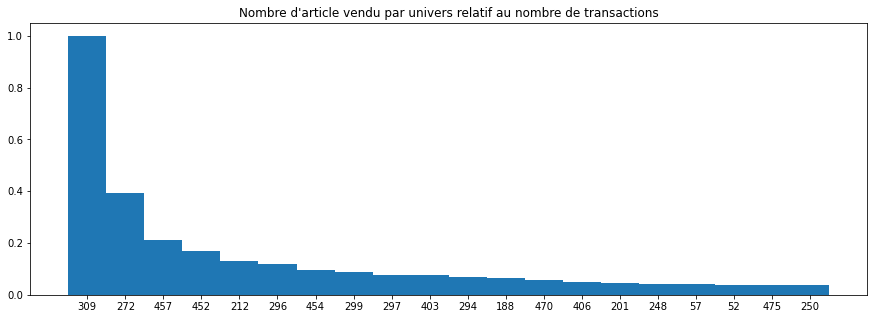

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 20.0)
("Nombre moyen d'univ", 1.09)
('CA univ', 7745.43)
('CA moyen univ', 19.36)
('Nombre moyen article en plus', 4.59)
('CA en plus', 7089.94)
('CA moyen en plus', 17.72)
==============310===================
1654
Time Taken to load recurence: ~0secondes


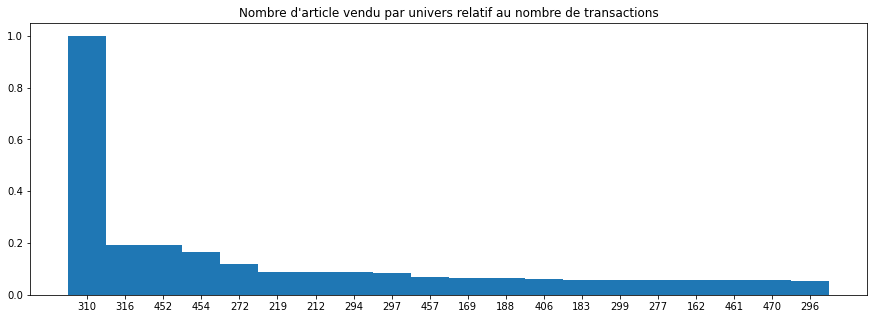

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 11.25)
("Nombre moyen d'univ", 1.07)
('CA univ', 26554.22)
('CA moyen univ', 16.05)
('Nombre moyen article en plus', 6.18)
('CA en plus', 44195.24)
('CA moyen en plus', 26.72)
==============311===================
25787
Time Taken to load recurence: ~0secondes


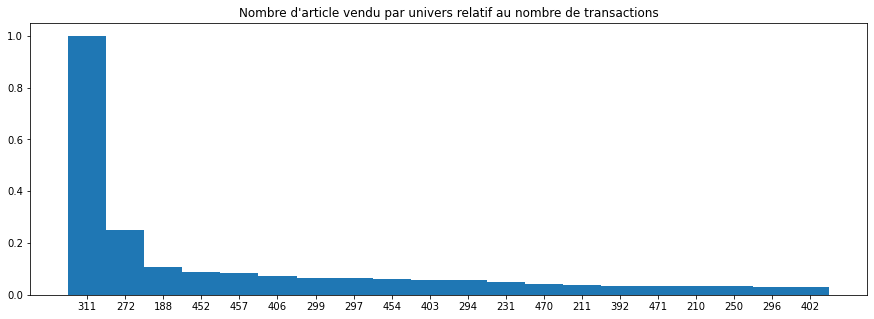

("Proportion d'achat (%)", 0.68)
('Proportion achat seul (%)', 17.2)
("Nombre moyen d'univ", 1.43)
('CA univ', 137658.84)
('CA moyen univ', 5.34)
('Nombre moyen article en plus', 3.42)
('CA en plus', 347912.53)
('CA moyen en plus', 13.49)
==============312===================
11167
Time Taken to load recurence: ~0secondes


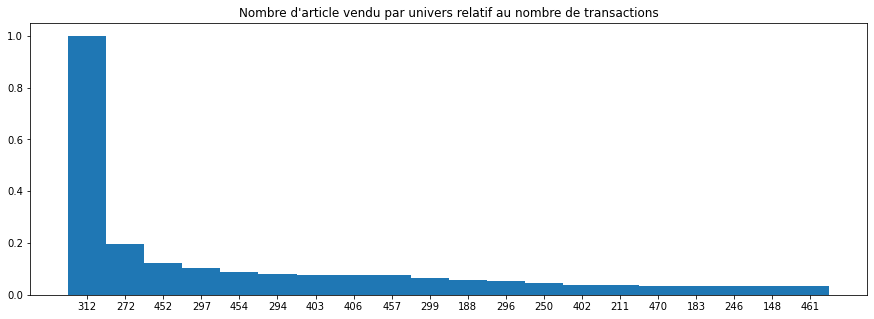

("Proportion d'achat (%)", 0.29)
('Proportion achat seul (%)', 14.08)
("Nombre moyen d'univ", 1.11)
('CA univ', 155580.09)
('CA moyen univ', 13.93)
('Nombre moyen article en plus', 4.69)
('CA en plus', 220111.25)
('CA moyen en plus', 19.71)
==============313===================
7676
Time Taken to load recurence: ~0secondes


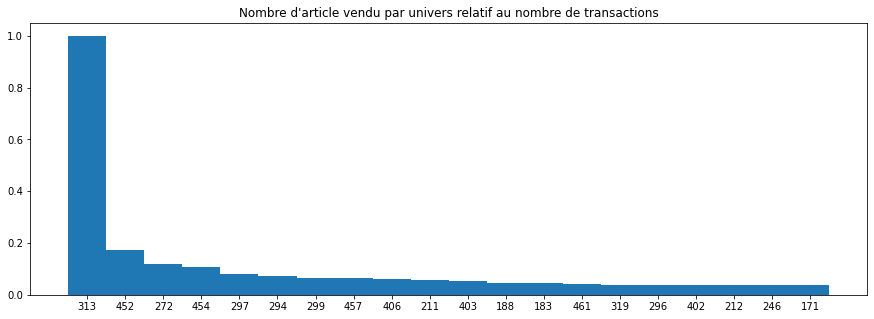

("Proportion d'achat (%)", 0.2)
('Proportion achat seul (%)', 20.7)
("Nombre moyen d'univ", 1.16)
('CA univ', 299884.78)
('CA moyen univ', 39.07)
('Nombre moyen article en plus', 4.9)
('CA en plus', 167089.62)
('CA moyen en plus', 21.77)
==============314===================
342
Time Taken to load recurence: ~0secondes


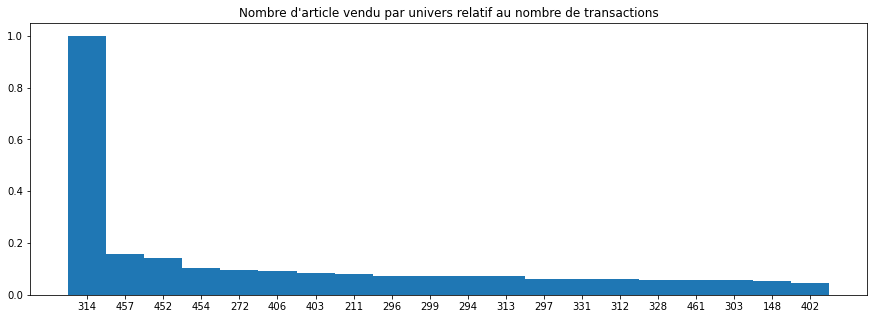

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 16.37)
("Nombre moyen d'univ", 1.14)
('CA univ', 12952.17)
('CA moyen univ', 37.87)
('Nombre moyen article en plus', 5.3)
('CA en plus', 7992.78)
('CA moyen en plus', 23.37)
==============315===================
935
Time Taken to load recurence: ~0secondes


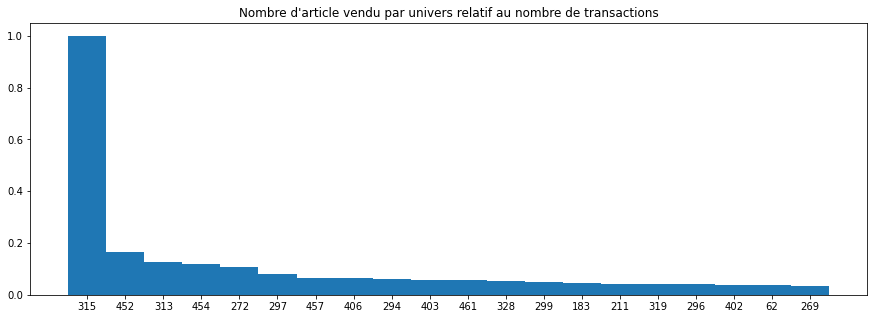

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 20.21)
("Nombre moyen d'univ", 1.15)
('CA univ', 45613.13)
('CA moyen univ', 48.78)
('Nombre moyen article en plus', 5.19)
('CA en plus', 27239.74)
('CA moyen en plus', 29.13)
==============316===================
23021
Time Taken to load recurence: ~0secondes


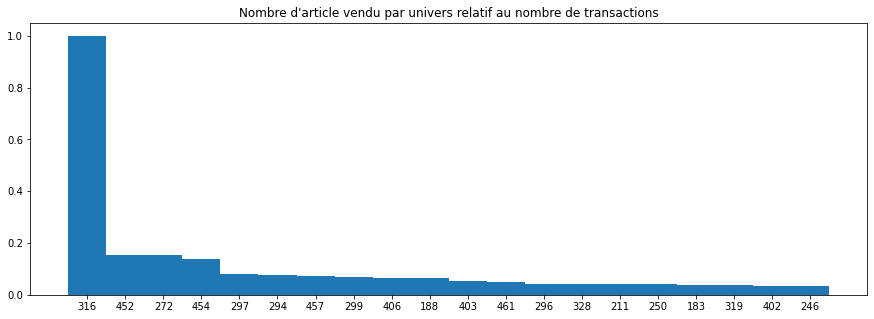

("Proportion d'achat (%)", 0.61)
('Proportion achat seul (%)', 15.77)
("Nombre moyen d'univ", 1.2)
('CA univ', 295001.78)
('CA moyen univ', 12.81)
('Nombre moyen article en plus', 4.48)
('CA en plus', 410537.63)
('CA moyen en plus', 17.83)
==============317===================
7106
Time Taken to load recurence: ~0secondes


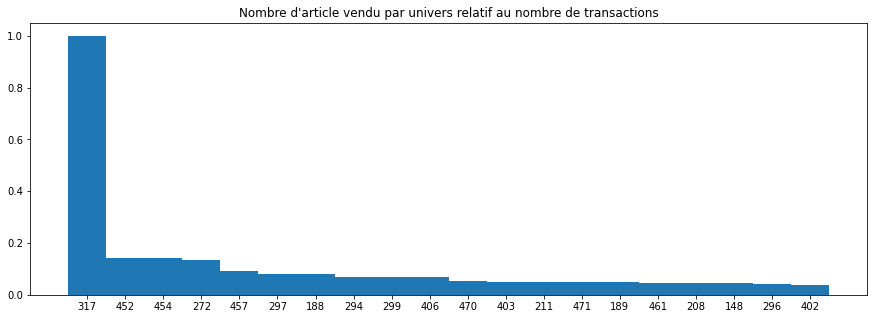

("Proportion d'achat (%)", 0.19)
('Proportion achat seul (%)', 11.88)
("Nombre moyen d'univ", 1.38)
('CA univ', 28773.15)
('CA moyen univ', 4.05)
('Nombre moyen article en plus', 4.83)
('CA en plus', 130209.5)
('CA moyen en plus', 18.32)
==============318===================
1729
Time Taken to load recurence: ~0secondes


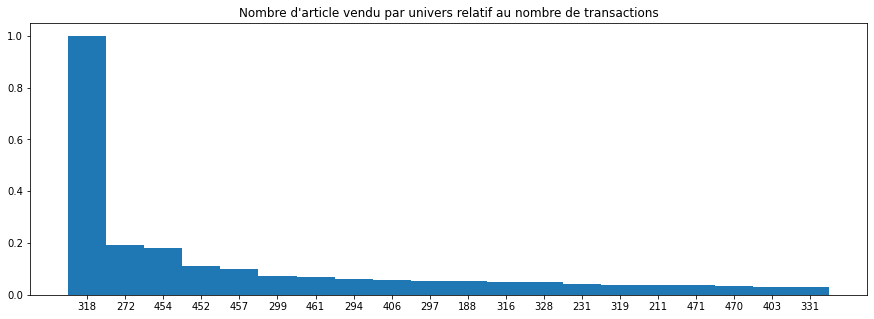

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 17.35)
("Nombre moyen d'univ", 1.12)
('CA univ', 23121.57)
('CA moyen univ', 13.37)
('Nombre moyen article en plus', 4.15)
('CA en plus', 30217.05)
('CA moyen en plus', 17.48)
==============319===================
40220
Time Taken to load recurence: ~0secondes


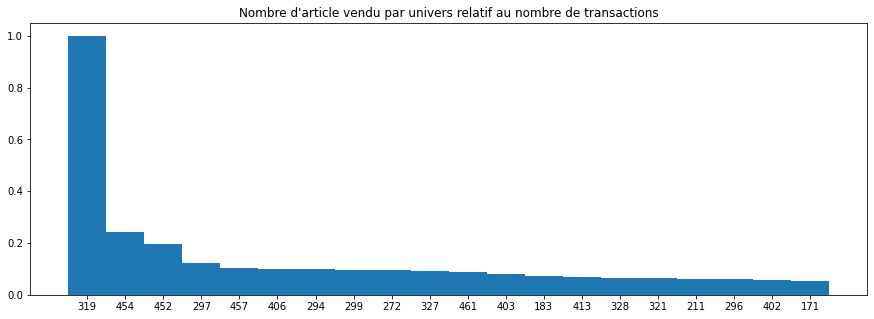

("Proportion d'achat (%)", 1.06)
('Proportion achat seul (%)', 2.66)
("Nombre moyen d'univ", 1.25)
('CA univ', 142894.29)
('CA moyen univ', 3.55)
('Nombre moyen article en plus', 7.05)
('CA en plus', 1067212.88)
('CA moyen en plus', 26.53)
==============320===================
3006
Time Taken to load recurence: ~0secondes


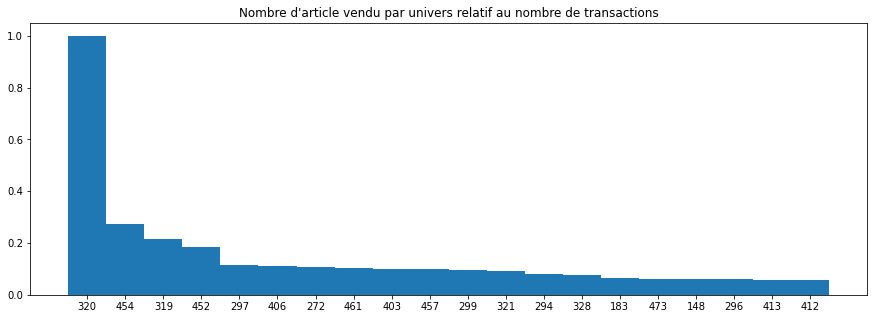

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 1.83)
("Nombre moyen d'univ", 1.14)
('CA univ', 9098.27)
('CA moyen univ', 3.03)
('Nombre moyen article en plus', 7.5)
('CA en plus', 86513.67)
('CA moyen en plus', 28.78)
==============321===================
29689
Time Taken to load recurence: ~0secondes


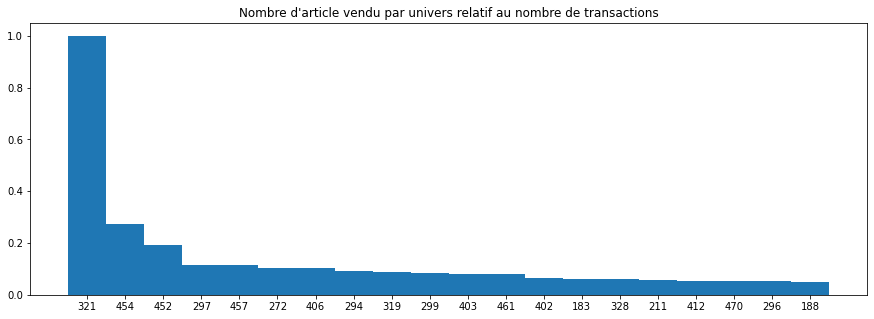

("Proportion d'achat (%)", 0.78)
('Proportion achat seul (%)', 2.8)
("Nombre moyen d'univ", 1.15)
('CA univ', 114494.17)
('CA moyen univ', 3.86)
('Nombre moyen article en plus', 6.77)
('CA en plus', 753890.86)
('CA moyen en plus', 25.39)
==============322===================
1724
Time Taken to load recurence: ~0secondes


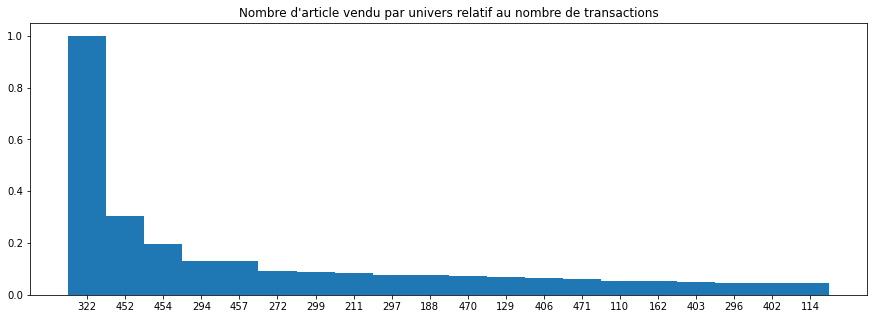

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 4.93)
("Nombre moyen d'univ", 1.2)
('CA univ', 3322.83)
('CA moyen univ', 1.93)
('Nombre moyen article en plus', 5.94)
('CA en plus', 31071.77)
('CA moyen en plus', 18.02)
==============323===================
6821
Time Taken to load recurence: ~0secondes


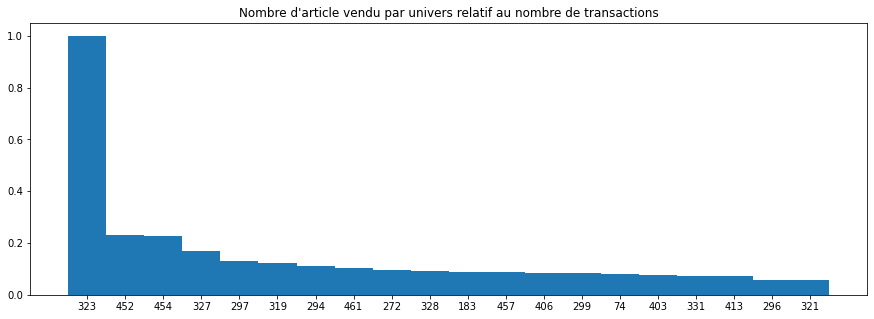

("Proportion d'achat (%)", 0.18)
('Proportion achat seul (%)', 3.68)
("Nombre moyen d'univ", 1.17)
('CA univ', 14830.16)
('CA moyen univ', 2.17)
('Nombre moyen article en plus', 7.57)
('CA en plus', 194847.49)
('CA moyen en plus', 28.57)
==============324===================
16157
Time Taken to load recurence: ~0secondes


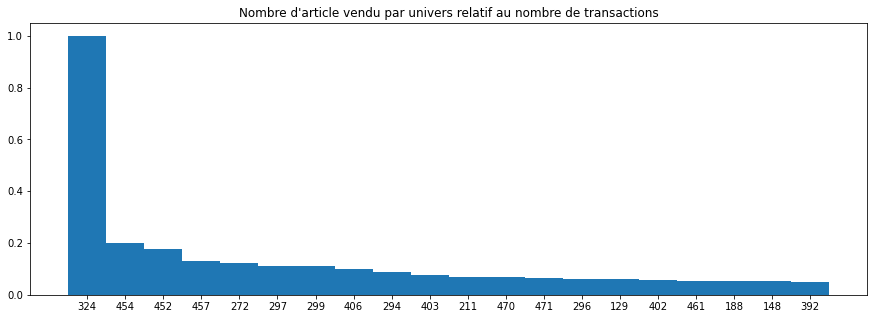

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 3.94)
("Nombre moyen d'univ", 1.3)
('CA univ', 44909.1)
('CA moyen univ', 2.78)
('Nombre moyen article en plus', 6.17)
('CA en plus', 349991.69)
('CA moyen en plus', 21.66)
==============326===================
747
Time Taken to load recurence: ~0secondes


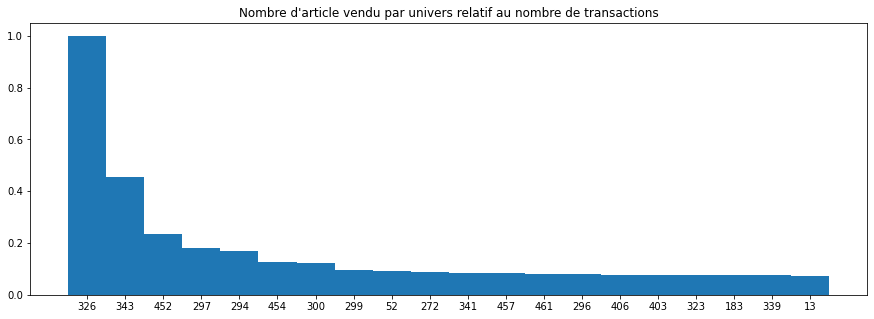

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 5.76)
("Nombre moyen d'univ", 1.14)
('CA univ', 3013.21)
('CA moyen univ', 4.03)
('Nombre moyen article en plus', 8.38)
('CA en plus', 26960.03)
('CA moyen en plus', 36.09)
==============327===================
24103
Time Taken to load recurence: ~0secondes


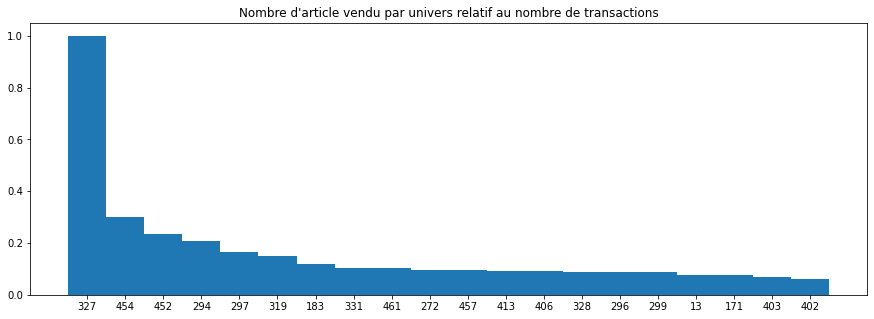

("Proportion d'achat (%)", 0.64)
('Proportion achat seul (%)', 1.36)
("Nombre moyen d'univ", 1.18)
('CA univ', 97201.07)
('CA moyen univ', 4.03)
('Nombre moyen article en plus', 7.89)
('CA en plus', 686951.21)
('CA moyen en plus', 28.5)
==============328===================
34442
Time Taken to load recurence: ~0secondes


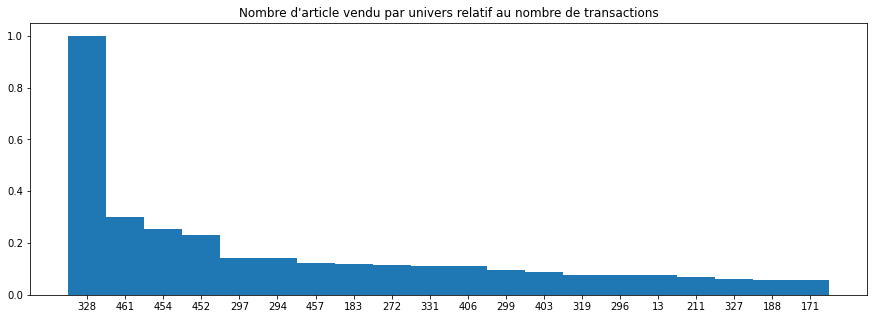

("Proportion d'achat (%)", 0.91)
('Proportion achat seul (%)', 1.0)
("Nombre moyen d'univ", 1.1)
('CA univ', 126846.25)
('CA moyen univ', 3.68)
('Nombre moyen article en plus', 8.15)
('CA en plus', 1039482.0)
('CA moyen en plus', 30.18)
==============329===================
2778
Time Taken to load recurence: ~0secondes


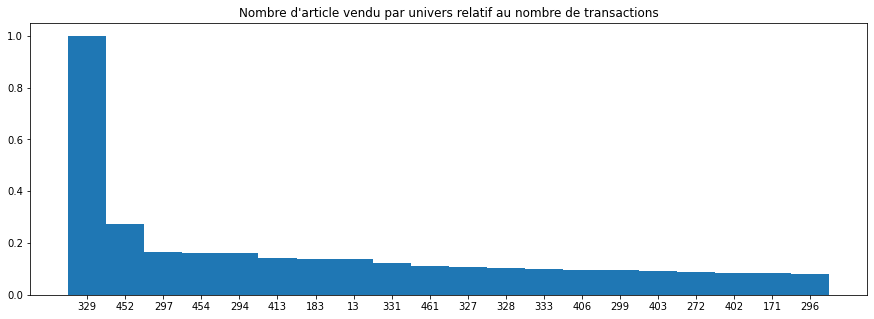

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 1.44)
("Nombre moyen d'univ", 1.08)
('CA univ', 12207.84)
('CA moyen univ', 4.39)
('Nombre moyen article en plus', 9.0)
('CA en plus', 93638.92)
('CA moyen en plus', 33.71)
==============331===================
21714
Time Taken to load recurence: ~0secondes


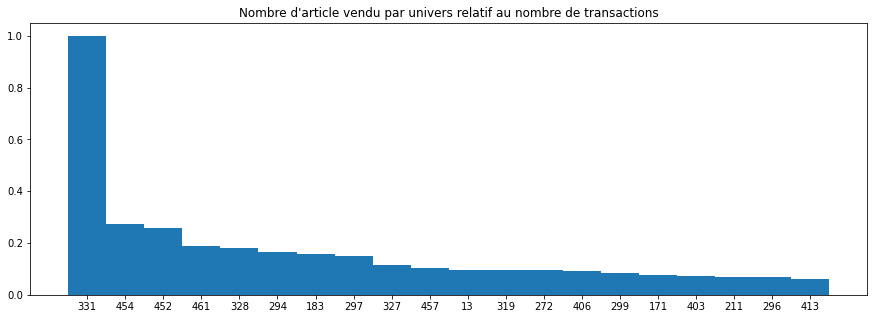

("Proportion d'achat (%)", 0.57)
('Proportion achat seul (%)', 1.11)
("Nombre moyen d'univ", 1.09)
('CA univ', 69698.53)
('CA moyen univ', 3.21)
('Nombre moyen article en plus', 8.54)
('CA en plus', 683013.53)
('CA moyen en plus', 31.45)
==============332===================
245
Time Taken to load recurence: ~0secondes


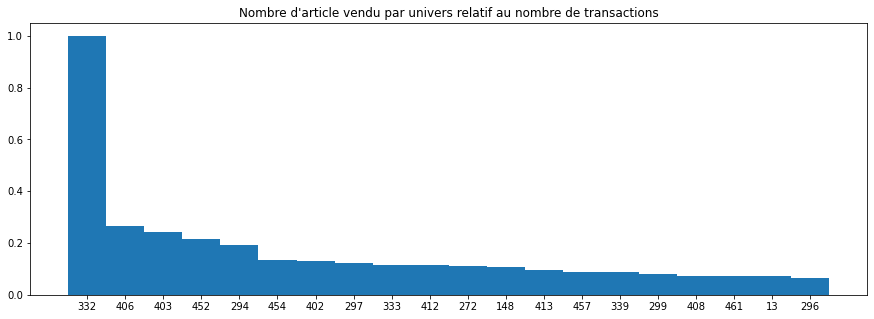

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 1.63)
("Nombre moyen d'univ", 1.17)
('CA univ', 2147.6)
('CA moyen univ', 8.77)
('Nombre moyen article en plus', 8.67)
('CA en plus', 9344.88)
('CA moyen en plus', 38.14)
==============333===================
7611
Time Taken to load recurence: ~0secondes


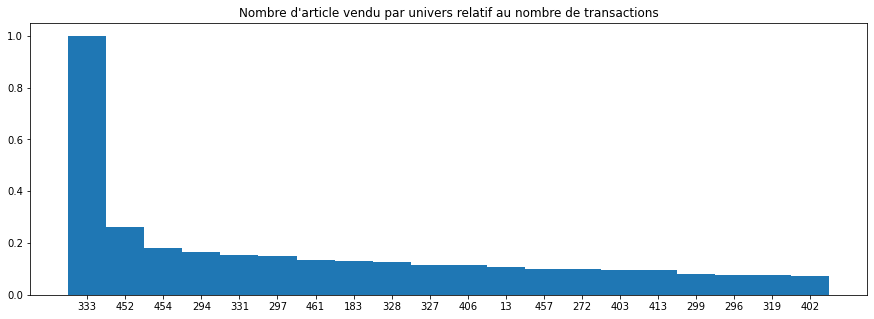

("Proportion d'achat (%)", 0.2)
('Proportion achat seul (%)', 1.06)
("Nombre moyen d'univ", 1.12)
('CA univ', 35191.88)
('CA moyen univ', 4.62)
('Nombre moyen article en plus', 8.59)
('CA en plus', 250234.45)
('CA moyen en plus', 32.88)
==============334===================
6755
Time Taken to load recurence: ~0secondes


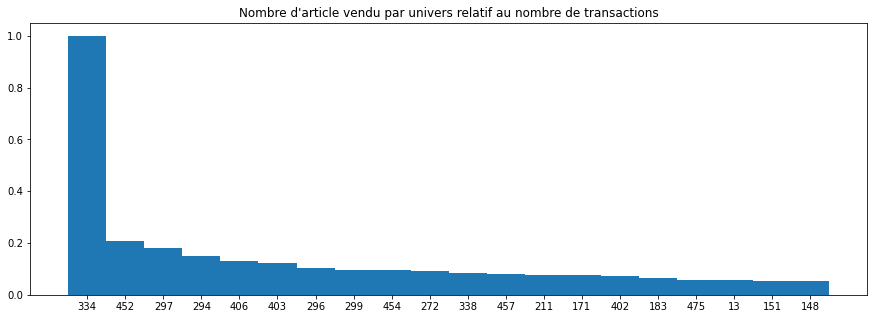

("Proportion d'achat (%)", 0.18)
('Proportion achat seul (%)', 4.07)
("Nombre moyen d'univ", 1.23)
('CA univ', 39248.24)
('CA moyen univ', 5.81)
('Nombre moyen article en plus', 7.21)
('CA en plus', 175991.44)
('CA moyen en plus', 26.05)
==============335===================
3141
Time Taken to load recurence: ~0secondes


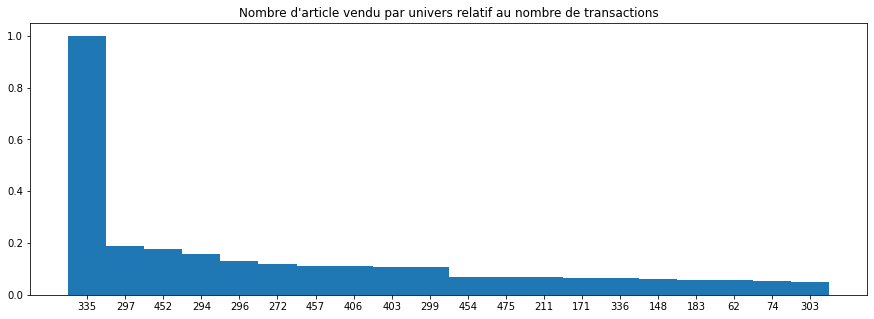

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 4.39)
("Nombre moyen d'univ", 1.15)
('CA univ', 11455.71)
('CA moyen univ', 3.65)
('Nombre moyen article en plus', 6.65)
('CA en plus', 69260.22)
('CA moyen en plus', 22.05)
==============336===================
8448
Time Taken to load recurence: ~0secondes


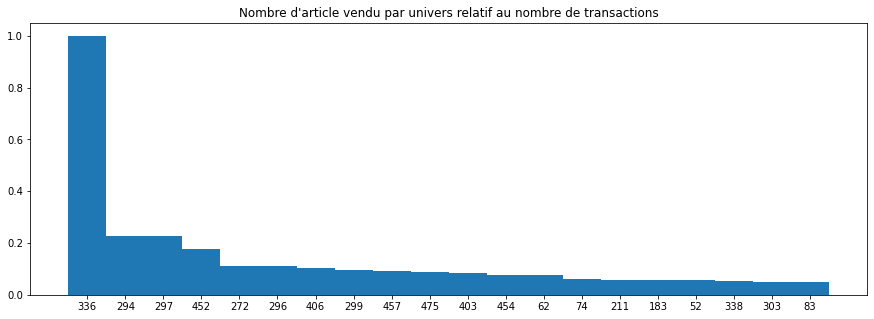

("Proportion d'achat (%)", 0.22)
('Proportion achat seul (%)', 4.84)
("Nombre moyen d'univ", 1.14)
('CA univ', 44347.55)
('CA moyen univ', 5.25)
('Nombre moyen article en plus', 6.47)
('CA en plus', 185566.6)
('CA moyen en plus', 21.97)
==============337===================
1780
Time Taken to load recurence: ~0secondes


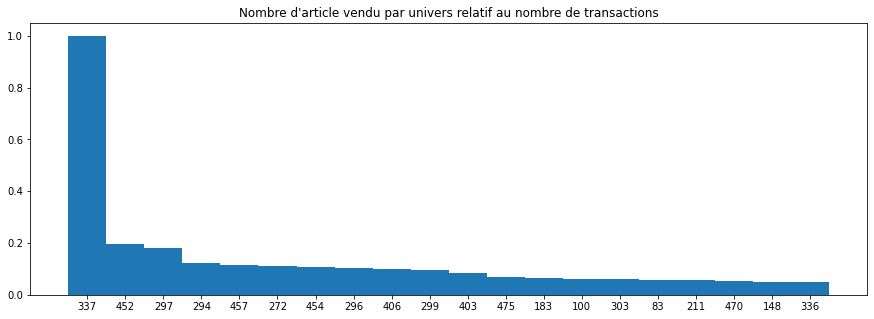

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 5.28)
("Nombre moyen d'univ", 1.31)
('CA univ', 4597.04)
('CA moyen univ', 2.58)
('Nombre moyen article en plus', 6.79)
('CA en plus', 41875.63)
('CA moyen en plus', 23.53)
==============338===================
4458
Time Taken to load recurence: ~0secondes


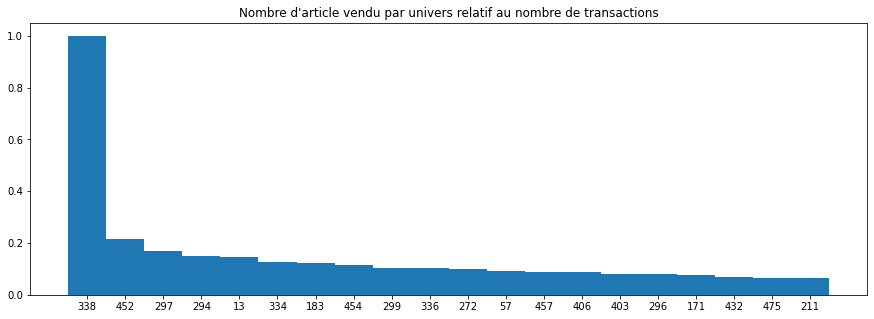

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 2.31)
("Nombre moyen d'univ", 1.27)
('CA univ', 10822.69)
('CA moyen univ', 2.43)
('Nombre moyen article en plus', 8.08)
('CA en plus', 129185.57)
('CA moyen en plus', 28.98)
==============339===================
18735
Time Taken to load recurence: ~0secondes


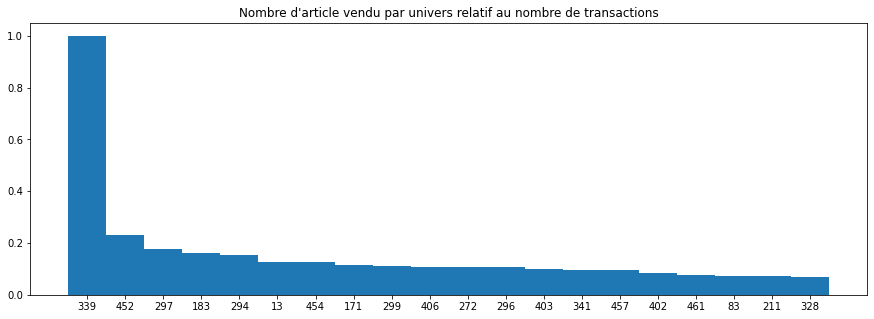

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 2.04)
("Nombre moyen d'univ", 1.2)
('CA univ', 116819.97)
('CA moyen univ', 6.24)
('Nombre moyen article en plus', 8.88)
('CA en plus', 609376.47)
('CA moyen en plus', 32.53)
==============341===================
19869
Time Taken to load recurence: ~0secondes


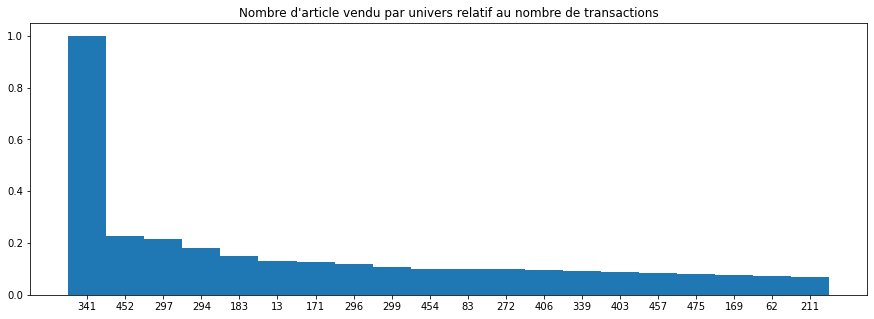

("Proportion d'achat (%)", 0.52)
('Proportion achat seul (%)', 2.43)
("Nombre moyen d'univ", 1.23)
('CA univ', 159188.18)
('CA moyen univ', 8.01)
('Nombre moyen article en plus', 8.59)
('CA en plus', 619142.32)
('CA moyen en plus', 31.16)
==============342===================
1624
Time Taken to load recurence: ~0secondes


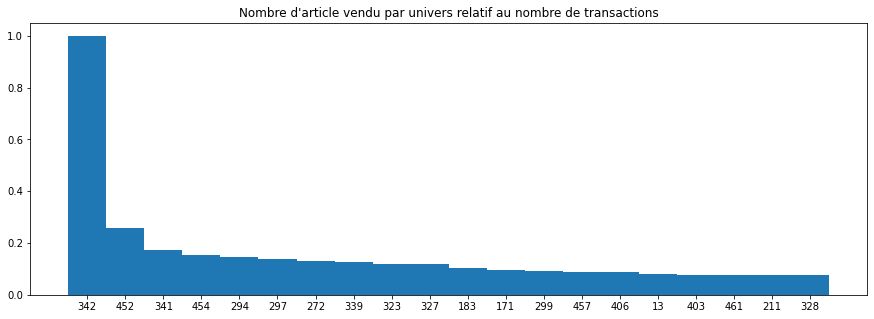

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 4.56)
("Nombre moyen d'univ", 1.32)
('CA univ', 11538.64)
('CA moyen univ', 7.11)
('Nombre moyen article en plus', 9.32)
('CA en plus', 60767.36)
('CA moyen en plus', 37.42)
==============343===================
3338
Time Taken to load recurence: ~0secondes


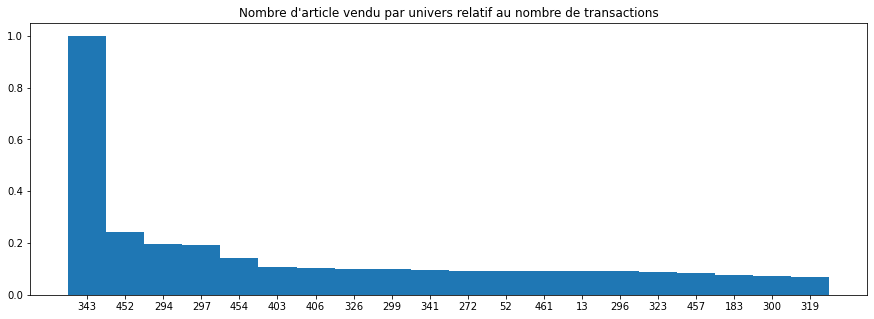

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 2.97)
("Nombre moyen d'univ", 1.15)
('CA univ', 29370.93)
('CA moyen univ', 8.8)
('Nombre moyen article en plus', 8.87)
('CA en plus', 119511.88)
('CA moyen en plus', 35.8)
==============344===================
19077
Time Taken to load recurence: ~0secondes


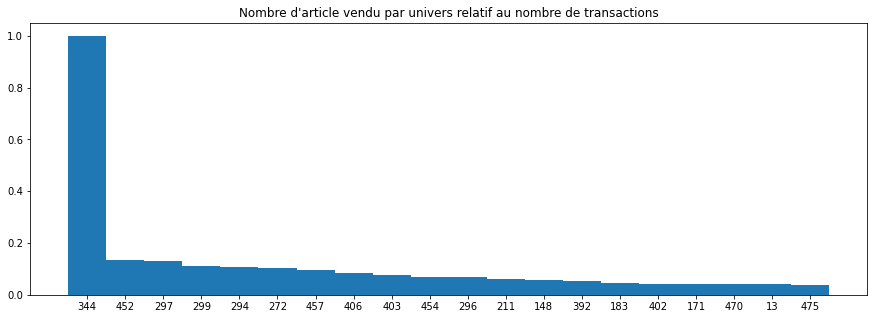

("Proportion d'achat (%)", 0.5)
('Proportion achat seul (%)', 12.15)
("Nombre moyen d'univ", 1.18)
('CA univ', 114255.26)
('CA moyen univ', 5.99)
('Nombre moyen article en plus', 5.32)
('CA en plus', 353988.24)
('CA moyen en plus', 18.56)
==============347===================
331
Time Taken to load recurence: ~0secondes


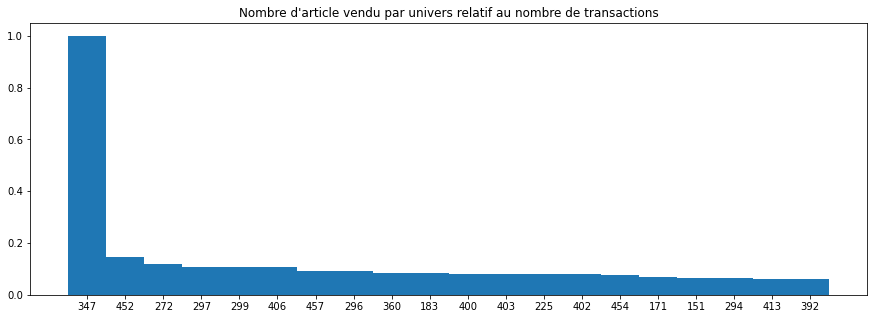

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 1.51)
("Nombre moyen d'univ", 1.05)
('CA univ', 1254.0)
('CA moyen univ', 3.79)
('Nombre moyen article en plus', 6.04)
('CA en plus', 7119.56)
('CA moyen en plus', 21.51)
==============348===================
7398
Time Taken to load recurence: ~0secondes


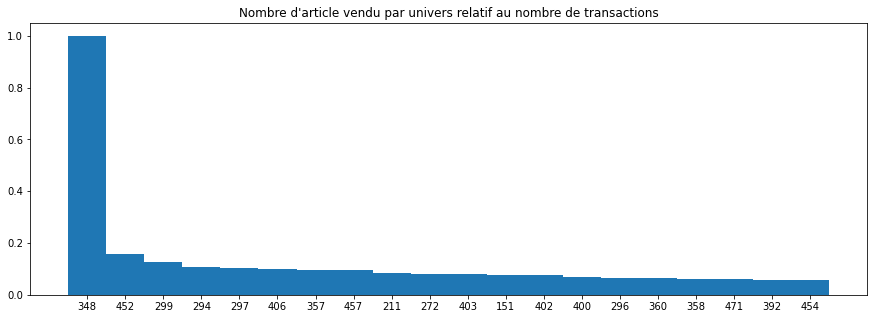

("Proportion d'achat (%)", 0.19)
('Proportion achat seul (%)', 5.3)
("Nombre moyen d'univ", 1.09)
('CA univ', 34746.74)
('CA moyen univ', 4.7)
('Nombre moyen article en plus', 5.45)
('CA en plus', 142420.83)
('CA moyen en plus', 19.25)
==============349===================
NOT ENOUGH DATA 
==============350===================
1031
Time Taken to load recurence: ~0secondes


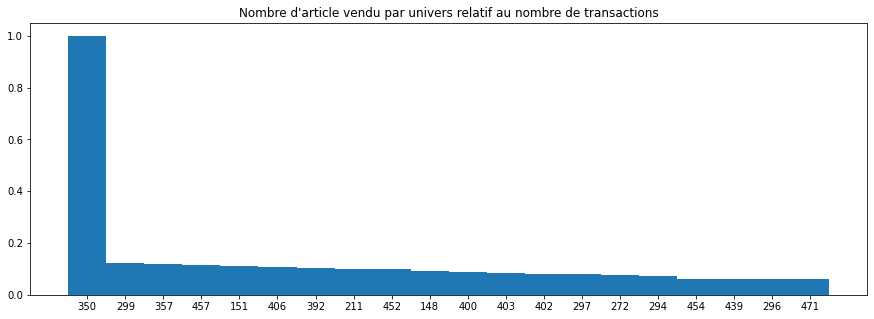

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 6.79)
("Nombre moyen d'univ", 1.05)
('CA univ', 5733.49)
('CA moyen univ', 5.56)
('Nombre moyen article en plus', 5.95)
('CA en plus', 21685.05)
('CA moyen en plus', 21.03)
==============351===================
6563
Time Taken to load recurence: ~0secondes


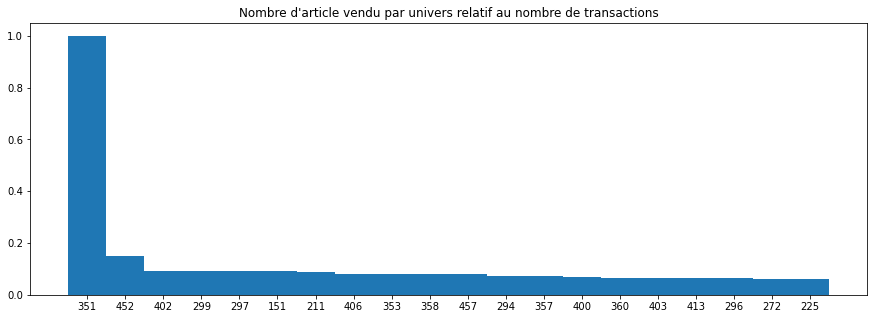

("Proportion d'achat (%)", 0.17)
('Proportion achat seul (%)', 6.29)
("Nombre moyen d'univ", 1.07)
('CA univ', 31562.84)
('CA moyen univ', 4.81)
('Nombre moyen article en plus', 5.16)
('CA en plus', 121855.28)
('CA moyen en plus', 18.57)
==============353===================
16173
Time Taken to load recurence: ~0secondes


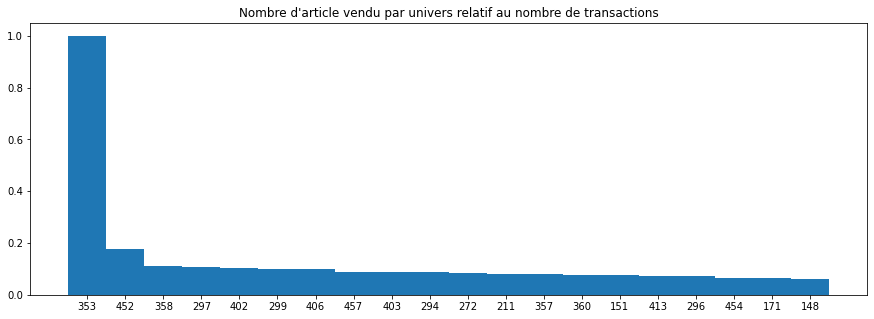

("Proportion d'achat (%)", 0.43)
('Proportion achat seul (%)', 3.78)
("Nombre moyen d'univ", 1.1)
('CA univ', 75375.61)
('CA moyen univ', 4.66)
('Nombre moyen article en plus', 5.83)
('CA en plus', 348323.94)
('CA moyen en plus', 21.54)
==============354===================
181
Time Taken to load recurence: ~0secondes


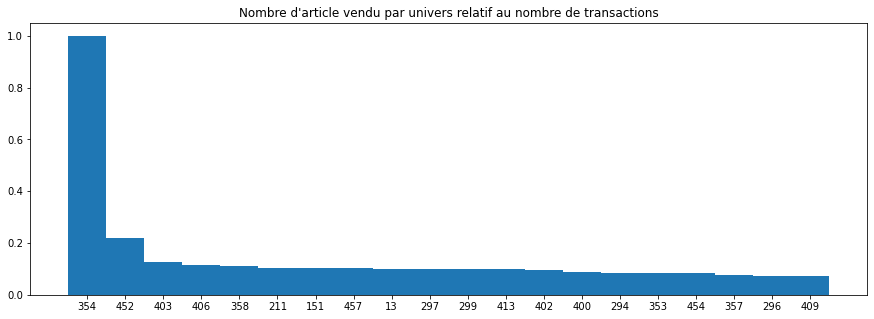

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 4.42)
("Nombre moyen d'univ", 1.07)
('CA univ', 768.9)
('CA moyen univ', 4.25)
('Nombre moyen article en plus', 5.96)
('CA en plus', 3692.62)
('CA moyen en plus', 20.4)
==============355===================
8266
Time Taken to load recurence: ~0secondes


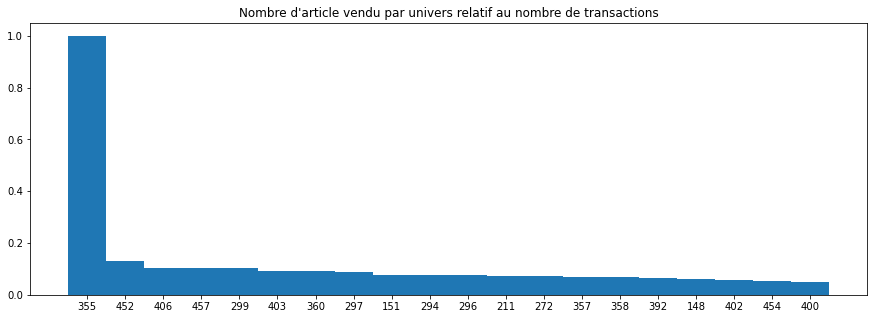

("Proportion d'achat (%)", 0.22)
('Proportion achat seul (%)', 9.04)
("Nombre moyen d'univ", 1.05)
('CA univ', 51071.39)
('CA moyen univ', 6.18)
('Nombre moyen article en plus', 4.81)
('CA en plus', 144298.22)
('CA moyen en plus', 17.46)
==============356===================
733
Time Taken to load recurence: ~0secondes


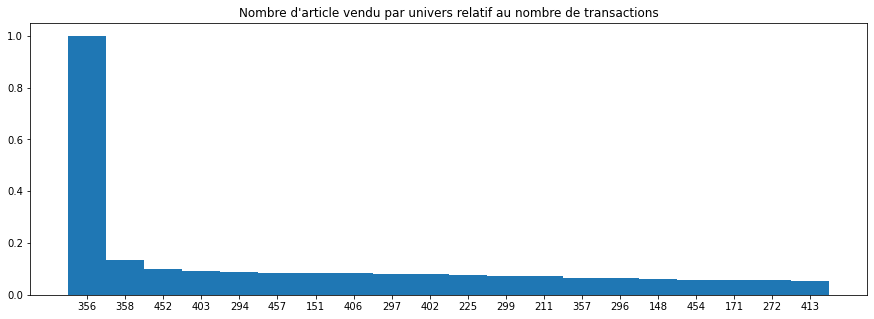

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 8.87)
("Nombre moyen d'univ", 1.04)
('CA univ', 5823.4)
('CA moyen univ', 7.94)
('Nombre moyen article en plus', 4.74)
('CA en plus', 13459.62)
('CA moyen en plus', 18.36)
==============357===================
92388
Time Taken to load recurence: ~0secondes


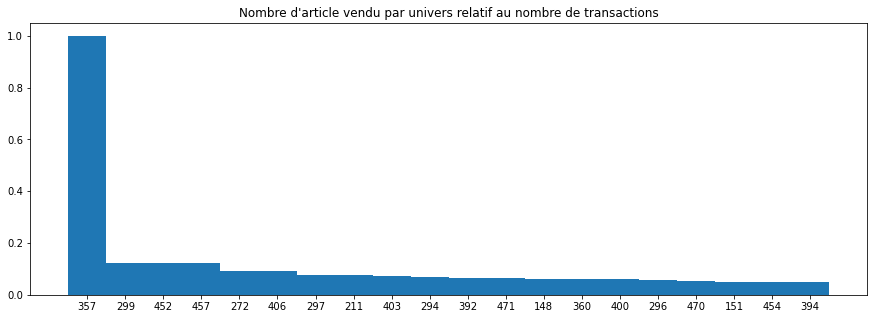

("Proportion d'achat (%)", 2.43)
('Proportion achat seul (%)', 11.42)
("Nombre moyen d'univ", 1.13)
('CA univ', 539673.3)
('CA moyen univ', 5.84)
('Nombre moyen article en plus', 4.16)
('CA en plus', 1300827.69)
('CA moyen en plus', 14.08)
==============358===================
41901
Time Taken to load recurence: ~0secondes


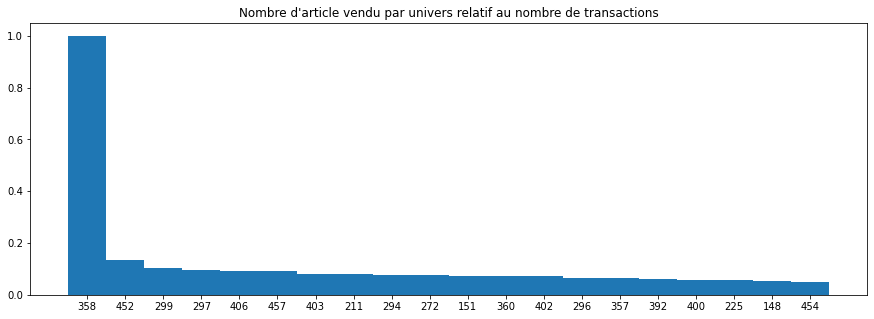

("Proportion d'achat (%)", 1.1)
('Proportion achat seul (%)', 9.34)
("Nombre moyen d'univ", 1.11)
('CA univ', 273783.91)
('CA moyen univ', 6.53)
('Nombre moyen article en plus', 4.74)
('CA en plus', 705805.15)
('CA moyen en plus', 16.84)
==============359===================
2499
Time Taken to load recurence: ~0secondes


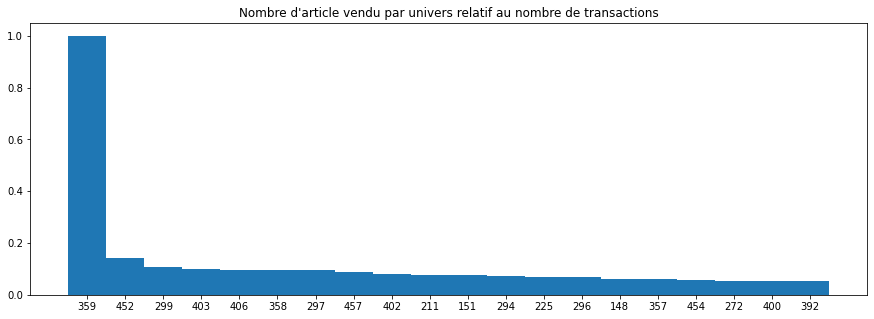

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 6.76)
("Nombre moyen d'univ", 1.04)
('CA univ', 17301.75)
('CA moyen univ', 6.92)
('Nombre moyen article en plus', 4.96)
('CA en plus', 44481.11)
('CA moyen en plus', 17.8)
==============360===================
80722
Time Taken to load recurence: ~0secondes


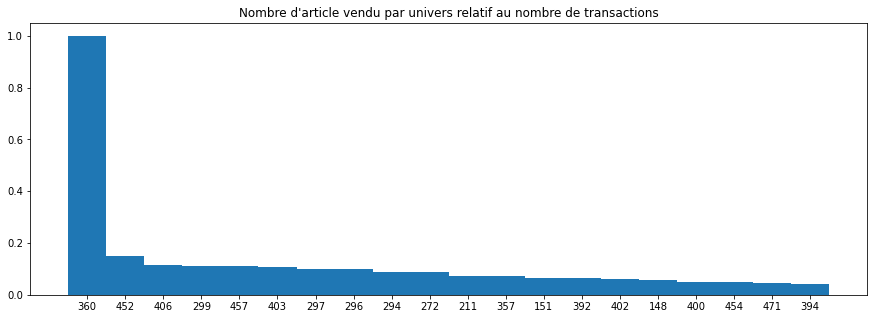

("Proportion d'achat (%)", 2.13)
('Proportion achat seul (%)', 8.64)
("Nombre moyen d'univ", 1.17)
('CA univ', 519375.77)
('CA moyen univ', 6.43)
('Nombre moyen article en plus', 4.75)
('CA en plus', 1339730.8)
('CA moyen en plus', 16.6)
==============361===================
16988
Time Taken to load recurence: ~0secondes


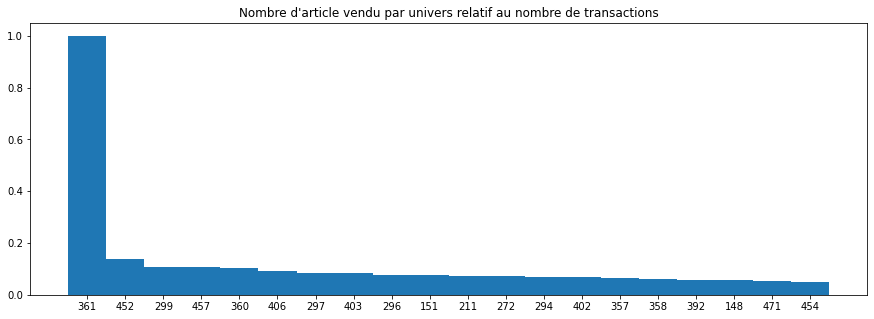

("Proportion d'achat (%)", 0.45)
('Proportion achat seul (%)', 10.28)
("Nombre moyen d'univ", 1.1)
('CA univ', 118744.59)
('CA moyen univ', 6.99)
('Nombre moyen article en plus', 4.65)
('CA en plus', 278318.06)
('CA moyen en plus', 16.38)
==============362===================
8528
Time Taken to load recurence: ~0secondes


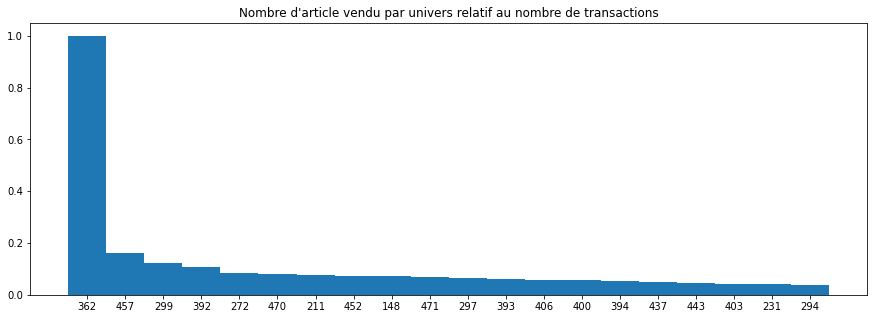

("Proportion d'achat (%)", 0.22)
('Proportion achat seul (%)', 12.65)
("Nombre moyen d'univ", 1.19)
('CA univ', 42880.96)
('CA moyen univ', 5.03)
('Nombre moyen article en plus', 3.52)
('CA en plus', 88770.42)
('CA moyen en plus', 10.41)
==============363===================
4111
Time Taken to load recurence: ~0secondes


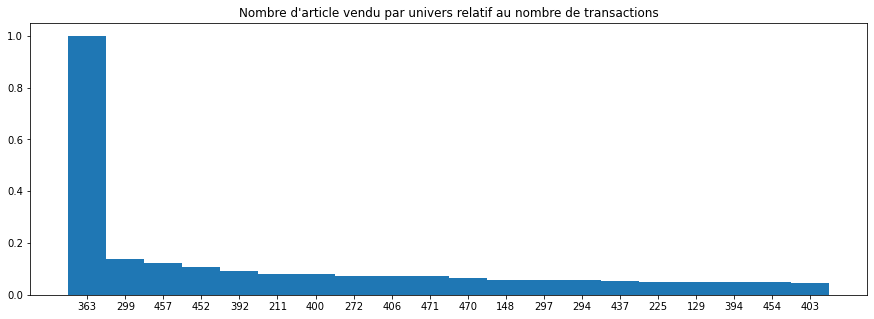

("Proportion d'achat (%)", 0.11)
('Proportion achat seul (%)', 11.34)
("Nombre moyen d'univ", 1.1)
('CA univ', 19836.94)
('CA moyen univ', 4.83)
('Nombre moyen article en plus', 3.97)
('CA en plus', 51754.81)
('CA moyen en plus', 12.59)
==============366===================
2488
Time Taken to load recurence: ~0secondes


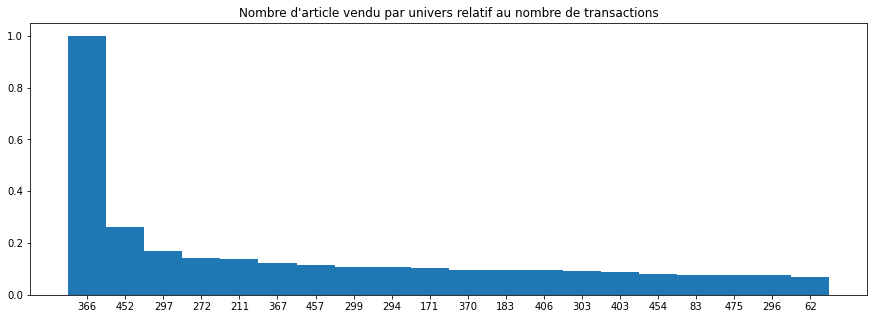

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 7.6)
("Nombre moyen d'univ", 1.07)
('CA univ', 33026.91)
('CA moyen univ', 13.27)
('Nombre moyen article en plus', 8.65)
('CA en plus', 81867.51)
('CA moyen en plus', 32.9)
==============367===================
1328
Time Taken to load recurence: ~0secondes


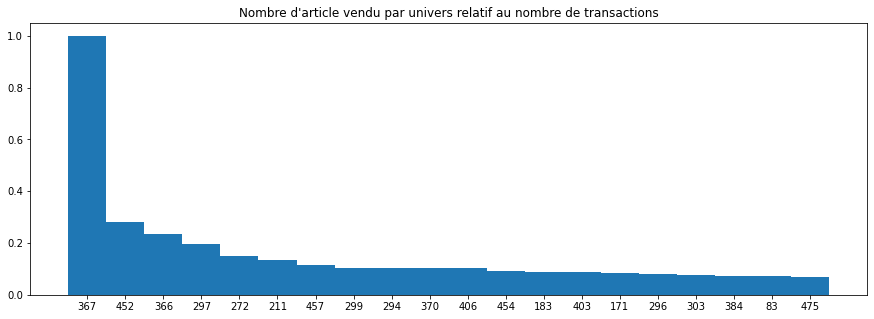

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 7.0)
("Nombre moyen d'univ", 1.04)
('CA univ', 8881.99)
('CA moyen univ', 6.69)
('Nombre moyen article en plus', 8.96)
('CA en plus', 46900.95)
('CA moyen en plus', 35.32)
==============368===================
143
Time Taken to load recurence: ~0secondes


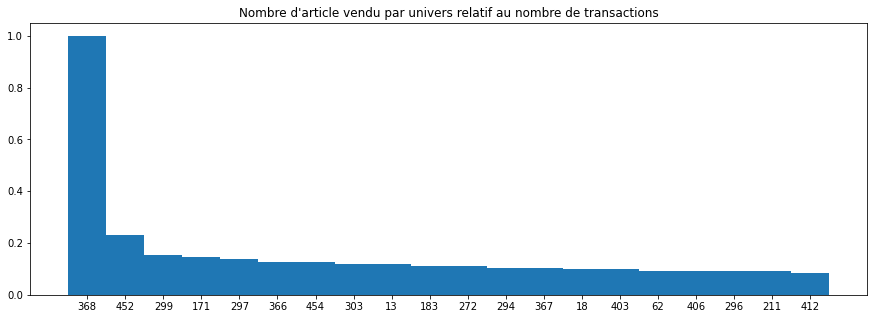

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 4.2)
("Nombre moyen d'univ", 1.01)
('CA univ', 1132.32)
('CA moyen univ', 7.92)
('Nombre moyen article en plus', 10.68)
('CA en plus', 5975.86)
('CA moyen en plus', 41.79)
==============369===================
6214
Time Taken to load recurence: ~0secondes


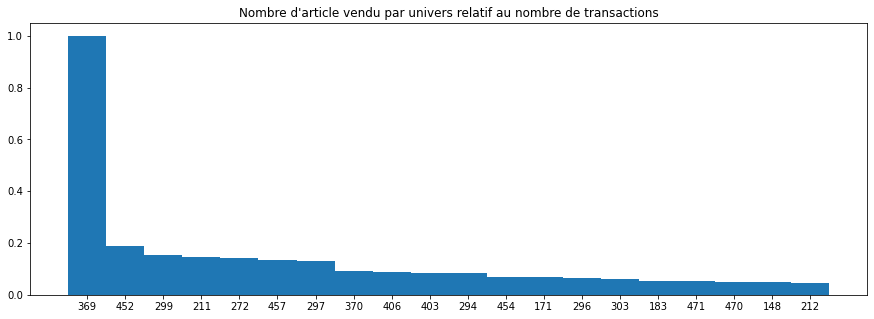

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 8.14)
("Nombre moyen d'univ", 1.23)
('CA univ', 14447.81)
('CA moyen univ', 2.33)
('Nombre moyen article en plus', 6.88)
('CA en plus', 149288.12)
('CA moyen en plus', 24.02)
==============370===================
16686
Time Taken to load recurence: ~0secondes


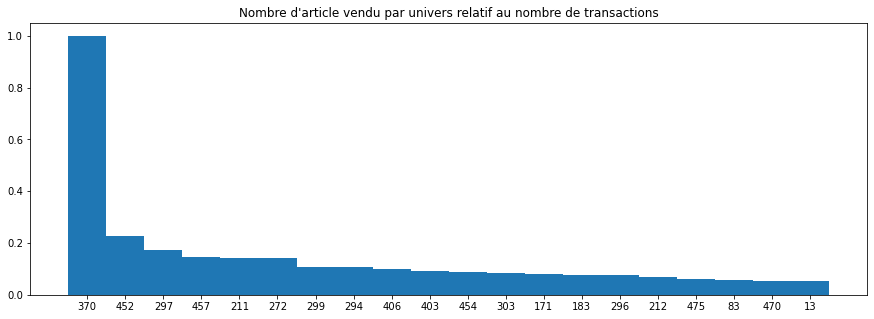

("Proportion d'achat (%)", 0.44)
('Proportion achat seul (%)', 6.74)
("Nombre moyen d'univ", 1.17)
('CA univ', 69181.24)
('CA moyen univ', 4.15)
('Nombre moyen article en plus', 7.68)
('CA en plus', 464760.65)
('CA moyen en plus', 27.85)
==============372===================
1611
Time Taken to load recurence: ~0secondes


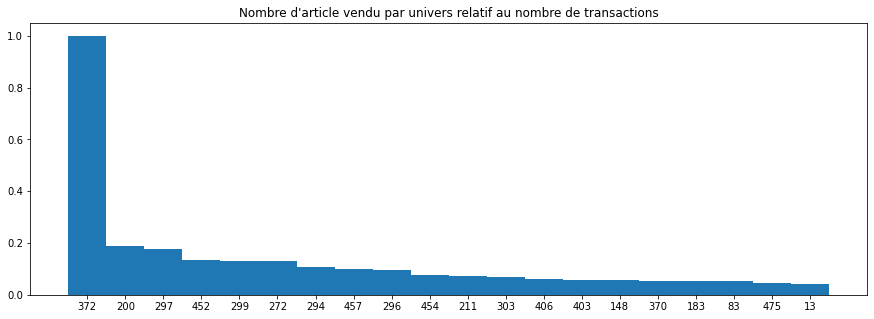

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 9.44)
("Nombre moyen d'univ", 1.1)
('CA univ', 3474.44)
('CA moyen univ', 2.16)
('Nombre moyen article en plus', 6.21)
('CA en plus', 35504.2)
('CA moyen en plus', 22.04)
==============373===================
1759
Time Taken to load recurence: ~0secondes


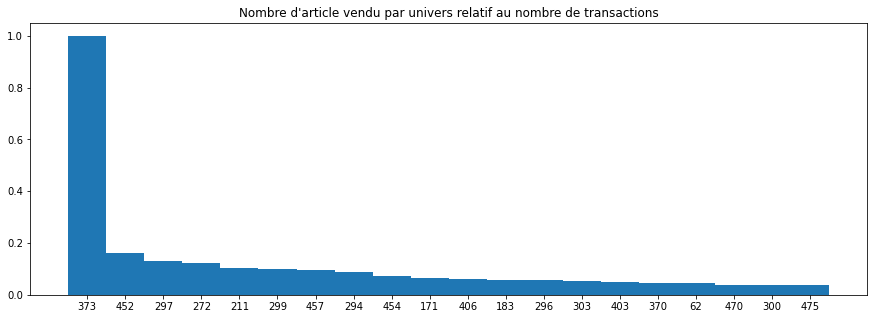

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 16.03)
("Nombre moyen d'univ", 1.08)
('CA univ', 19158.69)
('CA moyen univ', 10.89)
('Nombre moyen article en plus', 5.18)
('CA en plus', 30847.15)
('CA moyen en plus', 17.54)
==============374===================
862
Time Taken to load recurence: ~0secondes


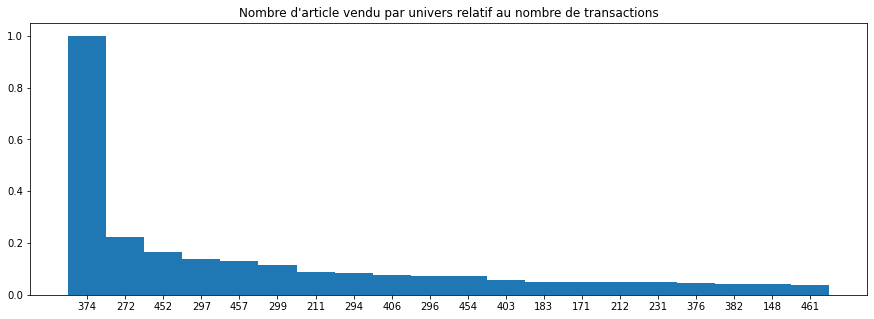

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 11.95)
("Nombre moyen d'univ", 1.03)
('CA univ', 5331.29)
('CA moyen univ', 6.18)
('Nombre moyen article en plus', 5.96)
('CA en plus', 18826.05)
('CA moyen en plus', 21.84)
==============375===================
4545
Time Taken to load recurence: ~0secondes


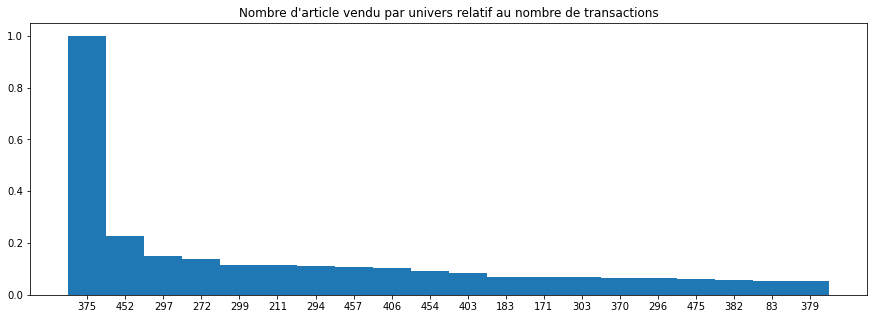

("Proportion d'achat (%)", 0.12)
('Proportion achat seul (%)', 7.37)
("Nombre moyen d'univ", 1.17)
('CA univ', 21933.99)
('CA moyen univ', 4.83)
('Nombre moyen article en plus', 7.41)
('CA en plus', 123586.3)
('CA moyen en plus', 27.19)
==============376===================
2837
Time Taken to load recurence: ~0secondes


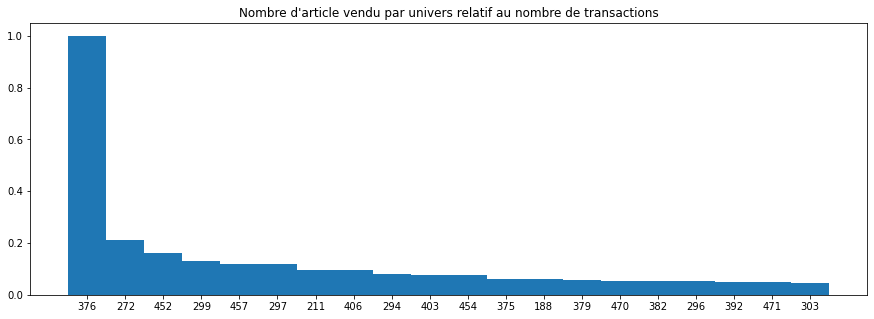

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 7.54)
("Nombre moyen d'univ", 1.06)
('CA univ', 13115.12)
('CA moyen univ', 4.62)
('Nombre moyen article en plus', 6.45)
('CA en plus', 68731.59)
('CA moyen en plus', 24.23)
==============377===================
6986
Time Taken to load recurence: ~0secondes


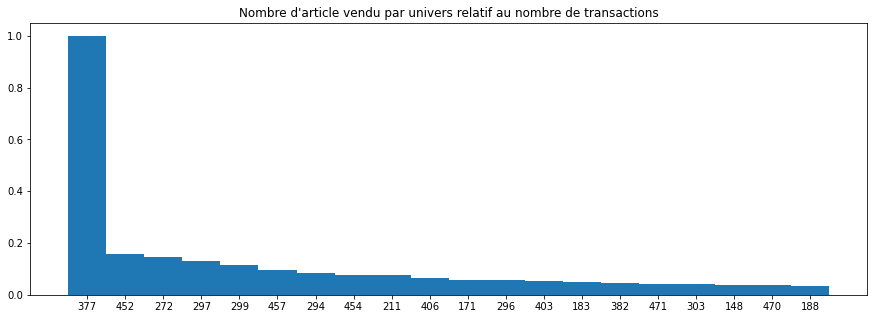

("Proportion d'achat (%)", 0.18)
('Proportion achat seul (%)', 14.1)
("Nombre moyen d'univ", 1.11)
('CA univ', 34128.53)
('CA moyen univ', 4.89)
('Nombre moyen article en plus', 5.34)
('CA en plus', 130089.13)
('CA moyen en plus', 18.62)
==============378===================
1130
Time Taken to load recurence: ~0secondes


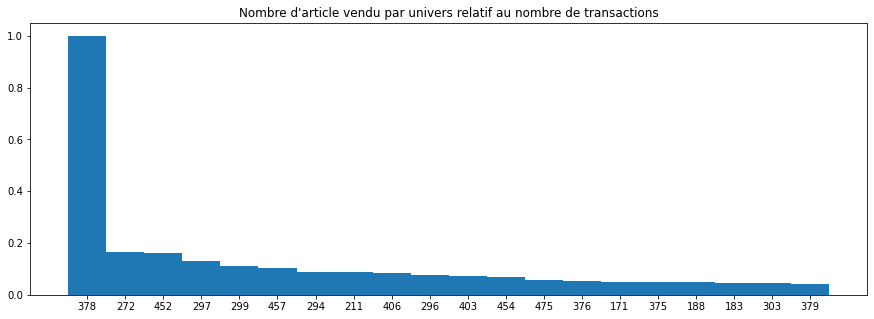

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 12.04)
("Nombre moyen d'univ", 1.08)
('CA univ', 7814.83)
('CA moyen univ', 6.92)
('Nombre moyen article en plus', 5.89)
('CA en plus', 24970.73)
('CA moyen en plus', 22.1)
==============379===================
2796
Time Taken to load recurence: ~0secondes


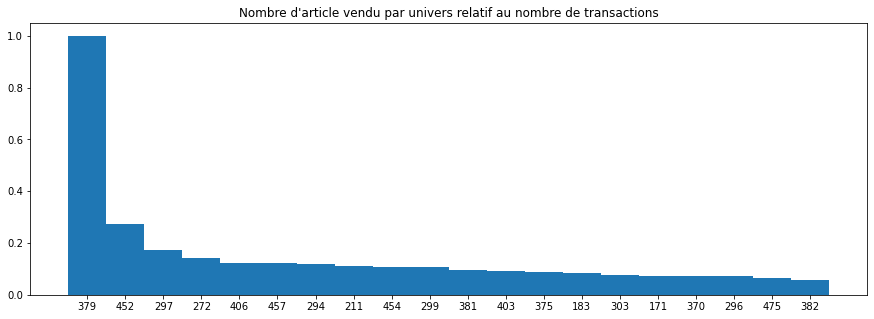

("Proportion d'achat (%)", 0.07)
('Proportion achat seul (%)', 4.43)
("Nombre moyen d'univ", 1.09)
('CA univ', 13793.76)
('CA moyen univ', 4.93)
('Nombre moyen article en plus', 8.46)
('CA en plus', 70620.62)
('CA moyen en plus', 25.26)
==============380===================
1681
Time Taken to load recurence: ~0secondes


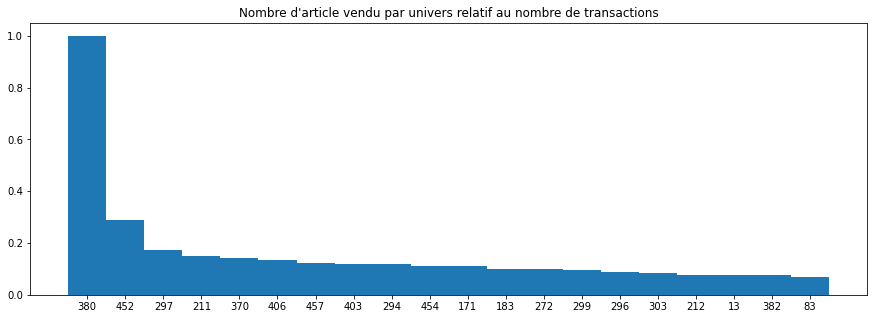

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 2.8)
("Nombre moyen d'univ", 1.12)
('CA univ', 7590.01)
('CA moyen univ', 4.52)
('Nombre moyen article en plus', 9.65)
('CA en plus', 61186.92)
('CA moyen en plus', 36.4)
==============381===================
1626
Time Taken to load recurence: ~0secondes


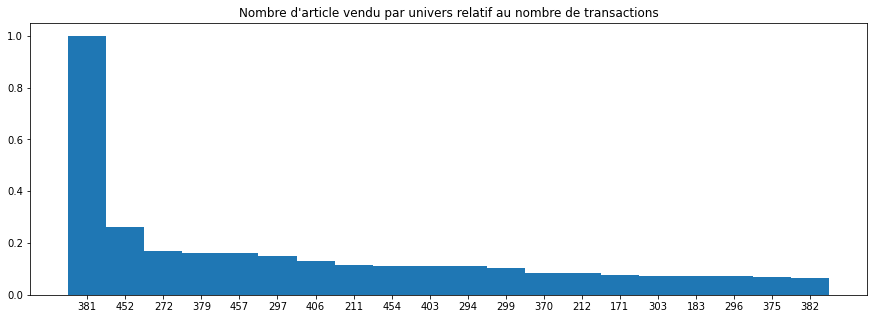

("Proportion d'achat (%)", 0.04)
('Proportion achat seul (%)', 4.8)
("Nombre moyen d'univ", 1.13)
('CA univ', 7650.17)
('CA moyen univ', 4.7)
('Nombre moyen article en plus', 8.84)
('CA en plus', 52574.04)
('CA moyen en plus', 32.33)
==============382===================
5237
Time Taken to load recurence: ~0secondes


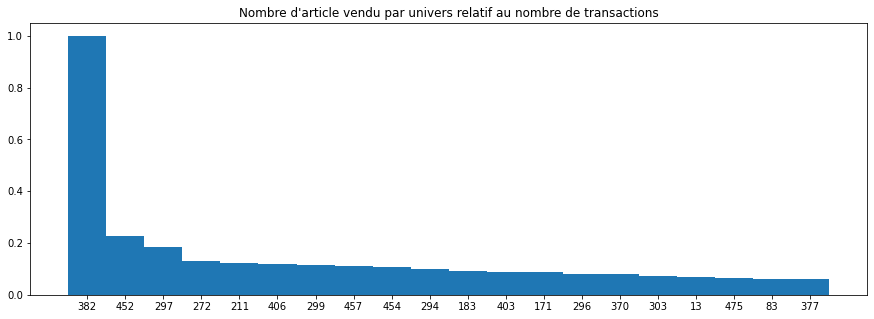

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 4.81)
("Nombre moyen d'univ", 1.1)
('CA univ', 20885.56)
('CA moyen univ', 3.99)
('Nombre moyen article en plus', 8.72)
('CA en plus', 165835.39)
('CA moyen en plus', 31.67)
==============384===================
5840
Time Taken to load recurence: ~0secondes


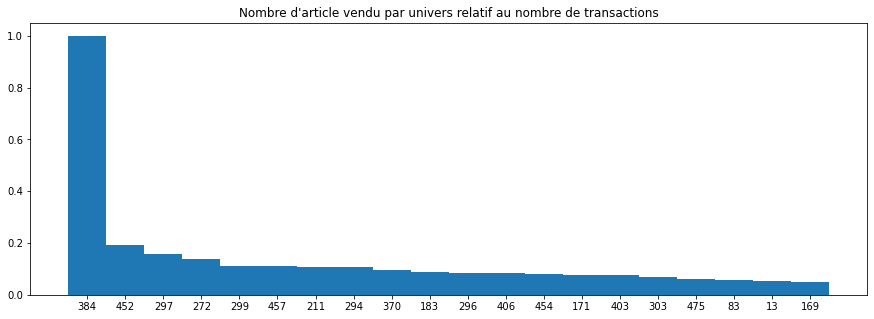

("Proportion d'achat (%)", 0.15)
('Proportion achat seul (%)', 9.49)
("Nombre moyen d'univ", 1.21)
('CA univ', 26516.9)
('CA moyen univ', 4.54)
('Nombre moyen article en plus', 7.63)
('CA en plus', 163024.29)
('CA moyen en plus', 27.92)
==============386===================
9133
Time Taken to load recurence: ~0secondes


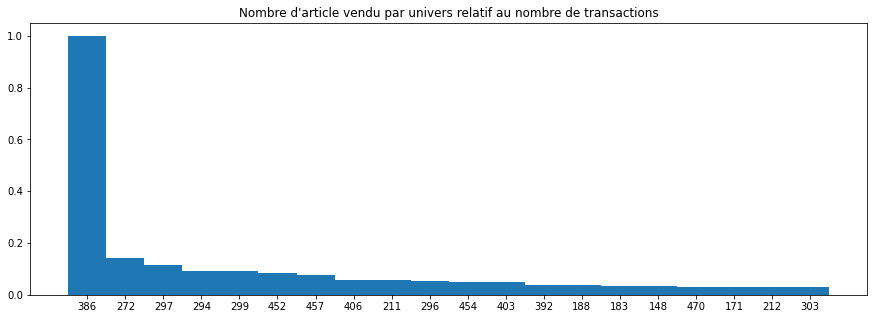

("Proportion d'achat (%)", 0.24)
('Proportion achat seul (%)', 22.88)
("Nombre moyen d'univ", 1.22)
('CA univ', 116852.16)
('CA moyen univ', 12.79)
('Nombre moyen article en plus', 4.01)
('CA en plus', 134156.36)
('CA moyen en plus', 14.69)
==============387===================
3156
Time Taken to load recurence: ~0secondes


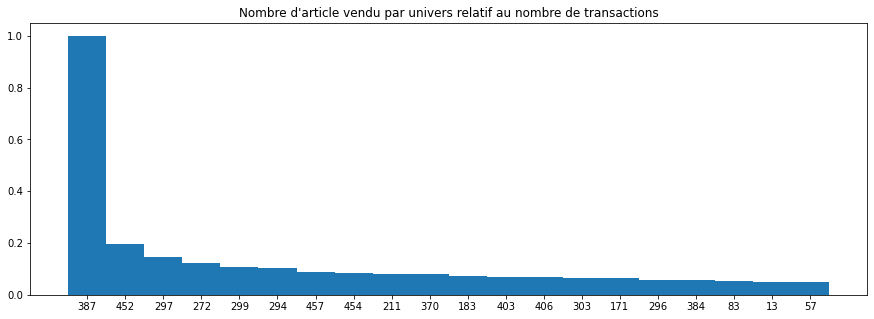

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 10.99)
("Nombre moyen d'univ", 1.06)
('CA univ', 29349.68)
('CA moyen univ', 9.3)
('Nombre moyen article en plus', 7.19)
('CA en plus', 83076.23)
('CA moyen en plus', 26.32)
==============390===================
171
Time Taken to load recurence: ~0secondes


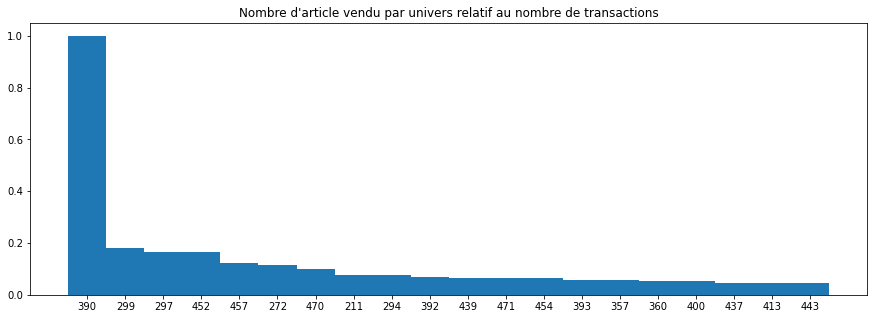

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 4.09)
("Nombre moyen d'univ", 1.12)
('CA univ', 743.76)
('CA moyen univ', 4.35)
('Nombre moyen article en plus', 4.54)
('CA en plus', 2476.73)
('CA moyen en plus', 14.48)
==============391===================
1902
Time Taken to load recurence: ~0secondes


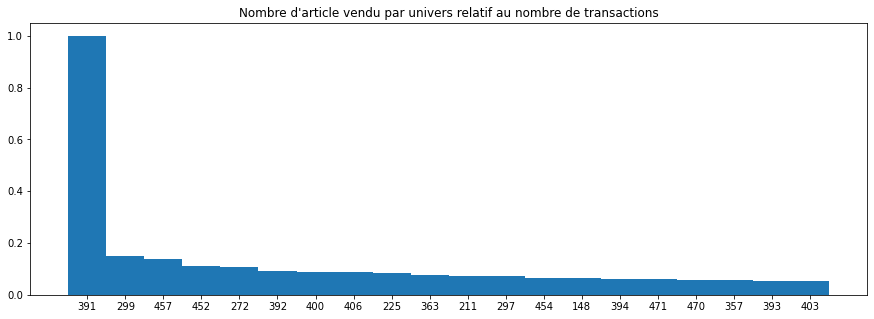

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 8.25)
("Nombre moyen d'univ", 1.08)
('CA univ', 9687.98)
('CA moyen univ', 5.09)
('Nombre moyen article en plus', 4.92)
('CA en plus', 31972.92)
('CA moyen en plus', 16.81)
==============392===================
257538
Time Taken to load recurence: ~0secondes


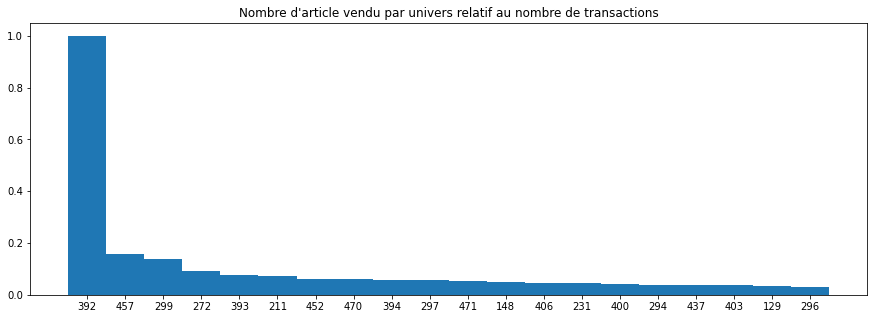

("Proportion d'achat (%)", 6.78)
('Proportion achat seul (%)', 19.2)
("Nombre moyen d'univ", 1.23)
('CA univ', 1026884.97)
('CA moyen univ', 3.99)
('Nombre moyen article en plus', 2.98)
('CA en plus', 2366814.15)
('CA moyen en plus', 9.19)
==============393===================
122473
Time Taken to load recurence: ~0secondes


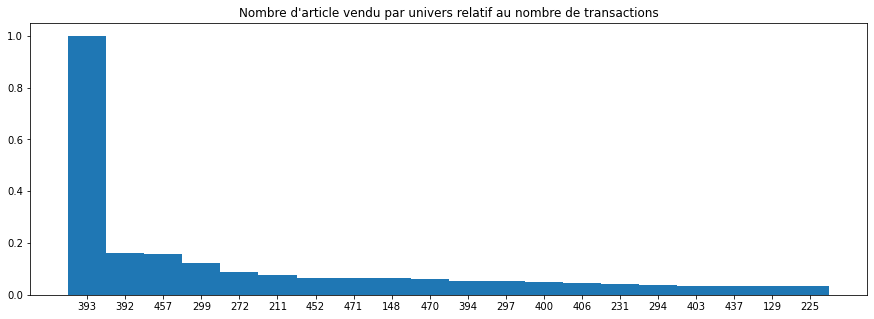

("Proportion d'achat (%)", 3.23)
('Proportion achat seul (%)', 16.39)
("Nombre moyen d'univ", 1.14)
('CA univ', 589220.62)
('CA moyen univ', 4.81)
('Nombre moyen article en plus', 3.14)
('CA en plus', 1146713.52)
('CA moyen en plus', 9.36)
==============394===================
117935
Time Taken to load recurence: ~0secondes


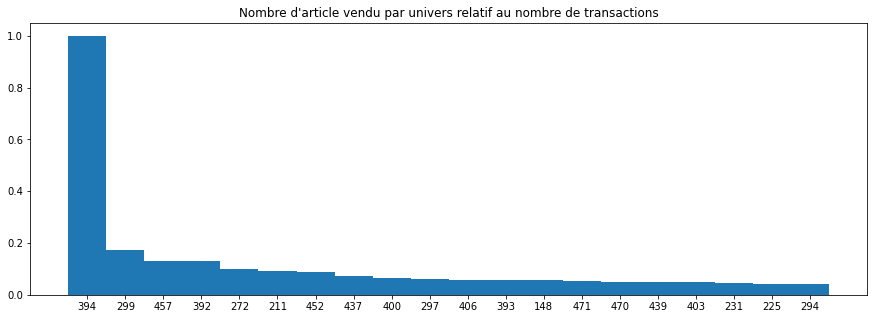

("Proportion d'achat (%)", 3.11)
('Proportion achat seul (%)', 9.93)
("Nombre moyen d'univ", 1.49)
('CA univ', 317286.84)
('CA moyen univ', 2.69)
('Nombre moyen article en plus', 3.67)
('CA en plus', 1345286.3)
('CA moyen en plus', 11.41)
==============395===================
845
Time Taken to load recurence: ~0secondes


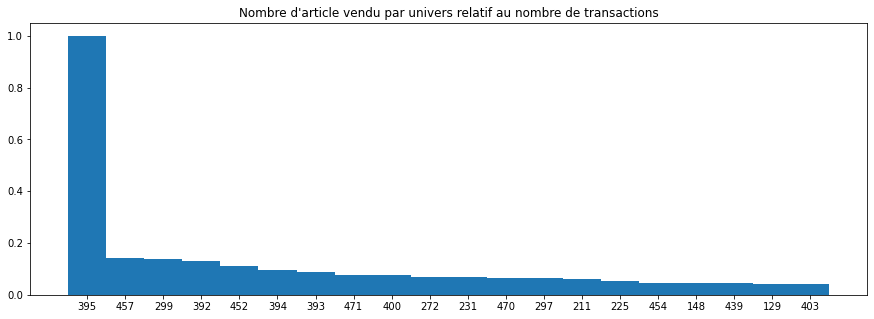

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 12.43)
("Nombre moyen d'univ", 1.08)
('CA univ', 3332.48)
('CA moyen univ', 3.94)
('Nombre moyen article en plus', 3.49)
('CA en plus', 8417.2)
('CA moyen en plus', 9.96)
==============396===================
40285
Time Taken to load recurence: ~0secondes


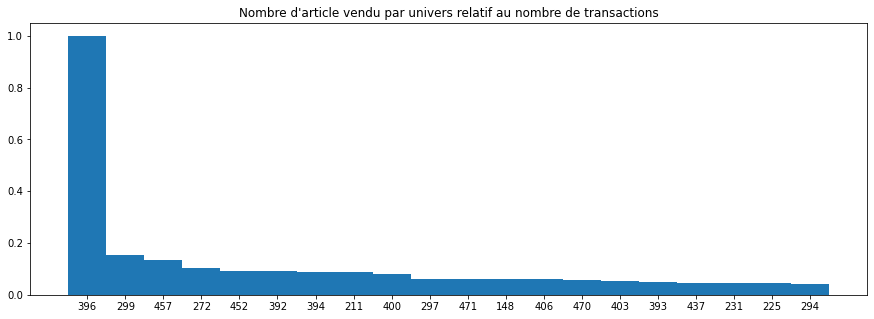

("Proportion d'achat (%)", 1.06)
('Proportion achat seul (%)', 11.13)
("Nombre moyen d'univ", 1.17)
('CA univ', 132878.03)
('CA moyen univ', 3.3)
('Nombre moyen article en plus', 3.74)
('CA en plus', 479465.5)
('CA moyen en plus', 11.9)
==============397===================
2237
Time Taken to load recurence: ~0secondes


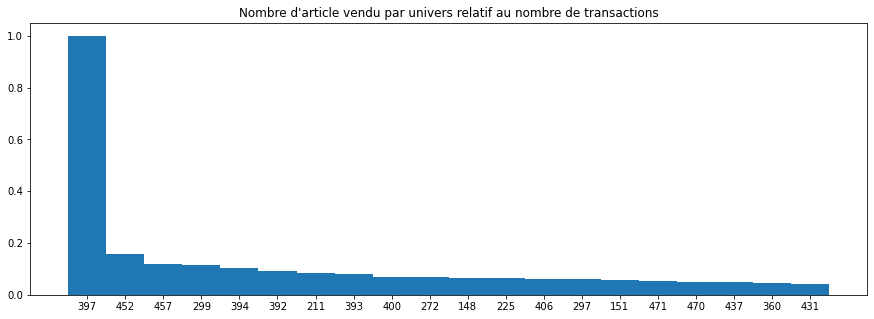

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 9.03)
("Nombre moyen d'univ", 1.19)
('CA univ', 9325.86)
('CA moyen univ', 4.17)
('Nombre moyen article en plus', 3.84)
('CA en plus', 24716.26)
('CA moyen en plus', 11.05)
==============400===================
115094
Time Taken to load recurence: ~0secondes


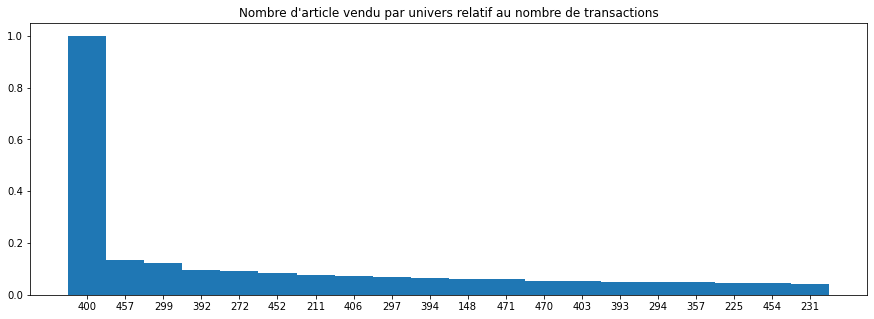

("Proportion d'achat (%)", 3.03)
('Proportion achat seul (%)', 11.99)
("Nombre moyen d'univ", 1.19)
('CA univ', 519978.19)
('CA moyen univ', 4.52)
('Nombre moyen article en plus', 3.68)
('CA en plus', 1388237.65)
('CA moyen en plus', 12.06)
==============402===================
131821
Time Taken to load recurence: ~0secondes


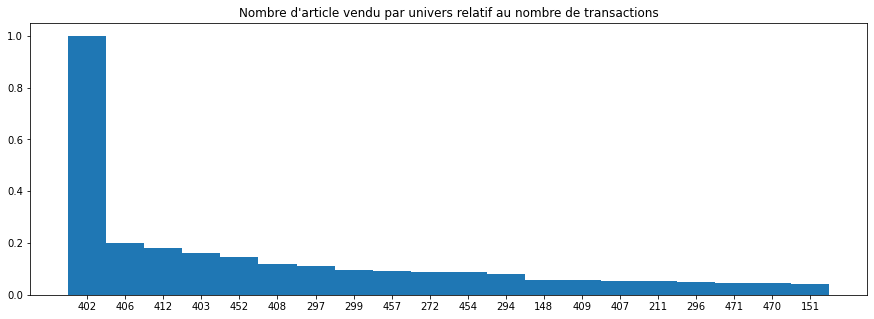

("Proportion d'achat (%)", 3.47)
('Proportion achat seul (%)', 6.85)
("Nombre moyen d'univ", 1.28)
('CA univ', 1049695.51)
('CA moyen univ', 7.96)
('Nombre moyen article en plus', 5.34)
('CA en plus', 2860738.0)
('CA moyen en plus', 21.7)
==============403===================
235822
Time Taken to load recurence: ~0secondes


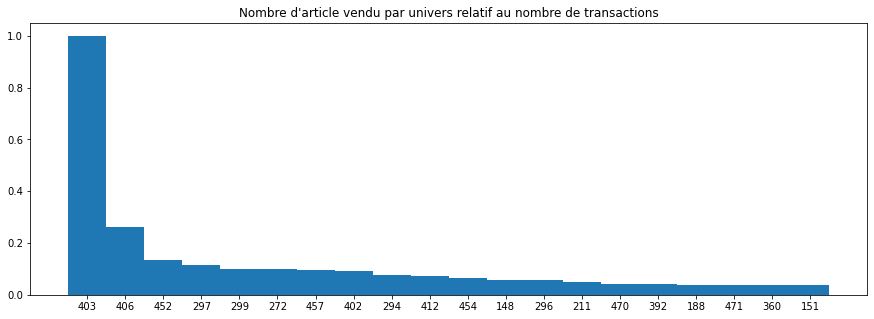

("Proportion d'achat (%)", 6.21)
('Proportion achat seul (%)', 10.57)
("Nombre moyen d'univ", 1.48)
('CA univ', 2420809.68)
('CA moyen univ', 10.27)
('Nombre moyen article en plus', 4.8)
('CA en plus', 4456623.44)
('CA moyen en plus', 18.9)
==============404===================
24371
Time Taken to load recurence: ~0secondes


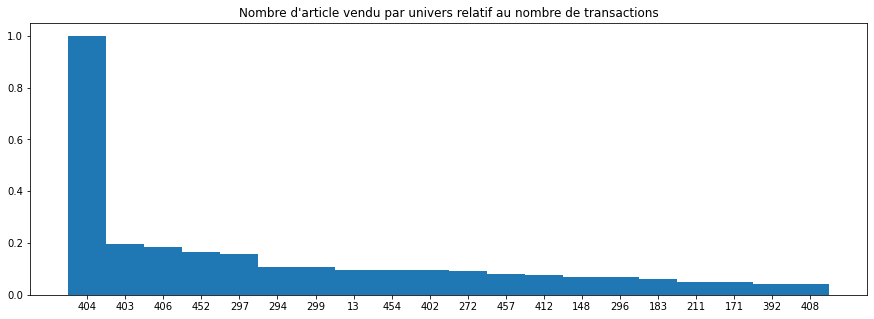

("Proportion d'achat (%)", 0.64)
('Proportion achat seul (%)', 5.12)
("Nombre moyen d'univ", 1.37)
('CA univ', 252693.86)
('CA moyen univ', 10.37)
('Nombre moyen article en plus', 6.4)
('CA en plus', 617986.18)
('CA moyen en plus', 25.36)
==============405===================
27238
Time Taken to load recurence: ~0secondes


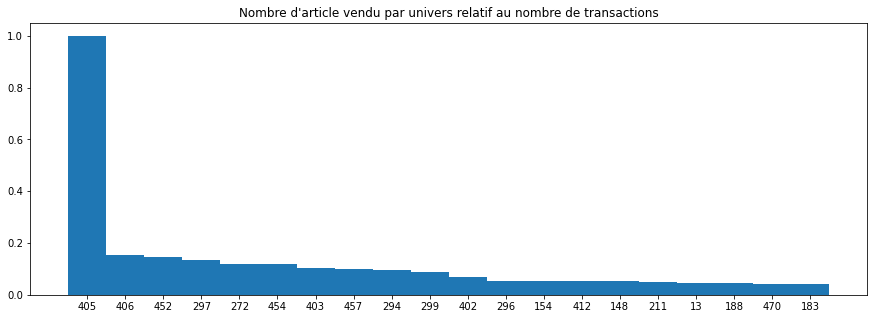

("Proportion d'achat (%)", 0.72)
('Proportion achat seul (%)', 9.5)
("Nombre moyen d'univ", 1.41)
('CA univ', 263707.71)
('CA moyen univ', 9.68)
('Nombre moyen article en plus', 5.33)
('CA en plus', 560670.3)
('CA moyen en plus', 20.58)
==============406===================
295268
Time Taken to load recurence: ~0secondes


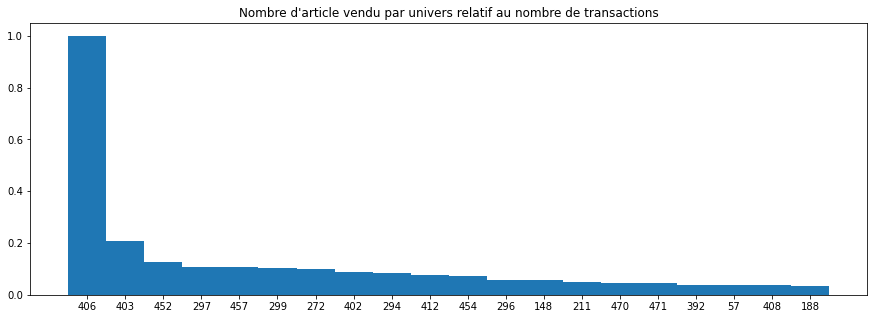

("Proportion d'achat (%)", 7.78)
('Proportion achat seul (%)', 10.77)
("Nombre moyen d'univ", 1.45)
('CA univ', 2778075.59)
('CA moyen univ', 9.41)
('Nombre moyen article en plus', 4.54)
('CA en plus', 5169797.02)
('CA moyen en plus', 17.51)
==============407===================
36141
Time Taken to load recurence: ~0secondes


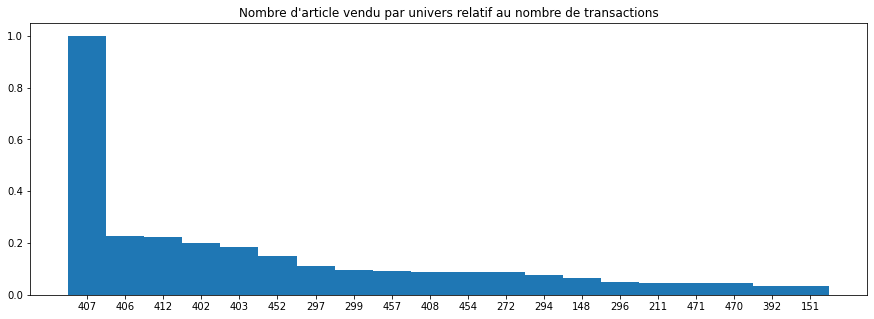

("Proportion d'achat (%)", 0.95)
('Proportion achat seul (%)', 6.73)
("Nombre moyen d'univ", 1.2)
('CA univ', 290057.85)
('CA moyen univ', 8.03)
('Nombre moyen article en plus', 5.5)
('CA en plus', 817928.01)
('CA moyen en plus', 22.63)
==============408===================
45827
Time Taken to load recurence: ~0secondes


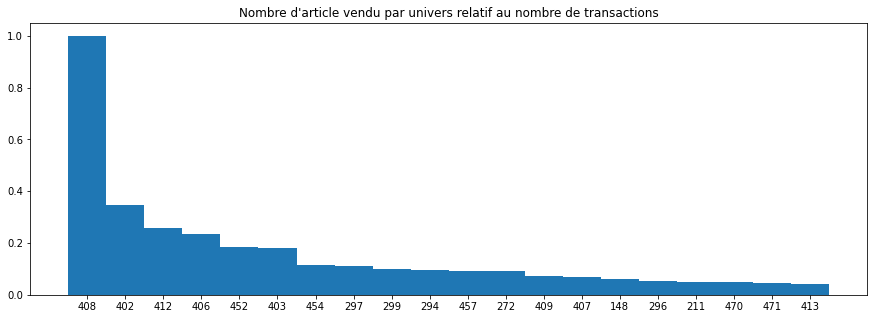

("Proportion d'achat (%)", 1.21)
('Proportion achat seul (%)', 2.05)
("Nombre moyen d'univ", 1.2)
('CA univ', 340749.02)
('CA moyen univ', 7.44)
('Nombre moyen article en plus', 6.42)
('CA en plus', 1271972.64)
('CA moyen en plus', 27.76)
==============409===================
44259
Time Taken to load recurence: ~0secondes


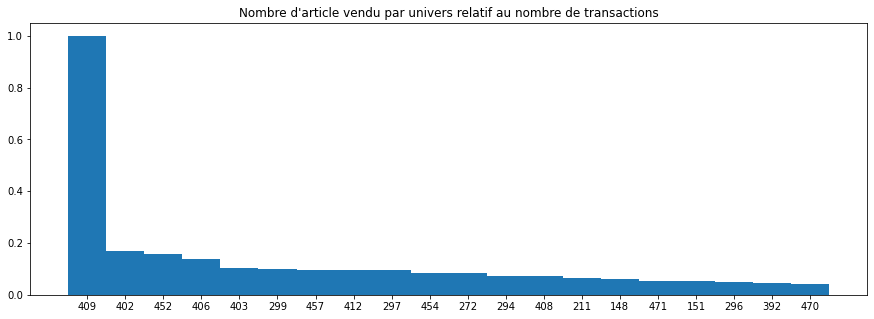

("Proportion d'achat (%)", 1.17)
('Proportion achat seul (%)', 7.92)
("Nombre moyen d'univ", 1.3)
('CA univ', 574688.59)
('CA moyen univ', 12.98)
('Nombre moyen article en plus', 5.22)
('CA en plus', 898804.94)
('CA moyen en plus', 20.31)
==============410===================
6542
Time Taken to load recurence: ~0secondes


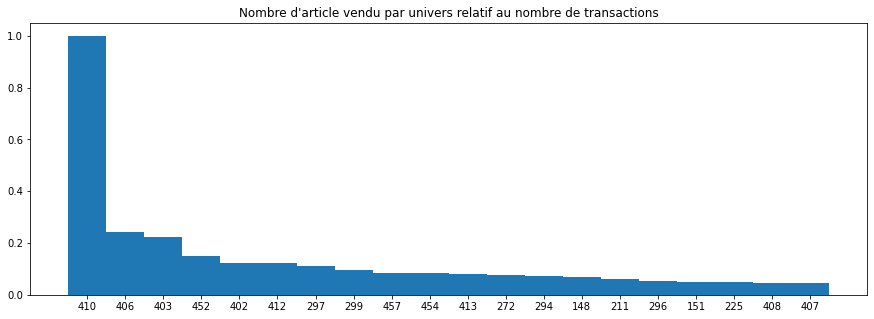

("Proportion d'achat (%)", 0.17)
('Proportion achat seul (%)', 6.07)
("Nombre moyen d'univ", 1.11)
('CA univ', 48639.11)
('CA moyen univ', 7.43)
('Nombre moyen article en plus', 5.51)
('CA en plus', 127131.16)
('CA moyen en plus', 19.43)
==============411===================
3580
Time Taken to load recurence: ~0secondes


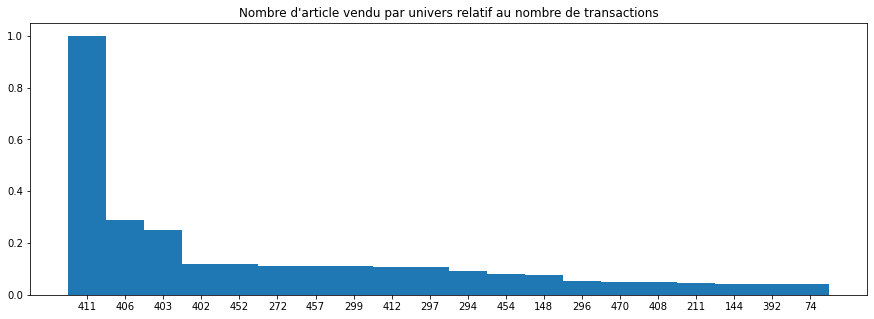

("Proportion d'achat (%)", 0.09)
('Proportion achat seul (%)', 6.03)
("Nombre moyen d'univ", 1.18)
('CA univ', 37827.15)
('CA moyen univ', 10.57)
('Nombre moyen article en plus', 5.73)
('CA en plus', 88885.1)
('CA moyen en plus', 24.83)
==============412===================
102802
Time Taken to load recurence: ~0secondes


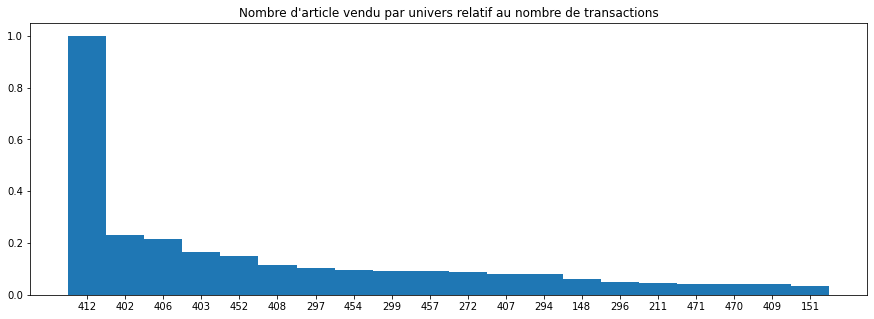

("Proportion d'achat (%)", 2.71)
('Proportion achat seul (%)', 7.04)
("Nombre moyen d'univ", 1.32)
('CA univ', 934291.31)
('CA moyen univ', 9.09)
('Nombre moyen article en plus', 5.27)
('CA en plus', 2403816.78)
('CA moyen en plus', 23.38)
==============413===================
39026
Time Taken to load recurence: ~0secondes


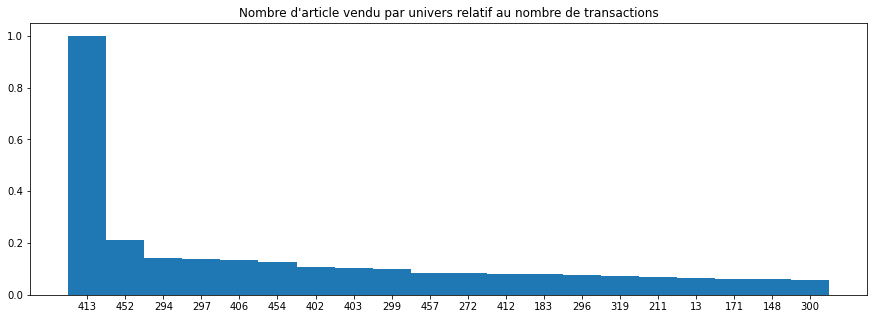

("Proportion d'achat (%)", 1.03)
('Proportion achat seul (%)', 2.73)
("Nombre moyen d'univ", 1.45)
('CA univ', 273839.72)
('CA moyen univ', 7.02)
('Nombre moyen article en plus', 6.77)
('CA en plus', 994770.37)
('CA moyen en plus', 25.49)
==============416===================
18496
Time Taken to load recurence: ~0secondes


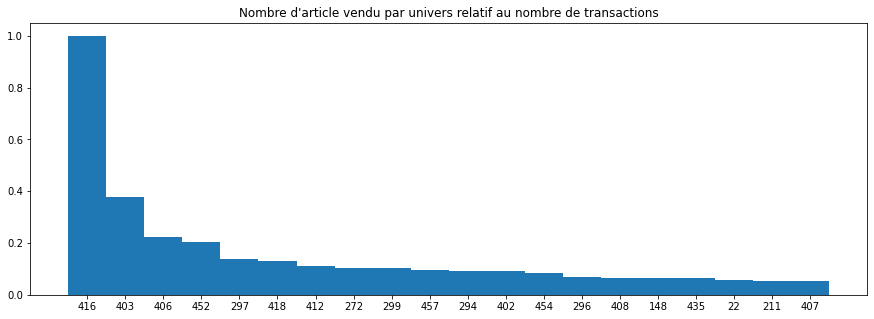

("Proportion d'achat (%)", 0.49)
('Proportion achat seul (%)', 2.97)
("Nombre moyen d'univ", 1.18)
('CA univ', 96034.57)
('CA moyen univ', 5.19)
('Nombre moyen article en plus', 6.94)
('CA en plus', 536569.33)
('CA moyen en plus', 29.01)
==============417===================
3155
Time Taken to load recurence: ~0secondes


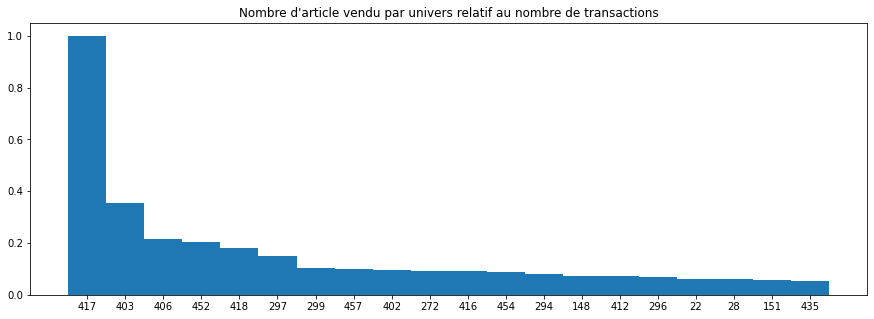

("Proportion d'achat (%)", 0.08)
('Proportion achat seul (%)', 3.11)
("Nombre moyen d'univ", 1.14)
('CA univ', 17613.92)
('CA moyen univ', 5.58)
('Nombre moyen article en plus', 6.96)
('CA en plus', 90164.0)
('CA moyen en plus', 28.58)
==============418===================
20519
Time Taken to load recurence: ~0secondes


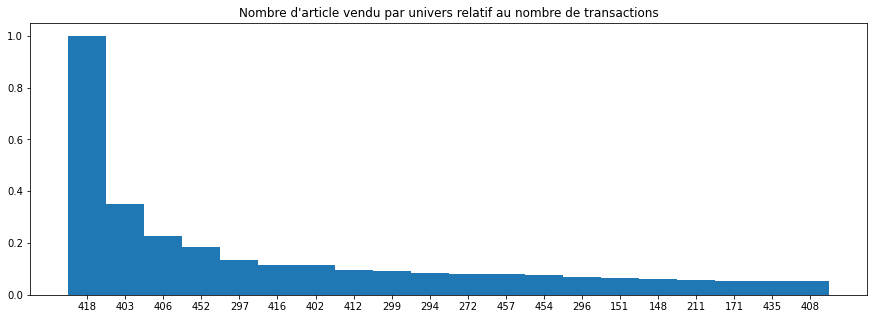

("Proportion d'achat (%)", 0.54)
('Proportion achat seul (%)', 2.77)
("Nombre moyen d'univ", 1.21)
('CA univ', 122968.13)
('CA moyen univ', 5.99)
('Nombre moyen article en plus', 6.65)
('CA en plus', 570137.3)
('CA moyen en plus', 27.79)
==============419===================
6417
Time Taken to load recurence: ~0secondes


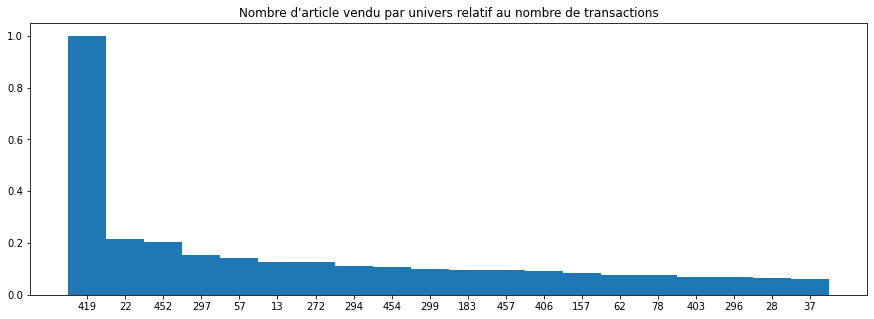

("Proportion d'achat (%)", 0.17)
('Proportion achat seul (%)', 4.36)
("Nombre moyen d'univ", 1.3)
('CA univ', 21355.93)
('CA moyen univ', 3.33)
('Nombre moyen article en plus', 7.58)
('CA en plus', 185400.2)
('CA moyen en plus', 28.89)
==============420===================
889
Time Taken to load recurence: ~0secondes


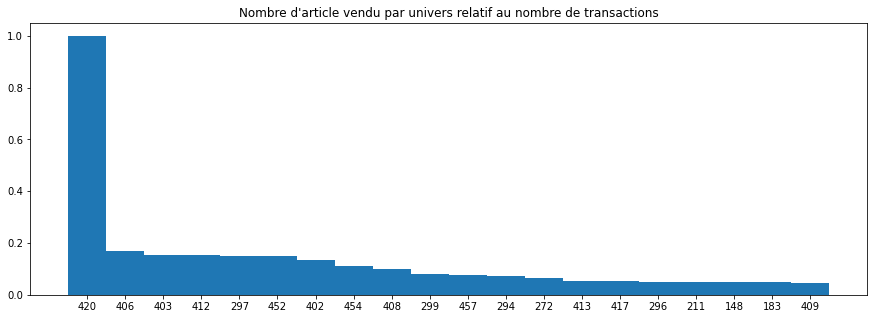

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 5.96)
("Nombre moyen d'univ", 1.15)
('CA univ', 10584.61)
('CA moyen univ', 11.91)
('Nombre moyen article en plus', 5.91)
('CA en plus', 21243.93)
('CA moyen en plus', 23.9)
==============421===================
442
Time Taken to load recurence: ~0secondes


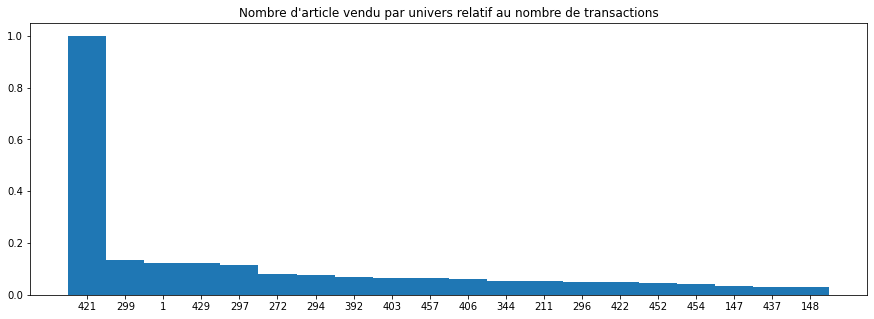

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 18.78)
("Nombre moyen d'univ", 1.91)
('CA univ', 30071.26)
('CA moyen univ', 68.03)
('Nombre moyen article en plus', 10.27)
('CA en plus', 15833.71)
('CA moyen en plus', 35.82)
==============422===================
102
Time Taken to load recurence: ~0secondes


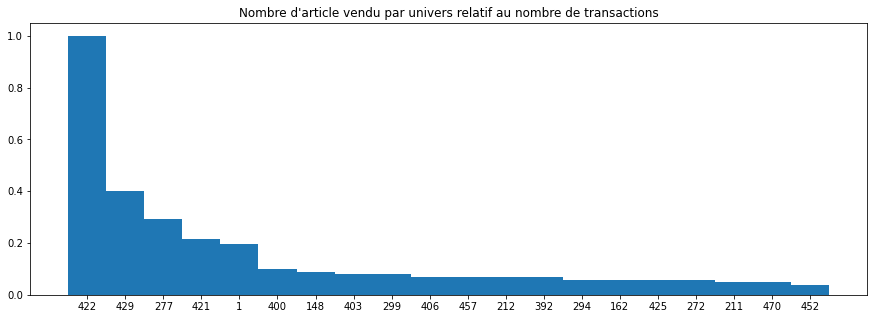

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 1.96)
("Nombre moyen d'univ", 1.25)
('CA univ', 1896.35)
('CA moyen univ', 18.59)
('Nombre moyen article en plus', 5.03)
('CA en plus', 8490.21)
('CA moyen en plus', 83.24)
==============425===================
NOT ENOUGH DATA 
==============429===================
1312
Time Taken to load recurence: ~0secondes


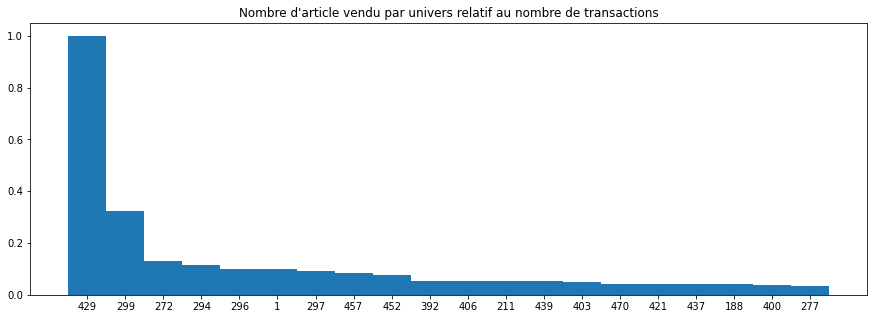

("Proportion d'achat (%)", 0.03)
('Proportion achat seul (%)', 10.98)
("Nombre moyen d'univ", 1.99)
('CA univ', 38125.7)
('CA moyen univ', 29.06)
('Nombre moyen article en plus', 4.87)
('CA en plus', 32498.92)
('CA moyen en plus', 24.77)
==============430===================
116
Time Taken to load recurence: ~0secondes


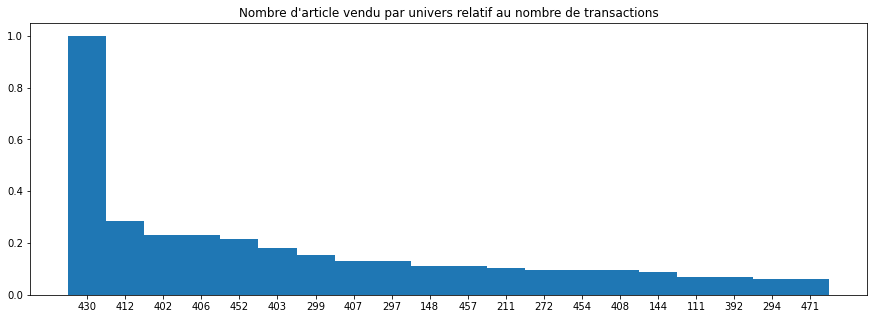

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 1.72)
("Nombre moyen d'univ", 1.09)
('CA univ', 859.65)
('CA moyen univ', 7.41)
('Nombre moyen article en plus', 6.47)
('CA en plus', 3034.25)
('CA moyen en plus', 26.16)
==============431===================
33787
Time Taken to load recurence: ~0secondes


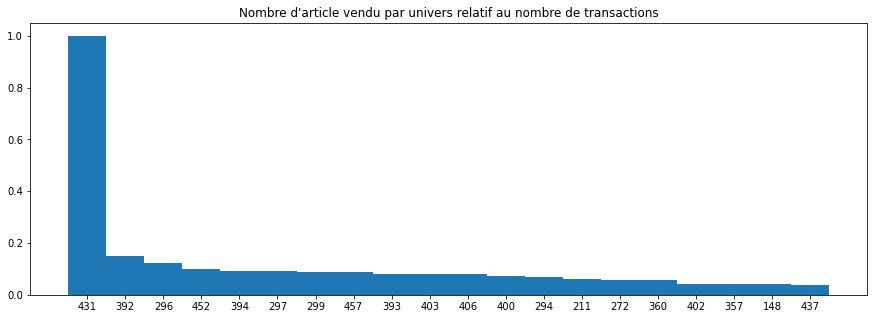

("Proportion d'achat (%)", 0.89)
('Proportion achat seul (%)', 6.64)
("Nombre moyen d'univ", 1.13)
('CA univ', 104244.05)
('CA moyen univ', 3.09)
('Nombre moyen article en plus', 3.74)
('CA en plus', 409137.11)
('CA moyen en plus', 12.11)
==============432===================
15931
Time Taken to load recurence: ~0secondes


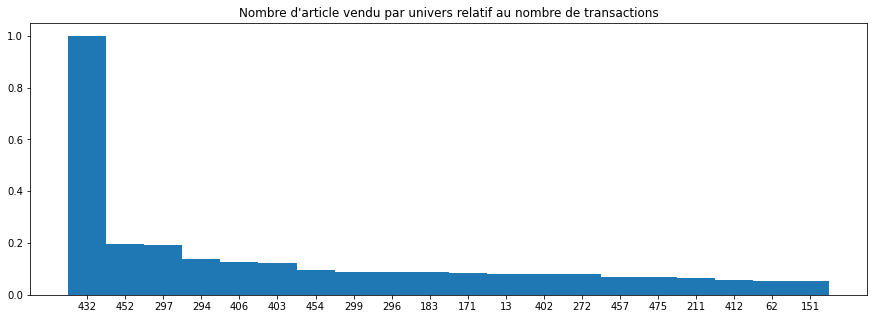

("Proportion d'achat (%)", 0.42)
('Proportion achat seul (%)', 4.85)
("Nombre moyen d'univ", 1.17)
('CA univ', 115149.39)
('CA moyen univ', 7.23)
('Nombre moyen article en plus', 7.03)
('CA en plus', 412323.64)
('CA moyen en plus', 25.88)
==============433===================
290
Time Taken to load recurence: ~0secondes


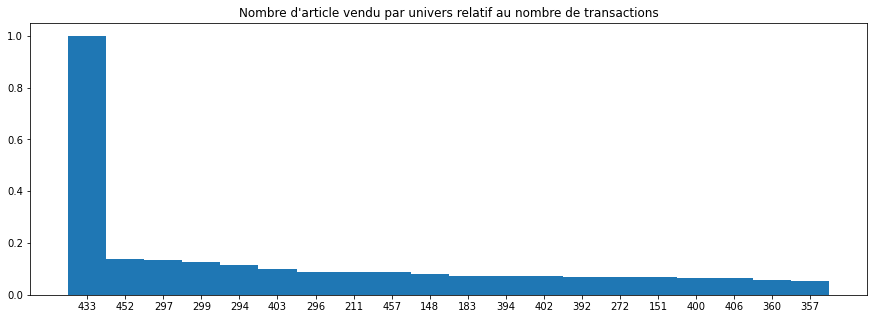

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 4.14)
("Nombre moyen d'univ", 1.27)
('CA univ', 882.9)
('CA moyen univ', 3.04)
('Nombre moyen article en plus', 5.68)
('CA en plus', 5855.28)
('CA moyen en plus', 20.19)
==============434===================
452
Time Taken to load recurence: ~0secondes


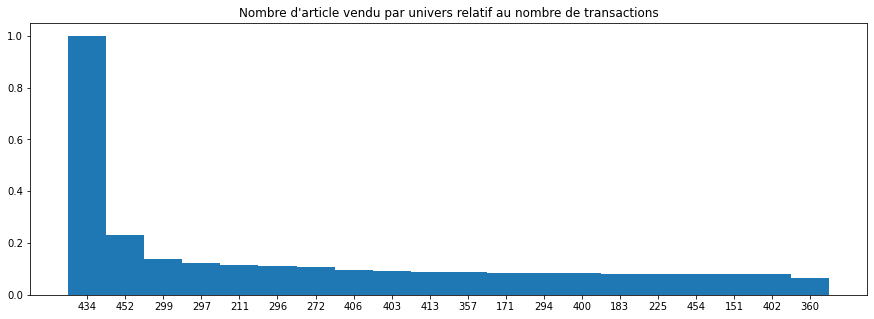

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 1.55)
("Nombre moyen d'univ", 1.08)
('CA univ', 1659.34)
('CA moyen univ', 3.67)
('Nombre moyen article en plus', 6.65)
('CA en plus', 10163.76)
('CA moyen en plus', 22.49)
==============435===================
57779
Time Taken to load recurence: ~0secondes


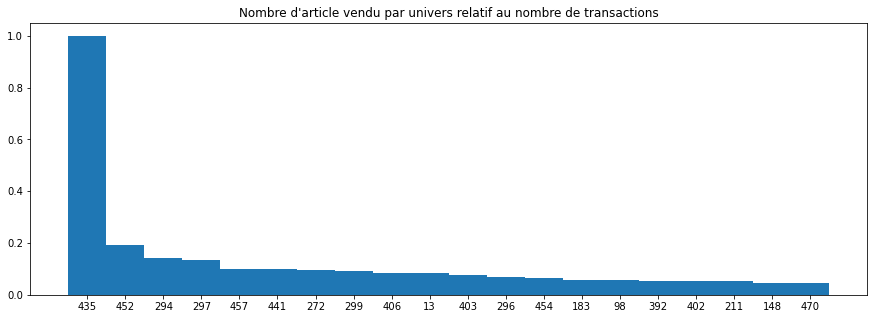

("Proportion d'achat (%)", 1.52)
('Proportion achat seul (%)', 9.36)
("Nombre moyen d'univ", 1.17)
('CA univ', 414487.14)
('CA moyen univ', 7.17)
('Nombre moyen article en plus', 5.15)
('CA en plus', 999844.83)
('CA moyen en plus', 17.3)
==============436===================
582
Time Taken to load recurence: ~0secondes


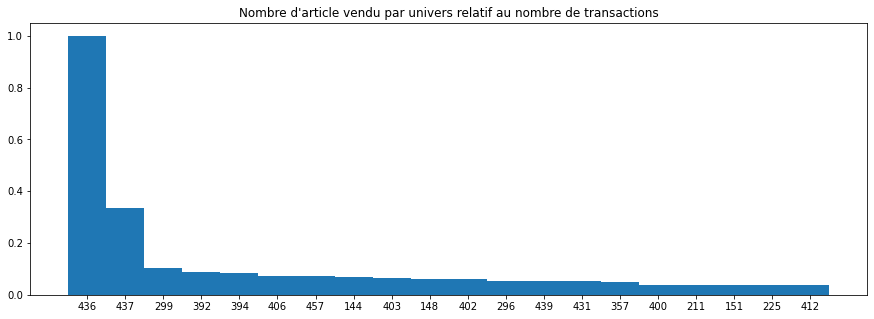

("Proportion d'achat (%)", 0.02)
('Proportion achat seul (%)', 11.0)
("Nombre moyen d'univ", 1.18)
('CA univ', 2060.27)
('CA moyen univ', 3.54)
('Nombre moyen article en plus', 3.02)
('CA en plus', 6253.39)
('CA moyen en plus', 10.74)
==============437===================
155183
Time Taken to load recurence: ~0secondes


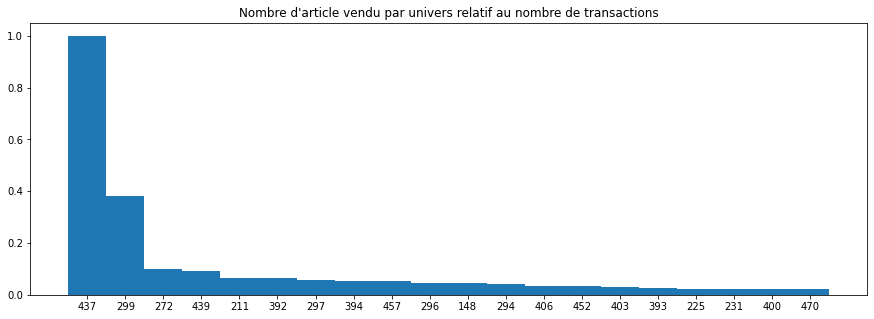

("Proportion d'achat (%)", 4.09)
('Proportion achat seul (%)', 20.75)
("Nombre moyen d'univ", 1.28)
('CA univ', 354598.68)
('CA moyen univ', 2.29)
('Nombre moyen article en plus', 2.91)
('CA en plus', 1249220.69)
('CA moyen en plus', 8.05)
==============438===================
29461
Time Taken to load recurence: ~0secondes


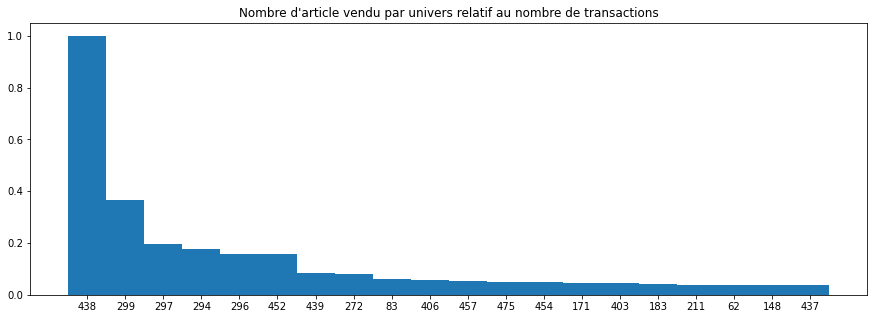

("Proportion d'achat (%)", 0.78)
('Proportion achat seul (%)', 11.07)
("Nombre moyen d'univ", 1.1)
('CA univ', 183018.07)
('CA moyen univ', 6.21)
('Nombre moyen article en plus', 6.24)
('CA en plus', 549814.54)
('CA moyen en plus', 18.66)
==============439===================
109878
Time Taken to load recurence: ~0secondes


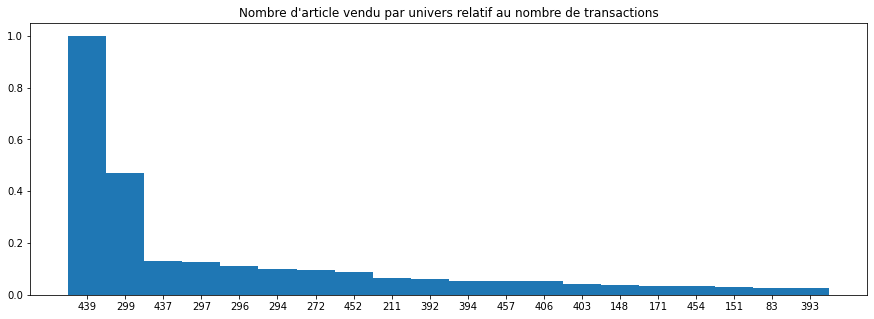

("Proportion d'achat (%)", 2.89)
('Proportion achat seul (%)', 7.14)
("Nombre moyen d'univ", 1.13)
('CA univ', 315045.97)
('CA moyen univ', 2.87)
('Nombre moyen article en plus', 4.64)
('CA en plus', 1381408.46)
('CA moyen en plus', 12.57)
==============440===================
2155
Time Taken to load recurence: ~0secondes


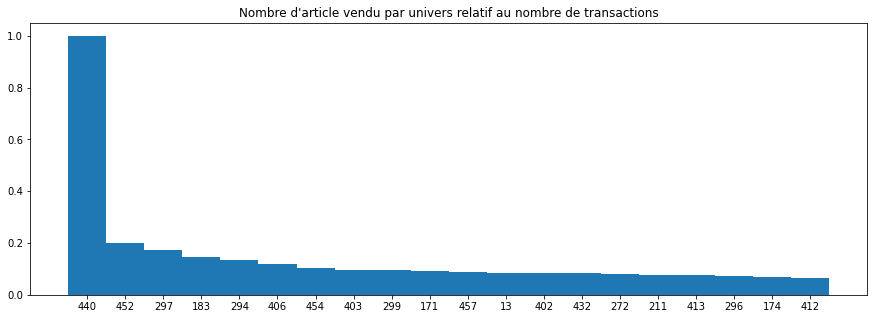

("Proportion d'achat (%)", 0.06)
('Proportion achat seul (%)', 3.48)
("Nombre moyen d'univ", 1.12)
('CA univ', 14889.22)
('CA moyen univ', 6.91)
('Nombre moyen article en plus', 7.78)
('CA en plus', 63076.23)
('CA moyen en plus', 29.27)
==============441===================
12778
Time Taken to load recurence: ~0secondes


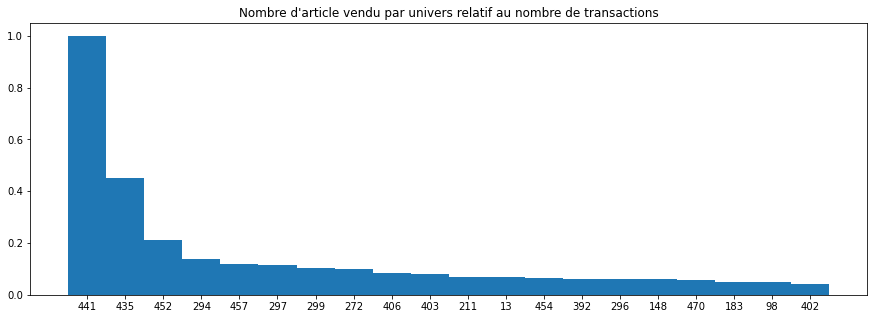

("Proportion d'achat (%)", 0.34)
('Proportion achat seul (%)', 4.6)
("Nombre moyen d'univ", 1.15)
('CA univ', 30018.11)
('CA moyen univ', 2.35)
('Nombre moyen article en plus', 5.57)
('CA en plus', 258856.8)
('CA moyen en plus', 20.26)
==============442===================
140
Time Taken to load recurence: ~0secondes


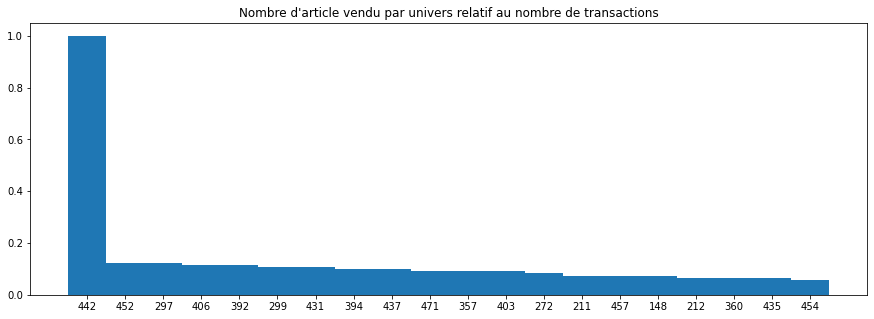

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 5.0)
("Nombre moyen d'univ", 1.17)
('CA univ', 618.85)
('CA moyen univ', 4.42)
('Nombre moyen article en plus', 4.91)
('CA en plus', 2135.82)
('CA moyen en plus', 15.26)
==============443===================
46453
Time Taken to load recurence: ~0secondes


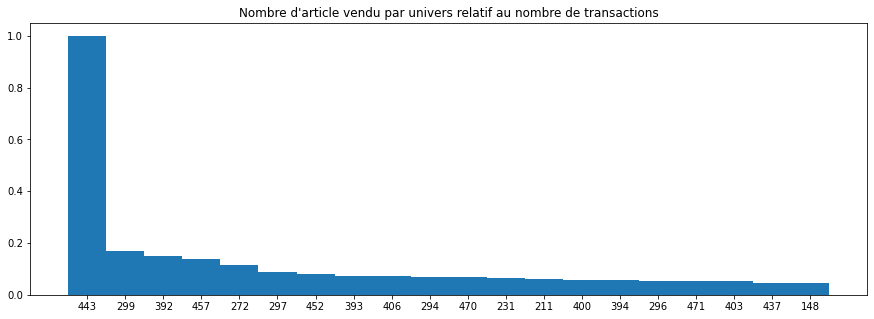

("Proportion d'achat (%)", 1.22)
('Proportion achat seul (%)', 8.45)
("Nombre moyen d'univ", 1.19)
('CA univ', 118355.38)
('CA moyen univ', 2.55)
('Nombre moyen article en plus', 3.82)
('CA en plus', 552265.54)
('CA moyen en plus', 11.89)
==============444===================
79
Time Taken to load recurence: ~0secondes


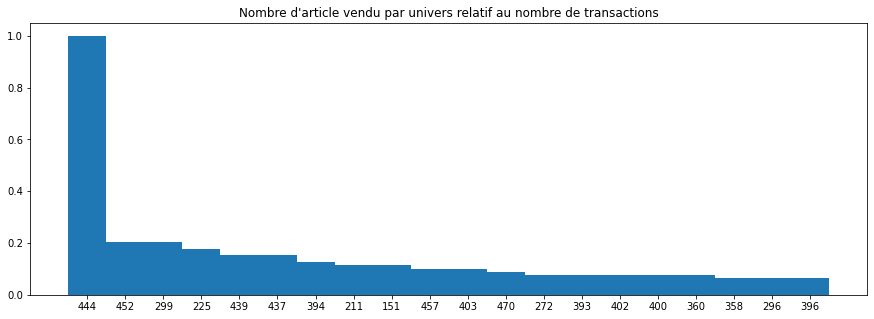

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 5.06)
("Nombre moyen d'univ", 1.27)
('CA univ', 255.72)
('CA moyen univ', 3.24)
('Nombre moyen article en plus', 5.08)
('CA en plus', 1257.2)
('CA moyen en plus', 15.91)
==============445===================
279
Time Taken to load recurence: ~0secondes


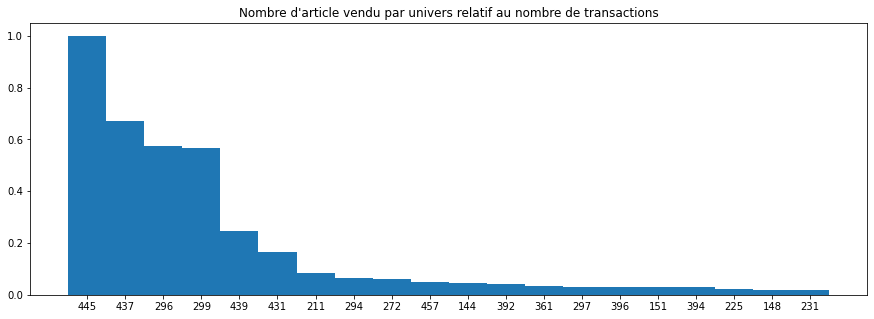

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 2.51)
("Nombre moyen d'univ", 1.46)
('CA univ', 196.05)
('CA moyen univ', 0.7)
('Nombre moyen article en plus', 4.49)
('CA en plus', 2906.82)
('CA moyen en plus', 10.42)
==============446===================
NOT ENOUGH DATA 
==============447===================
461
Time Taken to load recurence: ~0secondes


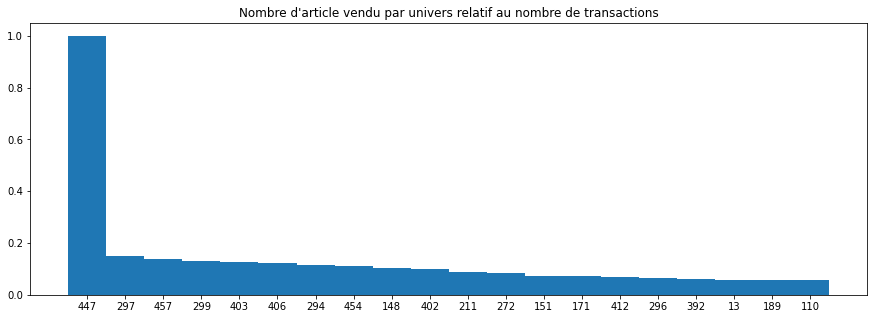

("Proportion d'achat (%)", 0.01)
('Proportion achat seul (%)', 3.25)
("Nombre moyen d'univ", 1.21)
('CA univ', 131.75)
('CA moyen univ', 0.29)
('Nombre moyen article en plus', 8.19)
('CA en plus', 14191.1)
('CA moyen en plus', 30.78)
==============448===================
23688
Time Taken to load recurence: ~0secondes


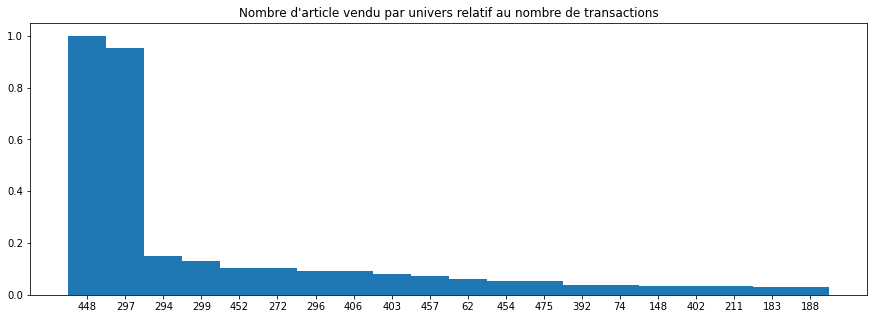

("Proportion d'achat (%)", 0.62)
('Proportion achat seul (%)', 0.06)
("Nombre moyen d'univ", 1.07)
('CA univ', 2462.52)
('CA moyen univ', 0.1)
('Nombre moyen article en plus', 5.33)
('CA en plus', 402792.69)
('CA moyen en plus', 17.0)
==============449===================
107
Time Taken to load recurence: ~0secondes


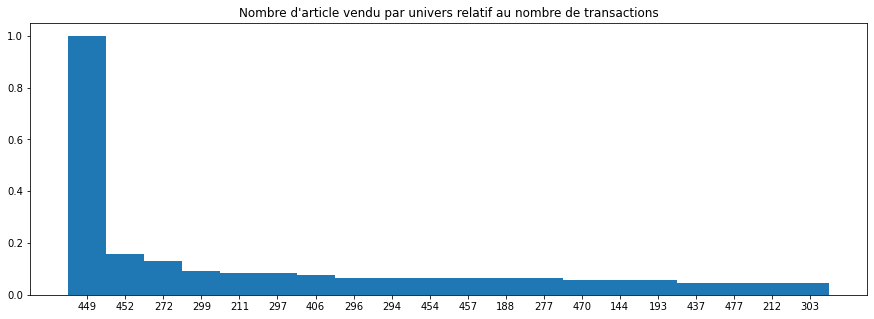

("Proportion d'achat (%)", 0.0)
('Proportion achat seul (%)', 16.82)
("Nombre moyen d'univ", 1.71)
('CA univ', 192.46)
('CA moyen univ', 1.8)
('Nombre moyen article en plus', 5.13)
('CA en plus', 2258.9)
('CA moyen en plus', 21.11)
==============450===================
NOT ENOUGH DATA 
==============451===================
NOT ENOUGH DATA 
==============452===================
269650
Time Taken to load recurence: ~1secondes


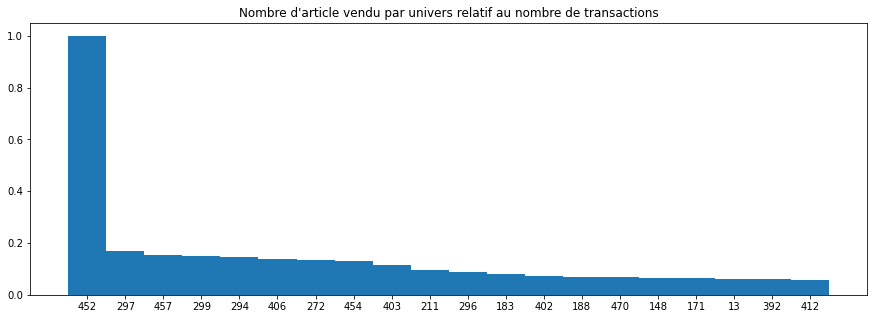

("Proportion d'achat (%)", 7.1)
('Proportion achat seul (%)', 1.81)
("Nombre moyen d'univ", 1.06)
('CA univ', 45483.43)
('CA moyen univ', 0.17)
('Nombre moyen article en plus', 7.9)
('CA en plus', 7954117.76)
('CA moyen en plus', 29.5)
==============453===================
1860
Time Taken to load recurence: ~0secondes


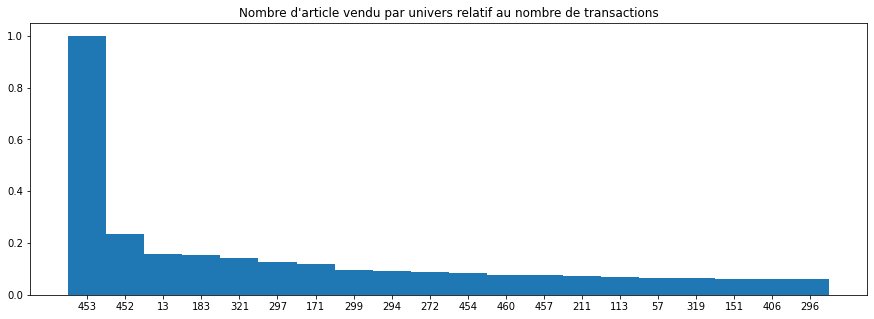

("Proportion d'achat (%)", 0.05)
('Proportion achat seul (%)', 3.44)
("Nombre moyen d'univ", 1.14)
('CA univ', 8425.73)
('CA moyen univ', 4.53)
('Nombre moyen article en plus', 8.24)
('CA en plus', 54337.13)
('CA moyen en plus', 29.21)
==============454===================
202433
Time Taken to load recurence: ~0secondes


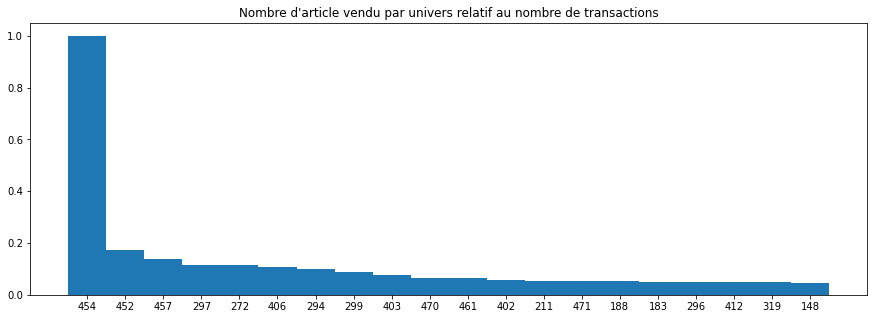

("Proportion d'achat (%)", 5.33)
('Proportion achat seul (%)', 5.32)
("Nombre moyen d'univ", 1.32)
('CA univ', 678349.13)
('CA moyen univ', 3.35)
('Nombre moyen article en plus', 5.65)
('CA en plus', 4424585.12)
('CA moyen en plus', 21.86)
==============455===================
25071
Time Taken to load recurence: ~0secondes


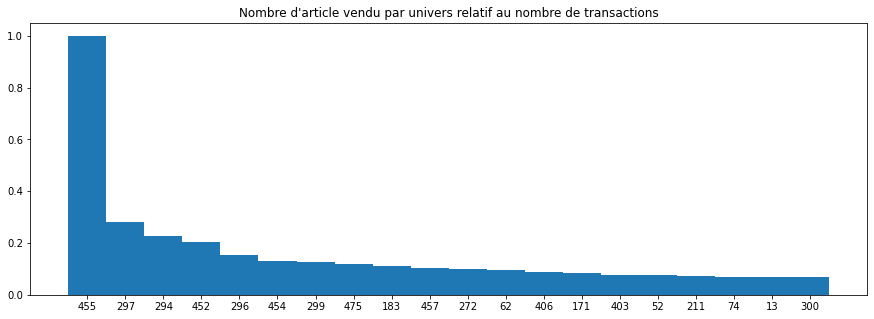

("Proportion d'achat (%)", 0.66)
('Proportion achat seul (%)', 2.03)
("Nombre moyen d'univ", 1.07)
('CA univ', 77688.99)
('CA moyen univ', 3.1)
('Nombre moyen article en plus', 8.02)
('CA en plus', 670042.21)
('CA moyen en plus', 26.73)
==============456===================
34693
Time Taken to load recurence: ~0secondes


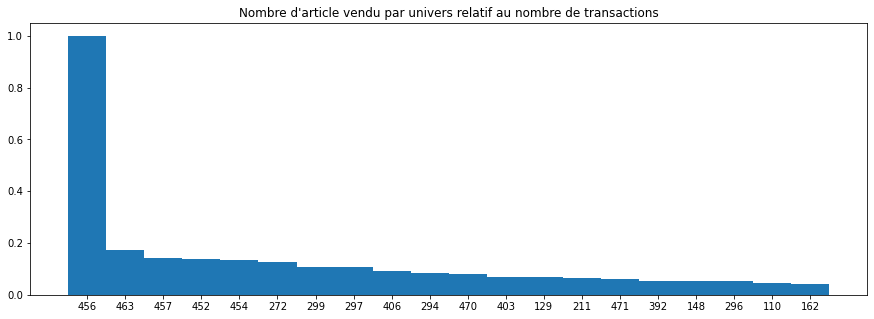

("Proportion d'achat (%)", 0.91)
('Proportion achat seul (%)', 5.54)
("Nombre moyen d'univ", 1.14)
('CA univ', 89246.82)
('CA moyen univ', 2.57)
('Nombre moyen article en plus', 5.52)
('CA en plus', 648937.61)
('CA moyen en plus', 18.71)
==============457===================
337527
Time Taken to load recurence: ~0secondes


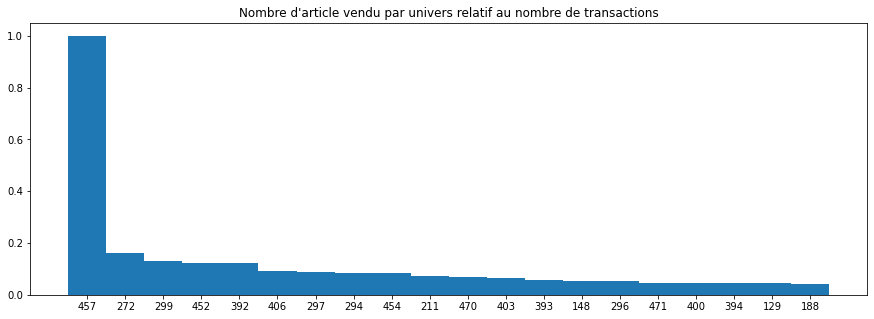

("Proportion d'achat (%)", 8.89)
('Proportion achat seul (%)', 7.21)
("Nombre moyen d'univ", 1.23)
('CA univ', 791489.01)
('CA moyen univ', 2.34)
('Nombre moyen article en plus', 4.39)
('CA en plus', 5202708.14)
('CA moyen en plus', 15.41)
==============458===================
40800
Time Taken to load recurence: ~0secondes


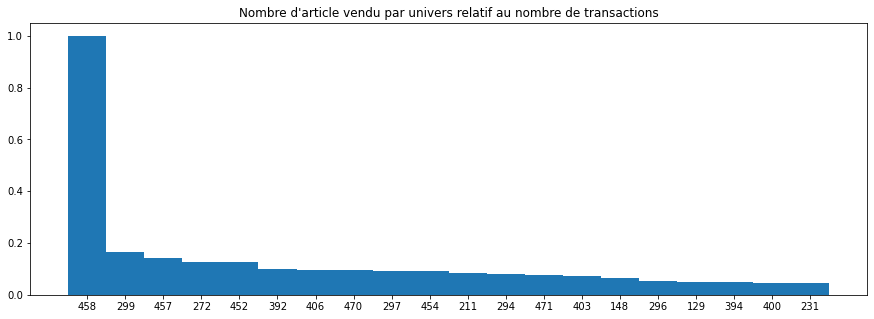

("Proportion d'achat (%)", 1.07)
('Proportion achat seul (%)', 6.03)
("Nombre moyen d'univ", 1.14)
('CA univ', 82958.6)
('CA moyen univ', 2.03)
('Nombre moyen article en plus', 5.08)
('CA en plus', 673270.59)
('CA moyen en plus', 16.5)
==============460===================
8105
Time Taken to load recurence: ~0secondes


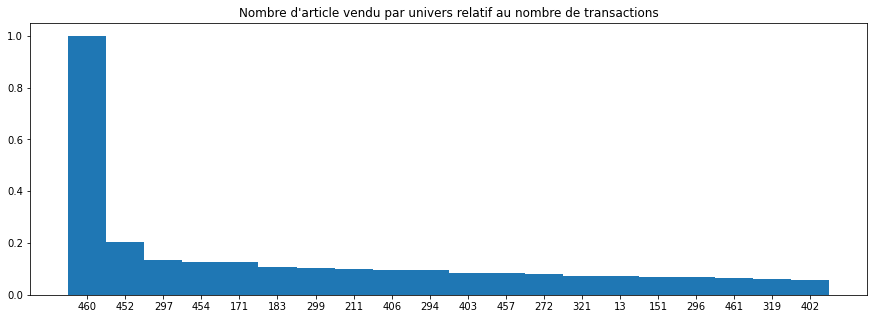

("Proportion d'achat (%)", 0.21)
('Proportion achat seul (%)', 3.05)
("Nombre moyen d'univ", 1.16)
('CA univ', 41708.03)
('CA moyen univ', 5.15)
('Nombre moyen article en plus', 7.74)
('CA en plus', 229037.74)
('CA moyen en plus', 28.26)
==============461===================
66126
Time Taken to load recurence: ~0secondes


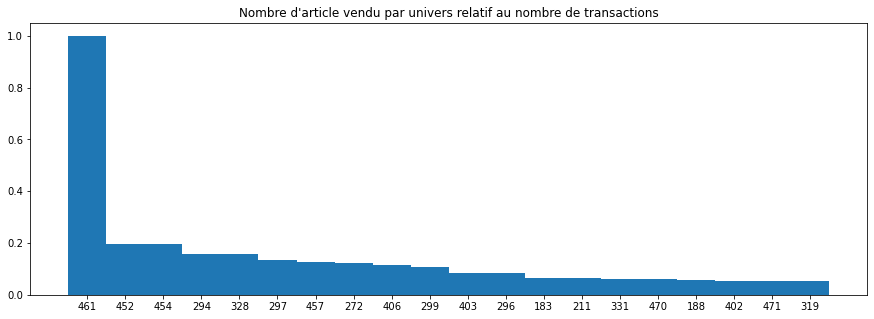

("Proportion d'achat (%)", 1.74)
('Proportion achat seul (%)', 1.9)
("Nombre moyen d'univ", 1.15)
('CA univ', 231081.06)
('CA moyen univ', 3.49)
('Nombre moyen article en plus', 6.89)
('CA en plus', 1641066.26)
('CA moyen en plus', 24.82)
==============462===================
30996
Time Taken to load recurence: ~0secondes


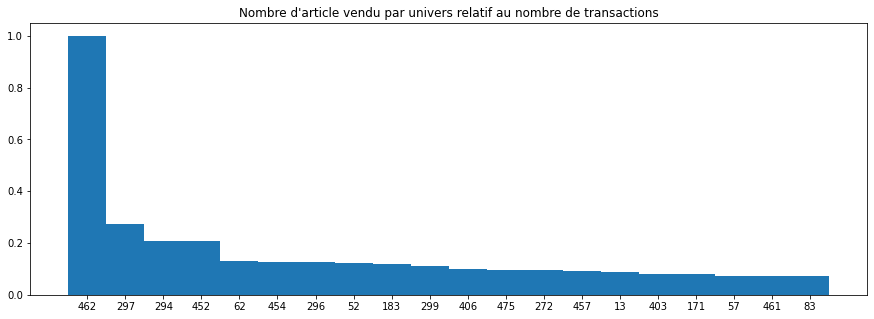

("Proportion d'achat (%)", 0.82)
('Proportion achat seul (%)', 1.85)
("Nombre moyen d'univ", 1.1)
('CA univ', 177373.63)
('CA moyen univ', 5.72)
('Nombre moyen article en plus', 8.35)
('CA en plus', 921106.35)
('CA moyen en plus', 29.72)
==============463===================
50580
Time Taken to load recurence: ~0secondes


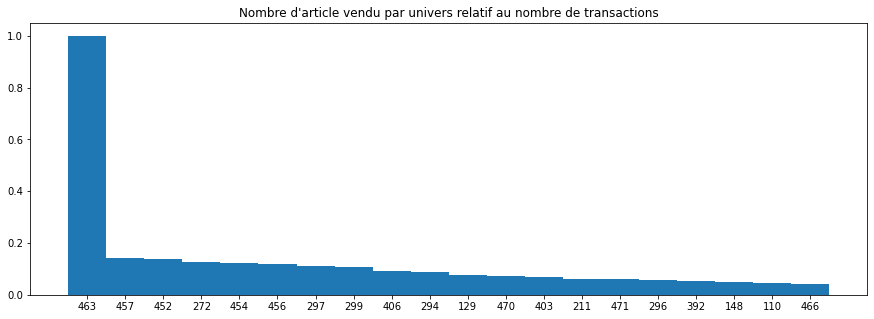

("Proportion d'achat (%)", 1.33)
('Proportion achat seul (%)', 5.37)
("Nombre moyen d'univ", 1.23)
('CA univ', 112577.23)
('CA moyen univ', 2.23)
('Nombre moyen article en plus', 5.33)
('CA en plus', 910963.19)
('CA moyen en plus', 18.01)
==============464===================
12847
Time Taken to load recurence: ~0secondes


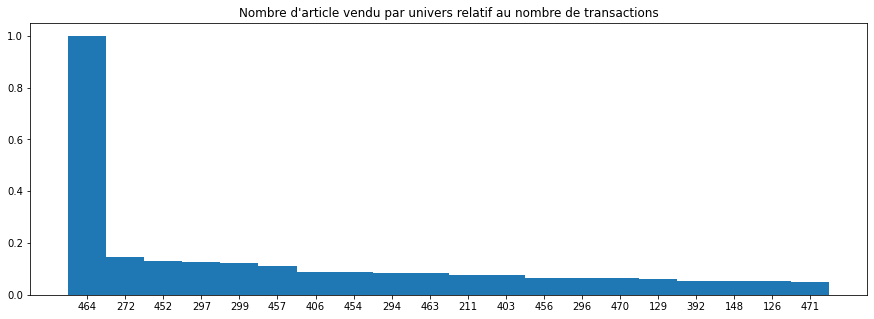

("Proportion d'achat (%)", 0.34)
('Proportion achat seul (%)', 5.62)
("Nombre moyen d'univ", 1.19)
('CA univ', 31523.42)
('CA moyen univ', 2.45)
('Nombre moyen article en plus', 5.86)
('CA en plus', 260888.17)
('CA moyen en plus', 20.31)
==============465===================
12177
Time Taken to load recurence: ~0secondes


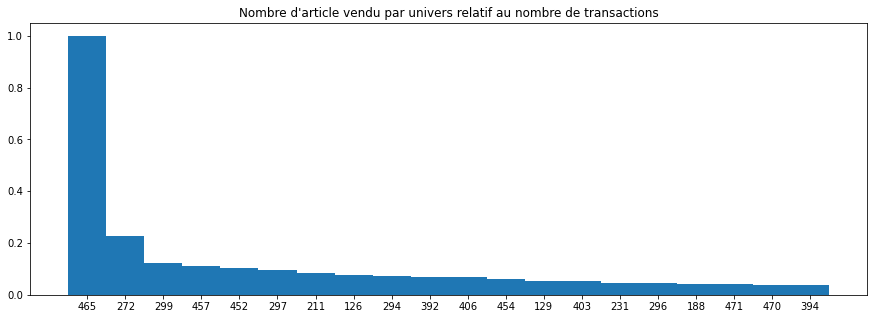

("Proportion d'achat (%)", 0.32)
('Proportion achat seul (%)', 6.64)
("Nombre moyen d'univ", 1.12)
('CA univ', 31584.49)
('CA moyen univ', 2.59)
('Nombre moyen article en plus', 4.59)
('CA en plus', 195169.44)
('CA moyen en plus', 16.03)
==============466===================
21459
Time Taken to load recurence: ~0secondes


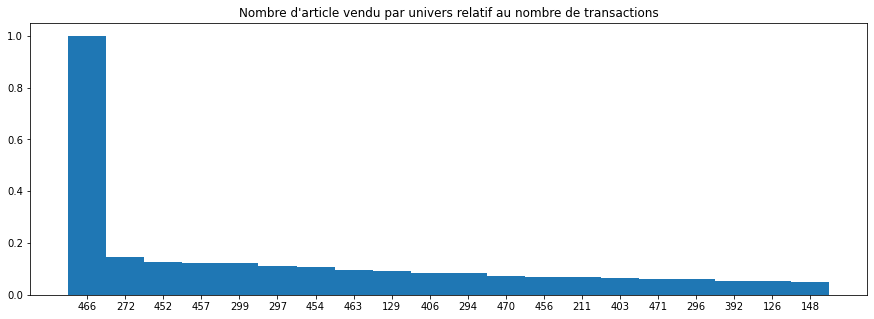

("Proportion d'achat (%)", 0.57)
('Proportion achat seul (%)', 6.39)
("Nombre moyen d'univ", 1.15)
('CA univ', 48828.29)
('CA moyen univ', 2.28)
('Nombre moyen article en plus', 5.31)
('CA en plus', 374891.68)
('CA moyen en plus', 17.47)
==============467===================
5416
Time Taken to load recurence: ~0secondes


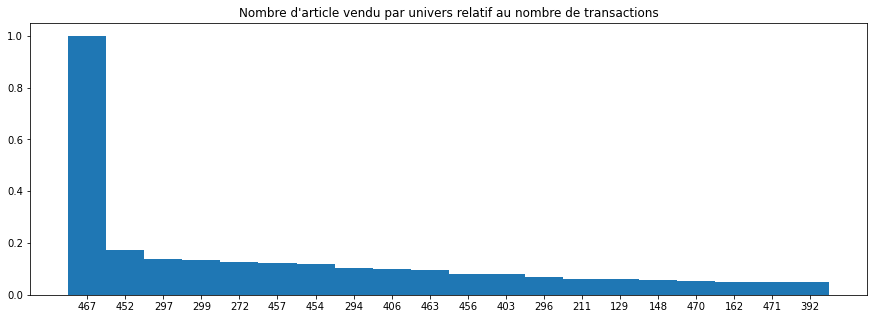

("Proportion d'achat (%)", 0.14)
('Proportion achat seul (%)', 5.52)
("Nombre moyen d'univ", 1.25)
('CA univ', 18953.1)
('CA moyen univ', 3.5)
('Nombre moyen article en plus', 6.39)
('CA en plus', 124272.13)
('CA moyen en plus', 22.95)
==============468===================
11680
Time Taken to load recurence: ~0secondes


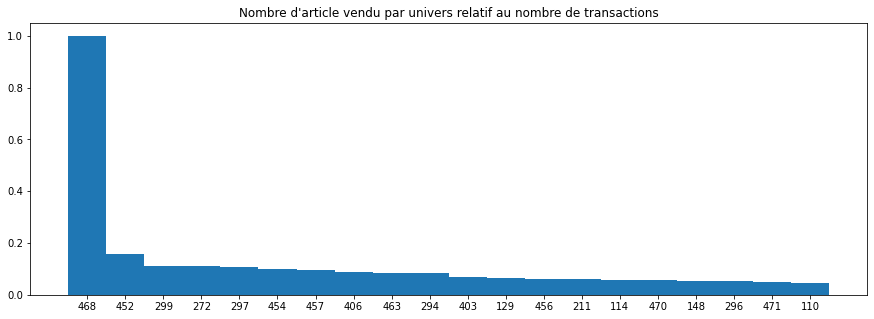

("Proportion d'achat (%)", 0.31)
('Proportion achat seul (%)', 7.93)
("Nombre moyen d'univ", 1.13)
('CA univ', 87965.88)
('CA moyen univ', 7.53)
('Nombre moyen article en plus', 5.87)
('CA en plus', 253162.24)
('CA moyen en plus', 21.67)
==============469===================
25148
Time Taken to load recurence: ~0secondes


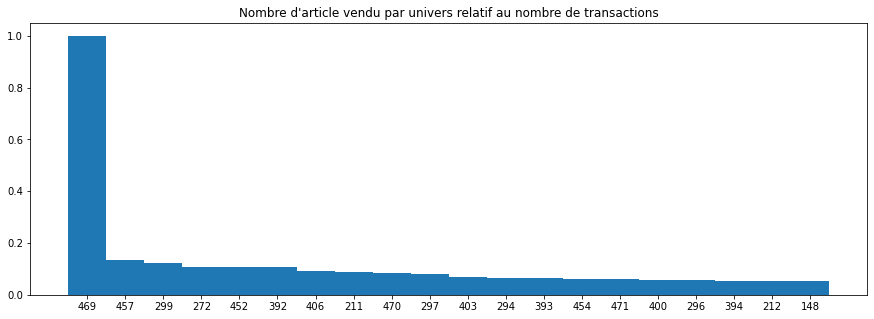

("Proportion d'achat (%)", 0.66)
('Proportion achat seul (%)', 5.54)
("Nombre moyen d'univ", 1.13)
('CA univ', 37259.67)
('CA moyen univ', 1.48)
('Nombre moyen article en plus', 4.79)
('CA en plus', 403903.11)
('CA moyen en plus', 16.06)
==============470===================
139526
Time Taken to load recurence: ~0secondes


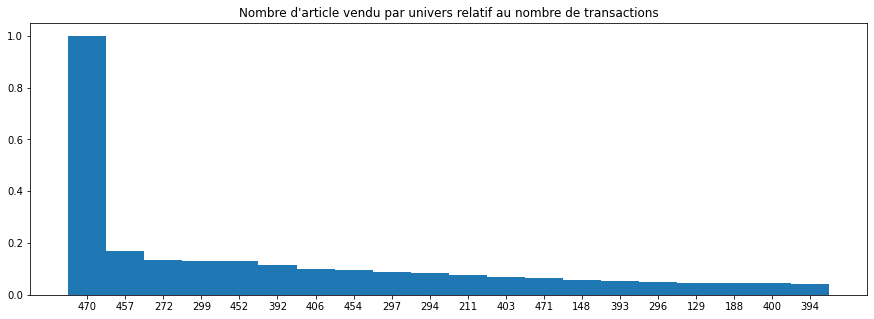

("Proportion d'achat (%)", 3.68)
('Proportion achat seul (%)', 6.06)
("Nombre moyen d'univ", 1.19)
('CA univ', 277839.84)
('CA moyen univ', 1.99)
('Nombre moyen article en plus', 4.81)
('CA en plus', 2239835.98)
('CA moyen en plus', 16.05)
==============471===================
128018
Time Taken to load recurence: ~0secondes


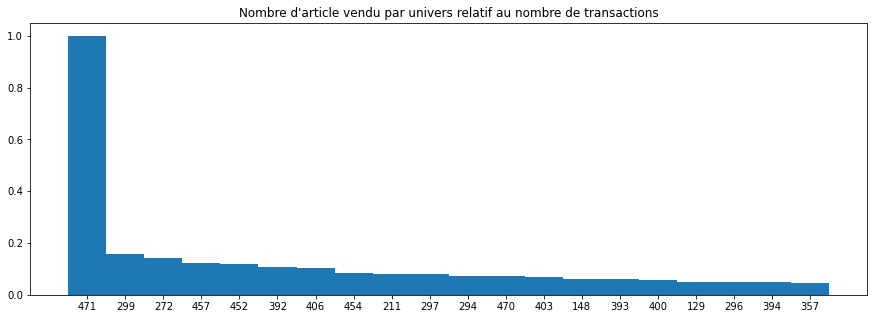

("Proportion d'achat (%)", 3.37)
('Proportion achat seul (%)', 5.72)
("Nombre moyen d'univ", 1.18)
('CA univ', 294008.24)
('CA moyen univ', 2.3)
('Nombre moyen article en plus', 4.7)
('CA en plus', 2027409.9)
('CA moyen en plus', 15.84)
==============472===================
54329
Time Taken to load recurence: ~0secondes


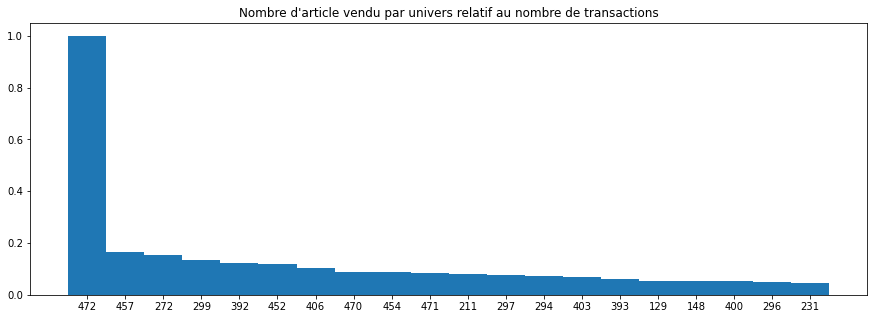

("Proportion d'achat (%)", 1.43)
('Proportion achat seul (%)', 5.41)
("Nombre moyen d'univ", 1.14)
('CA univ', 122824.61)
('CA moyen univ', 2.26)
('Nombre moyen article en plus', 4.61)
('CA en plus', 826935.51)
('CA moyen en plus', 15.22)
==============473===================
43617
Time Taken to load recurence: ~0secondes


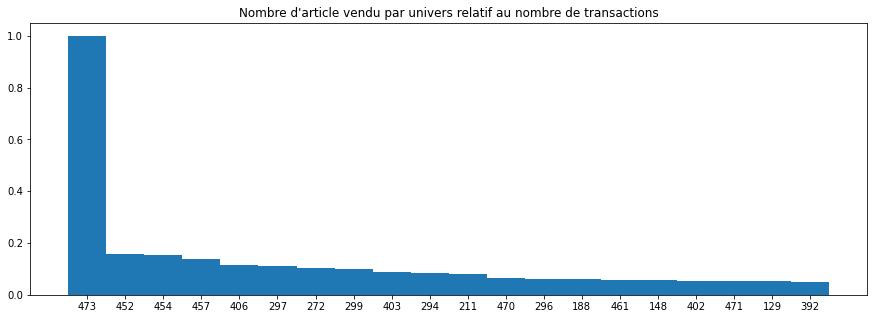

("Proportion d'achat (%)", 1.15)
('Proportion achat seul (%)', 3.81)
("Nombre moyen d'univ", 1.31)
('CA univ', 63133.56)
('CA moyen univ', 1.45)
('Nombre moyen article en plus', 5.74)
('CA en plus', 869829.17)
('CA moyen en plus', 19.94)
==============474===================
10365
Time Taken to load recurence: ~0secondes


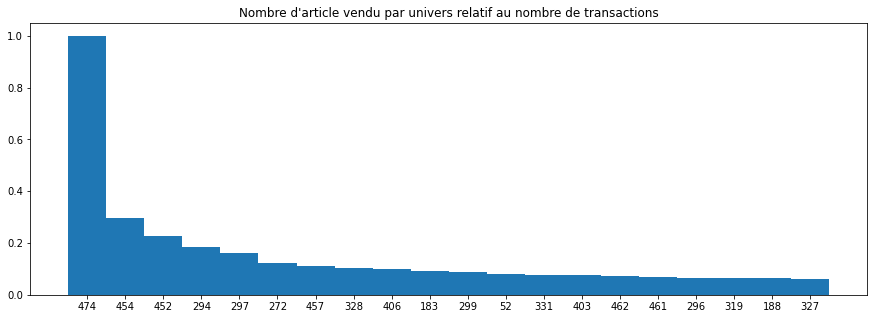

("Proportion d'achat (%)", 0.27)
('Proportion achat seul (%)', 1.94)
("Nombre moyen d'univ", 1.07)
('CA univ', 56401.1)
('CA moyen univ', 5.44)
('Nombre moyen article en plus', 7.56)
('CA en plus', 297661.73)
('CA moyen en plus', 28.72)
==============475===================
71802
Time Taken to load recurence: ~0secondes


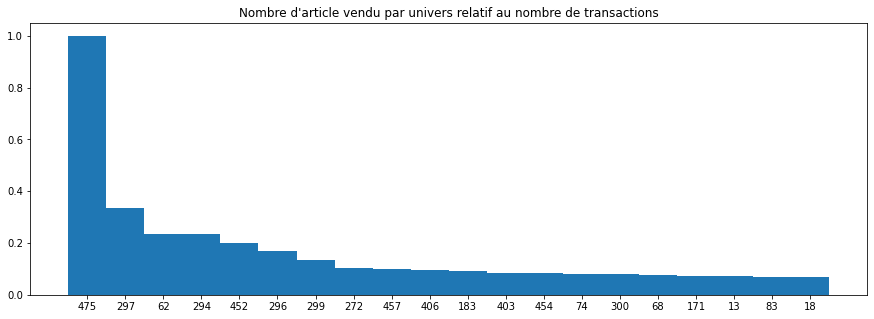

("Proportion d'achat (%)", 1.89)
('Proportion achat seul (%)', 1.42)
("Nombre moyen d'univ", 1.09)
('CA univ', 309302.44)
('CA moyen univ', 4.31)
('Nombre moyen article en plus', 7.9)
('CA en plus', 1890563.4)
('CA moyen en plus', 26.33)
==============476===================
18269
Time Taken to load recurence: ~0secondes


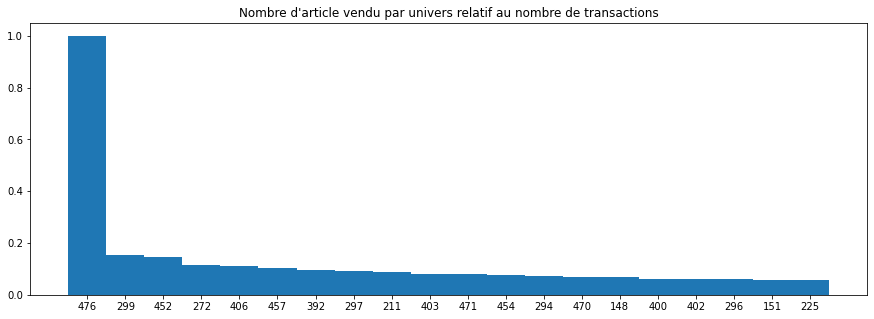

("Proportion d'achat (%)", 0.48)
('Proportion achat seul (%)', 4.31)
("Nombre moyen d'univ", 1.23)
('CA univ', 55914.5)
('CA moyen univ', 3.06)
('Nombre moyen article en plus', 5.6)
('CA en plus', 347592.27)
('CA moyen en plus', 19.03)
==============477===================
25860
Time Taken to load recurence: ~0secondes


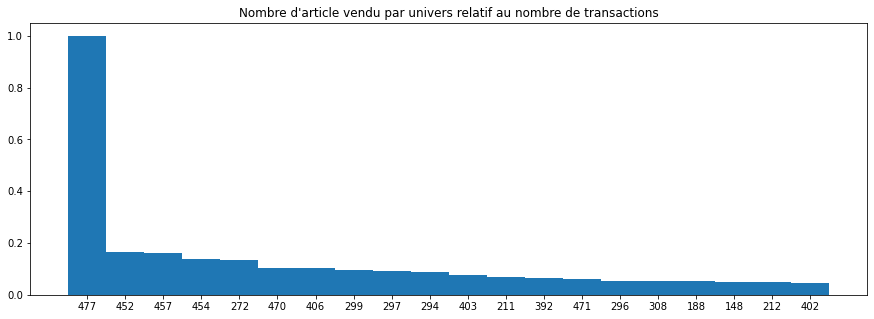

("Proportion d'achat (%)", 0.68)
('Proportion achat seul (%)', 5.6)
("Nombre moyen d'univ", 1.25)
('CA univ', 96257.15)
('CA moyen univ', 3.72)
('Nombre moyen article en plus', 5.71)
('CA en plus', 559802.88)
('CA moyen en plus', 21.65)
==============478===================
6254
Time Taken to load recurence: ~0secondes


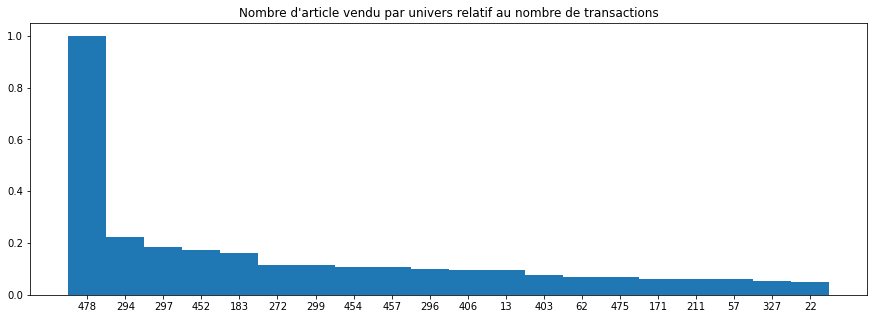

("Proportion d'achat (%)", 0.16)
('Proportion achat seul (%)', 3.04)
("Nombre moyen d'univ", 1.22)
('CA univ', 26407.16)
('CA moyen univ', 4.22)
('Nombre moyen article en plus', 7.34)
('CA en plus', 161049.92)
('CA moyen en plus', 25.75)
==============479===================
NOT ENOUGH DATA 
==============490===================
NOT ENOUGH DATA 
Time Taken to load all metrics: ~124secondes


In [23]:
start = time()

dico_metrics = {}

for key in all_univ:
    print("==============" + str(key)+"===================")
    
    trans           = univ_transactions[key]
    CA_without_univ = univ_CA_sans_univ[key]
    CA_univ         = univ_CA[key]
        
    N = len(trans)
    if N <= 50:
        print("NOT ENOUGH DATA ")
        continue
    
    nbr_article_sans_univ, nbr_article_univ = get_nbr_sans_univ(trans, [key])
    _, _ = load_recurence(trans)
    
    dico_metrics[key] = {"Proportion d'achat (%)": round(N*100/len(transactions),2),
                         "Proportion achat seul (%)": round(sum([1 if t == 0 else 0 for t in nbr_article_sans_univ])*100/N, 2),
                         "Nombre moyen d'univ":round(sum(nbr_article_univ)/N, 2),
                         "CA univ":round(CA_univ,2),
                         "CA moyen univ":round(CA_univ/N,2),
                         "Nombre moyen article en plus": round(sum(nbr_article_sans_univ)/N, 2),
                         "CA en plus": round(CA_without_univ,2),
                         "CA moyen en plus":round(CA_without_univ/N,2)}
    for item in dico_metrics[key].items():
        print(item)
    
    
print("Time Taken to load all metrics: ~" + str(int(time() - start)) + "secondes") 

In [24]:
dataframe_metrics = pd.DataFrame(index = dico_metrics.keys(),
                                 data = dico_metrics.values())
print(dataframe_metrics)

     Proportion d'achat (%)  Proportion achat seul (%)  Nombre moyen d'univ  \
1                      0.01                       7.56                 1.49   
2                      0.01                       6.73                 1.18   
4                      0.04                       8.10                 1.13   
5                      0.01                      11.85                 1.74   
9                      0.41                       5.34                 1.16   
..                      ...                        ...                  ...   
474                    0.27                       1.94                 1.07   
475                    1.89                       1.42                 1.09   
476                    0.48                       4.31                 1.23   
477                    0.68                       5.60                 1.25   
478                    0.16                       3.04                 1.22   

       CA univ  CA moyen univ  Nombre moyen article

In [25]:
dataframe_metrics=dataframe_metrics.sort_values(by=dataframe_metrics.columns[0], axis = 0, ascending=False)
print(dataframe_metrics.head(10))

     Proportion d'achat (%)  Proportion achat seul (%)  Nombre moyen d'univ  \
272                   14.44                      26.44                 1.18   
299                   13.58                      12.16                 2.03   
297                   11.29                      15.26                 1.20   
294                    9.45                      15.28                 1.31   
457                    8.89                       7.21                 1.23   
406                    7.78                      10.77                 1.45   
452                    7.10                       1.81                 1.06   
392                    6.78                      19.20                 1.23   
403                    6.21                      10.57                 1.48   
296                    5.98                       7.68                 1.90   

        CA univ  CA moyen univ  Nombre moyen article en plus  CA en plus  \
272  5002252.48           9.13                        

In [26]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~921secondes


## Load DataFrame with only fidelised client from a segment.

In [ ]:
start = time()

segment = 1

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY],
['''     + TABLE_ENTETE   + '''.KEY], ''' + ('''
['''+ TABLE_ENTETE   +'''.'''+TABLE_MAGASIN+'''.KEY],''')*int(do_shop) + '''
['''     + RECETTE_DETAIL + ''']
FROM ['''       + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL    + ''']
ON ['''  + TABLE_ARTICLE + '''.KEY] = ['''  + TABLE_DETAIL    + '''.''' + TABLE_ARTICLE + '''.KEY]
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE    + '''] 
ON ['''  + TEMPS_DETAIL  + '''] = ['''      + TEMPS_ENTETE    + '''] 
AND [''' + NUMERO_DETAIL + '''] = ['''      + NUMERO_ENTETE   + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + CONSOMMATEUR    + ''']
ON [''' + CONSOMMATEUR    + '''.Key] = ['''      + TABLE_ENTETE  + '''.''' + CONSOMMATEUR  + '''.KEY]
WHERE ['''    + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
AND ['''      + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''      + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] != 388
AND ['''      + CONSOMMATEUR  + '''.KEY] != -1
AND ['''+ CONSOMMATEUR  +'''.Segment_Clientele] = ''' + str(segment) + '''
ORDER BY [''' + TABLE_ENTETE  + '''.KEY]'''

print(sql_command)

conn = engine.connect()
df_art_ticket = pd.read_sql(sql_command, conn)


# environ 4min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_art_ticket)
print(df_art_ticket)

In [41]:
for key,val in dataframe_metrics.to_dict('index').items():
    print(list(val.values()))
    sql_cmd = '''INSERT INTO ['''+DB+'''].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES ('''+str(key)+''',
        '''+str(int(bool(take_only_fid)))+''',
        '''+str(len(transactions))+''',
        '''+str(list(val.values())[0])+''',
        '''+str(list(val.values())[1])+''',
        '''+str(list(val.values())[2])+''',
        '''+str(list(val.values())[3])+''',
        '''+str(list(val.values())[4])+''',
        '''+str(list(val.values())[5])+''',
        '''+str(list(val.values())[6])+''',
        '''+str(list(val.values())[7])+''')'''
                                                                                             
#     print(sql_cmd)
    conn = engine.connect()
    conn.execute(sql_cmd)
    conn.close()

[14.44, 26.44, 1.18, 5002252.48, 9.13, 2.99, 5480833.6, 10.0]
INSERT INTO [Archive2018_2019_prod].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES (272,
        0,
        3795699,
        14.44,
        26.44,
        1.18,
        5002252.48,
        9.13,
        2.99,
        

[2.89, 7.14, 1.13, 315045.97, 2.87, 4.64, 1381408.46, 12.57]
INSERT INTO [Archive2018_2019_prod].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES (439,
        0,
        3795699,
        2.89,
        7.14,
        1.13,
        315045.97,
        2.87,
        4.64,
        1381

[0.87, 5.45, 1.22, 100630.83, 3.04, 7.06, 822969.16, 24.85]
INSERT INTO [Archive2018_2019_prod].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES (78,
        0,
        3795699,
        0.87,
        5.45,
        1.22,
        100630.83,
        3.04,
        7.06,
        822969

[0.52, 6.34, 1.12, 45673.31, 2.33, 7.79, 522738.12, 26.67]
INSERT INTO [Archive2018_2019_prod].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES (180,
        0,
        3795699,
        0.52,
        6.34,
        1.12,
        45673.31,
        2.33,
        7.79,
        522738.

[0.3, 1.17, 1.04, 30348.95, 2.68, 7.82, 299289.95, 26.39]
INSERT INTO [Archive2018_2019_prod].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES (66,
        0,
        3795699,
        0.3,
        1.17,
        1.04,
        30348.95,
        2.68,
        7.82,
        299289.95,

[0.13, 7.95, 1.05, 40874.15, 8.31, 8.01, 144843.72, 29.46]
INSERT INTO [Archive2018_2019_prod].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES (88,
        0,
        3795699,
        0.13,
        7.95,
        1.05,
        40874.15,
        8.31,
        8.01,
        144843.7

[0.09, 14.15, 1.61, 25293.38, 7.52, 4.56, 58699.7, 17.44]
INSERT INTO [Archive2018_2019_prod].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES (259,
        0,
        3795699,
        0.09,
        14.15,
        1.61,
        25293.38,
        7.52,
        4.56,
        58699.7

[0.04, 19.52, 1.31, 6289.05, 4.22, 3.94, 19163.12, 12.85]
INSERT INTO [Archive2018_2019_prod].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES (191,
        0,
        3795699,
        0.04,
        19.52,
        1.31,
        6289.05,
        4.22,
        3.94,
        19163.12

[0.01, 3.25, 1.21, 131.75, 0.29, 8.19, 14191.1, 30.78]
INSERT INTO [Archive2018_2019_prod].[PML].[Univers_Metrics]
           ([Univers_Metrics.UNIVERS.KEY]
           ,[Univers_Metrics.flags_only_fidelity]
           ,[Univers_Metrics.Nombre_Transactions_Totales]
           ,[Univers_Metrics.Proportion_Trasactions_avec_Univers]
           ,[Univers_Metrics.Proportion_Trasactions_avec_seulement_Univers]
           ,[Univers_Metrics.Nombre_Moyen_darticle_Univers_par_transaction]
           ,[Univers_Metrics.CA_de_Univers_total]
           ,[Univers_Metrics.CA_de_Univers_par_transaction_moyen]
           ,[Univers_Metrics.Nombre_Moyen_darticle_pas_Univers_par_transaction]
           ,[Univers_Metrics.CA_sans_univers_dans_transactions_avec_univers_total]
           ,[Univers_Metrics.CA_sans_univers_par_transaction_avec_univers_moyen])
        VALUES (447,
        0,
        3795699,
        0.01,
        3.25,
        1.21,
        131.75,
        0.29,
        8.19,
        14191.1,
    